# Baseline Code

This code introduces a two-step training for the N-HPatches problem. In N-HPatches problem, we aim to generate a patch descriptor that is able to perform successfully tasks such as matching, retrieval or verification. 

Contrary to classical HPatches dataset, in N-HPatches, images contain random non-smooth perturbations produced by a synthetic noise. This noise could be critical when training the descriptor, therefore, we introduce a denoising model that could help us to deal with those perturbations. Denoising models have been already introduced in the course [tutorials](https://github.com/MatchLab-Imperial/deep-learning-course) and lectures, their objective is to generate a clean/denoised version of the input image.  We will refer in this code to the images with noise as `noisy`, to the images after applying the denoise model as `denoised` and the original patches from HPatches (so no extra noise added) which are used as ground-truth for the denoising step as `clean`. 


Thus, we aim to minimize the noise in images before the second step, which is computing a feature vector, also called descriptor. Those descriptions must be a powerful representation of the input patches. The idea behind is that if two descriptors belong two similar patches, they should be close to each other, i.e. have a low Euclidean distance. See figure below:

![](https://i.ibb.co/4tvm3Vh/descriptorspace.png)

This baseline code gives a method you can use to compare to whatever another approach you develop.  There are several other approaches you can test to see if there is any improvement, e.g. train the descriptor directly with noisy patches, without the denoising model. However, this code provides some guidance about how to implement the different blocks, how to stack them if desired, how to read the data and how to evaluate the method.

The values given can be improved without changing the core method, only by tuning correctly the hyperparameters or giving it more training time, among others.

As a first step of the project, you should get familiar with the problem and the provided code, so you can develop more complex and robust algorithms afterward. 

## Safety Check

As Google Colab is an external platform, we cannot guarantee that everytime you connect to a remote server, you will have the same amount of RAM or video RAM. For that reason, we will first check the amount of memory we have in the notebook. RAM should be around 12.9 GB, which is enough to load the datasets in memory. Also, usually, we have available 11.4 GB of GPU memory, which is more than enough to run this code. However, some users reported having only 500 MB of GPU memory. If you have that amount, restart the environment to see if you get the corresponding 11.4 GB.

In [1]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
#!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
#!pip install gputil
#!pip install psutil
#!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [2]:
printm()

RAM Free: 30.0 GB  | Proc size: 50.6 MB
GPU RAM Free: 10948MB | Used: 316MB | Util   3% | Total 11264MB


## Downloading Functions and Data

The first step is to clone the GitHub repository of the course, which contains already implemented functions. You can use your own function and import them here doing the same. In addition, we are going to download and extract the N-HPatches data. 

As a note, in colab, we can run terminal commands by using ```!```. Also, by using ```%``` we have access to the [built-in IPython magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-cd), which we will use to move through directories (`cd` command). It takes around 5 minutes to download and unzip the dataset. 


In [ ]:
# Clone repo
!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor

In [3]:
# Change directory
%cd keras_triplet_descriptor    


C:\Users\User\Downloads\keras_triplet_descriptor


In [ ]:
# Download data
!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip


In [ ]:
# Extract data
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

## Importing Necessary Modules

We now import the modules we will use in this baseline code. 

In [4]:
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

Using TensorFlow backend.


The `read_data` and `utils` imports are functions provided in the repository we just cloned. You can navigate through the *File tab* and check what those functions do for a better understanding.

![texto del enlace](https://i.ibb.co/HnfSvfT/filetab.png)





We also fix the seeds of the pseudo-random number generators to have reproducible results. The idea of fixing the seed is having the same results every time the algorithm is run if there are no changes in the code.

In [5]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

Now we load the data. The original HPatches dataset has several splits, which are used to separate the available sequences in train sequences and test sequences. For our experiments in N-HPatches we use the same splits as in HPatches. Specifically, we load (and report results) using the split `'a'`:


In [6]:
hpatches_dir = './hpatches'
splits_path = 'splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   

In [7]:
seqs

['C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_ajuntament',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_autannes',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_bologna',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_books',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_boutique',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_bridger',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_brooklyn',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_castle',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_chestnuts',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_contruction',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_crownday',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_crownnight',
 'C:\\Users\\User\\Downloads\\keras_triplet_descrip

In [7]:
seqs_train = list(filter(lambda x: x.split('\\')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('\\')[-1] in split['test'], seqs)) 

In [9]:
len(seqs)

116

In [10]:
len(seqs_train)

76

In [11]:
len(seqs_test)

40

## Models and loss

We now define three functions that define the main modules of our baseline. 

*   **get_denoise_model(..)** returns the denoising model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras denoising model. 
*   **get_descriptor_model(..)** builts the descriptor model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras descriptor model. The model we use as baseline returns a descriptor of dimension *128x1*.
*   **triplet_loss(..)** defines the loss function which is used to train the descriptor model. 

You can modify the models in these functions and run the training code again. For example, the given denoising model is quite shallow, maybe using a deeper network can improve results. Or testing new initializations for the weights. Or maybe adding dropout. Or modifying the loss function somehow...

In [8]:
def get_denoise_model(shape, do=0):
  
    inputs = Input(shape)
    
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = 'relu', padding='same')(inputs)))
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = 'relu', padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation = 'relu', padding='same')(pool1)))
    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation = 'relu', padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation = 'relu', padding='same')(pool2)))
    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation = 'relu', padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation = 'relu', padding='same')(pool3)))
    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation = 'relu', padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)((Conv2D(512, (3, 3), activation = 'relu', padding='same')(pool4)))
    conv5 = Dropout(do)((Conv2D(512, (3, 3), activation = 'relu', padding='same')(conv5)))

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Dropout(do)((Conv2D(256, (3, 3), activation = 'relu', padding='same')(up6)))
    conv6 = Dropout(do)((Conv2D(256, (3, 3), activation = 'relu', padding='same')(conv6)))

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Dropout(do)((Conv2D(128, (3, 3), activation = 'relu', padding='same')(up7)))
    conv7 = Dropout(do)((Conv2D(128, (3, 3), activation = 'relu', padding='same')(conv7)))

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Dropout(do)((Conv2D(64, (3, 3), activation = 'relu', padding='same')(up8)))
    conv8 = Dropout(do)((Conv2D(64, (3, 3), activation = 'relu', padding='same')(conv8)))

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation = 'relu', padding='same')(up9)))
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation = 'relu', padding='same')(conv9)))

    conv10 = Dropout(do)(Conv2D(1, (1, 1))(conv9))

    model = Model(inputs=[inputs], outputs=[conv10])

    return model


def get_descriptor_model(shape):
  
    '''Architecture copies HardNet architecture'''

    init_weights = keras.initializers.he_normal()

    descriptor_model = Sequential()
    descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))
    descriptor_model.add(Dropout(0.3))

    descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))

    # Final descriptor reshape
    descriptor_model.add(Reshape((128,)))

    return descriptor_model
  

def triplet_loss(x):
  
    output_dim = 128
    a, p, n = x
    _alpha = 1.0
    positive_distance = K.mean(K.square(a - p), axis=-1)
    negative_distance = K.mean(K.square(a - n), axis=-1)

    return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

## Denoising Image Patches


We use the *DenoiseHPatches* class implemented in the read_data.py file, which takes as input the list of sequences to load and the size of batches. 

*DenoiseHPatches* outputs batches where the input data is the noisy image and the label is the clean image, so we can use a mean absolute error (MAE) metric as loss function. You can try to use different metrics here to see if that improves results. 

Afterward, we take a subset of training and validation sequences by using *random.sample* (3 sequences for training and 1 for validation data). The purpose of doing so is just to speed-up training when trying different setups, but you should use the whole dataset when training your final model. Remove the random.sample function to give the generator all the training data.

In addition, note that we are using the test set as validation. We will provide you with a new test set that will be used to evaluate your final model, and from which you will not have the clean images. 

**Updated**: Training should be quite faster now (1 epoch around 15 minutes).

In [13]:
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 5), batch_size=50)
denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=50)

# Uncomment following lines for using all the data to train the denoising model
#denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
#denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


In [14]:
shape = (32, 32, 1)
denoise_model_adam = get_denoise_model(shape)
denoise_model_adam_amsgrad = get_denoise_model(shape)
denoise_model_sgd = get_denoise_model(shape)
denoise_model_adadelta = get_denoise_model(shape)
denoise_model_nadam = get_denoise_model(shape)

We set number of epochs to 1, tweak it, along with other hyperparameters, to improve the performance of the model.

In [15]:
adam = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
adam_amsgrad = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
adadelta =  keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
nadam = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)


denoise_model_adam.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])
denoise_model_adam_amsgrad.compile(loss='mean_absolute_error', optimizer=adam_amsgrad, metrics=['mae'])
denoise_model_sgd.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mae'])
denoise_model_adadelta.compile(loss='mean_absolute_error', optimizer=adadelta, metrics=['mae'])
denoise_model_nadam.compile(loss='mean_absolute_error', optimizer=nadam, metrics=['mae'])

#epochs = 1
### Use a loop to save for each epoch the weights in an external website in
### case colab stops. Every time you call fit/fit_generator the weigths are NOT
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)
#for e in range(epochs):
denoise_history_adam = denoise_model_adam.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)

denoise_history_adam_amsgrad = denoise_model_adam_amsgrad.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)

denoise_history_sgd = denoise_model_sgd.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)

denoise_history_adadelta = denoise_model_adadelta.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)

denoise_history_nadam = denoise_model_nadam.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)
### Saves optimizer and weights
#denoise_model_adam.save('denoise_adam.h5')
#denoise_model_adam_amsgrad.save('denoise_adam_amsgrad.h5')
#denoise_model_sgd.save('denoise_sgd.h5')
#denoise_model_adadelta.save('denoise_sgd.h5')
#denoise_model_nadam.save('denoise_sgd.h5')


### Uploads files to external hosting
#!curl -F "file=@denoise.h5" https://file.io


Epoch 1/5


 238/2040 [==>...........................] - ETA: 3:07:01 - loss: 98.0917 - mean_absolute_error: 98.09 - ETA: 1:34:20 - loss: 93.3520 - mean_absolute_error: 93.35 - ETA: 47:54 - loss: 92.2098 - mean_absolute_error: 92.2098 - ETA: 32:22 - loss: 88.7401 - mean_absolute_error: 88.74 - ETA: 27:58 - loss: 88.7498 - mean_absolute_error: 88.74 - ETA: 22:05 - loss: 88.6740 - mean_absolute_error: 88.67 - ETA: 20:02 - loss: 87.6323 - mean_absolute_error: 87.63 - ETA: 16:55 - loss: 84.4686 - mean_absolute_error: 84.46 - ETA: 15:45 - loss: 83.4529 - mean_absolute_error: 83.45 - ETA: 13:49 - loss: 81.4195 - mean_absolute_error: 81.41 - ETA: 12:21 - loss: 77.2424 - mean_absolute_error: 77.24 - ETA: 11:12 - loss: 73.5285 - mean_absolute_error: 73.52 - ETA: 10:15 - loss: 70.1358 - mean_absolute_error: 70.13 - ETA: 9:29 - loss: 66.8799 - mean_absolute_error: 66.8799 - ETA: 9:09 - loss: 65.5238 - mean_absolute_error: 65.523 - ETA: 8:33 - loss: 63.1829 - mean_absolute_error: 63.182 - ETA: 8:02 - loss: 60

 447/2040 [=====>........................] - ETA: 2:02 - loss: 15.9205 - mean_absolute_error: 15.920 - ETA: 2:02 - loss: 15.8483 - mean_absolute_error: 15.848 - ETA: 2:01 - loss: 15.7736 - mean_absolute_error: 15.773 - ETA: 2:01 - loss: 15.7399 - mean_absolute_error: 15.739 - ETA: 2:01 - loss: 15.7016 - mean_absolute_error: 15.701 - ETA: 2:00 - loss: 15.6353 - mean_absolute_error: 15.635 - ETA: 2:00 - loss: 15.5643 - mean_absolute_error: 15.564 - ETA: 2:00 - loss: 15.5316 - mean_absolute_error: 15.531 - ETA: 1:59 - loss: 15.4630 - mean_absolute_error: 15.463 - ETA: 1:59 - loss: 15.4298 - mean_absolute_error: 15.429 - ETA: 1:59 - loss: 15.3949 - mean_absolute_error: 15.394 - ETA: 1:58 - loss: 15.3302 - mean_absolute_error: 15.330 - ETA: 1:58 - loss: 15.2671 - mean_absolute_error: 15.267 - ETA: 1:58 - loss: 15.1999 - mean_absolute_error: 15.199 - ETA: 1:57 - loss: 15.1356 - mean_absolute_error: 15.135 - ETA: 1:57 - loss: 15.0746 - mean_absolute_error: 15.074 - ETA: 1:56 - loss: 15.0160 -

 644/2040 [========>.....................] - ETA: 1:33 - loss: 11.6090 - mean_absolute_error: 11.609 - ETA: 1:33 - loss: 11.5976 - mean_absolute_error: 11.597 - ETA: 1:33 - loss: 11.5853 - mean_absolute_error: 11.585 - ETA: 1:33 - loss: 11.5622 - mean_absolute_error: 11.562 - ETA: 1:33 - loss: 11.5502 - mean_absolute_error: 11.550 - ETA: 1:33 - loss: 11.5406 - mean_absolute_error: 11.540 - ETA: 1:33 - loss: 11.5293 - mean_absolute_error: 11.529 - ETA: 1:33 - loss: 11.5172 - mean_absolute_error: 11.517 - ETA: 1:32 - loss: 11.5074 - mean_absolute_error: 11.507 - ETA: 1:32 - loss: 11.4959 - mean_absolute_error: 11.495 - ETA: 1:32 - loss: 11.4844 - mean_absolute_error: 11.484 - ETA: 1:32 - loss: 11.4740 - mean_absolute_error: 11.474 - ETA: 1:32 - loss: 11.4612 - mean_absolute_error: 11.461 - ETA: 1:32 - loss: 11.4493 - mean_absolute_error: 11.449 - ETA: 1:32 - loss: 11.4386 - mean_absolute_error: 11.438 - ETA: 1:32 - loss: 11.4267 - mean_absolute_error: 11.426 - ETA: 1:32 - loss: 11.4165 -

 905/2040 [============>.................] - ETA: 1:17 - loss: 9.9811 - mean_absolute_error: 9.981 - ETA: 1:17 - loss: 9.9743 - mean_absolute_error: 9.974 - ETA: 1:17 - loss: 9.9625 - mean_absolute_error: 9.962 - ETA: 1:17 - loss: 9.9567 - mean_absolute_error: 9.956 - ETA: 1:17 - loss: 9.9453 - mean_absolute_error: 9.945 - ETA: 1:17 - loss: 9.9349 - mean_absolute_error: 9.934 - ETA: 1:17 - loss: 9.9288 - mean_absolute_error: 9.928 - ETA: 1:16 - loss: 9.9181 - mean_absolute_error: 9.918 - ETA: 1:16 - loss: 9.9084 - mean_absolute_error: 9.908 - ETA: 1:16 - loss: 9.9018 - mean_absolute_error: 9.901 - ETA: 1:16 - loss: 9.8962 - mean_absolute_error: 9.896 - ETA: 1:16 - loss: 9.8901 - mean_absolute_error: 9.890 - ETA: 1:16 - loss: 9.8776 - mean_absolute_error: 9.877 - ETA: 1:16 - loss: 9.8658 - mean_absolute_error: 9.865 - ETA: 1:16 - loss: 9.8551 - mean_absolute_error: 9.855 - ETA: 1:15 - loss: 9.8438 - mean_absolute_error: 9.843 - ETA: 1:15 - loss: 9.8326 - mean_absolute_error: 9.832 - ETA

1172/2040 [================>.............] - ETA: 59s - loss: 8.8590 - mean_absolute_error: 8.85 - ETA: 59s - loss: 8.8552 - mean_absolute_error: 8.85 - ETA: 59s - loss: 8.8489 - mean_absolute_error: 8.84 - ETA: 59s - loss: 8.8413 - mean_absolute_error: 8.84 - ETA: 59s - loss: 8.8350 - mean_absolute_error: 8.83 - ETA: 58s - loss: 8.8289 - mean_absolute_error: 8.82 - ETA: 58s - loss: 8.8218 - mean_absolute_error: 8.82 - ETA: 58s - loss: 8.8188 - mean_absolute_error: 8.81 - ETA: 58s - loss: 8.8126 - mean_absolute_error: 8.81 - ETA: 58s - loss: 8.8063 - mean_absolute_error: 8.80 - ETA: 58s - loss: 8.8004 - mean_absolute_error: 8.80 - ETA: 58s - loss: 8.7940 - mean_absolute_error: 8.79 - ETA: 58s - loss: 8.7869 - mean_absolute_error: 8.78 - ETA: 57s - loss: 8.7797 - mean_absolute_error: 8.77 - ETA: 57s - loss: 8.7766 - mean_absolute_error: 8.77 - ETA: 57s - loss: 8.7692 - mean_absolute_error: 8.76 - ETA: 57s - loss: 8.7631 - mean_absolute_error: 8.76 - ETA: 57s - loss: 8.7567 - mean_absolu

1430/2040 [====================>.........] - ETA: 43s - loss: 8.1707 - mean_absolute_error: 8.17 - ETA: 43s - loss: 8.1687 - mean_absolute_error: 8.16 - ETA: 43s - loss: 8.1652 - mean_absolute_error: 8.16 - ETA: 43s - loss: 8.1612 - mean_absolute_error: 8.16 - ETA: 43s - loss: 8.1576 - mean_absolute_error: 8.15 - ETA: 43s - loss: 8.1554 - mean_absolute_error: 8.15 - ETA: 43s - loss: 8.1536 - mean_absolute_error: 8.15 - ETA: 43s - loss: 8.1512 - mean_absolute_error: 8.15 - ETA: 43s - loss: 8.1495 - mean_absolute_error: 8.14 - ETA: 43s - loss: 8.1451 - mean_absolute_error: 8.14 - ETA: 43s - loss: 8.1409 - mean_absolute_error: 8.14 - ETA: 42s - loss: 8.1369 - mean_absolute_error: 8.13 - ETA: 42s - loss: 8.1325 - mean_absolute_error: 8.13 - ETA: 42s - loss: 8.1308 - mean_absolute_error: 8.13 - ETA: 42s - loss: 8.1276 - mean_absolute_error: 8.12 - ETA: 42s - loss: 8.1240 - mean_absolute_error: 8.12 - ETA: 42s - loss: 8.1203 - mean_absolute_error: 8.12 - ETA: 42s - loss: 8.1160 - mean_absolu

1628/2040 [======================>.......] - ETA: 30s - loss: 7.7162 - mean_absolute_error: 7.71 - ETA: 30s - loss: 7.7130 - mean_absolute_error: 7.71 - ETA: 29s - loss: 7.7102 - mean_absolute_error: 7.71 - ETA: 29s - loss: 7.7069 - mean_absolute_error: 7.70 - ETA: 29s - loss: 7.7044 - mean_absolute_error: 7.70 - ETA: 29s - loss: 7.7030 - mean_absolute_error: 7.70 - ETA: 29s - loss: 7.7016 - mean_absolute_error: 7.70 - ETA: 29s - loss: 7.6991 - mean_absolute_error: 7.69 - ETA: 29s - loss: 7.6957 - mean_absolute_error: 7.69 - ETA: 29s - loss: 7.6926 - mean_absolute_error: 7.69 - ETA: 29s - loss: 7.6893 - mean_absolute_error: 7.68 - ETA: 29s - loss: 7.6862 - mean_absolute_error: 7.68 - ETA: 29s - loss: 7.6837 - mean_absolute_error: 7.68 - ETA: 28s - loss: 7.6821 - mean_absolute_error: 7.68 - ETA: 28s - loss: 7.6806 - mean_absolute_error: 7.68 - ETA: 28s - loss: 7.6790 - mean_absolute_error: 7.67 - ETA: 28s - loss: 7.6763 - mean_absolute_error: 7.67 - ETA: 28s - loss: 7.6747 - mean_absolu

1798/2040 [=========================>....] - ETA: 20s - loss: 7.4474 - mean_absolute_error: 7.44 - ETA: 20s - loss: 7.4462 - mean_absolute_error: 7.44 - ETA: 20s - loss: 7.4446 - mean_absolute_error: 7.44 - ETA: 20s - loss: 7.4435 - mean_absolute_error: 7.44 - ETA: 20s - loss: 7.4421 - mean_absolute_error: 7.44 - ETA: 20s - loss: 7.4411 - mean_absolute_error: 7.44 - ETA: 20s - loss: 7.4396 - mean_absolute_error: 7.43 - ETA: 20s - loss: 7.4381 - mean_absolute_error: 7.43 - ETA: 20s - loss: 7.4368 - mean_absolute_error: 7.43 - ETA: 20s - loss: 7.4353 - mean_absolute_error: 7.43 - ETA: 20s - loss: 7.4339 - mean_absolute_error: 7.43 - ETA: 19s - loss: 7.4326 - mean_absolute_error: 7.43 - ETA: 19s - loss: 7.4298 - mean_absolute_error: 7.42 - ETA: 19s - loss: 7.4284 - mean_absolute_error: 7.42 - ETA: 19s - loss: 7.4271 - mean_absolute_error: 7.42 - ETA: 19s - loss: 7.4261 - mean_absolute_error: 7.42 - ETA: 19s - loss: 7.4246 - mean_absolute_error: 7.42 - ETA: 19s - loss: 7.4236 - mean_absolu

2016/2040 [============================>.] - ETA: 12s - loss: 7.2569 - mean_absolute_error: 7.25 - ETA: 12s - loss: 7.2563 - mean_absolute_error: 7.25 - ETA: 12s - loss: 7.2553 - mean_absolute_error: 7.25 - ETA: 11s - loss: 7.2544 - mean_absolute_error: 7.25 - ETA: 11s - loss: 7.2521 - mean_absolute_error: 7.25 - ETA: 11s - loss: 7.2511 - mean_absolute_error: 7.25 - ETA: 11s - loss: 7.2503 - mean_absolute_error: 7.25 - ETA: 11s - loss: 7.2494 - mean_absolute_error: 7.24 - ETA: 11s - loss: 7.2486 - mean_absolute_error: 7.24 - ETA: 11s - loss: 7.2474 - mean_absolute_error: 7.24 - ETA: 11s - loss: 7.2462 - mean_absolute_error: 7.24 - ETA: 11s - loss: 7.2452 - mean_absolute_error: 7.24 - ETA: 11s - loss: 7.2441 - mean_absolute_error: 7.24 - ETA: 11s - loss: 7.2436 - mean_absolute_error: 7.24 - ETA: 11s - loss: 7.2425 - mean_absolute_error: 7.24 - ETA: 11s - loss: 7.2413 - mean_absolute_error: 7.24 - ETA: 11s - loss: 7.2403 - mean_absolute_error: 7.24 - ETA: 11s - loss: 7.2393 - mean_absolu

2040/2040 [==============================] - ETA: 1s - loss: 7.0527 - mean_absolute_error: 7.052 - ETA: 1s - loss: 7.0507 - mean_absolute_error: 7.050 - ETA: 0s - loss: 7.0492 - mean_absolute_error: 7.049 - ETA: 0s - loss: 7.0475 - mean_absolute_error: 7.047 - ETA: 0s - loss: 7.0470 - mean_absolute_error: 7.047 - ETA: 0s - loss: 7.0452 - mean_absolute_error: 7.045 - ETA: 0s - loss: 7.0443 - mean_absolute_error: 7.044 - ETA: 0s - loss: 7.0424 - mean_absolute_error: 7.042 - ETA: 0s - loss: 7.0412 - mean_absolute_error: 7.041 - ETA: 0s - loss: 7.0393 - mean_absolute_error: 7.039 - ETA: 0s - loss: 7.0376 - mean_absolute_error: 7.037 - ETA: 0s - loss: 7.0366 - mean_absolute_error: 7.036 - ETA: 0s - loss: 7.0351 - mean_absolute_error: 7.035 - 107s 53ms/step - loss: 7.0336 - mean_absolute_error: 7.0336 - val_loss: 5.4021 - val_mean_absolute_error: 5.4021
Epoch 2/5


 254/2040 [==>...........................] - ETA: 1:45 - loss: 5.7114 - mean_absolute_error: 5.711 - ETA: 1:51 - loss: 5.5228 - mean_absolute_error: 5.522 - ETA: 1:44 - loss: 5.4286 - mean_absolute_error: 5.428 - ETA: 1:44 - loss: 5.4177 - mean_absolute_error: 5.417 - ETA: 1:39 - loss: 5.3375 - mean_absolute_error: 5.337 - ETA: 1:40 - loss: 5.3455 - mean_absolute_error: 5.345 - ETA: 1:38 - loss: 5.3429 - mean_absolute_error: 5.342 - ETA: 1:37 - loss: 5.3782 - mean_absolute_error: 5.378 - ETA: 1:37 - loss: 5.4157 - mean_absolute_error: 5.415 - ETA: 1:38 - loss: 5.4390 - mean_absolute_error: 5.439 - ETA: 1:36 - loss: 5.4573 - mean_absolute_error: 5.457 - ETA: 1:37 - loss: 5.4377 - mean_absolute_error: 5.437 - ETA: 1:35 - loss: 5.4124 - mean_absolute_error: 5.412 - ETA: 1:34 - loss: 5.4083 - mean_absolute_error: 5.408 - ETA: 1:33 - loss: 5.3960 - mean_absolute_error: 5.396 - ETA: 1:32 - loss: 5.4164 - mean_absolute_error: 5.416 - ETA: 1:32 - loss: 5.4233 - mean_absolute_error: 5.423 - ETA

 515/2040 [======>.......................] - ETA: 1:19 - loss: 5.3063 - mean_absolute_error: 5.306 - ETA: 1:19 - loss: 5.3045 - mean_absolute_error: 5.304 - ETA: 1:19 - loss: 5.3059 - mean_absolute_error: 5.305 - ETA: 1:19 - loss: 5.3051 - mean_absolute_error: 5.305 - ETA: 1:19 - loss: 5.3090 - mean_absolute_error: 5.309 - ETA: 1:19 - loss: 5.3089 - mean_absolute_error: 5.308 - ETA: 1:19 - loss: 5.3081 - mean_absolute_error: 5.308 - ETA: 1:19 - loss: 5.3094 - mean_absolute_error: 5.309 - ETA: 1:18 - loss: 5.3112 - mean_absolute_error: 5.311 - ETA: 1:18 - loss: 5.3122 - mean_absolute_error: 5.312 - ETA: 1:18 - loss: 5.3112 - mean_absolute_error: 5.311 - ETA: 1:18 - loss: 5.3105 - mean_absolute_error: 5.310 - ETA: 1:18 - loss: 5.3090 - mean_absolute_error: 5.309 - ETA: 1:18 - loss: 5.3083 - mean_absolute_error: 5.308 - ETA: 1:18 - loss: 5.3065 - mean_absolute_error: 5.306 - ETA: 1:18 - loss: 5.3082 - mean_absolute_error: 5.308 - ETA: 1:18 - loss: 5.3063 - mean_absolute_error: 5.306 - ETA

 777/2040 [==========>...................] - ETA: 1:07 - loss: 5.2853 - mean_absolute_error: 5.285 - ETA: 1:07 - loss: 5.2852 - mean_absolute_error: 5.285 - ETA: 1:07 - loss: 5.2863 - mean_absolute_error: 5.286 - ETA: 1:07 - loss: 5.2841 - mean_absolute_error: 5.284 - ETA: 1:07 - loss: 5.2840 - mean_absolute_error: 5.284 - ETA: 1:07 - loss: 5.2844 - mean_absolute_error: 5.284 - ETA: 1:07 - loss: 5.2830 - mean_absolute_error: 5.283 - ETA: 1:06 - loss: 5.2828 - mean_absolute_error: 5.282 - ETA: 1:06 - loss: 5.2835 - mean_absolute_error: 5.283 - ETA: 1:06 - loss: 5.2826 - mean_absolute_error: 5.282 - ETA: 1:06 - loss: 5.2822 - mean_absolute_error: 5.282 - ETA: 1:06 - loss: 5.2827 - mean_absolute_error: 5.282 - ETA: 1:06 - loss: 5.2818 - mean_absolute_error: 5.281 - ETA: 1:06 - loss: 5.2821 - mean_absolute_error: 5.282 - ETA: 1:06 - loss: 5.2823 - mean_absolute_error: 5.282 - ETA: 1:06 - loss: 5.2827 - mean_absolute_error: 5.282 - ETA: 1:06 - loss: 5.2818 - mean_absolute_error: 5.281 - ETA

1037/2040 [==============>...............] - ETA: 55s - loss: 5.2534 - mean_absolute_error: 5.25 - ETA: 55s - loss: 5.2544 - mean_absolute_error: 5.25 - ETA: 55s - loss: 5.2544 - mean_absolute_error: 5.25 - ETA: 55s - loss: 5.2541 - mean_absolute_error: 5.25 - ETA: 55s - loss: 5.2537 - mean_absolute_error: 5.25 - ETA: 55s - loss: 5.2542 - mean_absolute_error: 5.25 - ETA: 55s - loss: 5.2541 - mean_absolute_error: 5.25 - ETA: 55s - loss: 5.2542 - mean_absolute_error: 5.25 - ETA: 55s - loss: 5.2536 - mean_absolute_error: 5.25 - ETA: 55s - loss: 5.2531 - mean_absolute_error: 5.25 - ETA: 55s - loss: 5.2533 - mean_absolute_error: 5.25 - ETA: 55s - loss: 5.2529 - mean_absolute_error: 5.25 - ETA: 55s - loss: 5.2522 - mean_absolute_error: 5.25 - ETA: 55s - loss: 5.2519 - mean_absolute_error: 5.25 - ETA: 55s - loss: 5.2511 - mean_absolute_error: 5.25 - ETA: 55s - loss: 5.2513 - mean_absolute_error: 5.25 - ETA: 55s - loss: 5.2515 - mean_absolute_error: 5.25 - ETA: 55s - loss: 5.2524 - mean_absolu

1295/2040 [==================>...........] - ETA: 44s - loss: 5.2268 - mean_absolute_error: 5.22 - ETA: 44s - loss: 5.2262 - mean_absolute_error: 5.22 - ETA: 44s - loss: 5.2263 - mean_absolute_error: 5.22 - ETA: 44s - loss: 5.2261 - mean_absolute_error: 5.22 - ETA: 44s - loss: 5.2265 - mean_absolute_error: 5.22 - ETA: 44s - loss: 5.2263 - mean_absolute_error: 5.22 - ETA: 43s - loss: 5.2260 - mean_absolute_error: 5.22 - ETA: 43s - loss: 5.2259 - mean_absolute_error: 5.22 - ETA: 43s - loss: 5.2259 - mean_absolute_error: 5.22 - ETA: 43s - loss: 5.2258 - mean_absolute_error: 5.22 - ETA: 43s - loss: 5.2255 - mean_absolute_error: 5.22 - ETA: 43s - loss: 5.2252 - mean_absolute_error: 5.22 - ETA: 43s - loss: 5.2248 - mean_absolute_error: 5.22 - ETA: 43s - loss: 5.2246 - mean_absolute_error: 5.22 - ETA: 43s - loss: 5.2244 - mean_absolute_error: 5.22 - ETA: 43s - loss: 5.2242 - mean_absolute_error: 5.22 - ETA: 43s - loss: 5.2236 - mean_absolute_error: 5.22 - ETA: 42s - loss: 5.2244 - mean_absolu

1571/2040 [======================>.......] - ETA: 32s - loss: 5.2115 - mean_absolute_error: 5.21 - ETA: 32s - loss: 5.2117 - mean_absolute_error: 5.21 - ETA: 32s - loss: 5.2119 - mean_absolute_error: 5.21 - ETA: 32s - loss: 5.2118 - mean_absolute_error: 5.21 - ETA: 32s - loss: 5.2115 - mean_absolute_error: 5.21 - ETA: 32s - loss: 5.2112 - mean_absolute_error: 5.21 - ETA: 32s - loss: 5.2119 - mean_absolute_error: 5.21 - ETA: 32s - loss: 5.2120 - mean_absolute_error: 5.21 - ETA: 32s - loss: 5.2113 - mean_absolute_error: 5.21 - ETA: 32s - loss: 5.2108 - mean_absolute_error: 5.21 - ETA: 32s - loss: 5.2107 - mean_absolute_error: 5.21 - ETA: 32s - loss: 5.2107 - mean_absolute_error: 5.21 - ETA: 32s - loss: 5.2103 - mean_absolute_error: 5.21 - ETA: 31s - loss: 5.2102 - mean_absolute_error: 5.21 - ETA: 31s - loss: 5.2101 - mean_absolute_error: 5.21 - ETA: 31s - loss: 5.2098 - mean_absolute_error: 5.20 - ETA: 31s - loss: 5.2094 - mean_absolute_error: 5.20 - ETA: 31s - loss: 5.2094 - mean_absolu

1836/2040 [==========================>...] - ETA: 20s - loss: 5.1883 - mean_absolute_error: 5.18 - ETA: 20s - loss: 5.1878 - mean_absolute_error: 5.18 - ETA: 20s - loss: 5.1879 - mean_absolute_error: 5.18 - ETA: 20s - loss: 5.1877 - mean_absolute_error: 5.18 - ETA: 20s - loss: 5.1875 - mean_absolute_error: 5.18 - ETA: 20s - loss: 5.1874 - mean_absolute_error: 5.18 - ETA: 20s - loss: 5.1876 - mean_absolute_error: 5.18 - ETA: 20s - loss: 5.1873 - mean_absolute_error: 5.18 - ETA: 20s - loss: 5.1869 - mean_absolute_error: 5.18 - ETA: 19s - loss: 5.1871 - mean_absolute_error: 5.18 - ETA: 19s - loss: 5.1872 - mean_absolute_error: 5.18 - ETA: 19s - loss: 5.1873 - mean_absolute_error: 5.18 - ETA: 19s - loss: 5.1873 - mean_absolute_error: 5.18 - ETA: 19s - loss: 5.1871 - mean_absolute_error: 5.18 - ETA: 19s - loss: 5.1871 - mean_absolute_error: 5.18 - ETA: 19s - loss: 5.1874 - mean_absolute_error: 5.18 - ETA: 19s - loss: 5.1874 - mean_absolute_error: 5.18 - ETA: 19s - loss: 5.1871 - mean_absolu

2040/2040 [==============================] - ETA: 8s - loss: 5.1698 - mean_absolute_error: 5.169 - ETA: 8s - loss: 5.1694 - mean_absolute_error: 5.169 - ETA: 8s - loss: 5.1688 - mean_absolute_error: 5.168 - ETA: 8s - loss: 5.1684 - mean_absolute_error: 5.168 - ETA: 8s - loss: 5.1683 - mean_absolute_error: 5.168 - ETA: 8s - loss: 5.1682 - mean_absolute_error: 5.168 - ETA: 8s - loss: 5.1679 - mean_absolute_error: 5.167 - ETA: 8s - loss: 5.1674 - mean_absolute_error: 5.167 - ETA: 8s - loss: 5.1671 - mean_absolute_error: 5.167 - ETA: 8s - loss: 5.1667 - mean_absolute_error: 5.166 - ETA: 8s - loss: 5.1667 - mean_absolute_error: 5.166 - ETA: 8s - loss: 5.1666 - mean_absolute_error: 5.166 - ETA: 8s - loss: 5.1663 - mean_absolute_error: 5.166 - ETA: 7s - loss: 5.1658 - mean_absolute_error: 5.165 - ETA: 7s - loss: 5.1656 - mean_absolute_error: 5.165 - ETA: 7s - loss: 5.1653 - mean_absolute_error: 5.165 - ETA: 7s - loss: 5.1652 - mean_absolute_error: 5.165 - ETA: 7s - loss: 5.1653 - mean_absolut

 242/2040 [==>...........................] - ETA: 1:41 - loss: 5.0695 - mean_absolute_error: 5.069 - ETA: 1:42 - loss: 4.9204 - mean_absolute_error: 4.920 - ETA: 1:37 - loss: 4.8771 - mean_absolute_error: 4.877 - ETA: 1:36 - loss: 4.9208 - mean_absolute_error: 4.920 - ETA: 1:33 - loss: 4.9329 - mean_absolute_error: 4.932 - ETA: 1:33 - loss: 4.9618 - mean_absolute_error: 4.961 - ETA: 1:31 - loss: 4.9697 - mean_absolute_error: 4.969 - ETA: 1:31 - loss: 4.9902 - mean_absolute_error: 4.990 - ETA: 1:30 - loss: 5.0062 - mean_absolute_error: 5.006 - ETA: 1:30 - loss: 4.9796 - mean_absolute_error: 4.979 - ETA: 1:31 - loss: 4.9857 - mean_absolute_error: 4.985 - ETA: 1:32 - loss: 4.9930 - mean_absolute_error: 4.993 - ETA: 1:33 - loss: 4.9799 - mean_absolute_error: 4.979 - ETA: 1:32 - loss: 5.0103 - mean_absolute_error: 5.010 - ETA: 1:32 - loss: 5.0258 - mean_absolute_error: 5.025 - ETA: 1:33 - loss: 5.0345 - mean_absolute_error: 5.034 - ETA: 1:32 - loss: 5.0412 - mean_absolute_error: 5.041 - ETA

 489/2040 [======>.......................] - ETA: 1:21 - loss: 5.0628 - mean_absolute_error: 5.062 - ETA: 1:21 - loss: 5.0625 - mean_absolute_error: 5.062 - ETA: 1:21 - loss: 5.0625 - mean_absolute_error: 5.062 - ETA: 1:21 - loss: 5.0605 - mean_absolute_error: 5.060 - ETA: 1:21 - loss: 5.0599 - mean_absolute_error: 5.059 - ETA: 1:21 - loss: 5.0598 - mean_absolute_error: 5.059 - ETA: 1:21 - loss: 5.0571 - mean_absolute_error: 5.057 - ETA: 1:21 - loss: 5.0546 - mean_absolute_error: 5.054 - ETA: 1:21 - loss: 5.0537 - mean_absolute_error: 5.053 - ETA: 1:21 - loss: 5.0531 - mean_absolute_error: 5.053 - ETA: 1:21 - loss: 5.0515 - mean_absolute_error: 5.051 - ETA: 1:20 - loss: 5.0512 - mean_absolute_error: 5.051 - ETA: 1:20 - loss: 5.0514 - mean_absolute_error: 5.051 - ETA: 1:20 - loss: 5.0484 - mean_absolute_error: 5.048 - ETA: 1:20 - loss: 5.0444 - mean_absolute_error: 5.044 - ETA: 1:20 - loss: 5.0429 - mean_absolute_error: 5.042 - ETA: 1:20 - loss: 5.0436 - mean_absolute_error: 5.043 - ETA

 734/2040 [=========>....................] - ETA: 1:10 - loss: 5.0260 - mean_absolute_error: 5.026 - ETA: 1:10 - loss: 5.0261 - mean_absolute_error: 5.026 - ETA: 1:10 - loss: 5.0259 - mean_absolute_error: 5.025 - ETA: 1:10 - loss: 5.0255 - mean_absolute_error: 5.025 - ETA: 1:09 - loss: 5.0241 - mean_absolute_error: 5.024 - ETA: 1:09 - loss: 5.0238 - mean_absolute_error: 5.023 - ETA: 1:09 - loss: 5.0241 - mean_absolute_error: 5.024 - ETA: 1:09 - loss: 5.0248 - mean_absolute_error: 5.024 - ETA: 1:09 - loss: 5.0252 - mean_absolute_error: 5.025 - ETA: 1:09 - loss: 5.0249 - mean_absolute_error: 5.024 - ETA: 1:09 - loss: 5.0247 - mean_absolute_error: 5.024 - ETA: 1:09 - loss: 5.0244 - mean_absolute_error: 5.024 - ETA: 1:09 - loss: 5.0235 - mean_absolute_error: 5.023 - ETA: 1:09 - loss: 5.0249 - mean_absolute_error: 5.024 - ETA: 1:09 - loss: 5.0241 - mean_absolute_error: 5.024 - ETA: 1:08 - loss: 5.0239 - mean_absolute_error: 5.023 - ETA: 1:08 - loss: 5.0242 - mean_absolute_error: 5.024 - ETA

 985/2040 [=============>................] - ETA: 59s - loss: 5.0091 - mean_absolute_error: 5.00 - ETA: 59s - loss: 5.0076 - mean_absolute_error: 5.00 - ETA: 59s - loss: 5.0091 - mean_absolute_error: 5.00 - ETA: 58s - loss: 5.0088 - mean_absolute_error: 5.00 - ETA: 58s - loss: 5.0082 - mean_absolute_error: 5.00 - ETA: 58s - loss: 5.0083 - mean_absolute_error: 5.00 - ETA: 58s - loss: 5.0082 - mean_absolute_error: 5.00 - ETA: 58s - loss: 5.0077 - mean_absolute_error: 5.00 - ETA: 58s - loss: 5.0064 - mean_absolute_error: 5.00 - ETA: 58s - loss: 5.0067 - mean_absolute_error: 5.00 - ETA: 58s - loss: 5.0066 - mean_absolute_error: 5.00 - ETA: 58s - loss: 5.0069 - mean_absolute_error: 5.00 - ETA: 58s - loss: 5.0072 - mean_absolute_error: 5.00 - ETA: 58s - loss: 5.0069 - mean_absolute_error: 5.00 - ETA: 58s - loss: 5.0063 - mean_absolute_error: 5.00 - ETA: 58s - loss: 5.0056 - mean_absolute_error: 5.00 - ETA: 58s - loss: 5.0065 - mean_absolute_error: 5.00 - ETA: 57s - loss: 5.0064 - mean_absolu

1229/2040 [=================>............] - ETA: 47s - loss: 4.9950 - mean_absolute_error: 4.99 - ETA: 47s - loss: 4.9945 - mean_absolute_error: 4.99 - ETA: 47s - loss: 4.9946 - mean_absolute_error: 4.99 - ETA: 47s - loss: 4.9939 - mean_absolute_error: 4.99 - ETA: 47s - loss: 4.9937 - mean_absolute_error: 4.99 - ETA: 47s - loss: 4.9944 - mean_absolute_error: 4.99 - ETA: 47s - loss: 4.9945 - mean_absolute_error: 4.99 - ETA: 47s - loss: 4.9962 - mean_absolute_error: 4.99 - ETA: 47s - loss: 4.9957 - mean_absolute_error: 4.99 - ETA: 47s - loss: 4.9963 - mean_absolute_error: 4.99 - ETA: 47s - loss: 4.9957 - mean_absolute_error: 4.99 - ETA: 47s - loss: 4.9960 - mean_absolute_error: 4.99 - ETA: 46s - loss: 4.9957 - mean_absolute_error: 4.99 - ETA: 46s - loss: 4.9955 - mean_absolute_error: 4.99 - ETA: 46s - loss: 4.9953 - mean_absolute_error: 4.99 - ETA: 46s - loss: 4.9951 - mean_absolute_error: 4.99 - ETA: 46s - loss: 4.9950 - mean_absolute_error: 4.99 - ETA: 46s - loss: 4.9944 - mean_absolu

1411/2040 [===================>..........] - ETA: 36s - loss: 4.9838 - mean_absolute_error: 4.98 - ETA: 36s - loss: 4.9837 - mean_absolute_error: 4.98 - ETA: 36s - loss: 4.9841 - mean_absolute_error: 4.98 - ETA: 36s - loss: 4.9841 - mean_absolute_error: 4.98 - ETA: 36s - loss: 4.9838 - mean_absolute_error: 4.98 - ETA: 36s - loss: 4.9838 - mean_absolute_error: 4.98 - ETA: 36s - loss: 4.9846 - mean_absolute_error: 4.98 - ETA: 36s - loss: 4.9847 - mean_absolute_error: 4.98 - ETA: 36s - loss: 4.9848 - mean_absolute_error: 4.98 - ETA: 36s - loss: 4.9844 - mean_absolute_error: 4.98 - ETA: 36s - loss: 4.9840 - mean_absolute_error: 4.98 - ETA: 36s - loss: 4.9838 - mean_absolute_error: 4.98 - ETA: 36s - loss: 4.9836 - mean_absolute_error: 4.98 - ETA: 36s - loss: 4.9830 - mean_absolute_error: 4.98 - ETA: 36s - loss: 4.9830 - mean_absolute_error: 4.98 - ETA: 36s - loss: 4.9830 - mean_absolute_error: 4.98 - ETA: 35s - loss: 4.9829 - mean_absolute_error: 4.98 - ETA: 35s - loss: 4.9824 - mean_absolu

1614/2040 [======================>.......] - ETA: 29s - loss: 4.9795 - mean_absolute_error: 4.97 - ETA: 29s - loss: 4.9791 - mean_absolute_error: 4.97 - ETA: 29s - loss: 4.9793 - mean_absolute_error: 4.97 - ETA: 29s - loss: 4.9792 - mean_absolute_error: 4.97 - ETA: 29s - loss: 4.9789 - mean_absolute_error: 4.97 - ETA: 29s - loss: 4.9786 - mean_absolute_error: 4.97 - ETA: 29s - loss: 4.9784 - mean_absolute_error: 4.97 - ETA: 28s - loss: 4.9786 - mean_absolute_error: 4.97 - ETA: 28s - loss: 4.9786 - mean_absolute_error: 4.97 - ETA: 28s - loss: 4.9784 - mean_absolute_error: 4.97 - ETA: 28s - loss: 4.9788 - mean_absolute_error: 4.97 - ETA: 28s - loss: 4.9789 - mean_absolute_error: 4.97 - ETA: 28s - loss: 4.9786 - mean_absolute_error: 4.97 - ETA: 28s - loss: 4.9789 - mean_absolute_error: 4.97 - ETA: 28s - loss: 4.9793 - mean_absolute_error: 4.97 - ETA: 28s - loss: 4.9790 - mean_absolute_error: 4.97 - ETA: 28s - loss: 4.9790 - mean_absolute_error: 4.97 - ETA: 28s - loss: 4.9787 - mean_absolu

1851/2040 [==========================>...] - ETA: 20s - loss: 4.9716 - mean_absolute_error: 4.97 - ETA: 19s - loss: 4.9718 - mean_absolute_error: 4.97 - ETA: 19s - loss: 4.9720 - mean_absolute_error: 4.97 - ETA: 19s - loss: 4.9719 - mean_absolute_error: 4.97 - ETA: 19s - loss: 4.9720 - mean_absolute_error: 4.97 - ETA: 19s - loss: 4.9714 - mean_absolute_error: 4.97 - ETA: 19s - loss: 4.9715 - mean_absolute_error: 4.97 - ETA: 19s - loss: 4.9717 - mean_absolute_error: 4.97 - ETA: 19s - loss: 4.9713 - mean_absolute_error: 4.97 - ETA: 19s - loss: 4.9715 - mean_absolute_error: 4.97 - ETA: 19s - loss: 4.9717 - mean_absolute_error: 4.97 - ETA: 19s - loss: 4.9716 - mean_absolute_error: 4.97 - ETA: 19s - loss: 4.9716 - mean_absolute_error: 4.97 - ETA: 19s - loss: 4.9714 - mean_absolute_error: 4.97 - ETA: 19s - loss: 4.9713 - mean_absolute_error: 4.97 - ETA: 19s - loss: 4.9712 - mean_absolute_error: 4.97 - ETA: 18s - loss: 4.9710 - mean_absolute_error: 4.97 - ETA: 18s - loss: 4.9713 - mean_absolu

2040/2040 [==============================] - ETA: 8s - loss: 4.9591 - mean_absolute_error: 4.959 - ETA: 8s - loss: 4.9586 - mean_absolute_error: 4.958 - ETA: 8s - loss: 4.9586 - mean_absolute_error: 4.958 - ETA: 8s - loss: 4.9589 - mean_absolute_error: 4.958 - ETA: 8s - loss: 4.9592 - mean_absolute_error: 4.959 - ETA: 8s - loss: 4.9590 - mean_absolute_error: 4.959 - ETA: 8s - loss: 4.9588 - mean_absolute_error: 4.958 - ETA: 8s - loss: 4.9583 - mean_absolute_error: 4.958 - ETA: 8s - loss: 4.9583 - mean_absolute_error: 4.958 - ETA: 7s - loss: 4.9582 - mean_absolute_error: 4.958 - ETA: 7s - loss: 4.9584 - mean_absolute_error: 4.958 - ETA: 7s - loss: 4.9586 - mean_absolute_error: 4.958 - ETA: 7s - loss: 4.9584 - mean_absolute_error: 4.958 - ETA: 7s - loss: 4.9585 - mean_absolute_error: 4.958 - ETA: 7s - loss: 4.9585 - mean_absolute_error: 4.958 - ETA: 7s - loss: 4.9580 - mean_absolute_error: 4.958 - ETA: 7s - loss: 4.9580 - mean_absolute_error: 4.958 - ETA: 7s - loss: 4.9577 - mean_absolut

 246/2040 [==>...........................] - ETA: 1:59 - loss: 4.5783 - mean_absolute_error: 4.578 - ETA: 1:38 - loss: 4.8796 - mean_absolute_error: 4.879 - ETA: 1:30 - loss: 4.7353 - mean_absolute_error: 4.735 - ETA: 1:27 - loss: 4.8280 - mean_absolute_error: 4.828 - ETA: 1:25 - loss: 4.7710 - mean_absolute_error: 4.771 - ETA: 1:24 - loss: 4.7727 - mean_absolute_error: 4.772 - ETA: 1:25 - loss: 4.7860 - mean_absolute_error: 4.786 - ETA: 1:24 - loss: 4.8299 - mean_absolute_error: 4.829 - ETA: 1:23 - loss: 4.8363 - mean_absolute_error: 4.836 - ETA: 1:23 - loss: 4.8300 - mean_absolute_error: 4.830 - ETA: 1:25 - loss: 4.8196 - mean_absolute_error: 4.819 - ETA: 1:26 - loss: 4.8296 - mean_absolute_error: 4.829 - ETA: 1:26 - loss: 4.8133 - mean_absolute_error: 4.813 - ETA: 1:26 - loss: 4.8165 - mean_absolute_error: 4.816 - ETA: 1:26 - loss: 4.8378 - mean_absolute_error: 4.837 - ETA: 1:26 - loss: 4.8211 - mean_absolute_error: 4.821 - ETA: 1:26 - loss: 4.8369 - mean_absolute_error: 4.836 - ETA

 475/2040 [=====>........................] - ETA: 1:21 - loss: 4.8779 - mean_absolute_error: 4.877 - ETA: 1:21 - loss: 4.8782 - mean_absolute_error: 4.878 - ETA: 1:21 - loss: 4.8780 - mean_absolute_error: 4.878 - ETA: 1:21 - loss: 4.8785 - mean_absolute_error: 4.878 - ETA: 1:22 - loss: 4.8774 - mean_absolute_error: 4.877 - ETA: 1:21 - loss: 4.8758 - mean_absolute_error: 4.875 - ETA: 1:21 - loss: 4.8739 - mean_absolute_error: 4.873 - ETA: 1:21 - loss: 4.8739 - mean_absolute_error: 4.873 - ETA: 1:21 - loss: 4.8776 - mean_absolute_error: 4.877 - ETA: 1:21 - loss: 4.8745 - mean_absolute_error: 4.874 - ETA: 1:21 - loss: 4.8732 - mean_absolute_error: 4.873 - ETA: 1:21 - loss: 4.8736 - mean_absolute_error: 4.873 - ETA: 1:21 - loss: 4.8747 - mean_absolute_error: 4.874 - ETA: 1:21 - loss: 4.8748 - mean_absolute_error: 4.874 - ETA: 1:21 - loss: 4.8748 - mean_absolute_error: 4.874 - ETA: 1:21 - loss: 4.8718 - mean_absolute_error: 4.871 - ETA: 1:21 - loss: 4.8764 - mean_absolute_error: 4.876 - ETA

 716/2040 [=========>....................] - ETA: 1:12 - loss: 4.8498 - mean_absolute_error: 4.849 - ETA: 1:12 - loss: 4.8489 - mean_absolute_error: 4.848 - ETA: 1:12 - loss: 4.8491 - mean_absolute_error: 4.849 - ETA: 1:12 - loss: 4.8499 - mean_absolute_error: 4.849 - ETA: 1:12 - loss: 4.8503 - mean_absolute_error: 4.850 - ETA: 1:12 - loss: 4.8503 - mean_absolute_error: 4.850 - ETA: 1:12 - loss: 4.8512 - mean_absolute_error: 4.851 - ETA: 1:12 - loss: 4.8504 - mean_absolute_error: 4.850 - ETA: 1:12 - loss: 4.8506 - mean_absolute_error: 4.850 - ETA: 1:12 - loss: 4.8507 - mean_absolute_error: 4.850 - ETA: 1:12 - loss: 4.8517 - mean_absolute_error: 4.851 - ETA: 1:11 - loss: 4.8517 - mean_absolute_error: 4.851 - ETA: 1:11 - loss: 4.8509 - mean_absolute_error: 4.850 - ETA: 1:11 - loss: 4.8519 - mean_absolute_error: 4.851 - ETA: 1:11 - loss: 4.8528 - mean_absolute_error: 4.852 - ETA: 1:11 - loss: 4.8532 - mean_absolute_error: 4.853 - ETA: 1:11 - loss: 4.8528 - mean_absolute_error: 4.852 - ETA

 972/2040 [=============>................] - ETA: 1:01 - loss: 4.8544 - mean_absolute_error: 4.854 - ETA: 1:01 - loss: 4.8549 - mean_absolute_error: 4.854 - ETA: 1:01 - loss: 4.8543 - mean_absolute_error: 4.854 - ETA: 1:01 - loss: 4.8546 - mean_absolute_error: 4.854 - ETA: 1:01 - loss: 4.8541 - mean_absolute_error: 4.854 - ETA: 1:01 - loss: 4.8544 - mean_absolute_error: 4.854 - ETA: 1:01 - loss: 4.8549 - mean_absolute_error: 4.854 - ETA: 1:00 - loss: 4.8549 - mean_absolute_error: 4.854 - ETA: 1:00 - loss: 4.8541 - mean_absolute_error: 4.854 - ETA: 1:00 - loss: 4.8533 - mean_absolute_error: 4.853 - ETA: 1:00 - loss: 4.8528 - mean_absolute_error: 4.852 - ETA: 1:00 - loss: 4.8525 - mean_absolute_error: 4.852 - ETA: 1:00 - loss: 4.8530 - mean_absolute_error: 4.853 - ETA: 1:00 - loss: 4.8533 - mean_absolute_error: 4.853 - ETA: 1:00 - loss: 4.8534 - mean_absolute_error: 4.853 - ETA: 1:00 - loss: 4.8516 - mean_absolute_error: 4.851 - ETA: 1:00 - loss: 4.8520 - mean_absolute_error: 4.852 - ETA

1231/2040 [=================>............] - ETA: 49s - loss: 4.8504 - mean_absolute_error: 4.85 - ETA: 49s - loss: 4.8501 - mean_absolute_error: 4.85 - ETA: 49s - loss: 4.8501 - mean_absolute_error: 4.85 - ETA: 49s - loss: 4.8496 - mean_absolute_error: 4.84 - ETA: 49s - loss: 4.8497 - mean_absolute_error: 4.84 - ETA: 48s - loss: 4.8496 - mean_absolute_error: 4.84 - ETA: 48s - loss: 4.8497 - mean_absolute_error: 4.84 - ETA: 48s - loss: 4.8501 - mean_absolute_error: 4.85 - ETA: 48s - loss: 4.8501 - mean_absolute_error: 4.85 - ETA: 48s - loss: 4.8511 - mean_absolute_error: 4.85 - ETA: 48s - loss: 4.8507 - mean_absolute_error: 4.85 - ETA: 48s - loss: 4.8507 - mean_absolute_error: 4.85 - ETA: 48s - loss: 4.8504 - mean_absolute_error: 4.85 - ETA: 48s - loss: 4.8506 - mean_absolute_error: 4.85 - ETA: 48s - loss: 4.8508 - mean_absolute_error: 4.85 - ETA: 48s - loss: 4.8510 - mean_absolute_error: 4.85 - ETA: 48s - loss: 4.8511 - mean_absolute_error: 4.85 - ETA: 48s - loss: 4.8512 - mean_absolu

1501/2040 [=====================>........] - ETA: 37s - loss: 4.8403 - mean_absolute_error: 4.84 - ETA: 37s - loss: 4.8403 - mean_absolute_error: 4.84 - ETA: 37s - loss: 4.8401 - mean_absolute_error: 4.84 - ETA: 36s - loss: 4.8402 - mean_absolute_error: 4.84 - ETA: 36s - loss: 4.8400 - mean_absolute_error: 4.84 - ETA: 36s - loss: 4.8400 - mean_absolute_error: 4.84 - ETA: 36s - loss: 4.8402 - mean_absolute_error: 4.84 - ETA: 36s - loss: 4.8400 - mean_absolute_error: 4.84 - ETA: 36s - loss: 4.8396 - mean_absolute_error: 4.83 - ETA: 36s - loss: 4.8397 - mean_absolute_error: 4.83 - ETA: 36s - loss: 4.8395 - mean_absolute_error: 4.83 - ETA: 36s - loss: 4.8398 - mean_absolute_error: 4.83 - ETA: 36s - loss: 4.8394 - mean_absolute_error: 4.83 - ETA: 36s - loss: 4.8395 - mean_absolute_error: 4.83 - ETA: 36s - loss: 4.8401 - mean_absolute_error: 4.84 - ETA: 35s - loss: 4.8398 - mean_absolute_error: 4.83 - ETA: 35s - loss: 4.8399 - mean_absolute_error: 4.83 - ETA: 35s - loss: 4.8396 - mean_absolu

1742/2040 [========================>.....] - ETA: 24s - loss: 4.8305 - mean_absolute_error: 4.83 - ETA: 24s - loss: 4.8303 - mean_absolute_error: 4.83 - ETA: 24s - loss: 4.8301 - mean_absolute_error: 4.83 - ETA: 24s - loss: 4.8302 - mean_absolute_error: 4.83 - ETA: 24s - loss: 4.8300 - mean_absolute_error: 4.83 - ETA: 24s - loss: 4.8300 - mean_absolute_error: 4.83 - ETA: 24s - loss: 4.8301 - mean_absolute_error: 4.83 - ETA: 24s - loss: 4.8304 - mean_absolute_error: 4.83 - ETA: 24s - loss: 4.8305 - mean_absolute_error: 4.83 - ETA: 23s - loss: 4.8305 - mean_absolute_error: 4.83 - ETA: 23s - loss: 4.8302 - mean_absolute_error: 4.83 - ETA: 23s - loss: 4.8303 - mean_absolute_error: 4.83 - ETA: 23s - loss: 4.8304 - mean_absolute_error: 4.83 - ETA: 23s - loss: 4.8303 - mean_absolute_error: 4.83 - ETA: 23s - loss: 4.8306 - mean_absolute_error: 4.83 - ETA: 23s - loss: 4.8313 - mean_absolute_error: 4.83 - ETA: 23s - loss: 4.8314 - mean_absolute_error: 4.83 - ETA: 23s - loss: 4.8320 - mean_absolu

1994/2040 [============================>.] - ETA: 13s - loss: 4.8319 - mean_absolute_error: 4.83 - ETA: 13s - loss: 4.8317 - mean_absolute_error: 4.83 - ETA: 13s - loss: 4.8314 - mean_absolute_error: 4.83 - ETA: 13s - loss: 4.8314 - mean_absolute_error: 4.83 - ETA: 13s - loss: 4.8317 - mean_absolute_error: 4.83 - ETA: 13s - loss: 4.8317 - mean_absolute_error: 4.83 - ETA: 13s - loss: 4.8319 - mean_absolute_error: 4.83 - ETA: 13s - loss: 4.8314 - mean_absolute_error: 4.83 - ETA: 12s - loss: 4.8314 - mean_absolute_error: 4.83 - ETA: 12s - loss: 4.8316 - mean_absolute_error: 4.83 - ETA: 12s - loss: 4.8316 - mean_absolute_error: 4.83 - ETA: 12s - loss: 4.8315 - mean_absolute_error: 4.83 - ETA: 12s - loss: 4.8318 - mean_absolute_error: 4.83 - ETA: 12s - loss: 4.8315 - mean_absolute_error: 4.83 - ETA: 12s - loss: 4.8316 - mean_absolute_error: 4.83 - ETA: 12s - loss: 4.8312 - mean_absolute_error: 4.83 - ETA: 12s - loss: 4.8310 - mean_absolute_error: 4.83 - ETA: 12s - loss: 4.8314 - mean_absolu

2040/2040 [==============================] - ETA: 2s - loss: 4.8297 - mean_absolute_error: 4.829 - ETA: 1s - loss: 4.8298 - mean_absolute_error: 4.829 - ETA: 1s - loss: 4.8297 - mean_absolute_error: 4.829 - ETA: 1s - loss: 4.8297 - mean_absolute_error: 4.829 - ETA: 1s - loss: 4.8294 - mean_absolute_error: 4.829 - ETA: 1s - loss: 4.8297 - mean_absolute_error: 4.829 - ETA: 1s - loss: 4.8299 - mean_absolute_error: 4.829 - ETA: 1s - loss: 4.8303 - mean_absolute_error: 4.830 - ETA: 1s - loss: 4.8303 - mean_absolute_error: 4.830 - ETA: 1s - loss: 4.8303 - mean_absolute_error: 4.830 - ETA: 1s - loss: 4.8303 - mean_absolute_error: 4.830 - ETA: 1s - loss: 4.8303 - mean_absolute_error: 4.830 - ETA: 1s - loss: 4.8300 - mean_absolute_error: 4.830 - ETA: 0s - loss: 4.8304 - mean_absolute_error: 4.830 - ETA: 0s - loss: 4.8303 - mean_absolute_error: 4.830 - ETA: 0s - loss: 4.8302 - mean_absolute_error: 4.830 - ETA: 0s - loss: 4.8302 - mean_absolute_error: 4.830 - ETA: 0s - loss: 4.8301 - mean_absolut

 270/2040 [==>...........................] - ETA: 1:49 - loss: 5.2657 - mean_absolute_error: 5.265 - ETA: 1:32 - loss: 4.8407 - mean_absolute_error: 4.840 - ETA: 1:27 - loss: 4.7258 - mean_absolute_error: 4.725 - ETA: 1:26 - loss: 4.6672 - mean_absolute_error: 4.667 - ETA: 1:23 - loss: 4.6625 - mean_absolute_error: 4.662 - ETA: 1:22 - loss: 4.6879 - mean_absolute_error: 4.687 - ETA: 1:22 - loss: 4.7049 - mean_absolute_error: 4.704 - ETA: 1:21 - loss: 4.7175 - mean_absolute_error: 4.717 - ETA: 1:21 - loss: 4.7597 - mean_absolute_error: 4.759 - ETA: 1:20 - loss: 4.7636 - mean_absolute_error: 4.763 - ETA: 1:20 - loss: 4.7637 - mean_absolute_error: 4.763 - ETA: 1:19 - loss: 4.7759 - mean_absolute_error: 4.775 - ETA: 1:20 - loss: 4.7723 - mean_absolute_error: 4.772 - ETA: 1:21 - loss: 4.7436 - mean_absolute_error: 4.743 - ETA: 1:20 - loss: 4.7512 - mean_absolute_error: 4.751 - ETA: 1:20 - loss: 4.7361 - mean_absolute_error: 4.736 - ETA: 1:20 - loss: 4.7227 - mean_absolute_error: 4.722 - ETA

 527/2040 [======>.......................] - ETA: 1:13 - loss: 4.7522 - mean_absolute_error: 4.752 - ETA: 1:13 - loss: 4.7515 - mean_absolute_error: 4.751 - ETA: 1:13 - loss: 4.7507 - mean_absolute_error: 4.750 - ETA: 1:13 - loss: 4.7500 - mean_absolute_error: 4.750 - ETA: 1:13 - loss: 4.7499 - mean_absolute_error: 4.749 - ETA: 1:13 - loss: 4.7516 - mean_absolute_error: 4.751 - ETA: 1:13 - loss: 4.7515 - mean_absolute_error: 4.751 - ETA: 1:13 - loss: 4.7505 - mean_absolute_error: 4.750 - ETA: 1:13 - loss: 4.7529 - mean_absolute_error: 4.752 - ETA: 1:13 - loss: 4.7557 - mean_absolute_error: 4.755 - ETA: 1:13 - loss: 4.7559 - mean_absolute_error: 4.755 - ETA: 1:13 - loss: 4.7563 - mean_absolute_error: 4.756 - ETA: 1:13 - loss: 4.7577 - mean_absolute_error: 4.757 - ETA: 1:13 - loss: 4.7591 - mean_absolute_error: 4.759 - ETA: 1:13 - loss: 4.7579 - mean_absolute_error: 4.757 - ETA: 1:13 - loss: 4.7570 - mean_absolute_error: 4.757 - ETA: 1:13 - loss: 4.7567 - mean_absolute_error: 4.756 - ETA

 766/2040 [==========>...................] - ETA: 1:05 - loss: 4.7535 - mean_absolute_error: 4.753 - ETA: 1:05 - loss: 4.7535 - mean_absolute_error: 4.753 - ETA: 1:05 - loss: 4.7535 - mean_absolute_error: 4.753 - ETA: 1:05 - loss: 4.7533 - mean_absolute_error: 4.753 - ETA: 1:05 - loss: 4.7531 - mean_absolute_error: 4.753 - ETA: 1:05 - loss: 4.7535 - mean_absolute_error: 4.753 - ETA: 1:05 - loss: 4.7539 - mean_absolute_error: 4.753 - ETA: 1:05 - loss: 4.7542 - mean_absolute_error: 4.754 - ETA: 1:05 - loss: 4.7541 - mean_absolute_error: 4.754 - ETA: 1:05 - loss: 4.7541 - mean_absolute_error: 4.754 - ETA: 1:04 - loss: 4.7535 - mean_absolute_error: 4.753 - ETA: 1:04 - loss: 4.7536 - mean_absolute_error: 4.753 - ETA: 1:04 - loss: 4.7524 - mean_absolute_error: 4.752 - ETA: 1:04 - loss: 4.7528 - mean_absolute_error: 4.752 - ETA: 1:04 - loss: 4.7530 - mean_absolute_error: 4.753 - ETA: 1:04 - loss: 4.7524 - mean_absolute_error: 4.752 - ETA: 1:04 - loss: 4.7545 - mean_absolute_error: 4.754 - ETA

1028/2040 [==============>...............] - ETA: 56s - loss: 4.7572 - mean_absolute_error: 4.75 - ETA: 56s - loss: 4.7566 - mean_absolute_error: 4.75 - ETA: 56s - loss: 4.7575 - mean_absolute_error: 4.75 - ETA: 55s - loss: 4.7569 - mean_absolute_error: 4.75 - ETA: 55s - loss: 4.7571 - mean_absolute_error: 4.75 - ETA: 55s - loss: 4.7571 - mean_absolute_error: 4.75 - ETA: 55s - loss: 4.7577 - mean_absolute_error: 4.75 - ETA: 55s - loss: 4.7573 - mean_absolute_error: 4.75 - ETA: 55s - loss: 4.7575 - mean_absolute_error: 4.75 - ETA: 55s - loss: 4.7583 - mean_absolute_error: 4.75 - ETA: 55s - loss: 4.7582 - mean_absolute_error: 4.75 - ETA: 55s - loss: 4.7583 - mean_absolute_error: 4.75 - ETA: 55s - loss: 4.7578 - mean_absolute_error: 4.75 - ETA: 55s - loss: 4.7579 - mean_absolute_error: 4.75 - ETA: 55s - loss: 4.7581 - mean_absolute_error: 4.75 - ETA: 55s - loss: 4.7588 - mean_absolute_error: 4.75 - ETA: 54s - loss: 4.7581 - mean_absolute_error: 4.75 - ETA: 54s - loss: 4.7580 - mean_absolu

1277/2040 [=================>............] - ETA: 44s - loss: 4.7585 - mean_absolute_error: 4.75 - ETA: 44s - loss: 4.7584 - mean_absolute_error: 4.75 - ETA: 44s - loss: 4.7584 - mean_absolute_error: 4.75 - ETA: 44s - loss: 4.7580 - mean_absolute_error: 4.75 - ETA: 44s - loss: 4.7580 - mean_absolute_error: 4.75 - ETA: 44s - loss: 4.7580 - mean_absolute_error: 4.75 - ETA: 44s - loss: 4.7579 - mean_absolute_error: 4.75 - ETA: 44s - loss: 4.7573 - mean_absolute_error: 4.75 - ETA: 44s - loss: 4.7572 - mean_absolute_error: 4.75 - ETA: 44s - loss: 4.7566 - mean_absolute_error: 4.75 - ETA: 43s - loss: 4.7561 - mean_absolute_error: 4.75 - ETA: 43s - loss: 4.7562 - mean_absolute_error: 4.75 - ETA: 43s - loss: 4.7555 - mean_absolute_error: 4.75 - ETA: 43s - loss: 4.7559 - mean_absolute_error: 4.75 - ETA: 43s - loss: 4.7562 - mean_absolute_error: 4.75 - ETA: 43s - loss: 4.7564 - mean_absolute_error: 4.75 - ETA: 43s - loss: 4.7565 - mean_absolute_error: 4.75 - ETA: 43s - loss: 4.7561 - mean_absolu

1539/2040 [=====================>........] - ETA: 33s - loss: 4.7596 - mean_absolute_error: 4.75 - ETA: 33s - loss: 4.7600 - mean_absolute_error: 4.76 - ETA: 33s - loss: 4.7598 - mean_absolute_error: 4.75 - ETA: 33s - loss: 4.7603 - mean_absolute_error: 4.76 - ETA: 33s - loss: 4.7603 - mean_absolute_error: 4.76 - ETA: 33s - loss: 4.7612 - mean_absolute_error: 4.76 - ETA: 33s - loss: 4.7613 - mean_absolute_error: 4.76 - ETA: 33s - loss: 4.7612 - mean_absolute_error: 4.76 - ETA: 33s - loss: 4.7614 - mean_absolute_error: 4.76 - ETA: 33s - loss: 4.7616 - mean_absolute_error: 4.76 - ETA: 33s - loss: 4.7611 - mean_absolute_error: 4.76 - ETA: 33s - loss: 4.7613 - mean_absolute_error: 4.76 - ETA: 33s - loss: 4.7614 - mean_absolute_error: 4.76 - ETA: 33s - loss: 4.7610 - mean_absolute_error: 4.76 - ETA: 33s - loss: 4.7608 - mean_absolute_error: 4.76 - ETA: 32s - loss: 4.7610 - mean_absolute_error: 4.76 - ETA: 32s - loss: 4.7605 - mean_absolute_error: 4.76 - ETA: 32s - loss: 4.7608 - mean_absolu

1795/2040 [=========================>....] - ETA: 22s - loss: 4.7575 - mean_absolute_error: 4.75 - ETA: 22s - loss: 4.7579 - mean_absolute_error: 4.75 - ETA: 22s - loss: 4.7574 - mean_absolute_error: 4.75 - ETA: 22s - loss: 4.7572 - mean_absolute_error: 4.75 - ETA: 21s - loss: 4.7573 - mean_absolute_error: 4.75 - ETA: 21s - loss: 4.7572 - mean_absolute_error: 4.75 - ETA: 21s - loss: 4.7570 - mean_absolute_error: 4.75 - ETA: 21s - loss: 4.7568 - mean_absolute_error: 4.75 - ETA: 21s - loss: 4.7568 - mean_absolute_error: 4.75 - ETA: 21s - loss: 4.7565 - mean_absolute_error: 4.75 - ETA: 21s - loss: 4.7563 - mean_absolute_error: 4.75 - ETA: 21s - loss: 4.7560 - mean_absolute_error: 4.75 - ETA: 21s - loss: 4.7561 - mean_absolute_error: 4.75 - ETA: 21s - loss: 4.7560 - mean_absolute_error: 4.75 - ETA: 21s - loss: 4.7561 - mean_absolute_error: 4.75 - ETA: 21s - loss: 4.7559 - mean_absolute_error: 4.75 - ETA: 21s - loss: 4.7557 - mean_absolute_error: 4.75 - ETA: 21s - loss: 4.7551 - mean_absolu

2040/2040 [==============================] - ETA: 10s - loss: 4.7502 - mean_absolute_error: 4.75 - ETA: 10s - loss: 4.7501 - mean_absolute_error: 4.75 - ETA: 10s - loss: 4.7500 - mean_absolute_error: 4.75 - ETA: 10s - loss: 4.7498 - mean_absolute_error: 4.74 - ETA: 10s - loss: 4.7498 - mean_absolute_error: 4.74 - ETA: 10s - loss: 4.7494 - mean_absolute_error: 4.74 - ETA: 10s - loss: 4.7497 - mean_absolute_error: 4.74 - ETA: 10s - loss: 4.7495 - mean_absolute_error: 4.74 - ETA: 10s - loss: 4.7497 - mean_absolute_error: 4.74 - ETA: 10s - loss: 4.7495 - mean_absolute_error: 4.74 - ETA: 10s - loss: 4.7493 - mean_absolute_error: 4.74 - ETA: 9s - loss: 4.7495 - mean_absolute_error: 4.7495 - ETA: 9s - loss: 4.7494 - mean_absolute_error: 4.749 - ETA: 9s - loss: 4.7492 - mean_absolute_error: 4.749 - ETA: 9s - loss: 4.7489 - mean_absolute_error: 4.748 - ETA: 9s - loss: 4.7487 - mean_absolute_error: 4.748 - ETA: 9s - loss: 4.7488 - mean_absolute_error: 4.748 - ETA: 9s - loss: 4.7488 - mean_absolu

 182/2040 [=>............................] - ETA: 2:50:26 - loss: 80.0291 - mean_absolute_error: 80.02 - ETA: 57:40 - loss: 85.6741 - mean_absolute_error: 85.6741 - ETA: 35:12 - loss: 87.5446 - mean_absolute_error: 87.54 - ETA: 29:39 - loss: 85.2510 - mean_absolute_error: 85.25 - ETA: 22:34 - loss: 84.4399 - mean_absolute_error: 84.43 - ETA: 18:19 - loss: 83.1775 - mean_absolute_error: 83.17 - ETA: 15:29 - loss: 83.3156 - mean_absolute_error: 83.31 - ETA: 13:27 - loss: 81.8768 - mean_absolute_error: 81.87 - ETA: 11:56 - loss: 79.8844 - mean_absolute_error: 79.88 - ETA: 11:20 - loss: 78.6255 - mean_absolute_error: 78.62 - ETA: 10:17 - loss: 75.7812 - mean_absolute_error: 75.78 - ETA: 9:26 - loss: 73.2242 - mean_absolute_error: 73.2242 - ETA: 8:44 - loss: 70.1991 - mean_absolute_error: 70.199 - ETA: 8:09 - loss: 67.8288 - mean_absolute_error: 67.828 - ETA: 7:39 - loss: 65.8287 - mean_absolute_error: 65.828 - ETA: 7:26 - loss: 64.7760 - mean_absolute_error: 64.776 - ETA: 7:15 - loss: 63.7

 406/2040 [====>.........................] - ETA: 2:25 - loss: 20.6420 - mean_absolute_error: 20.642 - ETA: 2:24 - loss: 20.4954 - mean_absolute_error: 20.495 - ETA: 2:23 - loss: 20.3513 - mean_absolute_error: 20.351 - ETA: 2:22 - loss: 20.2178 - mean_absolute_error: 20.217 - ETA: 2:22 - loss: 20.1461 - mean_absolute_error: 20.146 - ETA: 2:21 - loss: 20.0736 - mean_absolute_error: 20.073 - ETA: 2:21 - loss: 20.0038 - mean_absolute_error: 20.003 - ETA: 2:21 - loss: 19.9386 - mean_absolute_error: 19.938 - ETA: 2:20 - loss: 19.8077 - mean_absolute_error: 19.807 - ETA: 2:20 - loss: 19.7385 - mean_absolute_error: 19.738 - ETA: 2:19 - loss: 19.6170 - mean_absolute_error: 19.617 - ETA: 2:18 - loss: 19.4913 - mean_absolute_error: 19.491 - ETA: 2:18 - loss: 19.3725 - mean_absolute_error: 19.372 - ETA: 2:17 - loss: 19.3092 - mean_absolute_error: 19.309 - ETA: 2:17 - loss: 19.2473 - mean_absolute_error: 19.247 - ETA: 2:16 - loss: 19.1271 - mean_absolute_error: 19.127 - ETA: 2:16 - loss: 19.0681 -

 616/2040 [========>.....................] - ETA: 1:40 - loss: 13.0049 - mean_absolute_error: 13.004 - ETA: 1:40 - loss: 12.9874 - mean_absolute_error: 12.987 - ETA: 1:39 - loss: 12.9728 - mean_absolute_error: 12.972 - ETA: 1:39 - loss: 12.9560 - mean_absolute_error: 12.956 - ETA: 1:39 - loss: 12.9234 - mean_absolute_error: 12.923 - ETA: 1:39 - loss: 12.8909 - mean_absolute_error: 12.890 - ETA: 1:39 - loss: 12.8599 - mean_absolute_error: 12.859 - ETA: 1:39 - loss: 12.8436 - mean_absolute_error: 12.843 - ETA: 1:38 - loss: 12.8276 - mean_absolute_error: 12.827 - ETA: 1:38 - loss: 12.7972 - mean_absolute_error: 12.797 - ETA: 1:38 - loss: 12.7815 - mean_absolute_error: 12.781 - ETA: 1:38 - loss: 12.7518 - mean_absolute_error: 12.751 - ETA: 1:38 - loss: 12.7365 - mean_absolute_error: 12.736 - ETA: 1:38 - loss: 12.7205 - mean_absolute_error: 12.720 - ETA: 1:38 - loss: 12.7052 - mean_absolute_error: 12.705 - ETA: 1:37 - loss: 12.6892 - mean_absolute_error: 12.689 - ETA: 1:37 - loss: 12.6590 -

 811/2040 [==========>...................] - ETA: 1:20 - loss: 10.7008 - mean_absolute_error: 10.700 - ETA: 1:20 - loss: 10.6949 - mean_absolute_error: 10.694 - ETA: 1:20 - loss: 10.6871 - mean_absolute_error: 10.687 - ETA: 1:20 - loss: 10.6794 - mean_absolute_error: 10.679 - ETA: 1:20 - loss: 10.6723 - mean_absolute_error: 10.672 - ETA: 1:20 - loss: 10.6643 - mean_absolute_error: 10.664 - ETA: 1:20 - loss: 10.6490 - mean_absolute_error: 10.649 - ETA: 1:20 - loss: 10.6419 - mean_absolute_error: 10.641 - ETA: 1:20 - loss: 10.6280 - mean_absolute_error: 10.628 - ETA: 1:20 - loss: 10.6139 - mean_absolute_error: 10.613 - ETA: 1:19 - loss: 10.6068 - mean_absolute_error: 10.606 - ETA: 1:19 - loss: 10.5928 - mean_absolute_error: 10.592 - ETA: 1:19 - loss: 10.5786 - mean_absolute_error: 10.578 - ETA: 1:19 - loss: 10.5647 - mean_absolute_error: 10.564 - ETA: 1:19 - loss: 10.5576 - mean_absolute_error: 10.557 - ETA: 1:19 - loss: 10.5508 - mean_absolute_error: 10.550 - ETA: 1:19 - loss: 10.5448 -

1010/2040 [=============>................] - ETA: 1:07 - loss: 9.5848 - mean_absolute_error: 9.584 - ETA: 1:07 - loss: 9.5801 - mean_absolute_error: 9.580 - ETA: 1:07 - loss: 9.5717 - mean_absolute_error: 9.571 - ETA: 1:07 - loss: 9.5628 - mean_absolute_error: 9.562 - ETA: 1:07 - loss: 9.5548 - mean_absolute_error: 9.554 - ETA: 1:07 - loss: 9.5506 - mean_absolute_error: 9.550 - ETA: 1:07 - loss: 9.5429 - mean_absolute_error: 9.542 - ETA: 1:07 - loss: 9.5395 - mean_absolute_error: 9.539 - ETA: 1:07 - loss: 9.5354 - mean_absolute_error: 9.535 - ETA: 1:07 - loss: 9.5321 - mean_absolute_error: 9.532 - ETA: 1:06 - loss: 9.5278 - mean_absolute_error: 9.527 - ETA: 1:06 - loss: 9.5200 - mean_absolute_error: 9.520 - ETA: 1:06 - loss: 9.5112 - mean_absolute_error: 9.511 - ETA: 1:06 - loss: 9.5069 - mean_absolute_error: 9.506 - ETA: 1:06 - loss: 9.4983 - mean_absolute_error: 9.498 - ETA: 1:06 - loss: 9.4898 - mean_absolute_error: 9.489 - ETA: 1:06 - loss: 9.4821 - mean_absolute_error: 9.482 - ETA

1187/2040 [================>.............] - ETA: 55s - loss: 8.8724 - mean_absolute_error: 8.87 - ETA: 55s - loss: 8.8694 - mean_absolute_error: 8.86 - ETA: 55s - loss: 8.8663 - mean_absolute_error: 8.86 - ETA: 55s - loss: 8.8596 - mean_absolute_error: 8.85 - ETA: 55s - loss: 8.8528 - mean_absolute_error: 8.85 - ETA: 55s - loss: 8.8505 - mean_absolute_error: 8.85 - ETA: 55s - loss: 8.8482 - mean_absolute_error: 8.84 - ETA: 55s - loss: 8.8423 - mean_absolute_error: 8.84 - ETA: 55s - loss: 8.8359 - mean_absolute_error: 8.83 - ETA: 55s - loss: 8.8326 - mean_absolute_error: 8.83 - ETA: 54s - loss: 8.8296 - mean_absolute_error: 8.82 - ETA: 54s - loss: 8.8260 - mean_absolute_error: 8.82 - ETA: 54s - loss: 8.8224 - mean_absolute_error: 8.82 - ETA: 54s - loss: 8.8192 - mean_absolute_error: 8.81 - ETA: 54s - loss: 8.8162 - mean_absolute_error: 8.81 - ETA: 54s - loss: 8.8141 - mean_absolute_error: 8.81 - ETA: 54s - loss: 8.8115 - mean_absolute_error: 8.81 - ETA: 54s - loss: 8.8090 - mean_absolu

1344/2040 [==================>...........] - ETA: 46s - loss: 8.4004 - mean_absolute_error: 8.40 - ETA: 46s - loss: 8.3981 - mean_absolute_error: 8.39 - ETA: 46s - loss: 8.3956 - mean_absolute_error: 8.39 - ETA: 46s - loss: 8.3934 - mean_absolute_error: 8.39 - ETA: 45s - loss: 8.3905 - mean_absolute_error: 8.39 - ETA: 45s - loss: 8.3882 - mean_absolute_error: 8.38 - ETA: 45s - loss: 8.3858 - mean_absolute_error: 8.38 - ETA: 45s - loss: 8.3833 - mean_absolute_error: 8.38 - ETA: 45s - loss: 8.3810 - mean_absolute_error: 8.38 - ETA: 45s - loss: 8.3784 - mean_absolute_error: 8.37 - ETA: 45s - loss: 8.3762 - mean_absolute_error: 8.37 - ETA: 45s - loss: 8.3740 - mean_absolute_error: 8.37 - ETA: 45s - loss: 8.3717 - mean_absolute_error: 8.37 - ETA: 45s - loss: 8.3695 - mean_absolute_error: 8.36 - ETA: 45s - loss: 8.3674 - mean_absolute_error: 8.36 - ETA: 45s - loss: 8.3653 - mean_absolute_error: 8.36 - ETA: 45s - loss: 8.3629 - mean_absolute_error: 8.36 - ETA: 45s - loss: 8.3608 - mean_absolu

1499/2040 [=====================>........] - ETA: 37s - loss: 8.0752 - mean_absolute_error: 8.07 - ETA: 37s - loss: 8.0734 - mean_absolute_error: 8.07 - ETA: 37s - loss: 8.0717 - mean_absolute_error: 8.07 - ETA: 37s - loss: 8.0706 - mean_absolute_error: 8.07 - ETA: 37s - loss: 8.0686 - mean_absolute_error: 8.06 - ETA: 37s - loss: 8.0673 - mean_absolute_error: 8.06 - ETA: 37s - loss: 8.0655 - mean_absolute_error: 8.06 - ETA: 37s - loss: 8.0640 - mean_absolute_error: 8.06 - ETA: 37s - loss: 8.0617 - mean_absolute_error: 8.06 - ETA: 37s - loss: 8.0600 - mean_absolute_error: 8.06 - ETA: 37s - loss: 8.0581 - mean_absolute_error: 8.05 - ETA: 37s - loss: 8.0546 - mean_absolute_error: 8.05 - ETA: 37s - loss: 8.0530 - mean_absolute_error: 8.05 - ETA: 37s - loss: 8.0510 - mean_absolute_error: 8.05 - ETA: 37s - loss: 8.0494 - mean_absolute_error: 8.04 - ETA: 36s - loss: 8.0473 - mean_absolute_error: 8.04 - ETA: 36s - loss: 8.0456 - mean_absolute_error: 8.04 - ETA: 36s - loss: 8.0438 - mean_absolu

1657/2040 [=======================>......] - ETA: 29s - loss: 7.8142 - mean_absolute_error: 7.81 - ETA: 29s - loss: 7.8127 - mean_absolute_error: 7.81 - ETA: 29s - loss: 7.8117 - mean_absolute_error: 7.81 - ETA: 29s - loss: 7.8103 - mean_absolute_error: 7.81 - ETA: 29s - loss: 7.8089 - mean_absolute_error: 7.80 - ETA: 29s - loss: 7.8071 - mean_absolute_error: 7.80 - ETA: 29s - loss: 7.8058 - mean_absolute_error: 7.80 - ETA: 29s - loss: 7.8043 - mean_absolute_error: 7.80 - ETA: 29s - loss: 7.8026 - mean_absolute_error: 7.80 - ETA: 29s - loss: 7.8008 - mean_absolute_error: 7.80 - ETA: 29s - loss: 7.7989 - mean_absolute_error: 7.79 - ETA: 28s - loss: 7.7973 - mean_absolute_error: 7.79 - ETA: 28s - loss: 7.7957 - mean_absolute_error: 7.79 - ETA: 28s - loss: 7.7944 - mean_absolute_error: 7.79 - ETA: 28s - loss: 7.7929 - mean_absolute_error: 7.79 - ETA: 28s - loss: 7.7911 - mean_absolute_error: 7.79 - ETA: 28s - loss: 7.7895 - mean_absolute_error: 7.78 - ETA: 28s - loss: 7.7879 - mean_absolu

1812/2040 [=========================>....] - ETA: 20s - loss: 7.5889 - mean_absolute_error: 7.58 - ETA: 20s - loss: 7.5880 - mean_absolute_error: 7.58 - ETA: 20s - loss: 7.5869 - mean_absolute_error: 7.58 - ETA: 20s - loss: 7.5856 - mean_absolute_error: 7.58 - ETA: 20s - loss: 7.5840 - mean_absolute_error: 7.58 - ETA: 20s - loss: 7.5826 - mean_absolute_error: 7.58 - ETA: 20s - loss: 7.5813 - mean_absolute_error: 7.58 - ETA: 20s - loss: 7.5800 - mean_absolute_error: 7.58 - ETA: 20s - loss: 7.5788 - mean_absolute_error: 7.57 - ETA: 20s - loss: 7.5773 - mean_absolute_error: 7.57 - ETA: 20s - loss: 7.5760 - mean_absolute_error: 7.57 - ETA: 20s - loss: 7.5747 - mean_absolute_error: 7.57 - ETA: 20s - loss: 7.5732 - mean_absolute_error: 7.57 - ETA: 20s - loss: 7.5716 - mean_absolute_error: 7.57 - ETA: 20s - loss: 7.5704 - mean_absolute_error: 7.57 - ETA: 20s - loss: 7.5690 - mean_absolute_error: 7.56 - ETA: 20s - loss: 7.5676 - mean_absolute_error: 7.56 - ETA: 20s - loss: 7.5669 - mean_absolu

1965/2040 [===========================>..] - ETA: 12s - loss: 7.4023 - mean_absolute_error: 7.40 - ETA: 12s - loss: 7.4010 - mean_absolute_error: 7.40 - ETA: 12s - loss: 7.4001 - mean_absolute_error: 7.40 - ETA: 12s - loss: 7.3988 - mean_absolute_error: 7.39 - ETA: 12s - loss: 7.3974 - mean_absolute_error: 7.39 - ETA: 12s - loss: 7.3953 - mean_absolute_error: 7.39 - ETA: 12s - loss: 7.3940 - mean_absolute_error: 7.39 - ETA: 12s - loss: 7.3927 - mean_absolute_error: 7.39 - ETA: 11s - loss: 7.3899 - mean_absolute_error: 7.38 - ETA: 11s - loss: 7.3887 - mean_absolute_error: 7.38 - ETA: 11s - loss: 7.3874 - mean_absolute_error: 7.38 - ETA: 11s - loss: 7.3862 - mean_absolute_error: 7.38 - ETA: 11s - loss: 7.3849 - mean_absolute_error: 7.38 - ETA: 11s - loss: 7.3840 - mean_absolute_error: 7.38 - ETA: 11s - loss: 7.3828 - mean_absolute_error: 7.38 - ETA: 11s - loss: 7.3818 - mean_absolute_error: 7.38 - ETA: 11s - loss: 7.3806 - mean_absolute_error: 7.38 - ETA: 11s - loss: 7.3799 - mean_absolu

2040/2040 [==============================] - ETA: 4s - loss: 7.2379 - mean_absolute_error: 7.237 - ETA: 4s - loss: 7.2369 - mean_absolute_error: 7.236 - ETA: 3s - loss: 7.2357 - mean_absolute_error: 7.235 - ETA: 3s - loss: 7.2348 - mean_absolute_error: 7.234 - ETA: 3s - loss: 7.2337 - mean_absolute_error: 7.233 - ETA: 3s - loss: 7.2327 - mean_absolute_error: 7.232 - ETA: 3s - loss: 7.2316 - mean_absolute_error: 7.231 - ETA: 3s - loss: 7.2307 - mean_absolute_error: 7.230 - ETA: 3s - loss: 7.2296 - mean_absolute_error: 7.229 - ETA: 3s - loss: 7.2287 - mean_absolute_error: 7.228 - ETA: 3s - loss: 7.2277 - mean_absolute_error: 7.227 - ETA: 3s - loss: 7.2270 - mean_absolute_error: 7.227 - ETA: 3s - loss: 7.2259 - mean_absolute_error: 7.225 - ETA: 3s - loss: 7.2252 - mean_absolute_error: 7.225 - ETA: 3s - loss: 7.2243 - mean_absolute_error: 7.224 - ETA: 3s - loss: 7.2231 - mean_absolute_error: 7.223 - ETA: 3s - loss: 7.2221 - mean_absolute_error: 7.222 - ETA: 3s - loss: 7.2210 - mean_absolut

 218/2040 [==>...........................] - ETA: 1:55 - loss: 5.4503 - mean_absolute_error: 5.450 - ETA: 1:53 - loss: 5.3171 - mean_absolute_error: 5.317 - ETA: 1:56 - loss: 5.3889 - mean_absolute_error: 5.388 - ETA: 1:53 - loss: 5.4543 - mean_absolute_error: 5.454 - ETA: 1:51 - loss: 5.4235 - mean_absolute_error: 5.423 - ETA: 1:52 - loss: 5.4499 - mean_absolute_error: 5.449 - ETA: 1:46 - loss: 5.4734 - mean_absolute_error: 5.473 - ETA: 1:43 - loss: 5.5107 - mean_absolute_error: 5.510 - ETA: 1:44 - loss: 5.5307 - mean_absolute_error: 5.530 - ETA: 1:45 - loss: 5.5343 - mean_absolute_error: 5.534 - ETA: 1:45 - loss: 5.5127 - mean_absolute_error: 5.512 - ETA: 1:45 - loss: 5.4812 - mean_absolute_error: 5.481 - ETA: 1:43 - loss: 5.4479 - mean_absolute_error: 5.447 - ETA: 1:43 - loss: 5.4494 - mean_absolute_error: 5.449 - ETA: 1:44 - loss: 5.4086 - mean_absolute_error: 5.408 - ETA: 1:44 - loss: 5.4369 - mean_absolute_error: 5.436 - ETA: 1:42 - loss: 5.4179 - mean_absolute_error: 5.417 - ETA

 442/2040 [=====>........................] - ETA: 1:28 - loss: 5.2428 - mean_absolute_error: 5.242 - ETA: 1:28 - loss: 5.2412 - mean_absolute_error: 5.241 - ETA: 1:28 - loss: 5.2408 - mean_absolute_error: 5.240 - ETA: 1:28 - loss: 5.2424 - mean_absolute_error: 5.242 - ETA: 1:28 - loss: 5.2407 - mean_absolute_error: 5.240 - ETA: 1:28 - loss: 5.2392 - mean_absolute_error: 5.239 - ETA: 1:28 - loss: 5.2383 - mean_absolute_error: 5.238 - ETA: 1:27 - loss: 5.2369 - mean_absolute_error: 5.236 - ETA: 1:27 - loss: 5.2363 - mean_absolute_error: 5.236 - ETA: 1:27 - loss: 5.2387 - mean_absolute_error: 5.238 - ETA: 1:27 - loss: 5.2406 - mean_absolute_error: 5.240 - ETA: 1:27 - loss: 5.2414 - mean_absolute_error: 5.241 - ETA: 1:27 - loss: 5.2419 - mean_absolute_error: 5.241 - ETA: 1:26 - loss: 5.2452 - mean_absolute_error: 5.245 - ETA: 1:26 - loss: 5.2468 - mean_absolute_error: 5.246 - ETA: 1:26 - loss: 5.2486 - mean_absolute_error: 5.248 - ETA: 1:26 - loss: 5.2485 - mean_absolute_error: 5.248 - ETA

 726/2040 [=========>....................] - ETA: 1:15 - loss: 5.2306 - mean_absolute_error: 5.230 - ETA: 1:15 - loss: 5.2282 - mean_absolute_error: 5.228 - ETA: 1:15 - loss: 5.2278 - mean_absolute_error: 5.227 - ETA: 1:15 - loss: 5.2264 - mean_absolute_error: 5.226 - ETA: 1:15 - loss: 5.2235 - mean_absolute_error: 5.223 - ETA: 1:15 - loss: 5.2239 - mean_absolute_error: 5.223 - ETA: 1:15 - loss: 5.2236 - mean_absolute_error: 5.223 - ETA: 1:14 - loss: 5.2231 - mean_absolute_error: 5.223 - ETA: 1:14 - loss: 5.2227 - mean_absolute_error: 5.222 - ETA: 1:14 - loss: 5.2228 - mean_absolute_error: 5.222 - ETA: 1:14 - loss: 5.2231 - mean_absolute_error: 5.223 - ETA: 1:14 - loss: 5.2230 - mean_absolute_error: 5.223 - ETA: 1:14 - loss: 5.2218 - mean_absolute_error: 5.221 - ETA: 1:14 - loss: 5.2208 - mean_absolute_error: 5.220 - ETA: 1:13 - loss: 5.2203 - mean_absolute_error: 5.220 - ETA: 1:13 - loss: 5.2202 - mean_absolute_error: 5.220 - ETA: 1:13 - loss: 5.2212 - mean_absolute_error: 5.221 - ETA

1016/2040 [=============>................] - ETA: 59s - loss: 5.2133 - mean_absolute_error: 5.21 - ETA: 58s - loss: 5.2138 - mean_absolute_error: 5.21 - ETA: 58s - loss: 5.2130 - mean_absolute_error: 5.21 - ETA: 58s - loss: 5.2130 - mean_absolute_error: 5.21 - ETA: 58s - loss: 5.2125 - mean_absolute_error: 5.21 - ETA: 58s - loss: 5.2122 - mean_absolute_error: 5.21 - ETA: 58s - loss: 5.2120 - mean_absolute_error: 5.21 - ETA: 58s - loss: 5.2123 - mean_absolute_error: 5.21 - ETA: 58s - loss: 5.2118 - mean_absolute_error: 5.21 - ETA: 58s - loss: 5.2115 - mean_absolute_error: 5.21 - ETA: 58s - loss: 5.2116 - mean_absolute_error: 5.21 - ETA: 58s - loss: 5.2113 - mean_absolute_error: 5.21 - ETA: 57s - loss: 5.2110 - mean_absolute_error: 5.21 - ETA: 57s - loss: 5.2103 - mean_absolute_error: 5.21 - ETA: 57s - loss: 5.2104 - mean_absolute_error: 5.21 - ETA: 57s - loss: 5.2100 - mean_absolute_error: 5.21 - ETA: 57s - loss: 5.2095 - mean_absolute_error: 5.20 - ETA: 57s - loss: 5.2097 - mean_absolu

1308/2040 [==================>...........] - ETA: 44s - loss: 5.2035 - mean_absolute_error: 5.20 - ETA: 44s - loss: 5.2036 - mean_absolute_error: 5.20 - ETA: 44s - loss: 5.2046 - mean_absolute_error: 5.20 - ETA: 44s - loss: 5.2039 - mean_absolute_error: 5.20 - ETA: 44s - loss: 5.2038 - mean_absolute_error: 5.20 - ETA: 44s - loss: 5.2034 - mean_absolute_error: 5.20 - ETA: 44s - loss: 5.2041 - mean_absolute_error: 5.20 - ETA: 44s - loss: 5.2040 - mean_absolute_error: 5.20 - ETA: 44s - loss: 5.2045 - mean_absolute_error: 5.20 - ETA: 44s - loss: 5.2041 - mean_absolute_error: 5.20 - ETA: 44s - loss: 5.2040 - mean_absolute_error: 5.20 - ETA: 43s - loss: 5.2036 - mean_absolute_error: 5.20 - ETA: 43s - loss: 5.2041 - mean_absolute_error: 5.20 - ETA: 43s - loss: 5.2041 - mean_absolute_error: 5.20 - ETA: 43s - loss: 5.2042 - mean_absolute_error: 5.20 - ETA: 43s - loss: 5.2041 - mean_absolute_error: 5.20 - ETA: 43s - loss: 5.2032 - mean_absolute_error: 5.20 - ETA: 43s - loss: 5.2027 - mean_absolu

1594/2040 [======================>.......] - ETA: 31s - loss: 5.1843 - mean_absolute_error: 5.18 - ETA: 31s - loss: 5.1837 - mean_absolute_error: 5.18 - ETA: 31s - loss: 5.1837 - mean_absolute_error: 5.18 - ETA: 31s - loss: 5.1833 - mean_absolute_error: 5.18 - ETA: 31s - loss: 5.1830 - mean_absolute_error: 5.18 - ETA: 31s - loss: 5.1827 - mean_absolute_error: 5.18 - ETA: 31s - loss: 5.1818 - mean_absolute_error: 5.18 - ETA: 31s - loss: 5.1815 - mean_absolute_error: 5.18 - ETA: 30s - loss: 5.1818 - mean_absolute_error: 5.18 - ETA: 30s - loss: 5.1814 - mean_absolute_error: 5.18 - ETA: 30s - loss: 5.1812 - mean_absolute_error: 5.18 - ETA: 30s - loss: 5.1810 - mean_absolute_error: 5.18 - ETA: 30s - loss: 5.1814 - mean_absolute_error: 5.18 - ETA: 30s - loss: 5.1812 - mean_absolute_error: 5.18 - ETA: 30s - loss: 5.1808 - mean_absolute_error: 5.18 - ETA: 30s - loss: 5.1803 - mean_absolute_error: 5.18 - ETA: 30s - loss: 5.1803 - mean_absolute_error: 5.18 - ETA: 30s - loss: 5.1799 - mean_absolu

1850/2040 [==========================>...] - ETA: 19s - loss: 5.1671 - mean_absolute_error: 5.16 - ETA: 19s - loss: 5.1670 - mean_absolute_error: 5.16 - ETA: 18s - loss: 5.1668 - mean_absolute_error: 5.16 - ETA: 18s - loss: 5.1665 - mean_absolute_error: 5.16 - ETA: 18s - loss: 5.1666 - mean_absolute_error: 5.16 - ETA: 18s - loss: 5.1663 - mean_absolute_error: 5.16 - ETA: 18s - loss: 5.1661 - mean_absolute_error: 5.16 - ETA: 18s - loss: 5.1659 - mean_absolute_error: 5.16 - ETA: 18s - loss: 5.1656 - mean_absolute_error: 5.16 - ETA: 18s - loss: 5.1657 - mean_absolute_error: 5.16 - ETA: 18s - loss: 5.1656 - mean_absolute_error: 5.16 - ETA: 18s - loss: 5.1655 - mean_absolute_error: 5.16 - ETA: 18s - loss: 5.1653 - mean_absolute_error: 5.16 - ETA: 18s - loss: 5.1654 - mean_absolute_error: 5.16 - ETA: 17s - loss: 5.1653 - mean_absolute_error: 5.16 - ETA: 17s - loss: 5.1655 - mean_absolute_error: 5.16 - ETA: 17s - loss: 5.1654 - mean_absolute_error: 5.16 - ETA: 17s - loss: 5.1652 - mean_absolu

2040/2040 [==============================] - ETA: 8s - loss: 5.1545 - mean_absolute_error: 5.154 - ETA: 8s - loss: 5.1545 - mean_absolute_error: 5.154 - ETA: 7s - loss: 5.1544 - mean_absolute_error: 5.154 - ETA: 7s - loss: 5.1548 - mean_absolute_error: 5.154 - ETA: 7s - loss: 5.1549 - mean_absolute_error: 5.154 - ETA: 7s - loss: 5.1548 - mean_absolute_error: 5.154 - ETA: 7s - loss: 5.1550 - mean_absolute_error: 5.155 - ETA: 7s - loss: 5.1551 - mean_absolute_error: 5.155 - ETA: 7s - loss: 5.1554 - mean_absolute_error: 5.155 - ETA: 7s - loss: 5.1554 - mean_absolute_error: 5.155 - ETA: 7s - loss: 5.1554 - mean_absolute_error: 5.155 - ETA: 7s - loss: 5.1554 - mean_absolute_error: 5.155 - ETA: 7s - loss: 5.1555 - mean_absolute_error: 5.155 - ETA: 7s - loss: 5.1555 - mean_absolute_error: 5.155 - ETA: 7s - loss: 5.1553 - mean_absolute_error: 5.155 - ETA: 7s - loss: 5.1550 - mean_absolute_error: 5.155 - ETA: 7s - loss: 5.1546 - mean_absolute_error: 5.154 - ETA: 6s - loss: 5.1544 - mean_absolut

 211/2040 [==>...........................] - ETA: 2:12 - loss: 4.9334 - mean_absolute_error: 4.933 - ETA: 1:57 - loss: 4.8288 - mean_absolute_error: 4.828 - ETA: 1:45 - loss: 5.0217 - mean_absolute_error: 5.021 - ETA: 1:39 - loss: 4.9382 - mean_absolute_error: 4.938 - ETA: 1:42 - loss: 4.9209 - mean_absolute_error: 4.920 - ETA: 1:40 - loss: 4.9173 - mean_absolute_error: 4.917 - ETA: 1:41 - loss: 4.9189 - mean_absolute_error: 4.918 - ETA: 1:42 - loss: 4.9216 - mean_absolute_error: 4.921 - ETA: 1:40 - loss: 4.9465 - mean_absolute_error: 4.946 - ETA: 1:39 - loss: 4.9723 - mean_absolute_error: 4.972 - ETA: 1:39 - loss: 4.9975 - mean_absolute_error: 4.997 - ETA: 1:38 - loss: 4.9818 - mean_absolute_error: 4.981 - ETA: 1:37 - loss: 4.9878 - mean_absolute_error: 4.987 - ETA: 1:36 - loss: 4.9938 - mean_absolute_error: 4.993 - ETA: 1:37 - loss: 5.0121 - mean_absolute_error: 5.012 - ETA: 1:37 - loss: 5.0087 - mean_absolute_error: 5.008 - ETA: 1:38 - loss: 5.0176 - mean_absolute_error: 5.017 - ETA

 434/2040 [=====>........................] - ETA: 1:29 - loss: 4.9986 - mean_absolute_error: 4.998 - ETA: 1:29 - loss: 4.9989 - mean_absolute_error: 4.998 - ETA: 1:29 - loss: 4.9981 - mean_absolute_error: 4.998 - ETA: 1:29 - loss: 4.9987 - mean_absolute_error: 4.998 - ETA: 1:28 - loss: 4.9995 - mean_absolute_error: 4.999 - ETA: 1:28 - loss: 5.0035 - mean_absolute_error: 5.003 - ETA: 1:28 - loss: 5.0052 - mean_absolute_error: 5.005 - ETA: 1:28 - loss: 5.0059 - mean_absolute_error: 5.005 - ETA: 1:28 - loss: 5.0059 - mean_absolute_error: 5.005 - ETA: 1:28 - loss: 5.0045 - mean_absolute_error: 5.004 - ETA: 1:28 - loss: 5.0039 - mean_absolute_error: 5.003 - ETA: 1:27 - loss: 5.0029 - mean_absolute_error: 5.002 - ETA: 1:27 - loss: 5.0052 - mean_absolute_error: 5.005 - ETA: 1:27 - loss: 5.0060 - mean_absolute_error: 5.006 - ETA: 1:27 - loss: 5.0060 - mean_absolute_error: 5.006 - ETA: 1:27 - loss: 5.0035 - mean_absolute_error: 5.003 - ETA: 1:27 - loss: 5.0054 - mean_absolute_error: 5.005 - ETA

 645/2040 [========>.....................] - ETA: 1:17 - loss: 4.9870 - mean_absolute_error: 4.987 - ETA: 1:17 - loss: 4.9879 - mean_absolute_error: 4.987 - ETA: 1:17 - loss: 4.9870 - mean_absolute_error: 4.987 - ETA: 1:17 - loss: 4.9875 - mean_absolute_error: 4.987 - ETA: 1:17 - loss: 4.9868 - mean_absolute_error: 4.986 - ETA: 1:17 - loss: 4.9868 - mean_absolute_error: 4.986 - ETA: 1:17 - loss: 4.9862 - mean_absolute_error: 4.986 - ETA: 1:17 - loss: 4.9851 - mean_absolute_error: 4.985 - ETA: 1:17 - loss: 4.9846 - mean_absolute_error: 4.984 - ETA: 1:17 - loss: 4.9854 - mean_absolute_error: 4.985 - ETA: 1:17 - loss: 4.9846 - mean_absolute_error: 4.984 - ETA: 1:17 - loss: 4.9848 - mean_absolute_error: 4.984 - ETA: 1:17 - loss: 4.9845 - mean_absolute_error: 4.984 - ETA: 1:16 - loss: 4.9850 - mean_absolute_error: 4.985 - ETA: 1:16 - loss: 4.9864 - mean_absolute_error: 4.986 - ETA: 1:16 - loss: 4.9864 - mean_absolute_error: 4.986 - ETA: 1:16 - loss: 4.9878 - mean_absolute_error: 4.987 - ETA

 881/2040 [===========>..................] - ETA: 1:07 - loss: 4.9878 - mean_absolute_error: 4.987 - ETA: 1:07 - loss: 4.9883 - mean_absolute_error: 4.988 - ETA: 1:07 - loss: 4.9879 - mean_absolute_error: 4.987 - ETA: 1:07 - loss: 4.9884 - mean_absolute_error: 4.988 - ETA: 1:07 - loss: 4.9880 - mean_absolute_error: 4.988 - ETA: 1:06 - loss: 4.9878 - mean_absolute_error: 4.987 - ETA: 1:06 - loss: 4.9875 - mean_absolute_error: 4.987 - ETA: 1:06 - loss: 4.9877 - mean_absolute_error: 4.987 - ETA: 1:06 - loss: 4.9867 - mean_absolute_error: 4.986 - ETA: 1:06 - loss: 4.9886 - mean_absolute_error: 4.988 - ETA: 1:06 - loss: 4.9880 - mean_absolute_error: 4.988 - ETA: 1:06 - loss: 4.9877 - mean_absolute_error: 4.987 - ETA: 1:06 - loss: 4.9878 - mean_absolute_error: 4.987 - ETA: 1:06 - loss: 4.9873 - mean_absolute_error: 4.987 - ETA: 1:06 - loss: 4.9869 - mean_absolute_error: 4.986 - ETA: 1:06 - loss: 4.9860 - mean_absolute_error: 4.986 - ETA: 1:06 - loss: 4.9859 - mean_absolute_error: 4.985 - ETA

1121/2040 [===============>..............] - ETA: 55s - loss: 4.9881 - mean_absolute_error: 4.98 - ETA: 55s - loss: 4.9882 - mean_absolute_error: 4.98 - ETA: 55s - loss: 4.9880 - mean_absolute_error: 4.98 - ETA: 55s - loss: 4.9877 - mean_absolute_error: 4.98 - ETA: 55s - loss: 4.9875 - mean_absolute_error: 4.98 - ETA: 55s - loss: 4.9876 - mean_absolute_error: 4.98 - ETA: 55s - loss: 4.9878 - mean_absolute_error: 4.98 - ETA: 55s - loss: 4.9869 - mean_absolute_error: 4.98 - ETA: 55s - loss: 4.9865 - mean_absolute_error: 4.98 - ETA: 55s - loss: 4.9867 - mean_absolute_error: 4.98 - ETA: 54s - loss: 4.9871 - mean_absolute_error: 4.98 - ETA: 54s - loss: 4.9875 - mean_absolute_error: 4.98 - ETA: 54s - loss: 4.9872 - mean_absolute_error: 4.98 - ETA: 54s - loss: 4.9872 - mean_absolute_error: 4.98 - ETA: 54s - loss: 4.9868 - mean_absolute_error: 4.98 - ETA: 54s - loss: 4.9866 - mean_absolute_error: 4.98 - ETA: 54s - loss: 4.9869 - mean_absolute_error: 4.98 - ETA: 54s - loss: 4.9873 - mean_absolu

1325/2040 [==================>...........] - ETA: 43s - loss: 4.9736 - mean_absolute_error: 4.97 - ETA: 43s - loss: 4.9732 - mean_absolute_error: 4.97 - ETA: 43s - loss: 4.9731 - mean_absolute_error: 4.97 - ETA: 43s - loss: 4.9730 - mean_absolute_error: 4.97 - ETA: 43s - loss: 4.9727 - mean_absolute_error: 4.97 - ETA: 43s - loss: 4.9724 - mean_absolute_error: 4.97 - ETA: 43s - loss: 4.9722 - mean_absolute_error: 4.97 - ETA: 43s - loss: 4.9724 - mean_absolute_error: 4.97 - ETA: 43s - loss: 4.9726 - mean_absolute_error: 4.97 - ETA: 43s - loss: 4.9723 - mean_absolute_error: 4.97 - ETA: 43s - loss: 4.9725 - mean_absolute_error: 4.97 - ETA: 43s - loss: 4.9731 - mean_absolute_error: 4.97 - ETA: 43s - loss: 4.9737 - mean_absolute_error: 4.97 - ETA: 43s - loss: 4.9737 - mean_absolute_error: 4.97 - ETA: 43s - loss: 4.9735 - mean_absolute_error: 4.97 - ETA: 43s - loss: 4.9734 - mean_absolute_error: 4.97 - ETA: 43s - loss: 4.9736 - mean_absolute_error: 4.97 - ETA: 43s - loss: 4.9734 - mean_absolu

1564/2040 [======================>.......] - ETA: 34s - loss: 4.9653 - mean_absolute_error: 4.96 - ETA: 34s - loss: 4.9652 - mean_absolute_error: 4.96 - ETA: 34s - loss: 4.9653 - mean_absolute_error: 4.96 - ETA: 34s - loss: 4.9651 - mean_absolute_error: 4.96 - ETA: 34s - loss: 4.9648 - mean_absolute_error: 4.96 - ETA: 34s - loss: 4.9643 - mean_absolute_error: 4.96 - ETA: 34s - loss: 4.9642 - mean_absolute_error: 4.96 - ETA: 34s - loss: 4.9637 - mean_absolute_error: 4.96 - ETA: 34s - loss: 4.9638 - mean_absolute_error: 4.96 - ETA: 33s - loss: 4.9636 - mean_absolute_error: 4.96 - ETA: 33s - loss: 4.9637 - mean_absolute_error: 4.96 - ETA: 33s - loss: 4.9633 - mean_absolute_error: 4.96 - ETA: 33s - loss: 4.9634 - mean_absolute_error: 4.96 - ETA: 33s - loss: 4.9634 - mean_absolute_error: 4.96 - ETA: 33s - loss: 4.9640 - mean_absolute_error: 4.96 - ETA: 33s - loss: 4.9635 - mean_absolute_error: 4.96 - ETA: 33s - loss: 4.9633 - mean_absolute_error: 4.96 - ETA: 33s - loss: 4.9629 - mean_absolu

1793/2040 [=========================>....] - ETA: 22s - loss: 4.9612 - mean_absolute_error: 4.96 - ETA: 22s - loss: 4.9612 - mean_absolute_error: 4.96 - ETA: 22s - loss: 4.9612 - mean_absolute_error: 4.96 - ETA: 22s - loss: 4.9610 - mean_absolute_error: 4.96 - ETA: 22s - loss: 4.9614 - mean_absolute_error: 4.96 - ETA: 22s - loss: 4.9613 - mean_absolute_error: 4.96 - ETA: 22s - loss: 4.9614 - mean_absolute_error: 4.96 - ETA: 22s - loss: 4.9612 - mean_absolute_error: 4.96 - ETA: 22s - loss: 4.9612 - mean_absolute_error: 4.96 - ETA: 22s - loss: 4.9610 - mean_absolute_error: 4.96 - ETA: 22s - loss: 4.9610 - mean_absolute_error: 4.96 - ETA: 22s - loss: 4.9611 - mean_absolute_error: 4.96 - ETA: 21s - loss: 4.9614 - mean_absolute_error: 4.96 - ETA: 21s - loss: 4.9615 - mean_absolute_error: 4.96 - ETA: 21s - loss: 4.9614 - mean_absolute_error: 4.96 - ETA: 21s - loss: 4.9611 - mean_absolute_error: 4.96 - ETA: 21s - loss: 4.9614 - mean_absolute_error: 4.96 - ETA: 21s - loss: 4.9612 - mean_absolu

2026/2040 [============================>.] - ETA: 11s - loss: 4.9539 - mean_absolute_error: 4.95 - ETA: 11s - loss: 4.9538 - mean_absolute_error: 4.95 - ETA: 11s - loss: 4.9539 - mean_absolute_error: 4.95 - ETA: 11s - loss: 4.9539 - mean_absolute_error: 4.95 - ETA: 11s - loss: 4.9537 - mean_absolute_error: 4.95 - ETA: 11s - loss: 4.9536 - mean_absolute_error: 4.95 - ETA: 11s - loss: 4.9534 - mean_absolute_error: 4.95 - ETA: 11s - loss: 4.9536 - mean_absolute_error: 4.95 - ETA: 11s - loss: 4.9537 - mean_absolute_error: 4.95 - ETA: 11s - loss: 4.9538 - mean_absolute_error: 4.95 - ETA: 11s - loss: 4.9536 - mean_absolute_error: 4.95 - ETA: 11s - loss: 4.9541 - mean_absolute_error: 4.95 - ETA: 11s - loss: 4.9543 - mean_absolute_error: 4.95 - ETA: 11s - loss: 4.9544 - mean_absolute_error: 4.95 - ETA: 10s - loss: 4.9542 - mean_absolute_error: 4.95 - ETA: 10s - loss: 4.9540 - mean_absolute_error: 4.95 - ETA: 10s - loss: 4.9536 - mean_absolute_error: 4.95 - ETA: 10s - loss: 4.9538 - mean_absolu

2040/2040 [==============================] - ETA: 0s - loss: 4.9493 - mean_absolute_error: 4.949 - ETA: 0s - loss: 4.9490 - mean_absolute_error: 4.949 - ETA: 0s - loss: 4.9491 - mean_absolute_error: 4.949 - ETA: 0s - loss: 4.9488 - mean_absolute_error: 4.948 - ETA: 0s - loss: 4.9489 - mean_absolute_error: 4.948 - ETA: 0s - loss: 4.9487 - mean_absolute_error: 4.948 - ETA: 0s - loss: 4.9487 - mean_absolute_error: 4.948 - ETA: 0s - loss: 4.9486 - mean_absolute_error: 4.948 - 103s 51ms/step - loss: 4.9486 - mean_absolute_error: 4.9486 - val_loss: 5.1919 - val_mean_absolute_error: 5.1919
Epoch 4/5


 222/2040 [==>...........................] - ETA: 1:35 - loss: 4.8378 - mean_absolute_error: 4.837 - ETA: 1:44 - loss: 5.1058 - mean_absolute_error: 5.105 - ETA: 1:37 - loss: 4.9299 - mean_absolute_error: 4.929 - ETA: 1:40 - loss: 4.9948 - mean_absolute_error: 4.994 - ETA: 1:44 - loss: 5.0026 - mean_absolute_error: 5.002 - ETA: 1:40 - loss: 5.0369 - mean_absolute_error: 5.036 - ETA: 1:37 - loss: 5.0289 - mean_absolute_error: 5.028 - ETA: 1:36 - loss: 4.9870 - mean_absolute_error: 4.987 - ETA: 1:35 - loss: 4.9339 - mean_absolute_error: 4.933 - ETA: 1:34 - loss: 4.9014 - mean_absolute_error: 4.901 - ETA: 1:34 - loss: 4.8769 - mean_absolute_error: 4.876 - ETA: 1:34 - loss: 4.8624 - mean_absolute_error: 4.862 - ETA: 1:33 - loss: 4.8552 - mean_absolute_error: 4.855 - ETA: 1:33 - loss: 4.8342 - mean_absolute_error: 4.834 - ETA: 1:33 - loss: 4.8368 - mean_absolute_error: 4.836 - ETA: 1:32 - loss: 4.8308 - mean_absolute_error: 4.830 - ETA: 1:32 - loss: 4.8509 - mean_absolute_error: 4.850 - ETA

 427/2040 [=====>........................] - ETA: 1:27 - loss: 4.8898 - mean_absolute_error: 4.889 - ETA: 1:27 - loss: 4.8897 - mean_absolute_error: 4.889 - ETA: 1:27 - loss: 4.8902 - mean_absolute_error: 4.890 - ETA: 1:27 - loss: 4.8886 - mean_absolute_error: 4.888 - ETA: 1:27 - loss: 4.8893 - mean_absolute_error: 4.889 - ETA: 1:26 - loss: 4.8913 - mean_absolute_error: 4.891 - ETA: 1:26 - loss: 4.8917 - mean_absolute_error: 4.891 - ETA: 1:26 - loss: 4.8888 - mean_absolute_error: 4.888 - ETA: 1:26 - loss: 4.8874 - mean_absolute_error: 4.887 - ETA: 1:26 - loss: 4.8860 - mean_absolute_error: 4.886 - ETA: 1:26 - loss: 4.8885 - mean_absolute_error: 4.888 - ETA: 1:26 - loss: 4.8878 - mean_absolute_error: 4.887 - ETA: 1:26 - loss: 4.8867 - mean_absolute_error: 4.886 - ETA: 1:26 - loss: 4.8853 - mean_absolute_error: 4.885 - ETA: 1:26 - loss: 4.8840 - mean_absolute_error: 4.884 - ETA: 1:26 - loss: 4.8848 - mean_absolute_error: 4.884 - ETA: 1:26 - loss: 4.8865 - mean_absolute_error: 4.886 - ETA

 654/2040 [========>.....................] - ETA: 1:18 - loss: 4.8809 - mean_absolute_error: 4.880 - ETA: 1:18 - loss: 4.8811 - mean_absolute_error: 4.881 - ETA: 1:18 - loss: 4.8813 - mean_absolute_error: 4.881 - ETA: 1:18 - loss: 4.8819 - mean_absolute_error: 4.881 - ETA: 1:18 - loss: 4.8826 - mean_absolute_error: 4.882 - ETA: 1:18 - loss: 4.8819 - mean_absolute_error: 4.881 - ETA: 1:18 - loss: 4.8821 - mean_absolute_error: 4.882 - ETA: 1:18 - loss: 4.8826 - mean_absolute_error: 4.882 - ETA: 1:17 - loss: 4.8824 - mean_absolute_error: 4.882 - ETA: 1:17 - loss: 4.8824 - mean_absolute_error: 4.882 - ETA: 1:17 - loss: 4.8828 - mean_absolute_error: 4.882 - ETA: 1:17 - loss: 4.8819 - mean_absolute_error: 4.881 - ETA: 1:17 - loss: 4.8825 - mean_absolute_error: 4.882 - ETA: 1:17 - loss: 4.8801 - mean_absolute_error: 4.880 - ETA: 1:17 - loss: 4.8802 - mean_absolute_error: 4.880 - ETA: 1:17 - loss: 4.8805 - mean_absolute_error: 4.880 - ETA: 1:17 - loss: 4.8791 - mean_absolute_error: 4.879 - ETA

 874/2040 [===========>..................] - ETA: 1:07 - loss: 4.8677 - mean_absolute_error: 4.867 - ETA: 1:06 - loss: 4.8677 - mean_absolute_error: 4.867 - ETA: 1:06 - loss: 4.8674 - mean_absolute_error: 4.867 - ETA: 1:06 - loss: 4.8675 - mean_absolute_error: 4.867 - ETA: 1:06 - loss: 4.8660 - mean_absolute_error: 4.866 - ETA: 1:06 - loss: 4.8651 - mean_absolute_error: 4.865 - ETA: 1:06 - loss: 4.8645 - mean_absolute_error: 4.864 - ETA: 1:06 - loss: 4.8642 - mean_absolute_error: 4.864 - ETA: 1:06 - loss: 4.8649 - mean_absolute_error: 4.864 - ETA: 1:06 - loss: 4.8650 - mean_absolute_error: 4.865 - ETA: 1:06 - loss: 4.8652 - mean_absolute_error: 4.865 - ETA: 1:06 - loss: 4.8657 - mean_absolute_error: 4.865 - ETA: 1:06 - loss: 4.8648 - mean_absolute_error: 4.864 - ETA: 1:06 - loss: 4.8651 - mean_absolute_error: 4.865 - ETA: 1:05 - loss: 4.8650 - mean_absolute_error: 4.865 - ETA: 1:05 - loss: 4.8647 - mean_absolute_error: 4.864 - ETA: 1:05 - loss: 4.8639 - mean_absolute_error: 4.863 - ETA

1054/2040 [==============>...............] - ETA: 56s - loss: 4.8619 - mean_absolute_error: 4.86 - ETA: 56s - loss: 4.8623 - mean_absolute_error: 4.86 - ETA: 56s - loss: 4.8626 - mean_absolute_error: 4.86 - ETA: 56s - loss: 4.8624 - mean_absolute_error: 4.86 - ETA: 56s - loss: 4.8621 - mean_absolute_error: 4.86 - ETA: 56s - loss: 4.8615 - mean_absolute_error: 4.86 - ETA: 55s - loss: 4.8605 - mean_absolute_error: 4.86 - ETA: 55s - loss: 4.8613 - mean_absolute_error: 4.86 - ETA: 55s - loss: 4.8612 - mean_absolute_error: 4.86 - ETA: 55s - loss: 4.8607 - mean_absolute_error: 4.86 - ETA: 55s - loss: 4.8599 - mean_absolute_error: 4.85 - ETA: 55s - loss: 4.8597 - mean_absolute_error: 4.85 - ETA: 55s - loss: 4.8602 - mean_absolute_error: 4.86 - ETA: 55s - loss: 4.8612 - mean_absolute_error: 4.86 - ETA: 55s - loss: 4.8618 - mean_absolute_error: 4.86 - ETA: 55s - loss: 4.8617 - mean_absolute_error: 4.86 - ETA: 54s - loss: 4.8619 - mean_absolute_error: 4.86 - ETA: 54s - loss: 4.8615 - mean_absolu

1269/2040 [=================>............] - ETA: 48s - loss: 4.8616 - mean_absolute_error: 4.86 - ETA: 48s - loss: 4.8625 - mean_absolute_error: 4.86 - ETA: 48s - loss: 4.8633 - mean_absolute_error: 4.86 - ETA: 48s - loss: 4.8628 - mean_absolute_error: 4.86 - ETA: 48s - loss: 4.8630 - mean_absolute_error: 4.86 - ETA: 48s - loss: 4.8629 - mean_absolute_error: 4.86 - ETA: 48s - loss: 4.8628 - mean_absolute_error: 4.86 - ETA: 48s - loss: 4.8628 - mean_absolute_error: 4.86 - ETA: 47s - loss: 4.8626 - mean_absolute_error: 4.86 - ETA: 47s - loss: 4.8621 - mean_absolute_error: 4.86 - ETA: 47s - loss: 4.8621 - mean_absolute_error: 4.86 - ETA: 47s - loss: 4.8629 - mean_absolute_error: 4.86 - ETA: 47s - loss: 4.8627 - mean_absolute_error: 4.86 - ETA: 47s - loss: 4.8625 - mean_absolute_error: 4.86 - ETA: 47s - loss: 4.8624 - mean_absolute_error: 4.86 - ETA: 47s - loss: 4.8620 - mean_absolute_error: 4.86 - ETA: 47s - loss: 4.8620 - mean_absolute_error: 4.86 - ETA: 47s - loss: 4.8616 - mean_absolu

1496/2040 [=====================>........] - ETA: 37s - loss: 4.8612 - mean_absolute_error: 4.86 - ETA: 37s - loss: 4.8611 - mean_absolute_error: 4.86 - ETA: 37s - loss: 4.8617 - mean_absolute_error: 4.86 - ETA: 37s - loss: 4.8611 - mean_absolute_error: 4.86 - ETA: 37s - loss: 4.8612 - mean_absolute_error: 4.86 - ETA: 37s - loss: 4.8612 - mean_absolute_error: 4.86 - ETA: 37s - loss: 4.8610 - mean_absolute_error: 4.86 - ETA: 37s - loss: 4.8606 - mean_absolute_error: 4.86 - ETA: 37s - loss: 4.8603 - mean_absolute_error: 4.86 - ETA: 37s - loss: 4.8604 - mean_absolute_error: 4.86 - ETA: 36s - loss: 4.8603 - mean_absolute_error: 4.86 - ETA: 36s - loss: 4.8603 - mean_absolute_error: 4.86 - ETA: 36s - loss: 4.8605 - mean_absolute_error: 4.86 - ETA: 36s - loss: 4.8604 - mean_absolute_error: 4.86 - ETA: 36s - loss: 4.8611 - mean_absolute_error: 4.86 - ETA: 36s - loss: 4.8615 - mean_absolute_error: 4.86 - ETA: 36s - loss: 4.8617 - mean_absolute_error: 4.86 - ETA: 36s - loss: 4.8616 - mean_absolu

1739/2040 [========================>.....] - ETA: 26s - loss: 4.8551 - mean_absolute_error: 4.85 - ETA: 26s - loss: 4.8553 - mean_absolute_error: 4.85 - ETA: 26s - loss: 4.8556 - mean_absolute_error: 4.85 - ETA: 26s - loss: 4.8552 - mean_absolute_error: 4.85 - ETA: 26s - loss: 4.8551 - mean_absolute_error: 4.85 - ETA: 26s - loss: 4.8549 - mean_absolute_error: 4.85 - ETA: 26s - loss: 4.8547 - mean_absolute_error: 4.85 - ETA: 25s - loss: 4.8552 - mean_absolute_error: 4.85 - ETA: 25s - loss: 4.8552 - mean_absolute_error: 4.85 - ETA: 25s - loss: 4.8553 - mean_absolute_error: 4.85 - ETA: 25s - loss: 4.8550 - mean_absolute_error: 4.85 - ETA: 25s - loss: 4.8550 - mean_absolute_error: 4.85 - ETA: 25s - loss: 4.8551 - mean_absolute_error: 4.85 - ETA: 25s - loss: 4.8553 - mean_absolute_error: 4.85 - ETA: 25s - loss: 4.8553 - mean_absolute_error: 4.85 - ETA: 25s - loss: 4.8553 - mean_absolute_error: 4.85 - ETA: 25s - loss: 4.8555 - mean_absolute_error: 4.85 - ETA: 25s - loss: 4.8555 - mean_absolu

1975/2040 [============================>.] - ETA: 14s - loss: 4.8459 - mean_absolute_error: 4.84 - ETA: 14s - loss: 4.8458 - mean_absolute_error: 4.84 - ETA: 14s - loss: 4.8456 - mean_absolute_error: 4.84 - ETA: 14s - loss: 4.8455 - mean_absolute_error: 4.84 - ETA: 14s - loss: 4.8453 - mean_absolute_error: 4.84 - ETA: 14s - loss: 4.8452 - mean_absolute_error: 4.84 - ETA: 14s - loss: 4.8449 - mean_absolute_error: 4.84 - ETA: 14s - loss: 4.8452 - mean_absolute_error: 4.84 - ETA: 14s - loss: 4.8452 - mean_absolute_error: 4.84 - ETA: 13s - loss: 4.8452 - mean_absolute_error: 4.84 - ETA: 13s - loss: 4.8452 - mean_absolute_error: 4.84 - ETA: 13s - loss: 4.8450 - mean_absolute_error: 4.84 - ETA: 13s - loss: 4.8449 - mean_absolute_error: 4.84 - ETA: 13s - loss: 4.8448 - mean_absolute_error: 4.84 - ETA: 13s - loss: 4.8447 - mean_absolute_error: 4.84 - ETA: 13s - loss: 4.8445 - mean_absolute_error: 4.84 - ETA: 13s - loss: 4.8443 - mean_absolute_error: 4.84 - ETA: 13s - loss: 4.8444 - mean_absolu

2040/2040 [==============================] - ETA: 3s - loss: 4.8416 - mean_absolute_error: 4.841 - ETA: 3s - loss: 4.8418 - mean_absolute_error: 4.841 - ETA: 3s - loss: 4.8418 - mean_absolute_error: 4.841 - ETA: 2s - loss: 4.8415 - mean_absolute_error: 4.841 - ETA: 2s - loss: 4.8414 - mean_absolute_error: 4.841 - ETA: 2s - loss: 4.8413 - mean_absolute_error: 4.841 - ETA: 2s - loss: 4.8413 - mean_absolute_error: 4.841 - ETA: 2s - loss: 4.8413 - mean_absolute_error: 4.841 - ETA: 2s - loss: 4.8413 - mean_absolute_error: 4.841 - ETA: 2s - loss: 4.8417 - mean_absolute_error: 4.841 - ETA: 2s - loss: 4.8417 - mean_absolute_error: 4.841 - ETA: 2s - loss: 4.8415 - mean_absolute_error: 4.841 - ETA: 2s - loss: 4.8415 - mean_absolute_error: 4.841 - ETA: 2s - loss: 4.8414 - mean_absolute_error: 4.841 - ETA: 2s - loss: 4.8414 - mean_absolute_error: 4.841 - ETA: 2s - loss: 4.8416 - mean_absolute_error: 4.841 - ETA: 2s - loss: 4.8416 - mean_absolute_error: 4.841 - ETA: 1s - loss: 4.8418 - mean_absolut

 211/2040 [==>...........................] - ETA: 1:35 - loss: 4.8551 - mean_absolute_error: 4.855 - ETA: 1:49 - loss: 4.5797 - mean_absolute_error: 4.579 - ETA: 1:41 - loss: 4.7812 - mean_absolute_error: 4.781 - ETA: 1:41 - loss: 4.7380 - mean_absolute_error: 4.738 - ETA: 1:42 - loss: 4.8053 - mean_absolute_error: 4.805 - ETA: 1:42 - loss: 4.7857 - mean_absolute_error: 4.785 - ETA: 1:42 - loss: 4.7296 - mean_absolute_error: 4.729 - ETA: 1:43 - loss: 4.6721 - mean_absolute_error: 4.672 - ETA: 1:42 - loss: 4.6489 - mean_absolute_error: 4.648 - ETA: 1:40 - loss: 4.7228 - mean_absolute_error: 4.722 - ETA: 1:40 - loss: 4.7305 - mean_absolute_error: 4.730 - ETA: 1:41 - loss: 4.7140 - mean_absolute_error: 4.714 - ETA: 1:41 - loss: 4.7049 - mean_absolute_error: 4.704 - ETA: 1:41 - loss: 4.7189 - mean_absolute_error: 4.718 - ETA: 1:42 - loss: 4.7283 - mean_absolute_error: 4.728 - ETA: 1:43 - loss: 4.7062 - mean_absolute_error: 4.706 - ETA: 1:43 - loss: 4.7135 - mean_absolute_error: 4.713 - ETA

 438/2040 [=====>........................] - ETA: 1:29 - loss: 4.8102 - mean_absolute_error: 4.810 - ETA: 1:29 - loss: 4.8090 - mean_absolute_error: 4.809 - ETA: 1:29 - loss: 4.8089 - mean_absolute_error: 4.808 - ETA: 1:29 - loss: 4.8087 - mean_absolute_error: 4.808 - ETA: 1:29 - loss: 4.8054 - mean_absolute_error: 4.805 - ETA: 1:29 - loss: 4.8051 - mean_absolute_error: 4.805 - ETA: 1:28 - loss: 4.8043 - mean_absolute_error: 4.804 - ETA: 1:28 - loss: 4.8071 - mean_absolute_error: 4.807 - ETA: 1:28 - loss: 4.8062 - mean_absolute_error: 4.806 - ETA: 1:28 - loss: 4.8054 - mean_absolute_error: 4.805 - ETA: 1:28 - loss: 4.8082 - mean_absolute_error: 4.808 - ETA: 1:28 - loss: 4.8090 - mean_absolute_error: 4.809 - ETA: 1:28 - loss: 4.8092 - mean_absolute_error: 4.809 - ETA: 1:28 - loss: 4.8074 - mean_absolute_error: 4.807 - ETA: 1:28 - loss: 4.8079 - mean_absolute_error: 4.807 - ETA: 1:28 - loss: 4.8074 - mean_absolute_error: 4.807 - ETA: 1:28 - loss: 4.8055 - mean_absolute_error: 4.805 - ETA

 679/2040 [========>.....................] - ETA: 1:16 - loss: 4.8069 - mean_absolute_error: 4.806 - ETA: 1:16 - loss: 4.8064 - mean_absolute_error: 4.806 - ETA: 1:16 - loss: 4.8067 - mean_absolute_error: 4.806 - ETA: 1:16 - loss: 4.8068 - mean_absolute_error: 4.806 - ETA: 1:16 - loss: 4.8068 - mean_absolute_error: 4.806 - ETA: 1:16 - loss: 4.8066 - mean_absolute_error: 4.806 - ETA: 1:16 - loss: 4.8060 - mean_absolute_error: 4.806 - ETA: 1:16 - loss: 4.8066 - mean_absolute_error: 4.806 - ETA: 1:16 - loss: 4.8075 - mean_absolute_error: 4.807 - ETA: 1:16 - loss: 4.8068 - mean_absolute_error: 4.806 - ETA: 1:16 - loss: 4.8060 - mean_absolute_error: 4.806 - ETA: 1:16 - loss: 4.8062 - mean_absolute_error: 4.806 - ETA: 1:16 - loss: 4.8062 - mean_absolute_error: 4.806 - ETA: 1:16 - loss: 4.8059 - mean_absolute_error: 4.805 - ETA: 1:15 - loss: 4.8079 - mean_absolute_error: 4.807 - ETA: 1:15 - loss: 4.8096 - mean_absolute_error: 4.809 - ETA: 1:15 - loss: 4.8099 - mean_absolute_error: 4.809 - ETA

 902/2040 [============>.................] - ETA: 1:04 - loss: 4.8016 - mean_absolute_error: 4.801 - ETA: 1:04 - loss: 4.8026 - mean_absolute_error: 4.802 - ETA: 1:04 - loss: 4.8019 - mean_absolute_error: 4.801 - ETA: 1:04 - loss: 4.8024 - mean_absolute_error: 4.802 - ETA: 1:04 - loss: 4.8031 - mean_absolute_error: 4.803 - ETA: 1:04 - loss: 4.8038 - mean_absolute_error: 4.803 - ETA: 1:04 - loss: 4.8043 - mean_absolute_error: 4.804 - ETA: 1:04 - loss: 4.8046 - mean_absolute_error: 4.804 - ETA: 1:04 - loss: 4.8046 - mean_absolute_error: 4.804 - ETA: 1:04 - loss: 4.8045 - mean_absolute_error: 4.804 - ETA: 1:04 - loss: 4.8039 - mean_absolute_error: 4.803 - ETA: 1:04 - loss: 4.8040 - mean_absolute_error: 4.804 - ETA: 1:03 - loss: 4.8040 - mean_absolute_error: 4.804 - ETA: 1:03 - loss: 4.8053 - mean_absolute_error: 4.805 - ETA: 1:03 - loss: 4.8063 - mean_absolute_error: 4.806 - ETA: 1:03 - loss: 4.8061 - mean_absolute_error: 4.806 - ETA: 1:03 - loss: 4.8061 - mean_absolute_error: 4.806 - ETA

1118/2040 [===============>..............] - ETA: 54s - loss: 4.7968 - mean_absolute_error: 4.79 - ETA: 54s - loss: 4.7974 - mean_absolute_error: 4.79 - ETA: 54s - loss: 4.7973 - mean_absolute_error: 4.79 - ETA: 54s - loss: 4.7975 - mean_absolute_error: 4.79 - ETA: 54s - loss: 4.7979 - mean_absolute_error: 4.79 - ETA: 54s - loss: 4.7977 - mean_absolute_error: 4.79 - ETA: 54s - loss: 4.7975 - mean_absolute_error: 4.79 - ETA: 54s - loss: 4.7972 - mean_absolute_error: 4.79 - ETA: 53s - loss: 4.7972 - mean_absolute_error: 4.79 - ETA: 53s - loss: 4.7970 - mean_absolute_error: 4.79 - ETA: 53s - loss: 4.7974 - mean_absolute_error: 4.79 - ETA: 53s - loss: 4.7977 - mean_absolute_error: 4.79 - ETA: 53s - loss: 4.7973 - mean_absolute_error: 4.79 - ETA: 53s - loss: 4.7973 - mean_absolute_error: 4.79 - ETA: 53s - loss: 4.7981 - mean_absolute_error: 4.79 - ETA: 53s - loss: 4.7982 - mean_absolute_error: 4.79 - ETA: 53s - loss: 4.7976 - mean_absolute_error: 4.79 - ETA: 53s - loss: 4.7980 - mean_absolu

1339/2040 [==================>...........] - ETA: 44s - loss: 4.7908 - mean_absolute_error: 4.79 - ETA: 44s - loss: 4.7905 - mean_absolute_error: 4.79 - ETA: 44s - loss: 4.7903 - mean_absolute_error: 4.79 - ETA: 44s - loss: 4.7902 - mean_absolute_error: 4.79 - ETA: 43s - loss: 4.7904 - mean_absolute_error: 4.79 - ETA: 43s - loss: 4.7906 - mean_absolute_error: 4.79 - ETA: 43s - loss: 4.7912 - mean_absolute_error: 4.79 - ETA: 43s - loss: 4.7909 - mean_absolute_error: 4.79 - ETA: 43s - loss: 4.7913 - mean_absolute_error: 4.79 - ETA: 43s - loss: 4.7912 - mean_absolute_error: 4.79 - ETA: 43s - loss: 4.7911 - mean_absolute_error: 4.79 - ETA: 43s - loss: 4.7914 - mean_absolute_error: 4.79 - ETA: 43s - loss: 4.7914 - mean_absolute_error: 4.79 - ETA: 43s - loss: 4.7913 - mean_absolute_error: 4.79 - ETA: 43s - loss: 4.7910 - mean_absolute_error: 4.79 - ETA: 43s - loss: 4.7909 - mean_absolute_error: 4.79 - ETA: 43s - loss: 4.7909 - mean_absolute_error: 4.79 - ETA: 43s - loss: 4.7910 - mean_absolu

1555/2040 [=====================>........] - ETA: 33s - loss: 4.7832 - mean_absolute_error: 4.78 - ETA: 33s - loss: 4.7832 - mean_absolute_error: 4.78 - ETA: 33s - loss: 4.7829 - mean_absolute_error: 4.78 - ETA: 33s - loss: 4.7827 - mean_absolute_error: 4.78 - ETA: 33s - loss: 4.7829 - mean_absolute_error: 4.78 - ETA: 33s - loss: 4.7826 - mean_absolute_error: 4.78 - ETA: 33s - loss: 4.7826 - mean_absolute_error: 4.78 - ETA: 33s - loss: 4.7829 - mean_absolute_error: 4.78 - ETA: 33s - loss: 4.7831 - mean_absolute_error: 4.78 - ETA: 33s - loss: 4.7833 - mean_absolute_error: 4.78 - ETA: 33s - loss: 4.7835 - mean_absolute_error: 4.78 - ETA: 33s - loss: 4.7835 - mean_absolute_error: 4.78 - ETA: 33s - loss: 4.7839 - mean_absolute_error: 4.78 - ETA: 32s - loss: 4.7840 - mean_absolute_error: 4.78 - ETA: 32s - loss: 4.7841 - mean_absolute_error: 4.78 - ETA: 32s - loss: 4.7841 - mean_absolute_error: 4.78 - ETA: 32s - loss: 4.7843 - mean_absolute_error: 4.78 - ETA: 32s - loss: 4.7842 - mean_absolu

1789/2040 [=========================>....] - ETA: 23s - loss: 4.7817 - mean_absolute_error: 4.78 - ETA: 23s - loss: 4.7819 - mean_absolute_error: 4.78 - ETA: 23s - loss: 4.7815 - mean_absolute_error: 4.78 - ETA: 23s - loss: 4.7816 - mean_absolute_error: 4.78 - ETA: 23s - loss: 4.7816 - mean_absolute_error: 4.78 - ETA: 22s - loss: 4.7814 - mean_absolute_error: 4.78 - ETA: 22s - loss: 4.7814 - mean_absolute_error: 4.78 - ETA: 22s - loss: 4.7813 - mean_absolute_error: 4.78 - ETA: 22s - loss: 4.7816 - mean_absolute_error: 4.78 - ETA: 22s - loss: 4.7819 - mean_absolute_error: 4.78 - ETA: 22s - loss: 4.7817 - mean_absolute_error: 4.78 - ETA: 22s - loss: 4.7816 - mean_absolute_error: 4.78 - ETA: 22s - loss: 4.7815 - mean_absolute_error: 4.78 - ETA: 22s - loss: 4.7813 - mean_absolute_error: 4.78 - ETA: 22s - loss: 4.7815 - mean_absolute_error: 4.78 - ETA: 22s - loss: 4.7813 - mean_absolute_error: 4.78 - ETA: 22s - loss: 4.7812 - mean_absolute_error: 4.78 - ETA: 22s - loss: 4.7812 - mean_absolu

2023/2040 [============================>.] - ETA: 12s - loss: 4.7787 - mean_absolute_error: 4.77 - ETA: 11s - loss: 4.7789 - mean_absolute_error: 4.77 - ETA: 11s - loss: 4.7788 - mean_absolute_error: 4.77 - ETA: 11s - loss: 4.7786 - mean_absolute_error: 4.77 - ETA: 11s - loss: 4.7784 - mean_absolute_error: 4.77 - ETA: 11s - loss: 4.7781 - mean_absolute_error: 4.77 - ETA: 11s - loss: 4.7782 - mean_absolute_error: 4.77 - ETA: 11s - loss: 4.7782 - mean_absolute_error: 4.77 - ETA: 11s - loss: 4.7784 - mean_absolute_error: 4.77 - ETA: 11s - loss: 4.7784 - mean_absolute_error: 4.77 - ETA: 11s - loss: 4.7782 - mean_absolute_error: 4.77 - ETA: 11s - loss: 4.7779 - mean_absolute_error: 4.77 - ETA: 11s - loss: 4.7781 - mean_absolute_error: 4.77 - ETA: 11s - loss: 4.7780 - mean_absolute_error: 4.77 - ETA: 11s - loss: 4.7779 - mean_absolute_error: 4.77 - ETA: 10s - loss: 4.7780 - mean_absolute_error: 4.77 - ETA: 10s - loss: 4.7780 - mean_absolute_error: 4.77 - ETA: 10s - loss: 4.7781 - mean_absolu

2040/2040 [==============================] - ETA: 0s - loss: 4.7732 - mean_absolute_error: 4.773 - ETA: 0s - loss: 4.7734 - mean_absolute_error: 4.773 - ETA: 0s - loss: 4.7736 - mean_absolute_error: 4.773 - ETA: 0s - loss: 4.7731 - mean_absolute_error: 4.773 - ETA: 0s - loss: 4.7729 - mean_absolute_error: 4.772 - ETA: 0s - loss: 4.7727 - mean_absolute_error: 4.772 - ETA: 0s - loss: 4.7728 - mean_absolute_error: 4.772 - ETA: 0s - loss: 4.7729 - mean_absolute_error: 4.772 - ETA: 0s - loss: 4.7731 - mean_absolute_error: 4.773 - 103s 51ms/step - loss: 4.7732 - mean_absolute_error: 4.7732 - val_loss: 5.0646 - val_mean_absolute_error: 5.0646
Epoch 1/5


 278/2040 [===>..........................] - ETA: 1:57:52 - loss: 89.0700 - mean_absolute_error: 89.07 - ETA: 40:03 - loss: 94.8505 - mean_absolute_error: 94.8505 - ETA: 24:30 - loss: 91.0058 - mean_absolute_error: 91.00 - ETA: 17:51 - loss: 89.5609 - mean_absolute_error: 89.56 - ETA: 14:08 - loss: 87.1305 - mean_absolute_error: 87.13 - ETA: 11:46 - loss: 84.0799 - mean_absolute_error: 84.07 - ETA: 10:09 - loss: 81.5487 - mean_absolute_error: 81.54 - ETA: 8:59 - loss: 78.6325 - mean_absolute_error: 78.6325 - ETA: 8:04 - loss: 75.0610 - mean_absolute_error: 75.061 - ETA: 7:20 - loss: 70.4796 - mean_absolute_error: 70.479 - ETA: 6:45 - loss: 65.2850 - mean_absolute_error: 65.285 - ETA: 6:16 - loss: 61.7324 - mean_absolute_error: 61.732 - ETA: 5:51 - loss: 58.8045 - mean_absolute_error: 58.804 - ETA: 5:30 - loss: 55.8223 - mean_absolute_error: 55.822 - ETA: 5:12 - loss: 52.9826 - mean_absolute_error: 52.982 - ETA: 4:56 - loss: 50.5158 - mean_absolute_error: 50.515 - ETA: 4:43 - loss: 48.4

 556/2040 [=======>......................] - ETA: 1:27 - loss: 16.1902 - mean_absolute_error: 16.190 - ETA: 1:27 - loss: 16.1492 - mean_absolute_error: 16.149 - ETA: 1:26 - loss: 16.1045 - mean_absolute_error: 16.104 - ETA: 1:26 - loss: 16.0591 - mean_absolute_error: 16.059 - ETA: 1:26 - loss: 16.0125 - mean_absolute_error: 16.012 - ETA: 1:26 - loss: 15.9691 - mean_absolute_error: 15.969 - ETA: 1:25 - loss: 15.9268 - mean_absolute_error: 15.926 - ETA: 1:25 - loss: 15.8897 - mean_absolute_error: 15.889 - ETA: 1:25 - loss: 15.8475 - mean_absolute_error: 15.847 - ETA: 1:25 - loss: 15.8076 - mean_absolute_error: 15.807 - ETA: 1:24 - loss: 15.7664 - mean_absolute_error: 15.766 - ETA: 1:24 - loss: 15.7240 - mean_absolute_error: 15.724 - ETA: 1:24 - loss: 15.6831 - mean_absolute_error: 15.683 - ETA: 1:24 - loss: 15.6432 - mean_absolute_error: 15.643 - ETA: 1:24 - loss: 15.6085 - mean_absolute_error: 15.608 - ETA: 1:23 - loss: 15.5692 - mean_absolute_error: 15.569 - ETA: 1:23 - loss: 15.5315 -

 844/2040 [===========>..................] - ETA: 1:04 - loss: 12.4665 - mean_absolute_error: 12.466 - ETA: 1:04 - loss: 12.4515 - mean_absolute_error: 12.451 - ETA: 1:04 - loss: 12.4344 - mean_absolute_error: 12.434 - ETA: 1:04 - loss: 12.4183 - mean_absolute_error: 12.418 - ETA: 1:04 - loss: 12.4013 - mean_absolute_error: 12.401 - ETA: 1:03 - loss: 12.3846 - mean_absolute_error: 12.384 - ETA: 1:03 - loss: 12.3673 - mean_absolute_error: 12.367 - ETA: 1:03 - loss: 12.3504 - mean_absolute_error: 12.350 - ETA: 1:03 - loss: 12.3355 - mean_absolute_error: 12.335 - ETA: 1:03 - loss: 12.3224 - mean_absolute_error: 12.322 - ETA: 1:03 - loss: 12.3052 - mean_absolute_error: 12.305 - ETA: 1:03 - loss: 12.2878 - mean_absolute_error: 12.287 - ETA: 1:03 - loss: 12.2722 - mean_absolute_error: 12.272 - ETA: 1:02 - loss: 12.2567 - mean_absolute_error: 12.256 - ETA: 1:02 - loss: 12.2429 - mean_absolute_error: 12.242 - ETA: 1:02 - loss: 12.2262 - mean_absolute_error: 12.226 - ETA: 1:02 - loss: 12.2098 -

1136/2040 [===============>..............] - ETA: 49s - loss: 10.7979 - mean_absolute_error: 10.79 - ETA: 49s - loss: 10.7901 - mean_absolute_error: 10.79 - ETA: 49s - loss: 10.7818 - mean_absolute_error: 10.78 - ETA: 49s - loss: 10.7741 - mean_absolute_error: 10.77 - ETA: 48s - loss: 10.7658 - mean_absolute_error: 10.76 - ETA: 48s - loss: 10.7576 - mean_absolute_error: 10.75 - ETA: 48s - loss: 10.7499 - mean_absolute_error: 10.74 - ETA: 48s - loss: 10.7429 - mean_absolute_error: 10.74 - ETA: 48s - loss: 10.7348 - mean_absolute_error: 10.73 - ETA: 48s - loss: 10.7266 - mean_absolute_error: 10.72 - ETA: 48s - loss: 10.7193 - mean_absolute_error: 10.71 - ETA: 48s - loss: 10.7134 - mean_absolute_error: 10.71 - ETA: 48s - loss: 10.7049 - mean_absolute_error: 10.70 - ETA: 48s - loss: 10.6961 - mean_absolute_error: 10.69 - ETA: 48s - loss: 10.6883 - mean_absolute_error: 10.68 - ETA: 47s - loss: 10.6809 - mean_absolute_error: 10.68 - ETA: 47s - loss: 10.6726 - mean_absolute_error: 10.67 - ETA

1437/2040 [====================>.........] - ETA: 36s - loss: 9.8703 - mean_absolute_error: 9.87 - ETA: 36s - loss: 9.8655 - mean_absolute_error: 9.86 - ETA: 36s - loss: 9.8598 - mean_absolute_error: 9.85 - ETA: 36s - loss: 9.8552 - mean_absolute_error: 9.85 - ETA: 35s - loss: 9.8495 - mean_absolute_error: 9.84 - ETA: 35s - loss: 9.8446 - mean_absolute_error: 9.84 - ETA: 35s - loss: 9.8392 - mean_absolute_error: 9.83 - ETA: 35s - loss: 9.8352 - mean_absolute_error: 9.83 - ETA: 35s - loss: 9.8307 - mean_absolute_error: 9.83 - ETA: 35s - loss: 9.8264 - mean_absolute_error: 9.82 - ETA: 35s - loss: 9.8214 - mean_absolute_error: 9.82 - ETA: 35s - loss: 9.8163 - mean_absolute_error: 9.81 - ETA: 35s - loss: 9.8107 - mean_absolute_error: 9.81 - ETA: 35s - loss: 9.8055 - mean_absolute_error: 9.80 - ETA: 35s - loss: 9.8007 - mean_absolute_error: 9.80 - ETA: 35s - loss: 9.7951 - mean_absolute_error: 9.79 - ETA: 34s - loss: 9.7908 - mean_absolute_error: 9.79 - ETA: 34s - loss: 9.7864 - mean_absolu

1734/2040 [========================>.....] - ETA: 23s - loss: 9.2734 - mean_absolute_error: 9.27 - ETA: 23s - loss: 9.2696 - mean_absolute_error: 9.26 - ETA: 23s - loss: 9.2666 - mean_absolute_error: 9.26 - ETA: 23s - loss: 9.2632 - mean_absolute_error: 9.26 - ETA: 23s - loss: 9.2601 - mean_absolute_error: 9.26 - ETA: 23s - loss: 9.2572 - mean_absolute_error: 9.25 - ETA: 23s - loss: 9.2545 - mean_absolute_error: 9.25 - ETA: 23s - loss: 9.2511 - mean_absolute_error: 9.25 - ETA: 23s - loss: 9.2480 - mean_absolute_error: 9.24 - ETA: 23s - loss: 9.2448 - mean_absolute_error: 9.24 - ETA: 22s - loss: 9.2423 - mean_absolute_error: 9.24 - ETA: 22s - loss: 9.2387 - mean_absolute_error: 9.23 - ETA: 22s - loss: 9.2360 - mean_absolute_error: 9.23 - ETA: 22s - loss: 9.2337 - mean_absolute_error: 9.23 - ETA: 22s - loss: 9.2307 - mean_absolute_error: 9.23 - ETA: 22s - loss: 9.2289 - mean_absolute_error: 9.22 - ETA: 22s - loss: 9.2256 - mean_absolute_error: 9.22 - ETA: 22s - loss: 9.2221 - mean_absolu

2030/2040 [============================>.] - ETA: 11s - loss: 8.8862 - mean_absolute_error: 8.88 - ETA: 11s - loss: 8.8851 - mean_absolute_error: 8.88 - ETA: 11s - loss: 8.8833 - mean_absolute_error: 8.88 - ETA: 11s - loss: 8.8811 - mean_absolute_error: 8.88 - ETA: 11s - loss: 8.8789 - mean_absolute_error: 8.87 - ETA: 11s - loss: 8.8767 - mean_absolute_error: 8.87 - ETA: 11s - loss: 8.8748 - mean_absolute_error: 8.87 - ETA: 11s - loss: 8.8729 - mean_absolute_error: 8.87 - ETA: 11s - loss: 8.8711 - mean_absolute_error: 8.87 - ETA: 11s - loss: 8.8693 - mean_absolute_error: 8.86 - ETA: 11s - loss: 8.8667 - mean_absolute_error: 8.86 - ETA: 11s - loss: 8.8644 - mean_absolute_error: 8.86 - ETA: 10s - loss: 8.8631 - mean_absolute_error: 8.86 - ETA: 10s - loss: 8.8609 - mean_absolute_error: 8.86 - ETA: 10s - loss: 8.8589 - mean_absolute_error: 8.85 - ETA: 10s - loss: 8.8566 - mean_absolute_error: 8.85 - ETA: 10s - loss: 8.8547 - mean_absolute_error: 8.85 - ETA: 10s - loss: 8.8529 - mean_absolu

2040/2040 [==============================] - ETA: 0s - loss: 8.6057 - mean_absolute_error: 8.605 - ETA: 0s - loss: 8.6040 - mean_absolute_error: 8.604 - ETA: 0s - loss: 8.6021 - mean_absolute_error: 8.602 - ETA: 0s - loss: 8.6001 - mean_absolute_error: 8.600 - ETA: 0s - loss: 8.5987 - mean_absolute_error: 8.598 - 85s 42ms/step - loss: 8.5982 - mean_absolute_error: 8.5982 - val_loss: 6.4924 - val_mean_absolute_error: 6.4924
Epoch 2/5


 289/2040 [===>..........................] - ETA: 1:23 - loss: 6.6208 - mean_absolute_error: 6.620 - ETA: 1:22 - loss: 6.6710 - mean_absolute_error: 6.671 - ETA: 1:19 - loss: 6.7778 - mean_absolute_error: 6.777 - ETA: 1:19 - loss: 6.8398 - mean_absolute_error: 6.839 - ETA: 1:17 - loss: 6.7796 - mean_absolute_error: 6.779 - ETA: 1:17 - loss: 6.7611 - mean_absolute_error: 6.761 - ETA: 1:16 - loss: 6.8052 - mean_absolute_error: 6.805 - ETA: 1:16 - loss: 6.8436 - mean_absolute_error: 6.843 - ETA: 1:16 - loss: 6.8680 - mean_absolute_error: 6.868 - ETA: 1:16 - loss: 6.8662 - mean_absolute_error: 6.866 - ETA: 1:15 - loss: 6.8465 - mean_absolute_error: 6.846 - ETA: 1:15 - loss: 6.8667 - mean_absolute_error: 6.866 - ETA: 1:15 - loss: 6.8312 - mean_absolute_error: 6.831 - ETA: 1:15 - loss: 6.8300 - mean_absolute_error: 6.830 - ETA: 1:14 - loss: 6.8217 - mean_absolute_error: 6.821 - ETA: 1:14 - loss: 6.8225 - mean_absolute_error: 6.822 - ETA: 1:14 - loss: 6.8255 - mean_absolute_error: 6.825 - ETA

 581/2040 [=======>......................] - ETA: 1:06 - loss: 6.8408 - mean_absolute_error: 6.840 - ETA: 1:06 - loss: 6.8399 - mean_absolute_error: 6.839 - ETA: 1:06 - loss: 6.8372 - mean_absolute_error: 6.837 - ETA: 1:06 - loss: 6.8386 - mean_absolute_error: 6.838 - ETA: 1:06 - loss: 6.8361 - mean_absolute_error: 6.836 - ETA: 1:06 - loss: 6.8382 - mean_absolute_error: 6.838 - ETA: 1:06 - loss: 6.8372 - mean_absolute_error: 6.837 - ETA: 1:05 - loss: 6.8348 - mean_absolute_error: 6.834 - ETA: 1:05 - loss: 6.8327 - mean_absolute_error: 6.832 - ETA: 1:05 - loss: 6.8331 - mean_absolute_error: 6.833 - ETA: 1:05 - loss: 6.8336 - mean_absolute_error: 6.833 - ETA: 1:05 - loss: 6.8331 - mean_absolute_error: 6.833 - ETA: 1:05 - loss: 6.8351 - mean_absolute_error: 6.835 - ETA: 1:05 - loss: 6.8351 - mean_absolute_error: 6.835 - ETA: 1:05 - loss: 6.8347 - mean_absolute_error: 6.834 - ETA: 1:05 - loss: 6.8350 - mean_absolute_error: 6.835 - ETA: 1:05 - loss: 6.8382 - mean_absolute_error: 6.838 - ETA

 878/2040 [===========>..................] - ETA: 55s - loss: 6.8308 - mean_absolute_error: 6.83 - ETA: 55s - loss: 6.8321 - mean_absolute_error: 6.83 - ETA: 55s - loss: 6.8326 - mean_absolute_error: 6.83 - ETA: 55s - loss: 6.8322 - mean_absolute_error: 6.83 - ETA: 55s - loss: 6.8316 - mean_absolute_error: 6.83 - ETA: 55s - loss: 6.8308 - mean_absolute_error: 6.83 - ETA: 55s - loss: 6.8312 - mean_absolute_error: 6.83 - ETA: 55s - loss: 6.8313 - mean_absolute_error: 6.83 - ETA: 54s - loss: 6.8298 - mean_absolute_error: 6.82 - ETA: 54s - loss: 6.8299 - mean_absolute_error: 6.82 - ETA: 54s - loss: 6.8290 - mean_absolute_error: 6.82 - ETA: 54s - loss: 6.8309 - mean_absolute_error: 6.83 - ETA: 54s - loss: 6.8300 - mean_absolute_error: 6.83 - ETA: 54s - loss: 6.8295 - mean_absolute_error: 6.82 - ETA: 54s - loss: 6.8285 - mean_absolute_error: 6.82 - ETA: 54s - loss: 6.8282 - mean_absolute_error: 6.82 - ETA: 54s - loss: 6.8280 - mean_absolute_error: 6.82 - ETA: 54s - loss: 6.8276 - mean_absolu

1177/2040 [================>.............] - ETA: 44s - loss: 6.8126 - mean_absolute_error: 6.81 - ETA: 44s - loss: 6.8127 - mean_absolute_error: 6.81 - ETA: 44s - loss: 6.8127 - mean_absolute_error: 6.81 - ETA: 44s - loss: 6.8125 - mean_absolute_error: 6.81 - ETA: 43s - loss: 6.8127 - mean_absolute_error: 6.81 - ETA: 43s - loss: 6.8120 - mean_absolute_error: 6.81 - ETA: 43s - loss: 6.8119 - mean_absolute_error: 6.81 - ETA: 43s - loss: 6.8116 - mean_absolute_error: 6.81 - ETA: 43s - loss: 6.8114 - mean_absolute_error: 6.81 - ETA: 43s - loss: 6.8109 - mean_absolute_error: 6.81 - ETA: 43s - loss: 6.8120 - mean_absolute_error: 6.81 - ETA: 43s - loss: 6.8119 - mean_absolute_error: 6.81 - ETA: 43s - loss: 6.8124 - mean_absolute_error: 6.81 - ETA: 43s - loss: 6.8124 - mean_absolute_error: 6.81 - ETA: 43s - loss: 6.8127 - mean_absolute_error: 6.81 - ETA: 43s - loss: 6.8125 - mean_absolute_error: 6.81 - ETA: 42s - loss: 6.8130 - mean_absolute_error: 6.81 - ETA: 42s - loss: 6.8136 - mean_absolu

1474/2040 [====================>.........] - ETA: 32s - loss: 6.8003 - mean_absolute_error: 6.80 - ETA: 32s - loss: 6.7994 - mean_absolute_error: 6.79 - ETA: 32s - loss: 6.7994 - mean_absolute_error: 6.79 - ETA: 32s - loss: 6.8003 - mean_absolute_error: 6.80 - ETA: 32s - loss: 6.7997 - mean_absolute_error: 6.79 - ETA: 32s - loss: 6.7995 - mean_absolute_error: 6.79 - ETA: 32s - loss: 6.7995 - mean_absolute_error: 6.79 - ETA: 32s - loss: 6.7985 - mean_absolute_error: 6.79 - ETA: 32s - loss: 6.7981 - mean_absolute_error: 6.79 - ETA: 32s - loss: 6.7977 - mean_absolute_error: 6.79 - ETA: 32s - loss: 6.7981 - mean_absolute_error: 6.79 - ETA: 32s - loss: 6.7983 - mean_absolute_error: 6.79 - ETA: 32s - loss: 6.7987 - mean_absolute_error: 6.79 - ETA: 31s - loss: 6.7988 - mean_absolute_error: 6.79 - ETA: 31s - loss: 6.7982 - mean_absolute_error: 6.79 - ETA: 31s - loss: 6.7981 - mean_absolute_error: 6.79 - ETA: 31s - loss: 6.7984 - mean_absolute_error: 6.79 - ETA: 31s - loss: 6.7981 - mean_absolu

1770/2040 [=========================>....] - ETA: 21s - loss: 6.7927 - mean_absolute_error: 6.79 - ETA: 21s - loss: 6.7926 - mean_absolute_error: 6.79 - ETA: 21s - loss: 6.7929 - mean_absolute_error: 6.79 - ETA: 21s - loss: 6.7925 - mean_absolute_error: 6.79 - ETA: 21s - loss: 6.7928 - mean_absolute_error: 6.79 - ETA: 21s - loss: 6.7927 - mean_absolute_error: 6.79 - ETA: 21s - loss: 6.7922 - mean_absolute_error: 6.79 - ETA: 21s - loss: 6.7915 - mean_absolute_error: 6.79 - ETA: 20s - loss: 6.7919 - mean_absolute_error: 6.79 - ETA: 20s - loss: 6.7921 - mean_absolute_error: 6.79 - ETA: 20s - loss: 6.7921 - mean_absolute_error: 6.79 - ETA: 20s - loss: 6.7922 - mean_absolute_error: 6.79 - ETA: 20s - loss: 6.7925 - mean_absolute_error: 6.79 - ETA: 20s - loss: 6.7925 - mean_absolute_error: 6.79 - ETA: 20s - loss: 6.7917 - mean_absolute_error: 6.79 - ETA: 20s - loss: 6.7920 - mean_absolute_error: 6.79 - ETA: 20s - loss: 6.7912 - mean_absolute_error: 6.79 - ETA: 20s - loss: 6.7915 - mean_absolu

2040/2040 [==============================] - ETA: 10s - loss: 6.7773 - mean_absolute_error: 6.77 - ETA: 10s - loss: 6.7770 - mean_absolute_error: 6.77 - ETA: 10s - loss: 6.7771 - mean_absolute_error: 6.77 - ETA: 10s - loss: 6.7776 - mean_absolute_error: 6.77 - ETA: 9s - loss: 6.7775 - mean_absolute_error: 6.7775 - ETA: 9s - loss: 6.7777 - mean_absolute_error: 6.777 - ETA: 9s - loss: 6.7772 - mean_absolute_error: 6.777 - ETA: 9s - loss: 6.7770 - mean_absolute_error: 6.777 - ETA: 9s - loss: 6.7767 - mean_absolute_error: 6.776 - ETA: 9s - loss: 6.7766 - mean_absolute_error: 6.776 - ETA: 9s - loss: 6.7765 - mean_absolute_error: 6.776 - ETA: 9s - loss: 6.7765 - mean_absolute_error: 6.776 - ETA: 9s - loss: 6.7764 - mean_absolute_error: 6.776 - ETA: 9s - loss: 6.7761 - mean_absolute_error: 6.776 - ETA: 9s - loss: 6.7763 - mean_absolute_error: 6.776 - ETA: 9s - loss: 6.7758 - mean_absolute_error: 6.775 - ETA: 9s - loss: 6.7753 - mean_absolute_error: 6.775 - ETA: 8s - loss: 6.7749 - mean_absolu

 290/2040 [===>..........................] - ETA: 1:39 - loss: 6.3955 - mean_absolute_error: 6.395 - ETA: 1:28 - loss: 6.3903 - mean_absolute_error: 6.390 - ETA: 1:24 - loss: 6.4586 - mean_absolute_error: 6.458 - ETA: 1:21 - loss: 6.3994 - mean_absolute_error: 6.399 - ETA: 1:20 - loss: 6.4002 - mean_absolute_error: 6.400 - ETA: 1:19 - loss: 6.5496 - mean_absolute_error: 6.549 - ETA: 1:18 - loss: 6.5438 - mean_absolute_error: 6.543 - ETA: 1:18 - loss: 6.5555 - mean_absolute_error: 6.555 - ETA: 1:17 - loss: 6.5940 - mean_absolute_error: 6.594 - ETA: 1:16 - loss: 6.5795 - mean_absolute_error: 6.579 - ETA: 1:17 - loss: 6.5838 - mean_absolute_error: 6.583 - ETA: 1:17 - loss: 6.6193 - mean_absolute_error: 6.619 - ETA: 1:17 - loss: 6.6497 - mean_absolute_error: 6.649 - ETA: 1:17 - loss: 6.6554 - mean_absolute_error: 6.655 - ETA: 1:17 - loss: 6.6512 - mean_absolute_error: 6.651 - ETA: 1:17 - loss: 6.6547 - mean_absolute_error: 6.654 - ETA: 1:17 - loss: 6.6640 - mean_absolute_error: 6.664 - ETA

 577/2040 [=======>......................] - ETA: 1:06 - loss: 6.6737 - mean_absolute_error: 6.673 - ETA: 1:06 - loss: 6.6702 - mean_absolute_error: 6.670 - ETA: 1:06 - loss: 6.6688 - mean_absolute_error: 6.668 - ETA: 1:06 - loss: 6.6672 - mean_absolute_error: 6.667 - ETA: 1:05 - loss: 6.6674 - mean_absolute_error: 6.667 - ETA: 1:05 - loss: 6.6656 - mean_absolute_error: 6.665 - ETA: 1:05 - loss: 6.6647 - mean_absolute_error: 6.664 - ETA: 1:05 - loss: 6.6681 - mean_absolute_error: 6.668 - ETA: 1:05 - loss: 6.6679 - mean_absolute_error: 6.667 - ETA: 1:05 - loss: 6.6667 - mean_absolute_error: 6.666 - ETA: 1:05 - loss: 6.6708 - mean_absolute_error: 6.670 - ETA: 1:05 - loss: 6.6673 - mean_absolute_error: 6.667 - ETA: 1:05 - loss: 6.6640 - mean_absolute_error: 6.664 - ETA: 1:05 - loss: 6.6632 - mean_absolute_error: 6.663 - ETA: 1:05 - loss: 6.6649 - mean_absolute_error: 6.664 - ETA: 1:05 - loss: 6.6679 - mean_absolute_error: 6.667 - ETA: 1:04 - loss: 6.6724 - mean_absolute_error: 6.672 - ETA

 877/2040 [===========>..................] - ETA: 56s - loss: 6.6675 - mean_absolute_error: 6.66 - ETA: 56s - loss: 6.6702 - mean_absolute_error: 6.67 - ETA: 55s - loss: 6.6700 - mean_absolute_error: 6.67 - ETA: 55s - loss: 6.6705 - mean_absolute_error: 6.67 - ETA: 55s - loss: 6.6707 - mean_absolute_error: 6.67 - ETA: 55s - loss: 6.6705 - mean_absolute_error: 6.67 - ETA: 55s - loss: 6.6703 - mean_absolute_error: 6.67 - ETA: 55s - loss: 6.6699 - mean_absolute_error: 6.66 - ETA: 55s - loss: 6.6691 - mean_absolute_error: 6.66 - ETA: 55s - loss: 6.6705 - mean_absolute_error: 6.67 - ETA: 55s - loss: 6.6704 - mean_absolute_error: 6.67 - ETA: 55s - loss: 6.6698 - mean_absolute_error: 6.66 - ETA: 55s - loss: 6.6701 - mean_absolute_error: 6.67 - ETA: 55s - loss: 6.6690 - mean_absolute_error: 6.66 - ETA: 54s - loss: 6.6710 - mean_absolute_error: 6.67 - ETA: 54s - loss: 6.6706 - mean_absolute_error: 6.67 - ETA: 54s - loss: 6.6689 - mean_absolute_error: 6.66 - ETA: 54s - loss: 6.6696 - mean_absolu

1177/2040 [================>.............] - ETA: 44s - loss: 6.6550 - mean_absolute_error: 6.65 - ETA: 44s - loss: 6.6546 - mean_absolute_error: 6.65 - ETA: 44s - loss: 6.6552 - mean_absolute_error: 6.65 - ETA: 44s - loss: 6.6559 - mean_absolute_error: 6.65 - ETA: 44s - loss: 6.6559 - mean_absolute_error: 6.65 - ETA: 44s - loss: 6.6568 - mean_absolute_error: 6.65 - ETA: 43s - loss: 6.6567 - mean_absolute_error: 6.65 - ETA: 43s - loss: 6.6557 - mean_absolute_error: 6.65 - ETA: 43s - loss: 6.6556 - mean_absolute_error: 6.65 - ETA: 43s - loss: 6.6549 - mean_absolute_error: 6.65 - ETA: 43s - loss: 6.6559 - mean_absolute_error: 6.65 - ETA: 43s - loss: 6.6558 - mean_absolute_error: 6.65 - ETA: 43s - loss: 6.6556 - mean_absolute_error: 6.65 - ETA: 43s - loss: 6.6551 - mean_absolute_error: 6.65 - ETA: 43s - loss: 6.6551 - mean_absolute_error: 6.65 - ETA: 43s - loss: 6.6553 - mean_absolute_error: 6.65 - ETA: 43s - loss: 6.6544 - mean_absolute_error: 6.65 - ETA: 43s - loss: 6.6550 - mean_absolu

1479/2040 [====================>.........] - ETA: 32s - loss: 6.6489 - mean_absolute_error: 6.64 - ETA: 32s - loss: 6.6488 - mean_absolute_error: 6.64 - ETA: 32s - loss: 6.6492 - mean_absolute_error: 6.64 - ETA: 32s - loss: 6.6483 - mean_absolute_error: 6.64 - ETA: 32s - loss: 6.6480 - mean_absolute_error: 6.64 - ETA: 32s - loss: 6.6477 - mean_absolute_error: 6.64 - ETA: 32s - loss: 6.6474 - mean_absolute_error: 6.64 - ETA: 32s - loss: 6.6474 - mean_absolute_error: 6.64 - ETA: 32s - loss: 6.6473 - mean_absolute_error: 6.64 - ETA: 32s - loss: 6.6473 - mean_absolute_error: 6.64 - ETA: 32s - loss: 6.6472 - mean_absolute_error: 6.64 - ETA: 32s - loss: 6.6469 - mean_absolute_error: 6.64 - ETA: 31s - loss: 6.6461 - mean_absolute_error: 6.64 - ETA: 31s - loss: 6.6460 - mean_absolute_error: 6.64 - ETA: 31s - loss: 6.6459 - mean_absolute_error: 6.64 - ETA: 31s - loss: 6.6460 - mean_absolute_error: 6.64 - ETA: 31s - loss: 6.6466 - mean_absolute_error: 6.64 - ETA: 31s - loss: 6.6469 - mean_absolu

1781/2040 [=========================>....] - ETA: 21s - loss: 6.6286 - mean_absolute_error: 6.62 - ETA: 21s - loss: 6.6284 - mean_absolute_error: 6.62 - ETA: 21s - loss: 6.6282 - mean_absolute_error: 6.62 - ETA: 20s - loss: 6.6285 - mean_absolute_error: 6.62 - ETA: 20s - loss: 6.6292 - mean_absolute_error: 6.62 - ETA: 20s - loss: 6.6296 - mean_absolute_error: 6.62 - ETA: 20s - loss: 6.6303 - mean_absolute_error: 6.63 - ETA: 20s - loss: 6.6308 - mean_absolute_error: 6.63 - ETA: 20s - loss: 6.6304 - mean_absolute_error: 6.63 - ETA: 20s - loss: 6.6306 - mean_absolute_error: 6.63 - ETA: 20s - loss: 6.6306 - mean_absolute_error: 6.63 - ETA: 20s - loss: 6.6317 - mean_absolute_error: 6.63 - ETA: 20s - loss: 6.6307 - mean_absolute_error: 6.63 - ETA: 20s - loss: 6.6312 - mean_absolute_error: 6.63 - ETA: 20s - loss: 6.6325 - mean_absolute_error: 6.63 - ETA: 20s - loss: 6.6328 - mean_absolute_error: 6.63 - ETA: 19s - loss: 6.6326 - mean_absolute_error: 6.63 - ETA: 19s - loss: 6.6324 - mean_absolu

2040/2040 [==============================] - ETA: 9s - loss: 6.6232 - mean_absolute_error: 6.623 - ETA: 9s - loss: 6.6226 - mean_absolute_error: 6.622 - ETA: 9s - loss: 6.6226 - mean_absolute_error: 6.622 - ETA: 9s - loss: 6.6225 - mean_absolute_error: 6.622 - ETA: 9s - loss: 6.6218 - mean_absolute_error: 6.621 - ETA: 9s - loss: 6.6218 - mean_absolute_error: 6.621 - ETA: 9s - loss: 6.6216 - mean_absolute_error: 6.621 - ETA: 9s - loss: 6.6216 - mean_absolute_error: 6.621 - ETA: 9s - loss: 6.6213 - mean_absolute_error: 6.621 - ETA: 9s - loss: 6.6215 - mean_absolute_error: 6.621 - ETA: 8s - loss: 6.6218 - mean_absolute_error: 6.621 - ETA: 8s - loss: 6.6221 - mean_absolute_error: 6.622 - ETA: 8s - loss: 6.6219 - mean_absolute_error: 6.621 - ETA: 8s - loss: 6.6220 - mean_absolute_error: 6.622 - ETA: 8s - loss: 6.6217 - mean_absolute_error: 6.621 - ETA: 8s - loss: 6.6213 - mean_absolute_error: 6.621 - ETA: 8s - loss: 6.6209 - mean_absolute_error: 6.620 - ETA: 8s - loss: 6.6205 - mean_absolut

 290/2040 [===>..........................] - ETA: 1:31 - loss: 6.6922 - mean_absolute_error: 6.692 - ETA: 1:47 - loss: 6.3730 - mean_absolute_error: 6.373 - ETA: 1:31 - loss: 6.5871 - mean_absolute_error: 6.587 - ETA: 1:25 - loss: 6.6000 - mean_absolute_error: 6.600 - ETA: 1:22 - loss: 6.6075 - mean_absolute_error: 6.607 - ETA: 1:21 - loss: 6.6303 - mean_absolute_error: 6.630 - ETA: 1:20 - loss: 6.5891 - mean_absolute_error: 6.589 - ETA: 1:18 - loss: 6.5869 - mean_absolute_error: 6.586 - ETA: 1:18 - loss: 6.5499 - mean_absolute_error: 6.549 - ETA: 1:17 - loss: 6.5394 - mean_absolute_error: 6.539 - ETA: 1:16 - loss: 6.5620 - mean_absolute_error: 6.562 - ETA: 1:16 - loss: 6.6092 - mean_absolute_error: 6.609 - ETA: 1:15 - loss: 6.5487 - mean_absolute_error: 6.548 - ETA: 1:15 - loss: 6.5540 - mean_absolute_error: 6.554 - ETA: 1:15 - loss: 6.5680 - mean_absolute_error: 6.568 - ETA: 1:15 - loss: 6.5671 - mean_absolute_error: 6.567 - ETA: 1:15 - loss: 6.5693 - mean_absolute_error: 6.569 - ETA

 587/2040 [=======>......................] - ETA: 1:03 - loss: 6.4988 - mean_absolute_error: 6.498 - ETA: 1:03 - loss: 6.4959 - mean_absolute_error: 6.495 - ETA: 1:03 - loss: 6.5002 - mean_absolute_error: 6.500 - ETA: 1:03 - loss: 6.4987 - mean_absolute_error: 6.498 - ETA: 1:03 - loss: 6.5009 - mean_absolute_error: 6.500 - ETA: 1:03 - loss: 6.5018 - mean_absolute_error: 6.501 - ETA: 1:03 - loss: 6.5000 - mean_absolute_error: 6.500 - ETA: 1:03 - loss: 6.5012 - mean_absolute_error: 6.501 - ETA: 1:03 - loss: 6.5012 - mean_absolute_error: 6.501 - ETA: 1:03 - loss: 6.5012 - mean_absolute_error: 6.501 - ETA: 1:03 - loss: 6.5009 - mean_absolute_error: 6.500 - ETA: 1:03 - loss: 6.4993 - mean_absolute_error: 6.499 - ETA: 1:03 - loss: 6.4978 - mean_absolute_error: 6.497 - ETA: 1:02 - loss: 6.5016 - mean_absolute_error: 6.501 - ETA: 1:02 - loss: 6.5022 - mean_absolute_error: 6.502 - ETA: 1:02 - loss: 6.5027 - mean_absolute_error: 6.502 - ETA: 1:02 - loss: 6.5042 - mean_absolute_error: 6.504 - ETA

 889/2040 [============>.................] - ETA: 53s - loss: 6.5085 - mean_absolute_error: 6.50 - ETA: 53s - loss: 6.5079 - mean_absolute_error: 6.50 - ETA: 53s - loss: 6.5096 - mean_absolute_error: 6.50 - ETA: 53s - loss: 6.5092 - mean_absolute_error: 6.50 - ETA: 52s - loss: 6.5092 - mean_absolute_error: 6.50 - ETA: 52s - loss: 6.5109 - mean_absolute_error: 6.51 - ETA: 52s - loss: 6.5118 - mean_absolute_error: 6.51 - ETA: 52s - loss: 6.5120 - mean_absolute_error: 6.51 - ETA: 52s - loss: 6.5109 - mean_absolute_error: 6.51 - ETA: 52s - loss: 6.5097 - mean_absolute_error: 6.50 - ETA: 52s - loss: 6.5090 - mean_absolute_error: 6.50 - ETA: 52s - loss: 6.5105 - mean_absolute_error: 6.51 - ETA: 52s - loss: 6.5102 - mean_absolute_error: 6.51 - ETA: 52s - loss: 6.5101 - mean_absolute_error: 6.51 - ETA: 52s - loss: 6.5096 - mean_absolute_error: 6.50 - ETA: 52s - loss: 6.5088 - mean_absolute_error: 6.50 - ETA: 52s - loss: 6.5103 - mean_absolute_error: 6.51 - ETA: 51s - loss: 6.5102 - mean_absolu

1191/2040 [================>.............] - ETA: 42s - loss: 6.4937 - mean_absolute_error: 6.49 - ETA: 41s - loss: 6.4930 - mean_absolute_error: 6.49 - ETA: 41s - loss: 6.4928 - mean_absolute_error: 6.49 - ETA: 41s - loss: 6.4923 - mean_absolute_error: 6.49 - ETA: 41s - loss: 6.4919 - mean_absolute_error: 6.49 - ETA: 41s - loss: 6.4929 - mean_absolute_error: 6.49 - ETA: 41s - loss: 6.4944 - mean_absolute_error: 6.49 - ETA: 41s - loss: 6.4961 - mean_absolute_error: 6.49 - ETA: 41s - loss: 6.4955 - mean_absolute_error: 6.49 - ETA: 41s - loss: 6.4958 - mean_absolute_error: 6.49 - ETA: 41s - loss: 6.4948 - mean_absolute_error: 6.49 - ETA: 41s - loss: 6.4946 - mean_absolute_error: 6.49 - ETA: 41s - loss: 6.4946 - mean_absolute_error: 6.49 - ETA: 41s - loss: 6.4950 - mean_absolute_error: 6.49 - ETA: 41s - loss: 6.4955 - mean_absolute_error: 6.49 - ETA: 40s - loss: 6.4953 - mean_absolute_error: 6.49 - ETA: 40s - loss: 6.4955 - mean_absolute_error: 6.49 - ETA: 40s - loss: 6.4957 - mean_absolu

1493/2040 [====================>.........] - ETA: 30s - loss: 6.4922 - mean_absolute_error: 6.49 - ETA: 30s - loss: 6.4919 - mean_absolute_error: 6.49 - ETA: 30s - loss: 6.4910 - mean_absolute_error: 6.49 - ETA: 30s - loss: 6.4907 - mean_absolute_error: 6.49 - ETA: 30s - loss: 6.4903 - mean_absolute_error: 6.49 - ETA: 30s - loss: 6.4897 - mean_absolute_error: 6.48 - ETA: 30s - loss: 6.4905 - mean_absolute_error: 6.49 - ETA: 30s - loss: 6.4910 - mean_absolute_error: 6.49 - ETA: 30s - loss: 6.4913 - mean_absolute_error: 6.49 - ETA: 30s - loss: 6.4907 - mean_absolute_error: 6.49 - ETA: 30s - loss: 6.4901 - mean_absolute_error: 6.49 - ETA: 30s - loss: 6.4896 - mean_absolute_error: 6.48 - ETA: 30s - loss: 6.4896 - mean_absolute_error: 6.48 - ETA: 29s - loss: 6.4893 - mean_absolute_error: 6.48 - ETA: 29s - loss: 6.4895 - mean_absolute_error: 6.48 - ETA: 29s - loss: 6.4897 - mean_absolute_error: 6.48 - ETA: 29s - loss: 6.4896 - mean_absolute_error: 6.48 - ETA: 29s - loss: 6.4903 - mean_absolu

1795/2040 [=========================>....] - ETA: 19s - loss: 6.4943 - mean_absolute_error: 6.49 - ETA: 19s - loss: 6.4940 - mean_absolute_error: 6.49 - ETA: 19s - loss: 6.4939 - mean_absolute_error: 6.49 - ETA: 19s - loss: 6.4941 - mean_absolute_error: 6.49 - ETA: 19s - loss: 6.4946 - mean_absolute_error: 6.49 - ETA: 19s - loss: 6.4946 - mean_absolute_error: 6.49 - ETA: 19s - loss: 6.4943 - mean_absolute_error: 6.49 - ETA: 19s - loss: 6.4935 - mean_absolute_error: 6.49 - ETA: 19s - loss: 6.4934 - mean_absolute_error: 6.49 - ETA: 19s - loss: 6.4931 - mean_absolute_error: 6.49 - ETA: 19s - loss: 6.4934 - mean_absolute_error: 6.49 - ETA: 19s - loss: 6.4933 - mean_absolute_error: 6.49 - ETA: 19s - loss: 6.4933 - mean_absolute_error: 6.49 - ETA: 18s - loss: 6.4936 - mean_absolute_error: 6.49 - ETA: 18s - loss: 6.4933 - mean_absolute_error: 6.49 - ETA: 18s - loss: 6.4931 - mean_absolute_error: 6.49 - ETA: 18s - loss: 6.4931 - mean_absolute_error: 6.49 - ETA: 18s - loss: 6.4932 - mean_absolu

2040/2040 [==============================] - ETA: 8s - loss: 6.4905 - mean_absolute_error: 6.490 - ETA: 8s - loss: 6.4904 - mean_absolute_error: 6.490 - ETA: 8s - loss: 6.4902 - mean_absolute_error: 6.490 - ETA: 8s - loss: 6.4904 - mean_absolute_error: 6.490 - ETA: 8s - loss: 6.4902 - mean_absolute_error: 6.490 - ETA: 8s - loss: 6.4900 - mean_absolute_error: 6.490 - ETA: 8s - loss: 6.4902 - mean_absolute_error: 6.490 - ETA: 8s - loss: 6.4902 - mean_absolute_error: 6.490 - ETA: 8s - loss: 6.4904 - mean_absolute_error: 6.490 - ETA: 8s - loss: 6.4907 - mean_absolute_error: 6.490 - ETA: 8s - loss: 6.4909 - mean_absolute_error: 6.490 - ETA: 8s - loss: 6.4914 - mean_absolute_error: 6.491 - ETA: 7s - loss: 6.4911 - mean_absolute_error: 6.491 - ETA: 7s - loss: 6.4916 - mean_absolute_error: 6.491 - ETA: 7s - loss: 6.4914 - mean_absolute_error: 6.491 - ETA: 7s - loss: 6.4914 - mean_absolute_error: 6.491 - ETA: 7s - loss: 6.4916 - mean_absolute_error: 6.491 - ETA: 7s - loss: 6.4915 - mean_absolut

 290/2040 [===>..........................] - ETA: 1:43 - loss: 7.7119 - mean_absolute_error: 7.711 - ETA: 1:45 - loss: 6.7655 - mean_absolute_error: 6.765 - ETA: 1:31 - loss: 6.5380 - mean_absolute_error: 6.538 - ETA: 1:26 - loss: 6.5040 - mean_absolute_error: 6.504 - ETA: 1:25 - loss: 6.4314 - mean_absolute_error: 6.431 - ETA: 1:23 - loss: 6.4104 - mean_absolute_error: 6.410 - ETA: 1:23 - loss: 6.4386 - mean_absolute_error: 6.438 - ETA: 1:21 - loss: 6.4633 - mean_absolute_error: 6.463 - ETA: 1:21 - loss: 6.5184 - mean_absolute_error: 6.518 - ETA: 1:21 - loss: 6.5199 - mean_absolute_error: 6.519 - ETA: 1:20 - loss: 6.4457 - mean_absolute_error: 6.445 - ETA: 1:19 - loss: 6.5128 - mean_absolute_error: 6.512 - ETA: 1:19 - loss: 6.5477 - mean_absolute_error: 6.547 - ETA: 1:18 - loss: 6.5649 - mean_absolute_error: 6.564 - ETA: 1:18 - loss: 6.5625 - mean_absolute_error: 6.562 - ETA: 1:18 - loss: 6.5761 - mean_absolute_error: 6.576 - ETA: 1:17 - loss: 6.5804 - mean_absolute_error: 6.580 - ETA

 588/2040 [=======>......................] - ETA: 1:04 - loss: 6.4376 - mean_absolute_error: 6.437 - ETA: 1:04 - loss: 6.4396 - mean_absolute_error: 6.439 - ETA: 1:04 - loss: 6.4393 - mean_absolute_error: 6.439 - ETA: 1:04 - loss: 6.4348 - mean_absolute_error: 6.434 - ETA: 1:04 - loss: 6.4353 - mean_absolute_error: 6.435 - ETA: 1:04 - loss: 6.4330 - mean_absolute_error: 6.433 - ETA: 1:03 - loss: 6.4335 - mean_absolute_error: 6.433 - ETA: 1:03 - loss: 6.4368 - mean_absolute_error: 6.436 - ETA: 1:03 - loss: 6.4387 - mean_absolute_error: 6.438 - ETA: 1:03 - loss: 6.4401 - mean_absolute_error: 6.440 - ETA: 1:03 - loss: 6.4432 - mean_absolute_error: 6.443 - ETA: 1:03 - loss: 6.4404 - mean_absolute_error: 6.440 - ETA: 1:03 - loss: 6.4418 - mean_absolute_error: 6.441 - ETA: 1:03 - loss: 6.4395 - mean_absolute_error: 6.439 - ETA: 1:03 - loss: 6.4384 - mean_absolute_error: 6.438 - ETA: 1:03 - loss: 6.4362 - mean_absolute_error: 6.436 - ETA: 1:03 - loss: 6.4366 - mean_absolute_error: 6.436 - ETA

 890/2040 [============>.................] - ETA: 53s - loss: 6.4423 - mean_absolute_error: 6.44 - ETA: 53s - loss: 6.4417 - mean_absolute_error: 6.44 - ETA: 53s - loss: 6.4408 - mean_absolute_error: 6.44 - ETA: 52s - loss: 6.4401 - mean_absolute_error: 6.44 - ETA: 52s - loss: 6.4387 - mean_absolute_error: 6.43 - ETA: 52s - loss: 6.4397 - mean_absolute_error: 6.43 - ETA: 52s - loss: 6.4406 - mean_absolute_error: 6.44 - ETA: 52s - loss: 6.4420 - mean_absolute_error: 6.44 - ETA: 52s - loss: 6.4411 - mean_absolute_error: 6.44 - ETA: 52s - loss: 6.4417 - mean_absolute_error: 6.44 - ETA: 52s - loss: 6.4416 - mean_absolute_error: 6.44 - ETA: 52s - loss: 6.4402 - mean_absolute_error: 6.44 - ETA: 52s - loss: 6.4404 - mean_absolute_error: 6.44 - ETA: 52s - loss: 6.4398 - mean_absolute_error: 6.43 - ETA: 52s - loss: 6.4392 - mean_absolute_error: 6.43 - ETA: 52s - loss: 6.4393 - mean_absolute_error: 6.43 - ETA: 51s - loss: 6.4378 - mean_absolute_error: 6.43 - ETA: 51s - loss: 6.4364 - mean_absolu

1192/2040 [================>.............] - ETA: 42s - loss: 6.4373 - mean_absolute_error: 6.43 - ETA: 41s - loss: 6.4382 - mean_absolute_error: 6.43 - ETA: 41s - loss: 6.4382 - mean_absolute_error: 6.43 - ETA: 41s - loss: 6.4397 - mean_absolute_error: 6.43 - ETA: 41s - loss: 6.4403 - mean_absolute_error: 6.44 - ETA: 41s - loss: 6.4401 - mean_absolute_error: 6.44 - ETA: 41s - loss: 6.4397 - mean_absolute_error: 6.43 - ETA: 41s - loss: 6.4390 - mean_absolute_error: 6.43 - ETA: 41s - loss: 6.4392 - mean_absolute_error: 6.43 - ETA: 41s - loss: 6.4407 - mean_absolute_error: 6.44 - ETA: 41s - loss: 6.4412 - mean_absolute_error: 6.44 - ETA: 41s - loss: 6.4410 - mean_absolute_error: 6.44 - ETA: 41s - loss: 6.4415 - mean_absolute_error: 6.44 - ETA: 41s - loss: 6.4419 - mean_absolute_error: 6.44 - ETA: 40s - loss: 6.4437 - mean_absolute_error: 6.44 - ETA: 40s - loss: 6.4436 - mean_absolute_error: 6.44 - ETA: 40s - loss: 6.4444 - mean_absolute_error: 6.44 - ETA: 40s - loss: 6.4435 - mean_absolu

1494/2040 [====================>.........] - ETA: 30s - loss: 6.4375 - mean_absolute_error: 6.43 - ETA: 30s - loss: 6.4386 - mean_absolute_error: 6.43 - ETA: 30s - loss: 6.4389 - mean_absolute_error: 6.43 - ETA: 30s - loss: 6.4396 - mean_absolute_error: 6.43 - ETA: 30s - loss: 6.4394 - mean_absolute_error: 6.43 - ETA: 30s - loss: 6.4398 - mean_absolute_error: 6.43 - ETA: 30s - loss: 6.4405 - mean_absolute_error: 6.44 - ETA: 30s - loss: 6.4404 - mean_absolute_error: 6.44 - ETA: 30s - loss: 6.4408 - mean_absolute_error: 6.44 - ETA: 30s - loss: 6.4407 - mean_absolute_error: 6.44 - ETA: 30s - loss: 6.4406 - mean_absolute_error: 6.44 - ETA: 30s - loss: 6.4402 - mean_absolute_error: 6.44 - ETA: 30s - loss: 6.4395 - mean_absolute_error: 6.43 - ETA: 29s - loss: 6.4396 - mean_absolute_error: 6.43 - ETA: 29s - loss: 6.4405 - mean_absolute_error: 6.44 - ETA: 29s - loss: 6.4407 - mean_absolute_error: 6.44 - ETA: 29s - loss: 6.4405 - mean_absolute_error: 6.44 - ETA: 29s - loss: 6.4399 - mean_absolu

1796/2040 [=========================>....] - ETA: 19s - loss: 6.4315 - mean_absolute_error: 6.43 - ETA: 19s - loss: 6.4314 - mean_absolute_error: 6.43 - ETA: 19s - loss: 6.4310 - mean_absolute_error: 6.43 - ETA: 19s - loss: 6.4307 - mean_absolute_error: 6.43 - ETA: 19s - loss: 6.4305 - mean_absolute_error: 6.43 - ETA: 19s - loss: 6.4302 - mean_absolute_error: 6.43 - ETA: 19s - loss: 6.4301 - mean_absolute_error: 6.43 - ETA: 19s - loss: 6.4296 - mean_absolute_error: 6.42 - ETA: 19s - loss: 6.4299 - mean_absolute_error: 6.42 - ETA: 19s - loss: 6.4300 - mean_absolute_error: 6.43 - ETA: 19s - loss: 6.4301 - mean_absolute_error: 6.43 - ETA: 19s - loss: 6.4296 - mean_absolute_error: 6.42 - ETA: 18s - loss: 6.4291 - mean_absolute_error: 6.42 - ETA: 18s - loss: 6.4288 - mean_absolute_error: 6.42 - ETA: 18s - loss: 6.4283 - mean_absolute_error: 6.42 - ETA: 18s - loss: 6.4287 - mean_absolute_error: 6.42 - ETA: 18s - loss: 6.4284 - mean_absolute_error: 6.42 - ETA: 18s - loss: 6.4287 - mean_absolu

2040/2040 [==============================] - ETA: 8s - loss: 6.4221 - mean_absolute_error: 6.422 - ETA: 8s - loss: 6.4220 - mean_absolute_error: 6.422 - ETA: 8s - loss: 6.4220 - mean_absolute_error: 6.422 - ETA: 8s - loss: 6.4214 - mean_absolute_error: 6.421 - ETA: 8s - loss: 6.4217 - mean_absolute_error: 6.421 - ETA: 8s - loss: 6.4218 - mean_absolute_error: 6.421 - ETA: 8s - loss: 6.4216 - mean_absolute_error: 6.421 - ETA: 8s - loss: 6.4216 - mean_absolute_error: 6.421 - ETA: 8s - loss: 6.4212 - mean_absolute_error: 6.421 - ETA: 8s - loss: 6.4208 - mean_absolute_error: 6.420 - ETA: 8s - loss: 6.4205 - mean_absolute_error: 6.420 - ETA: 8s - loss: 6.4201 - mean_absolute_error: 6.420 - ETA: 7s - loss: 6.4200 - mean_absolute_error: 6.420 - ETA: 7s - loss: 6.4206 - mean_absolute_error: 6.420 - ETA: 7s - loss: 6.4207 - mean_absolute_error: 6.420 - ETA: 7s - loss: 6.4204 - mean_absolute_error: 6.420 - ETA: 7s - loss: 6.4205 - mean_absolute_error: 6.420 - ETA: 7s - loss: 6.4208 - mean_absolut

 232/2040 [==>...........................] - ETA: 2:47:49 - loss: 93.7416 - mean_absolute_error: 93.74 - ETA: 56:49 - loss: 71.6710 - mean_absolute_error: 71.6710 - ETA: 34:41 - loss: 174.3674 - mean_absolute_error: 174.36 - ETA: 29:10 - loss: 155.0797 - mean_absolute_error: 155.07 - ETA: 25:14 - loss: 139.2654 - mean_absolute_error: 139.26 - ETA: 19:57 - loss: 114.1670 - mean_absolute_error: 114.16 - ETA: 16:34 - loss: 97.9738 - mean_absolute_error: 97.9738 - ETA: 14:16 - loss: 87.0336 - mean_absolute_error: 87.03 - ETA: 12:33 - loss: 78.1460 - mean_absolute_error: 78.14 - ETA: 11:52 - loss: 74.9514 - mean_absolute_error: 74.95 - ETA: 10:43 - loss: 68.9022 - mean_absolute_error: 68.90 - ETA: 10:15 - loss: 66.2235 - mean_absolute_error: 66.22 - ETA: 9:24 - loss: 62.0361 - mean_absolute_error: 62.0361 - ETA: 8:43 - loss: 58.2904 - mean_absolute_error: 58.290 - ETA: 8:08 - loss: 55.3449 - mean_absolute_error: 55.344 - ETA: 7:38 - loss: 52.7589 - mean_absolute_error: 52.758 - ETA: 7:12 - 

 452/2040 [=====>........................] - ETA: 2:03 - loss: 19.8206 - mean_absolute_error: 19.820 - ETA: 2:03 - loss: 19.8014 - mean_absolute_error: 19.801 - ETA: 2:03 - loss: 19.7499 - mean_absolute_error: 19.749 - ETA: 2:02 - loss: 19.7016 - mean_absolute_error: 19.701 - ETA: 2:02 - loss: 19.6684 - mean_absolute_error: 19.668 - ETA: 2:01 - loss: 19.6357 - mean_absolute_error: 19.635 - ETA: 2:01 - loss: 19.5788 - mean_absolute_error: 19.578 - ETA: 2:00 - loss: 19.5440 - mean_absolute_error: 19.544 - ETA: 2:00 - loss: 19.5312 - mean_absolute_error: 19.531 - ETA: 2:00 - loss: 19.4712 - mean_absolute_error: 19.471 - ETA: 1:59 - loss: 19.4422 - mean_absolute_error: 19.442 - ETA: 1:59 - loss: 19.4047 - mean_absolute_error: 19.404 - ETA: 1:58 - loss: 19.3637 - mean_absolute_error: 19.363 - ETA: 1:58 - loss: 19.3141 - mean_absolute_error: 19.314 - ETA: 1:58 - loss: 19.2866 - mean_absolute_error: 19.286 - ETA: 1:57 - loss: 19.2830 - mean_absolute_error: 19.283 - ETA: 1:57 - loss: 19.2476 -

 666/2040 [========>.....................] - ETA: 1:32 - loss: 16.7379 - mean_absolute_error: 16.737 - ETA: 1:32 - loss: 16.7319 - mean_absolute_error: 16.731 - ETA: 1:32 - loss: 16.7294 - mean_absolute_error: 16.729 - ETA: 1:32 - loss: 16.7209 - mean_absolute_error: 16.720 - ETA: 1:32 - loss: 16.6998 - mean_absolute_error: 16.699 - ETA: 1:32 - loss: 16.6835 - mean_absolute_error: 16.683 - ETA: 1:32 - loss: 16.6760 - mean_absolute_error: 16.676 - ETA: 1:32 - loss: 16.6812 - mean_absolute_error: 16.681 - ETA: 1:32 - loss: 16.6634 - mean_absolute_error: 16.663 - ETA: 1:31 - loss: 16.6620 - mean_absolute_error: 16.662 - ETA: 1:31 - loss: 16.6443 - mean_absolute_error: 16.644 - ETA: 1:31 - loss: 16.6365 - mean_absolute_error: 16.636 - ETA: 1:31 - loss: 16.6294 - mean_absolute_error: 16.629 - ETA: 1:31 - loss: 16.6105 - mean_absolute_error: 16.610 - ETA: 1:31 - loss: 16.6067 - mean_absolute_error: 16.606 - ETA: 1:31 - loss: 16.5864 - mean_absolute_error: 16.586 - ETA: 1:30 - loss: 16.5817 -

 913/2040 [============>.................] - ETA: 1:15 - loss: 15.3868 - mean_absolute_error: 15.386 - ETA: 1:15 - loss: 15.3709 - mean_absolute_error: 15.370 - ETA: 1:15 - loss: 15.3544 - mean_absolute_error: 15.354 - ETA: 1:15 - loss: 15.3538 - mean_absolute_error: 15.353 - ETA: 1:15 - loss: 15.3525 - mean_absolute_error: 15.352 - ETA: 1:15 - loss: 15.3413 - mean_absolute_error: 15.341 - ETA: 1:14 - loss: 15.3320 - mean_absolute_error: 15.332 - ETA: 1:14 - loss: 15.3218 - mean_absolute_error: 15.321 - ETA: 1:14 - loss: 15.3131 - mean_absolute_error: 15.313 - ETA: 1:14 - loss: 15.3039 - mean_absolute_error: 15.303 - ETA: 1:14 - loss: 15.2932 - mean_absolute_error: 15.293 - ETA: 1:14 - loss: 15.2892 - mean_absolute_error: 15.289 - ETA: 1:14 - loss: 15.2795 - mean_absolute_error: 15.279 - ETA: 1:13 - loss: 15.2687 - mean_absolute_error: 15.268 - ETA: 1:13 - loss: 15.2578 - mean_absolute_error: 15.257 - ETA: 1:13 - loss: 15.2616 - mean_absolute_error: 15.261 - ETA: 1:13 - loss: 15.2577 -

1152/2040 [===============>..............] - ETA: 59s - loss: 14.4939 - mean_absolute_error: 14.49 - ETA: 59s - loss: 14.4882 - mean_absolute_error: 14.48 - ETA: 59s - loss: 14.4793 - mean_absolute_error: 14.47 - ETA: 59s - loss: 14.4735 - mean_absolute_error: 14.47 - ETA: 59s - loss: 14.4673 - mean_absolute_error: 14.46 - ETA: 58s - loss: 14.4661 - mean_absolute_error: 14.46 - ETA: 58s - loss: 14.4661 - mean_absolute_error: 14.46 - ETA: 58s - loss: 14.4634 - mean_absolute_error: 14.46 - ETA: 58s - loss: 14.4479 - mean_absolute_error: 14.44 - ETA: 58s - loss: 14.4513 - mean_absolute_error: 14.45 - ETA: 58s - loss: 14.4361 - mean_absolute_error: 14.43 - ETA: 58s - loss: 14.4339 - mean_absolute_error: 14.43 - ETA: 58s - loss: 14.4280 - mean_absolute_error: 14.42 - ETA: 58s - loss: 14.4226 - mean_absolute_error: 14.42 - ETA: 58s - loss: 14.4235 - mean_absolute_error: 14.42 - ETA: 57s - loss: 14.4176 - mean_absolute_error: 14.41 - ETA: 57s - loss: 14.4134 - mean_absolute_error: 14.41 - ETA

1396/2040 [===================>..........] - ETA: 45s - loss: 13.8844 - mean_absolute_error: 13.88 - ETA: 45s - loss: 13.8821 - mean_absolute_error: 13.88 - ETA: 45s - loss: 13.8824 - mean_absolute_error: 13.88 - ETA: 45s - loss: 13.8763 - mean_absolute_error: 13.87 - ETA: 45s - loss: 13.8754 - mean_absolute_error: 13.87 - ETA: 45s - loss: 13.8717 - mean_absolute_error: 13.87 - ETA: 45s - loss: 13.8640 - mean_absolute_error: 13.86 - ETA: 45s - loss: 13.8628 - mean_absolute_error: 13.86 - ETA: 45s - loss: 13.8614 - mean_absolute_error: 13.86 - ETA: 44s - loss: 13.8542 - mean_absolute_error: 13.85 - ETA: 44s - loss: 13.8551 - mean_absolute_error: 13.85 - ETA: 44s - loss: 13.8493 - mean_absolute_error: 13.84 - ETA: 44s - loss: 13.8469 - mean_absolute_error: 13.84 - ETA: 44s - loss: 13.8450 - mean_absolute_error: 13.84 - ETA: 44s - loss: 13.8483 - mean_absolute_error: 13.84 - ETA: 44s - loss: 13.8440 - mean_absolute_error: 13.84 - ETA: 44s - loss: 13.8451 - mean_absolute_error: 13.84 - ETA

1653/2040 [=======================>......] - ETA: 32s - loss: 13.4383 - mean_absolute_error: 13.43 - ETA: 32s - loss: 13.4362 - mean_absolute_error: 13.43 - ETA: 32s - loss: 13.4373 - mean_absolute_error: 13.43 - ETA: 32s - loss: 13.4343 - mean_absolute_error: 13.43 - ETA: 32s - loss: 13.4247 - mean_absolute_error: 13.42 - ETA: 32s - loss: 13.4216 - mean_absolute_error: 13.42 - ETA: 32s - loss: 13.4218 - mean_absolute_error: 13.42 - ETA: 32s - loss: 13.4176 - mean_absolute_error: 13.41 - ETA: 31s - loss: 13.4181 - mean_absolute_error: 13.41 - ETA: 31s - loss: 13.4190 - mean_absolute_error: 13.41 - ETA: 31s - loss: 13.4151 - mean_absolute_error: 13.41 - ETA: 31s - loss: 13.4113 - mean_absolute_error: 13.41 - ETA: 31s - loss: 13.4109 - mean_absolute_error: 13.41 - ETA: 31s - loss: 13.4068 - mean_absolute_error: 13.40 - ETA: 31s - loss: 13.4043 - mean_absolute_error: 13.40 - ETA: 31s - loss: 13.4041 - mean_absolute_error: 13.40 - ETA: 31s - loss: 13.4007 - mean_absolute_error: 13.40 - ETA

1891/2040 [==========================>...] - ETA: 19s - loss: 13.0882 - mean_absolute_error: 13.08 - ETA: 19s - loss: 13.0882 - mean_absolute_error: 13.08 - ETA: 19s - loss: 13.0856 - mean_absolute_error: 13.08 - ETA: 19s - loss: 13.0832 - mean_absolute_error: 13.08 - ETA: 18s - loss: 13.0760 - mean_absolute_error: 13.07 - ETA: 18s - loss: 13.0752 - mean_absolute_error: 13.07 - ETA: 18s - loss: 13.0708 - mean_absolute_error: 13.07 - ETA: 18s - loss: 13.0707 - mean_absolute_error: 13.07 - ETA: 18s - loss: 13.0687 - mean_absolute_error: 13.06 - ETA: 18s - loss: 13.0646 - mean_absolute_error: 13.06 - ETA: 18s - loss: 13.0608 - mean_absolute_error: 13.06 - ETA: 18s - loss: 13.0591 - mean_absolute_error: 13.05 - ETA: 18s - loss: 13.0571 - mean_absolute_error: 13.05 - ETA: 18s - loss: 13.0542 - mean_absolute_error: 13.05 - ETA: 18s - loss: 13.0537 - mean_absolute_error: 13.05 - ETA: 18s - loss: 13.0512 - mean_absolute_error: 13.05 - ETA: 18s - loss: 13.0510 - mean_absolute_error: 13.05 - ETA

2040/2040 [==============================] - ETA: 7s - loss: 12.8491 - mean_absolute_error: 12.849 - ETA: 7s - loss: 12.8463 - mean_absolute_error: 12.846 - ETA: 7s - loss: 12.8437 - mean_absolute_error: 12.843 - ETA: 7s - loss: 12.8427 - mean_absolute_error: 12.842 - ETA: 7s - loss: 12.8429 - mean_absolute_error: 12.842 - ETA: 7s - loss: 12.8408 - mean_absolute_error: 12.840 - ETA: 6s - loss: 12.8399 - mean_absolute_error: 12.839 - ETA: 6s - loss: 12.8419 - mean_absolute_error: 12.841 - ETA: 6s - loss: 12.8392 - mean_absolute_error: 12.839 - ETA: 6s - loss: 12.8388 - mean_absolute_error: 12.838 - ETA: 6s - loss: 12.8369 - mean_absolute_error: 12.836 - ETA: 6s - loss: 12.8383 - mean_absolute_error: 12.838 - ETA: 6s - loss: 12.8362 - mean_absolute_error: 12.836 - ETA: 6s - loss: 12.8379 - mean_absolute_error: 12.837 - ETA: 6s - loss: 12.8353 - mean_absolute_error: 12.835 - ETA: 6s - loss: 12.8329 - mean_absolute_error: 12.832 - ETA: 6s - loss: 12.8303 - mean_absolute_error: 12.830 - ETA

 225/2040 [==>...........................] - ETA: 1:47 - loss: 9.1987 - mean_absolute_error: 9.198 - ETA: 1:36 - loss: 10.9792 - mean_absolute_error: 10.979 - ETA: 1:33 - loss: 10.7753 - mean_absolute_error: 10.775 - ETA: 1:35 - loss: 10.4560 - mean_absolute_error: 10.456 - ETA: 1:37 - loss: 10.8081 - mean_absolute_error: 10.808 - ETA: 1:38 - loss: 10.2203 - mean_absolute_error: 10.220 - ETA: 1:39 - loss: 9.9439 - mean_absolute_error: 9.9439  - ETA: 1:37 - loss: 10.5201 - mean_absolute_error: 10.520 - ETA: 1:39 - loss: 10.5057 - mean_absolute_error: 10.505 - ETA: 1:37 - loss: 10.5181 - mean_absolute_error: 10.518 - ETA: 1:36 - loss: 10.3954 - mean_absolute_error: 10.395 - ETA: 1:37 - loss: 10.7734 - mean_absolute_error: 10.773 - ETA: 1:36 - loss: 10.2477 - mean_absolute_error: 10.247 - ETA: 1:37 - loss: 10.0381 - mean_absolute_error: 10.038 - ETA: 1:36 - loss: 9.8452 - mean_absolute_error: 9.8452  - ETA: 1:36 - loss: 9.9416 - mean_absolute_error: 9.941 - ETA: 1:36 - loss: 9.9876 - mean

 455/2040 [=====>........................] - ETA: 1:26 - loss: 10.5453 - mean_absolute_error: 10.545 - ETA: 1:26 - loss: 10.5458 - mean_absolute_error: 10.545 - ETA: 1:26 - loss: 10.5600 - mean_absolute_error: 10.560 - ETA: 1:26 - loss: 10.5378 - mean_absolute_error: 10.537 - ETA: 1:26 - loss: 10.5221 - mean_absolute_error: 10.522 - ETA: 1:26 - loss: 10.5489 - mean_absolute_error: 10.548 - ETA: 1:26 - loss: 10.5504 - mean_absolute_error: 10.550 - ETA: 1:26 - loss: 10.5321 - mean_absolute_error: 10.532 - ETA: 1:26 - loss: 10.5252 - mean_absolute_error: 10.525 - ETA: 1:26 - loss: 10.5403 - mean_absolute_error: 10.540 - ETA: 1:26 - loss: 10.5417 - mean_absolute_error: 10.541 - ETA: 1:26 - loss: 10.4987 - mean_absolute_error: 10.498 - ETA: 1:26 - loss: 10.4860 - mean_absolute_error: 10.486 - ETA: 1:25 - loss: 10.4693 - mean_absolute_error: 10.469 - ETA: 1:25 - loss: 10.4955 - mean_absolute_error: 10.495 - ETA: 1:25 - loss: 10.4634 - mean_absolute_error: 10.463 - ETA: 1:25 - loss: 10.4593 -

 692/2040 [=========>....................] - ETA: 1:15 - loss: 10.5035 - mean_absolute_error: 10.503 - ETA: 1:15 - loss: 10.4969 - mean_absolute_error: 10.497 - ETA: 1:15 - loss: 10.4985 - mean_absolute_error: 10.498 - ETA: 1:15 - loss: 10.5028 - mean_absolute_error: 10.502 - ETA: 1:15 - loss: 10.4966 - mean_absolute_error: 10.496 - ETA: 1:15 - loss: 10.4954 - mean_absolute_error: 10.495 - ETA: 1:15 - loss: 10.5071 - mean_absolute_error: 10.507 - ETA: 1:15 - loss: 10.4960 - mean_absolute_error: 10.496 - ETA: 1:15 - loss: 10.4931 - mean_absolute_error: 10.493 - ETA: 1:15 - loss: 10.4958 - mean_absolute_error: 10.495 - ETA: 1:14 - loss: 10.5007 - mean_absolute_error: 10.500 - ETA: 1:14 - loss: 10.4956 - mean_absolute_error: 10.495 - ETA: 1:14 - loss: 10.4868 - mean_absolute_error: 10.486 - ETA: 1:14 - loss: 10.4863 - mean_absolute_error: 10.486 - ETA: 1:14 - loss: 10.4876 - mean_absolute_error: 10.487 - ETA: 1:14 - loss: 10.4829 - mean_absolute_error: 10.482 - ETA: 1:14 - loss: 10.4833 -

 923/2040 [============>.................] - ETA: 1:04 - loss: 10.4680 - mean_absolute_error: 10.468 - ETA: 1:04 - loss: 10.4697 - mean_absolute_error: 10.469 - ETA: 1:03 - loss: 10.4720 - mean_absolute_error: 10.472 - ETA: 1:03 - loss: 10.4668 - mean_absolute_error: 10.466 - ETA: 1:03 - loss: 10.4643 - mean_absolute_error: 10.464 - ETA: 1:03 - loss: 10.4696 - mean_absolute_error: 10.469 - ETA: 1:03 - loss: 10.4720 - mean_absolute_error: 10.472 - ETA: 1:03 - loss: 10.4723 - mean_absolute_error: 10.472 - ETA: 1:03 - loss: 10.4781 - mean_absolute_error: 10.478 - ETA: 1:03 - loss: 10.4760 - mean_absolute_error: 10.476 - ETA: 1:03 - loss: 10.4765 - mean_absolute_error: 10.476 - ETA: 1:03 - loss: 10.4734 - mean_absolute_error: 10.473 - ETA: 1:03 - loss: 10.4726 - mean_absolute_error: 10.472 - ETA: 1:03 - loss: 10.4728 - mean_absolute_error: 10.472 - ETA: 1:02 - loss: 10.4734 - mean_absolute_error: 10.473 - ETA: 1:02 - loss: 10.4690 - mean_absolute_error: 10.469 - ETA: 1:02 - loss: 10.4695 -

1163/2040 [================>.............] - ETA: 53s - loss: 10.4351 - mean_absolute_error: 10.43 - ETA: 52s - loss: 10.4290 - mean_absolute_error: 10.42 - ETA: 52s - loss: 10.4253 - mean_absolute_error: 10.42 - ETA: 52s - loss: 10.4221 - mean_absolute_error: 10.42 - ETA: 52s - loss: 10.4201 - mean_absolute_error: 10.42 - ETA: 52s - loss: 10.4205 - mean_absolute_error: 10.42 - ETA: 52s - loss: 10.4210 - mean_absolute_error: 10.42 - ETA: 52s - loss: 10.4202 - mean_absolute_error: 10.42 - ETA: 52s - loss: 10.4208 - mean_absolute_error: 10.42 - ETA: 52s - loss: 10.4170 - mean_absolute_error: 10.41 - ETA: 52s - loss: 10.4173 - mean_absolute_error: 10.41 - ETA: 52s - loss: 10.4190 - mean_absolute_error: 10.41 - ETA: 52s - loss: 10.4173 - mean_absolute_error: 10.41 - ETA: 51s - loss: 10.4129 - mean_absolute_error: 10.41 - ETA: 51s - loss: 10.4193 - mean_absolute_error: 10.41 - ETA: 51s - loss: 10.4144 - mean_absolute_error: 10.41 - ETA: 51s - loss: 10.4157 - mean_absolute_error: 10.41 - ETA

1420/2040 [===================>..........] - ETA: 41s - loss: 10.3611 - mean_absolute_error: 10.36 - ETA: 41s - loss: 10.3570 - mean_absolute_error: 10.35 - ETA: 41s - loss: 10.3564 - mean_absolute_error: 10.35 - ETA: 41s - loss: 10.3542 - mean_absolute_error: 10.35 - ETA: 41s - loss: 10.3567 - mean_absolute_error: 10.35 - ETA: 41s - loss: 10.3598 - mean_absolute_error: 10.35 - ETA: 41s - loss: 10.3612 - mean_absolute_error: 10.36 - ETA: 40s - loss: 10.3634 - mean_absolute_error: 10.36 - ETA: 40s - loss: 10.3644 - mean_absolute_error: 10.36 - ETA: 40s - loss: 10.3652 - mean_absolute_error: 10.36 - ETA: 40s - loss: 10.3638 - mean_absolute_error: 10.36 - ETA: 40s - loss: 10.3637 - mean_absolute_error: 10.36 - ETA: 40s - loss: 10.3616 - mean_absolute_error: 10.36 - ETA: 40s - loss: 10.3612 - mean_absolute_error: 10.36 - ETA: 40s - loss: 10.3606 - mean_absolute_error: 10.36 - ETA: 40s - loss: 10.3587 - mean_absolute_error: 10.35 - ETA: 40s - loss: 10.3583 - mean_absolute_error: 10.35 - ETA

1669/2040 [=======================>......] - ETA: 29s - loss: 10.3048 - mean_absolute_error: 10.30 - ETA: 29s - loss: 10.3042 - mean_absolute_error: 10.30 - ETA: 29s - loss: 10.3039 - mean_absolute_error: 10.30 - ETA: 28s - loss: 10.3055 - mean_absolute_error: 10.30 - ETA: 28s - loss: 10.3054 - mean_absolute_error: 10.30 - ETA: 28s - loss: 10.3067 - mean_absolute_error: 10.30 - ETA: 28s - loss: 10.3071 - mean_absolute_error: 10.30 - ETA: 28s - loss: 10.3069 - mean_absolute_error: 10.30 - ETA: 28s - loss: 10.3044 - mean_absolute_error: 10.30 - ETA: 28s - loss: 10.3031 - mean_absolute_error: 10.30 - ETA: 28s - loss: 10.3082 - mean_absolute_error: 10.30 - ETA: 28s - loss: 10.3080 - mean_absolute_error: 10.30 - ETA: 28s - loss: 10.3060 - mean_absolute_error: 10.30 - ETA: 28s - loss: 10.3019 - mean_absolute_error: 10.30 - ETA: 27s - loss: 10.3045 - mean_absolute_error: 10.30 - ETA: 27s - loss: 10.3027 - mean_absolute_error: 10.30 - ETA: 27s - loss: 10.3015 - mean_absolute_error: 10.30 - ETA

1899/2040 [==========================>...] - ETA: 17s - loss: 10.2517 - mean_absolute_error: 10.25 - ETA: 17s - loss: 10.2504 - mean_absolute_error: 10.25 - ETA: 17s - loss: 10.2499 - mean_absolute_error: 10.24 - ETA: 17s - loss: 10.2511 - mean_absolute_error: 10.25 - ETA: 17s - loss: 10.2539 - mean_absolute_error: 10.25 - ETA: 17s - loss: 10.2532 - mean_absolute_error: 10.25 - ETA: 17s - loss: 10.2540 - mean_absolute_error: 10.25 - ETA: 17s - loss: 10.2531 - mean_absolute_error: 10.25 - ETA: 16s - loss: 10.2522 - mean_absolute_error: 10.25 - ETA: 16s - loss: 10.2530 - mean_absolute_error: 10.25 - ETA: 16s - loss: 10.2522 - mean_absolute_error: 10.25 - ETA: 16s - loss: 10.2523 - mean_absolute_error: 10.25 - ETA: 16s - loss: 10.2520 - mean_absolute_error: 10.25 - ETA: 16s - loss: 10.2529 - mean_absolute_error: 10.25 - ETA: 16s - loss: 10.2516 - mean_absolute_error: 10.25 - ETA: 16s - loss: 10.2522 - mean_absolute_error: 10.25 - ETA: 16s - loss: 10.2504 - mean_absolute_error: 10.25 - ETA

2040/2040 [==============================] - ETA: 6s - loss: 10.1887 - mean_absolute_error: 10.188 - ETA: 6s - loss: 10.1880 - mean_absolute_error: 10.188 - ETA: 6s - loss: 10.1885 - mean_absolute_error: 10.188 - ETA: 6s - loss: 10.1872 - mean_absolute_error: 10.187 - ETA: 6s - loss: 10.1866 - mean_absolute_error: 10.186 - ETA: 6s - loss: 10.1865 - mean_absolute_error: 10.186 - ETA: 6s - loss: 10.1855 - mean_absolute_error: 10.185 - ETA: 6s - loss: 10.1846 - mean_absolute_error: 10.184 - ETA: 6s - loss: 10.1834 - mean_absolute_error: 10.183 - ETA: 5s - loss: 10.1833 - mean_absolute_error: 10.183 - ETA: 5s - loss: 10.1856 - mean_absolute_error: 10.185 - ETA: 5s - loss: 10.1836 - mean_absolute_error: 10.183 - ETA: 5s - loss: 10.1835 - mean_absolute_error: 10.183 - ETA: 5s - loss: 10.1809 - mean_absolute_error: 10.180 - ETA: 5s - loss: 10.1795 - mean_absolute_error: 10.179 - ETA: 5s - loss: 10.1786 - mean_absolute_error: 10.178 - ETA: 5s - loss: 10.1785 - mean_absolute_error: 10.178 - ETA

 245/2040 [==>...........................] - ETA: 1:25 - loss: 9.6268 - mean_absolute_error: 9.626 - ETA: 2:14 - loss: 9.5999 - mean_absolute_error: 9.599 - ETA: 1:53 - loss: 9.7576 - mean_absolute_error: 9.757 - ETA: 1:46 - loss: 9.8901 - mean_absolute_error: 9.890 - ETA: 1:46 - loss: 10.1715 - mean_absolute_error: 10.171 - ETA: 1:43 - loss: 10.2375 - mean_absolute_error: 10.237 - ETA: 1:41 - loss: 9.8955 - mean_absolute_error: 9.8955  - ETA: 1:39 - loss: 10.0848 - mean_absolute_error: 10.084 - ETA: 1:37 - loss: 9.9802 - mean_absolute_error: 9.9802  - ETA: 1:36 - loss: 10.1249 - mean_absolute_error: 10.124 - ETA: 1:36 - loss: 10.2823 - mean_absolute_error: 10.282 - ETA: 1:36 - loss: 10.0598 - mean_absolute_error: 10.059 - ETA: 1:36 - loss: 9.9744 - mean_absolute_error: 9.9744  - ETA: 1:35 - loss: 9.9490 - mean_absolute_error: 9.949 - ETA: 1:34 - loss: 10.0091 - mean_absolute_error: 10.009 - ETA: 1:34 - loss: 10.0043 - mean_absolute_error: 10.004 - ETA: 1:34 - loss: 10.1428 - mean_abso

 485/2040 [======>.......................] - ETA: 1:24 - loss: 9.6434 - mean_absolute_error: 9.643 - ETA: 1:24 - loss: 9.6573 - mean_absolute_error: 9.657 - ETA: 1:24 - loss: 9.6460 - mean_absolute_error: 9.646 - ETA: 1:24 - loss: 9.6483 - mean_absolute_error: 9.648 - ETA: 1:24 - loss: 9.6428 - mean_absolute_error: 9.642 - ETA: 1:24 - loss: 9.6396 - mean_absolute_error: 9.639 - ETA: 1:24 - loss: 9.6354 - mean_absolute_error: 9.635 - ETA: 1:24 - loss: 9.6358 - mean_absolute_error: 9.635 - ETA: 1:24 - loss: 9.6453 - mean_absolute_error: 9.645 - ETA: 1:23 - loss: 9.6410 - mean_absolute_error: 9.641 - ETA: 1:23 - loss: 9.6353 - mean_absolute_error: 9.635 - ETA: 1:23 - loss: 9.6289 - mean_absolute_error: 9.628 - ETA: 1:23 - loss: 9.6337 - mean_absolute_error: 9.633 - ETA: 1:23 - loss: 9.6303 - mean_absolute_error: 9.630 - ETA: 1:23 - loss: 9.6400 - mean_absolute_error: 9.640 - ETA: 1:23 - loss: 9.6382 - mean_absolute_error: 9.638 - ETA: 1:23 - loss: 9.6344 - mean_absolute_error: 9.634 - ETA

 726/2040 [=========>....................] - ETA: 1:13 - loss: 9.4986 - mean_absolute_error: 9.498 - ETA: 1:13 - loss: 9.5047 - mean_absolute_error: 9.504 - ETA: 1:13 - loss: 9.5019 - mean_absolute_error: 9.501 - ETA: 1:13 - loss: 9.5088 - mean_absolute_error: 9.508 - ETA: 1:13 - loss: 9.5083 - mean_absolute_error: 9.508 - ETA: 1:13 - loss: 9.5000 - mean_absolute_error: 9.500 - ETA: 1:12 - loss: 9.4986 - mean_absolute_error: 9.498 - ETA: 1:12 - loss: 9.4952 - mean_absolute_error: 9.495 - ETA: 1:12 - loss: 9.4963 - mean_absolute_error: 9.496 - ETA: 1:12 - loss: 9.4950 - mean_absolute_error: 9.495 - ETA: 1:12 - loss: 9.5017 - mean_absolute_error: 9.501 - ETA: 1:12 - loss: 9.4957 - mean_absolute_error: 9.495 - ETA: 1:12 - loss: 9.4911 - mean_absolute_error: 9.491 - ETA: 1:12 - loss: 9.4889 - mean_absolute_error: 9.488 - ETA: 1:12 - loss: 9.4882 - mean_absolute_error: 9.488 - ETA: 1:12 - loss: 9.4906 - mean_absolute_error: 9.490 - ETA: 1:12 - loss: 9.4964 - mean_absolute_error: 9.496 - ETA

 982/2040 [=============>................] - ETA: 1:02 - loss: 9.4637 - mean_absolute_error: 9.463 - ETA: 1:02 - loss: 9.4651 - mean_absolute_error: 9.465 - ETA: 1:02 - loss: 9.4686 - mean_absolute_error: 9.468 - ETA: 1:01 - loss: 9.4637 - mean_absolute_error: 9.463 - ETA: 1:01 - loss: 9.4633 - mean_absolute_error: 9.463 - ETA: 1:01 - loss: 9.4668 - mean_absolute_error: 9.466 - ETA: 1:01 - loss: 9.4672 - mean_absolute_error: 9.467 - ETA: 1:01 - loss: 9.4679 - mean_absolute_error: 9.467 - ETA: 1:01 - loss: 9.4701 - mean_absolute_error: 9.470 - ETA: 1:01 - loss: 9.4701 - mean_absolute_error: 9.470 - ETA: 1:01 - loss: 9.4672 - mean_absolute_error: 9.467 - ETA: 1:01 - loss: 9.4712 - mean_absolute_error: 9.471 - ETA: 1:01 - loss: 9.4729 - mean_absolute_error: 9.472 - ETA: 1:01 - loss: 9.4758 - mean_absolute_error: 9.475 - ETA: 1:01 - loss: 9.4740 - mean_absolute_error: 9.474 - ETA: 1:01 - loss: 9.4743 - mean_absolute_error: 9.474 - ETA: 1:00 - loss: 9.4734 - mean_absolute_error: 9.473 - ETA

1232/2040 [=================>............] - ETA: 49s - loss: 9.4222 - mean_absolute_error: 9.42 - ETA: 49s - loss: 9.4189 - mean_absolute_error: 9.41 - ETA: 49s - loss: 9.4204 - mean_absolute_error: 9.42 - ETA: 49s - loss: 9.4235 - mean_absolute_error: 9.42 - ETA: 49s - loss: 9.4202 - mean_absolute_error: 9.42 - ETA: 49s - loss: 9.4192 - mean_absolute_error: 9.41 - ETA: 49s - loss: 9.4162 - mean_absolute_error: 9.41 - ETA: 49s - loss: 9.4178 - mean_absolute_error: 9.41 - ETA: 49s - loss: 9.4169 - mean_absolute_error: 9.41 - ETA: 49s - loss: 9.4189 - mean_absolute_error: 9.41 - ETA: 49s - loss: 9.4228 - mean_absolute_error: 9.42 - ETA: 49s - loss: 9.4210 - mean_absolute_error: 9.42 - ETA: 48s - loss: 9.4224 - mean_absolute_error: 9.42 - ETA: 48s - loss: 9.4207 - mean_absolute_error: 9.42 - ETA: 48s - loss: 9.4197 - mean_absolute_error: 9.41 - ETA: 48s - loss: 9.4205 - mean_absolute_error: 9.42 - ETA: 48s - loss: 9.4184 - mean_absolute_error: 9.41 - ETA: 48s - loss: 9.4157 - mean_absolu

1487/2040 [====================>.........] - ETA: 38s - loss: 9.3932 - mean_absolute_error: 9.39 - ETA: 38s - loss: 9.3920 - mean_absolute_error: 9.39 - ETA: 37s - loss: 9.3923 - mean_absolute_error: 9.39 - ETA: 37s - loss: 9.3921 - mean_absolute_error: 9.39 - ETA: 37s - loss: 9.3935 - mean_absolute_error: 9.39 - ETA: 37s - loss: 9.3940 - mean_absolute_error: 9.39 - ETA: 37s - loss: 9.3945 - mean_absolute_error: 9.39 - ETA: 37s - loss: 9.3954 - mean_absolute_error: 9.39 - ETA: 37s - loss: 9.4007 - mean_absolute_error: 9.40 - ETA: 37s - loss: 9.3976 - mean_absolute_error: 9.39 - ETA: 37s - loss: 9.3930 - mean_absolute_error: 9.39 - ETA: 37s - loss: 9.3912 - mean_absolute_error: 9.39 - ETA: 37s - loss: 9.3915 - mean_absolute_error: 9.39 - ETA: 37s - loss: 9.3913 - mean_absolute_error: 9.39 - ETA: 37s - loss: 9.3908 - mean_absolute_error: 9.39 - ETA: 36s - loss: 9.3894 - mean_absolute_error: 9.38 - ETA: 36s - loss: 9.3883 - mean_absolute_error: 9.38 - ETA: 36s - loss: 9.3879 - mean_absolu

1753/2040 [========================>.....] - ETA: 26s - loss: 9.3605 - mean_absolute_error: 9.36 - ETA: 25s - loss: 9.3620 - mean_absolute_error: 9.36 - ETA: 25s - loss: 9.3610 - mean_absolute_error: 9.36 - ETA: 25s - loss: 9.3603 - mean_absolute_error: 9.36 - ETA: 25s - loss: 9.3584 - mean_absolute_error: 9.35 - ETA: 25s - loss: 9.3560 - mean_absolute_error: 9.35 - ETA: 25s - loss: 9.3541 - mean_absolute_error: 9.35 - ETA: 25s - loss: 9.3542 - mean_absolute_error: 9.35 - ETA: 25s - loss: 9.3545 - mean_absolute_error: 9.35 - ETA: 25s - loss: 9.3563 - mean_absolute_error: 9.35 - ETA: 25s - loss: 9.3552 - mean_absolute_error: 9.35 - ETA: 25s - loss: 9.3551 - mean_absolute_error: 9.35 - ETA: 24s - loss: 9.3553 - mean_absolute_error: 9.35 - ETA: 24s - loss: 9.3546 - mean_absolute_error: 9.35 - ETA: 24s - loss: 9.3557 - mean_absolute_error: 9.35 - ETA: 24s - loss: 9.3544 - mean_absolute_error: 9.35 - ETA: 24s - loss: 9.3539 - mean_absolute_error: 9.35 - ETA: 24s - loss: 9.3539 - mean_absolu

1995/2040 [============================>.] - ETA: 13s - loss: 9.3092 - mean_absolute_error: 9.30 - ETA: 13s - loss: 9.3092 - mean_absolute_error: 9.30 - ETA: 13s - loss: 9.3088 - mean_absolute_error: 9.30 - ETA: 13s - loss: 9.3093 - mean_absolute_error: 9.30 - ETA: 13s - loss: 9.3083 - mean_absolute_error: 9.30 - ETA: 13s - loss: 9.3085 - mean_absolute_error: 9.30 - ETA: 12s - loss: 9.3083 - mean_absolute_error: 9.30 - ETA: 12s - loss: 9.3057 - mean_absolute_error: 9.30 - ETA: 12s - loss: 9.3039 - mean_absolute_error: 9.30 - ETA: 12s - loss: 9.3026 - mean_absolute_error: 9.30 - ETA: 12s - loss: 9.3009 - mean_absolute_error: 9.30 - ETA: 12s - loss: 9.3010 - mean_absolute_error: 9.30 - ETA: 12s - loss: 9.3006 - mean_absolute_error: 9.30 - ETA: 12s - loss: 9.3009 - mean_absolute_error: 9.30 - ETA: 12s - loss: 9.3019 - mean_absolute_error: 9.30 - ETA: 12s - loss: 9.3013 - mean_absolute_error: 9.30 - ETA: 12s - loss: 9.2984 - mean_absolute_error: 9.29 - ETA: 12s - loss: 9.3009 - mean_absolu

2040/2040 [==============================] - ETA: 2s - loss: 9.2565 - mean_absolute_error: 9.256 - ETA: 1s - loss: 9.2575 - mean_absolute_error: 9.257 - ETA: 1s - loss: 9.2573 - mean_absolute_error: 9.257 - ETA: 1s - loss: 9.2576 - mean_absolute_error: 9.257 - ETA: 1s - loss: 9.2559 - mean_absolute_error: 9.255 - ETA: 1s - loss: 9.2557 - mean_absolute_error: 9.255 - ETA: 1s - loss: 9.2577 - mean_absolute_error: 9.257 - ETA: 1s - loss: 9.2565 - mean_absolute_error: 9.256 - ETA: 1s - loss: 9.2560 - mean_absolute_error: 9.256 - ETA: 1s - loss: 9.2558 - mean_absolute_error: 9.255 - ETA: 1s - loss: 9.2552 - mean_absolute_error: 9.255 - ETA: 1s - loss: 9.2567 - mean_absolute_error: 9.256 - ETA: 1s - loss: 9.2574 - mean_absolute_error: 9.257 - ETA: 0s - loss: 9.2581 - mean_absolute_error: 9.258 - ETA: 0s - loss: 9.2583 - mean_absolute_error: 9.258 - ETA: 0s - loss: 9.2579 - mean_absolute_error: 9.257 - ETA: 0s - loss: 9.2585 - mean_absolute_error: 9.258 - ETA: 0s - loss: 9.2559 - mean_absolut

 241/2040 [==>...........................] - ETA: 1:43 - loss: 9.6061 - mean_absolute_error: 9.606 - ETA: 2:00 - loss: 10.3302 - mean_absolute_error: 10.330 - ETA: 1:59 - loss: 9.4826 - mean_absolute_error: 9.4826  - ETA: 2:01 - loss: 9.7421 - mean_absolute_error: 9.742 - ETA: 1:51 - loss: 9.7188 - mean_absolute_error: 9.718 - ETA: 1:45 - loss: 9.4384 - mean_absolute_error: 9.438 - ETA: 1:44 - loss: 9.3826 - mean_absolute_error: 9.382 - ETA: 1:41 - loss: 8.9099 - mean_absolute_error: 8.909 - ETA: 1:41 - loss: 8.9039 - mean_absolute_error: 8.903 - ETA: 1:40 - loss: 8.8991 - mean_absolute_error: 8.899 - ETA: 1:38 - loss: 8.9302 - mean_absolute_error: 8.930 - ETA: 1:37 - loss: 8.8890 - mean_absolute_error: 8.889 - ETA: 1:38 - loss: 8.9859 - mean_absolute_error: 8.985 - ETA: 1:37 - loss: 9.0123 - mean_absolute_error: 9.012 - ETA: 1:37 - loss: 8.8504 - mean_absolute_error: 8.850 - ETA: 1:37 - loss: 8.8106 - mean_absolute_error: 8.810 - ETA: 1:37 - loss: 8.8657 - mean_absolute_error: 8.865 -

 489/2040 [======>.......................] - ETA: 1:25 - loss: 8.8722 - mean_absolute_error: 8.872 - ETA: 1:25 - loss: 8.8789 - mean_absolute_error: 8.878 - ETA: 1:24 - loss: 8.8754 - mean_absolute_error: 8.875 - ETA: 1:24 - loss: 8.8824 - mean_absolute_error: 8.882 - ETA: 1:24 - loss: 8.8645 - mean_absolute_error: 8.864 - ETA: 1:24 - loss: 8.8640 - mean_absolute_error: 8.864 - ETA: 1:24 - loss: 8.8599 - mean_absolute_error: 8.859 - ETA: 1:24 - loss: 8.8578 - mean_absolute_error: 8.857 - ETA: 1:24 - loss: 8.8648 - mean_absolute_error: 8.864 - ETA: 1:24 - loss: 8.8734 - mean_absolute_error: 8.873 - ETA: 1:24 - loss: 8.8611 - mean_absolute_error: 8.861 - ETA: 1:24 - loss: 8.8617 - mean_absolute_error: 8.861 - ETA: 1:23 - loss: 8.8595 - mean_absolute_error: 8.859 - ETA: 1:23 - loss: 8.8590 - mean_absolute_error: 8.859 - ETA: 1:23 - loss: 8.8599 - mean_absolute_error: 8.859 - ETA: 1:23 - loss: 8.8589 - mean_absolute_error: 8.858 - ETA: 1:23 - loss: 8.8579 - mean_absolute_error: 8.857 - ETA

 701/2040 [=========>....................] - ETA: 1:12 - loss: 8.8324 - mean_absolute_error: 8.832 - ETA: 1:12 - loss: 8.8297 - mean_absolute_error: 8.829 - ETA: 1:12 - loss: 8.8276 - mean_absolute_error: 8.827 - ETA: 1:12 - loss: 8.8293 - mean_absolute_error: 8.829 - ETA: 1:12 - loss: 8.8271 - mean_absolute_error: 8.827 - ETA: 1:12 - loss: 8.8244 - mean_absolute_error: 8.824 - ETA: 1:12 - loss: 8.8246 - mean_absolute_error: 8.824 - ETA: 1:12 - loss: 8.8187 - mean_absolute_error: 8.818 - ETA: 1:12 - loss: 8.8186 - mean_absolute_error: 8.818 - ETA: 1:12 - loss: 8.8236 - mean_absolute_error: 8.823 - ETA: 1:11 - loss: 8.8238 - mean_absolute_error: 8.823 - ETA: 1:11 - loss: 8.8257 - mean_absolute_error: 8.825 - ETA: 1:11 - loss: 8.8294 - mean_absolute_error: 8.829 - ETA: 1:11 - loss: 8.8344 - mean_absolute_error: 8.834 - ETA: 1:11 - loss: 8.8303 - mean_absolute_error: 8.830 - ETA: 1:11 - loss: 8.8322 - mean_absolute_error: 8.832 - ETA: 1:11 - loss: 8.8325 - mean_absolute_error: 8.832 - ETA

 931/2040 [============>.................] - ETA: 1:03 - loss: 8.7989 - mean_absolute_error: 8.798 - ETA: 1:03 - loss: 8.7934 - mean_absolute_error: 8.793 - ETA: 1:03 - loss: 8.7882 - mean_absolute_error: 8.788 - ETA: 1:03 - loss: 8.7827 - mean_absolute_error: 8.782 - ETA: 1:03 - loss: 8.7859 - mean_absolute_error: 8.785 - ETA: 1:03 - loss: 8.7774 - mean_absolute_error: 8.777 - ETA: 1:03 - loss: 8.7841 - mean_absolute_error: 8.784 - ETA: 1:03 - loss: 8.7851 - mean_absolute_error: 8.785 - ETA: 1:03 - loss: 8.7834 - mean_absolute_error: 8.783 - ETA: 1:02 - loss: 8.7828 - mean_absolute_error: 8.782 - ETA: 1:02 - loss: 8.7840 - mean_absolute_error: 8.784 - ETA: 1:02 - loss: 8.7874 - mean_absolute_error: 8.787 - ETA: 1:02 - loss: 8.7839 - mean_absolute_error: 8.783 - ETA: 1:02 - loss: 8.7836 - mean_absolute_error: 8.783 - ETA: 1:02 - loss: 8.7808 - mean_absolute_error: 8.780 - ETA: 1:02 - loss: 8.7822 - mean_absolute_error: 8.782 - ETA: 1:02 - loss: 8.7782 - mean_absolute_error: 8.778 - ETA

1172/2040 [================>.............] - ETA: 52s - loss: 8.7641 - mean_absolute_error: 8.76 - ETA: 52s - loss: 8.7650 - mean_absolute_error: 8.76 - ETA: 52s - loss: 8.7648 - mean_absolute_error: 8.76 - ETA: 52s - loss: 8.7652 - mean_absolute_error: 8.76 - ETA: 52s - loss: 8.7665 - mean_absolute_error: 8.76 - ETA: 52s - loss: 8.7670 - mean_absolute_error: 8.76 - ETA: 52s - loss: 8.7640 - mean_absolute_error: 8.76 - ETA: 52s - loss: 8.7630 - mean_absolute_error: 8.76 - ETA: 52s - loss: 8.7620 - mean_absolute_error: 8.76 - ETA: 52s - loss: 8.7634 - mean_absolute_error: 8.76 - ETA: 52s - loss: 8.7613 - mean_absolute_error: 8.76 - ETA: 52s - loss: 8.7627 - mean_absolute_error: 8.76 - ETA: 52s - loss: 8.7626 - mean_absolute_error: 8.76 - ETA: 52s - loss: 8.7652 - mean_absolute_error: 8.76 - ETA: 52s - loss: 8.7634 - mean_absolute_error: 8.76 - ETA: 52s - loss: 8.7639 - mean_absolute_error: 8.76 - ETA: 52s - loss: 8.7615 - mean_absolute_error: 8.76 - ETA: 51s - loss: 8.7626 - mean_absolu

1416/2040 [===================>..........] - ETA: 41s - loss: 8.7403 - mean_absolute_error: 8.74 - ETA: 41s - loss: 8.7395 - mean_absolute_error: 8.73 - ETA: 41s - loss: 8.7391 - mean_absolute_error: 8.73 - ETA: 41s - loss: 8.7378 - mean_absolute_error: 8.73 - ETA: 40s - loss: 8.7377 - mean_absolute_error: 8.73 - ETA: 40s - loss: 8.7359 - mean_absolute_error: 8.73 - ETA: 40s - loss: 8.7355 - mean_absolute_error: 8.73 - ETA: 40s - loss: 8.7364 - mean_absolute_error: 8.73 - ETA: 40s - loss: 8.7353 - mean_absolute_error: 8.73 - ETA: 40s - loss: 8.7362 - mean_absolute_error: 8.73 - ETA: 40s - loss: 8.7353 - mean_absolute_error: 8.73 - ETA: 40s - loss: 8.7357 - mean_absolute_error: 8.73 - ETA: 40s - loss: 8.7366 - mean_absolute_error: 8.73 - ETA: 40s - loss: 8.7347 - mean_absolute_error: 8.73 - ETA: 40s - loss: 8.7331 - mean_absolute_error: 8.73 - ETA: 40s - loss: 8.7351 - mean_absolute_error: 8.73 - ETA: 40s - loss: 8.7375 - mean_absolute_error: 8.73 - ETA: 40s - loss: 8.7356 - mean_absolu

1660/2040 [=======================>......] - ETA: 29s - loss: 8.7198 - mean_absolute_error: 8.71 - ETA: 29s - loss: 8.7217 - mean_absolute_error: 8.72 - ETA: 29s - loss: 8.7249 - mean_absolute_error: 8.72 - ETA: 29s - loss: 8.7235 - mean_absolute_error: 8.72 - ETA: 29s - loss: 8.7244 - mean_absolute_error: 8.72 - ETA: 29s - loss: 8.7246 - mean_absolute_error: 8.72 - ETA: 29s - loss: 8.7239 - mean_absolute_error: 8.72 - ETA: 29s - loss: 8.7239 - mean_absolute_error: 8.72 - ETA: 29s - loss: 8.7229 - mean_absolute_error: 8.72 - ETA: 29s - loss: 8.7226 - mean_absolute_error: 8.72 - ETA: 29s - loss: 8.7238 - mean_absolute_error: 8.72 - ETA: 28s - loss: 8.7221 - mean_absolute_error: 8.72 - ETA: 28s - loss: 8.7221 - mean_absolute_error: 8.72 - ETA: 28s - loss: 8.7232 - mean_absolute_error: 8.72 - ETA: 28s - loss: 8.7194 - mean_absolute_error: 8.71 - ETA: 28s - loss: 8.7184 - mean_absolute_error: 8.71 - ETA: 28s - loss: 8.7201 - mean_absolute_error: 8.72 - ETA: 28s - loss: 8.7222 - mean_absolu

1893/2040 [==========================>...] - ETA: 18s - loss: 8.6890 - mean_absolute_error: 8.68 - ETA: 17s - loss: 8.6881 - mean_absolute_error: 8.68 - ETA: 17s - loss: 8.6872 - mean_absolute_error: 8.68 - ETA: 17s - loss: 8.6869 - mean_absolute_error: 8.68 - ETA: 17s - loss: 8.6858 - mean_absolute_error: 8.68 - ETA: 17s - loss: 8.6858 - mean_absolute_error: 8.68 - ETA: 17s - loss: 8.6847 - mean_absolute_error: 8.68 - ETA: 17s - loss: 8.6866 - mean_absolute_error: 8.68 - ETA: 17s - loss: 8.6833 - mean_absolute_error: 8.68 - ETA: 17s - loss: 8.6832 - mean_absolute_error: 8.68 - ETA: 17s - loss: 8.6838 - mean_absolute_error: 8.68 - ETA: 17s - loss: 8.6831 - mean_absolute_error: 8.68 - ETA: 17s - loss: 8.6814 - mean_absolute_error: 8.68 - ETA: 17s - loss: 8.6819 - mean_absolute_error: 8.68 - ETA: 16s - loss: 8.6822 - mean_absolute_error: 8.68 - ETA: 16s - loss: 8.6839 - mean_absolute_error: 8.68 - ETA: 16s - loss: 8.6811 - mean_absolute_error: 8.68 - ETA: 16s - loss: 8.6802 - mean_absolu

2040/2040 [==============================] - ETA: 6s - loss: 8.6628 - mean_absolute_error: 8.662 - ETA: 6s - loss: 8.6626 - mean_absolute_error: 8.662 - ETA: 6s - loss: 8.6628 - mean_absolute_error: 8.662 - ETA: 6s - loss: 8.6615 - mean_absolute_error: 8.661 - ETA: 6s - loss: 8.6601 - mean_absolute_error: 8.660 - ETA: 6s - loss: 8.6616 - mean_absolute_error: 8.661 - ETA: 6s - loss: 8.6624 - mean_absolute_error: 8.662 - ETA: 6s - loss: 8.6620 - mean_absolute_error: 8.662 - ETA: 6s - loss: 8.6610 - mean_absolute_error: 8.661 - ETA: 6s - loss: 8.6618 - mean_absolute_error: 8.661 - ETA: 5s - loss: 8.6618 - mean_absolute_error: 8.661 - ETA: 5s - loss: 8.6617 - mean_absolute_error: 8.661 - ETA: 5s - loss: 8.6613 - mean_absolute_error: 8.661 - ETA: 5s - loss: 8.6622 - mean_absolute_error: 8.662 - ETA: 5s - loss: 8.6626 - mean_absolute_error: 8.662 - ETA: 5s - loss: 8.6617 - mean_absolute_error: 8.661 - ETA: 5s - loss: 8.6613 - mean_absolute_error: 8.661 - ETA: 5s - loss: 8.6613 - mean_absolut

 238/2040 [==>...........................] - ETA: 1:29 - loss: 7.7274 - mean_absolute_error: 7.727 - ETA: 1:33 - loss: 7.2959 - mean_absolute_error: 7.295 - ETA: 1:31 - loss: 7.4770 - mean_absolute_error: 7.477 - ETA: 1:33 - loss: 7.4746 - mean_absolute_error: 7.474 - ETA: 1:32 - loss: 7.6640 - mean_absolute_error: 7.664 - ETA: 1:34 - loss: 7.4368 - mean_absolute_error: 7.436 - ETA: 1:34 - loss: 7.7043 - mean_absolute_error: 7.704 - ETA: 1:32 - loss: 7.7210 - mean_absolute_error: 7.721 - ETA: 1:30 - loss: 7.7470 - mean_absolute_error: 7.747 - ETA: 1:29 - loss: 7.8426 - mean_absolute_error: 7.842 - ETA: 1:29 - loss: 7.8647 - mean_absolute_error: 7.864 - ETA: 1:28 - loss: 8.0059 - mean_absolute_error: 8.005 - ETA: 1:27 - loss: 7.9768 - mean_absolute_error: 7.976 - ETA: 1:27 - loss: 7.9675 - mean_absolute_error: 7.967 - ETA: 1:27 - loss: 8.0305 - mean_absolute_error: 8.030 - ETA: 1:27 - loss: 8.0620 - mean_absolute_error: 8.062 - ETA: 1:28 - loss: 8.1527 - mean_absolute_error: 8.152 - ETA

 441/2040 [=====>........................] - ETA: 1:22 - loss: 8.3757 - mean_absolute_error: 8.375 - ETA: 1:22 - loss: 8.3841 - mean_absolute_error: 8.384 - ETA: 1:22 - loss: 8.3647 - mean_absolute_error: 8.364 - ETA: 1:22 - loss: 8.3579 - mean_absolute_error: 8.357 - ETA: 1:22 - loss: 8.3557 - mean_absolute_error: 8.355 - ETA: 1:22 - loss: 8.3536 - mean_absolute_error: 8.353 - ETA: 1:22 - loss: 8.3563 - mean_absolute_error: 8.356 - ETA: 1:22 - loss: 8.3497 - mean_absolute_error: 8.349 - ETA: 1:22 - loss: 8.3552 - mean_absolute_error: 8.355 - ETA: 1:22 - loss: 8.3485 - mean_absolute_error: 8.348 - ETA: 1:22 - loss: 8.3530 - mean_absolute_error: 8.353 - ETA: 1:22 - loss: 8.3620 - mean_absolute_error: 8.362 - ETA: 1:22 - loss: 8.3643 - mean_absolute_error: 8.364 - ETA: 1:22 - loss: 8.3697 - mean_absolute_error: 8.369 - ETA: 1:22 - loss: 8.3588 - mean_absolute_error: 8.358 - ETA: 1:22 - loss: 8.3551 - mean_absolute_error: 8.355 - ETA: 1:22 - loss: 8.3571 - mean_absolute_error: 8.357 - ETA

 644/2040 [========>.....................] - ETA: 1:16 - loss: 8.2929 - mean_absolute_error: 8.292 - ETA: 1:16 - loss: 8.3011 - mean_absolute_error: 8.301 - ETA: 1:16 - loss: 8.3030 - mean_absolute_error: 8.303 - ETA: 1:16 - loss: 8.3061 - mean_absolute_error: 8.306 - ETA: 1:16 - loss: 8.3059 - mean_absolute_error: 8.305 - ETA: 1:16 - loss: 8.3032 - mean_absolute_error: 8.303 - ETA: 1:16 - loss: 8.3013 - mean_absolute_error: 8.301 - ETA: 1:15 - loss: 8.3012 - mean_absolute_error: 8.301 - ETA: 1:15 - loss: 8.2984 - mean_absolute_error: 8.298 - ETA: 1:15 - loss: 8.2982 - mean_absolute_error: 8.298 - ETA: 1:15 - loss: 8.2989 - mean_absolute_error: 8.298 - ETA: 1:15 - loss: 8.2958 - mean_absolute_error: 8.295 - ETA: 1:15 - loss: 8.2949 - mean_absolute_error: 8.294 - ETA: 1:15 - loss: 8.2847 - mean_absolute_error: 8.284 - ETA: 1:15 - loss: 8.2814 - mean_absolute_error: 8.281 - ETA: 1:15 - loss: 8.2855 - mean_absolute_error: 8.285 - ETA: 1:15 - loss: 8.2794 - mean_absolute_error: 8.279 - ETA

 886/2040 [============>.................] - ETA: 1:07 - loss: 8.2981 - mean_absolute_error: 8.298 - ETA: 1:07 - loss: 8.2981 - mean_absolute_error: 8.298 - ETA: 1:07 - loss: 8.2941 - mean_absolute_error: 8.294 - ETA: 1:07 - loss: 8.2898 - mean_absolute_error: 8.289 - ETA: 1:06 - loss: 8.2896 - mean_absolute_error: 8.289 - ETA: 1:06 - loss: 8.2866 - mean_absolute_error: 8.286 - ETA: 1:06 - loss: 8.2862 - mean_absolute_error: 8.286 - ETA: 1:06 - loss: 8.2913 - mean_absolute_error: 8.291 - ETA: 1:06 - loss: 8.2873 - mean_absolute_error: 8.287 - ETA: 1:06 - loss: 8.2872 - mean_absolute_error: 8.287 - ETA: 1:06 - loss: 8.2830 - mean_absolute_error: 8.283 - ETA: 1:06 - loss: 8.2795 - mean_absolute_error: 8.279 - ETA: 1:05 - loss: 8.2782 - mean_absolute_error: 8.278 - ETA: 1:05 - loss: 8.2792 - mean_absolute_error: 8.279 - ETA: 1:05 - loss: 8.2795 - mean_absolute_error: 8.279 - ETA: 1:05 - loss: 8.2775 - mean_absolute_error: 8.277 - ETA: 1:05 - loss: 8.2807 - mean_absolute_error: 8.280 - ETA

1083/2040 [==============>...............] - ETA: 54s - loss: 8.2461 - mean_absolute_error: 8.24 - ETA: 54s - loss: 8.2486 - mean_absolute_error: 8.24 - ETA: 54s - loss: 8.2468 - mean_absolute_error: 8.24 - ETA: 54s - loss: 8.2489 - mean_absolute_error: 8.24 - ETA: 54s - loss: 8.2488 - mean_absolute_error: 8.24 - ETA: 54s - loss: 8.2465 - mean_absolute_error: 8.24 - ETA: 54s - loss: 8.2474 - mean_absolute_error: 8.24 - ETA: 54s - loss: 8.2472 - mean_absolute_error: 8.24 - ETA: 54s - loss: 8.2525 - mean_absolute_error: 8.25 - ETA: 54s - loss: 8.2501 - mean_absolute_error: 8.25 - ETA: 54s - loss: 8.2478 - mean_absolute_error: 8.24 - ETA: 54s - loss: 8.2481 - mean_absolute_error: 8.24 - ETA: 53s - loss: 8.2506 - mean_absolute_error: 8.25 - ETA: 53s - loss: 8.2529 - mean_absolute_error: 8.25 - ETA: 53s - loss: 8.2534 - mean_absolute_error: 8.25 - ETA: 53s - loss: 8.2568 - mean_absolute_error: 8.25 - ETA: 53s - loss: 8.2557 - mean_absolute_error: 8.25 - ETA: 53s - loss: 8.2539 - mean_absolu

1302/2040 [==================>...........] - ETA: 46s - loss: 8.2077 - mean_absolute_error: 8.20 - ETA: 46s - loss: 8.2064 - mean_absolute_error: 8.20 - ETA: 46s - loss: 8.2054 - mean_absolute_error: 8.20 - ETA: 46s - loss: 8.2043 - mean_absolute_error: 8.20 - ETA: 46s - loss: 8.2052 - mean_absolute_error: 8.20 - ETA: 45s - loss: 8.2037 - mean_absolute_error: 8.20 - ETA: 45s - loss: 8.2028 - mean_absolute_error: 8.20 - ETA: 45s - loss: 8.2015 - mean_absolute_error: 8.20 - ETA: 45s - loss: 8.2019 - mean_absolute_error: 8.20 - ETA: 45s - loss: 8.2000 - mean_absolute_error: 8.20 - ETA: 45s - loss: 8.2011 - mean_absolute_error: 8.20 - ETA: 45s - loss: 8.2005 - mean_absolute_error: 8.20 - ETA: 45s - loss: 8.2004 - mean_absolute_error: 8.20 - ETA: 45s - loss: 8.1989 - mean_absolute_error: 8.19 - ETA: 45s - loss: 8.1998 - mean_absolute_error: 8.19 - ETA: 45s - loss: 8.1989 - mean_absolute_error: 8.19 - ETA: 45s - loss: 8.2001 - mean_absolute_error: 8.20 - ETA: 45s - loss: 8.2001 - mean_absolu

1544/2040 [=====================>........] - ETA: 35s - loss: 8.1862 - mean_absolute_error: 8.18 - ETA: 35s - loss: 8.1880 - mean_absolute_error: 8.18 - ETA: 35s - loss: 8.1873 - mean_absolute_error: 8.18 - ETA: 35s - loss: 8.1853 - mean_absolute_error: 8.18 - ETA: 35s - loss: 8.1838 - mean_absolute_error: 8.18 - ETA: 35s - loss: 8.1832 - mean_absolute_error: 8.18 - ETA: 35s - loss: 8.1865 - mean_absolute_error: 8.18 - ETA: 35s - loss: 8.1860 - mean_absolute_error: 8.18 - ETA: 35s - loss: 8.1871 - mean_absolute_error: 8.18 - ETA: 35s - loss: 8.1878 - mean_absolute_error: 8.18 - ETA: 34s - loss: 8.1885 - mean_absolute_error: 8.18 - ETA: 34s - loss: 8.1900 - mean_absolute_error: 8.19 - ETA: 34s - loss: 8.1887 - mean_absolute_error: 8.18 - ETA: 34s - loss: 8.1877 - mean_absolute_error: 8.18 - ETA: 34s - loss: 8.1864 - mean_absolute_error: 8.18 - ETA: 34s - loss: 8.1859 - mean_absolute_error: 8.18 - ETA: 34s - loss: 8.1859 - mean_absolute_error: 8.18 - ETA: 34s - loss: 8.1862 - mean_absolu

1799/2040 [=========================>....] - ETA: 23s - loss: 8.1729 - mean_absolute_error: 8.17 - ETA: 23s - loss: 8.1724 - mean_absolute_error: 8.17 - ETA: 23s - loss: 8.1710 - mean_absolute_error: 8.17 - ETA: 23s - loss: 8.1708 - mean_absolute_error: 8.17 - ETA: 23s - loss: 8.1713 - mean_absolute_error: 8.17 - ETA: 23s - loss: 8.1704 - mean_absolute_error: 8.17 - ETA: 23s - loss: 8.1702 - mean_absolute_error: 8.17 - ETA: 23s - loss: 8.1702 - mean_absolute_error: 8.17 - ETA: 23s - loss: 8.1697 - mean_absolute_error: 8.16 - ETA: 23s - loss: 8.1708 - mean_absolute_error: 8.17 - ETA: 23s - loss: 8.1697 - mean_absolute_error: 8.16 - ETA: 23s - loss: 8.1693 - mean_absolute_error: 8.16 - ETA: 22s - loss: 8.1694 - mean_absolute_error: 8.16 - ETA: 22s - loss: 8.1682 - mean_absolute_error: 8.16 - ETA: 22s - loss: 8.1671 - mean_absolute_error: 8.16 - ETA: 22s - loss: 8.1655 - mean_absolute_error: 8.16 - ETA: 22s - loss: 8.1648 - mean_absolute_error: 8.16 - ETA: 22s - loss: 8.1654 - mean_absolu

2024/2040 [============================>.] - ETA: 11s - loss: 8.1279 - mean_absolute_error: 8.12 - ETA: 11s - loss: 8.1279 - mean_absolute_error: 8.12 - ETA: 11s - loss: 8.1273 - mean_absolute_error: 8.12 - ETA: 11s - loss: 8.1277 - mean_absolute_error: 8.12 - ETA: 11s - loss: 8.1285 - mean_absolute_error: 8.12 - ETA: 11s - loss: 8.1278 - mean_absolute_error: 8.12 - ETA: 11s - loss: 8.1263 - mean_absolute_error: 8.12 - ETA: 11s - loss: 8.1258 - mean_absolute_error: 8.12 - ETA: 10s - loss: 8.1262 - mean_absolute_error: 8.12 - ETA: 10s - loss: 8.1257 - mean_absolute_error: 8.12 - ETA: 10s - loss: 8.1264 - mean_absolute_error: 8.12 - ETA: 10s - loss: 8.1257 - mean_absolute_error: 8.12 - ETA: 10s - loss: 8.1258 - mean_absolute_error: 8.12 - ETA: 10s - loss: 8.1253 - mean_absolute_error: 8.12 - ETA: 10s - loss: 8.1253 - mean_absolute_error: 8.12 - ETA: 10s - loss: 8.1254 - mean_absolute_error: 8.12 - ETA: 10s - loss: 8.1242 - mean_absolute_error: 8.12 - ETA: 10s - loss: 8.1239 - mean_absolu

2040/2040 [==============================] - ETA: 0s - loss: 8.0911 - mean_absolute_error: 8.091 - ETA: 0s - loss: 8.0907 - mean_absolute_error: 8.090 - ETA: 0s - loss: 8.0912 - mean_absolute_error: 8.091 - ETA: 0s - loss: 8.0904 - mean_absolute_error: 8.090 - ETA: 0s - loss: 8.0900 - mean_absolute_error: 8.090 - ETA: 0s - loss: 8.0891 - mean_absolute_error: 8.089 - ETA: 0s - loss: 8.0893 - mean_absolute_error: 8.089 - ETA: 0s - loss: 8.0884 - mean_absolute_error: 8.088 - ETA: 0s - loss: 8.0879 - mean_absolute_error: 8.087 - ETA: 0s - loss: 8.0865 - mean_absolute_error: 8.086 - ETA: 0s - loss: 8.0851 - mean_absolute_error: 8.085 - 104s 51ms/step - loss: 8.0853 - mean_absolute_error: 8.0853 - val_loss: 8.2132 - val_mean_absolute_error: 8.2132
Epoch 1/5


 143/2040 [=>............................] - ETA: 3:28:29 - loss: 110.3484 - mean_absolute_error: 110.34 - ETA: 1:10:30 - loss: 13065.3846 - mean_absolute_error: 13065.38 - ETA: 53:19 - loss: 9818.4662 - mean_absolute_error: 9818.4662   - ETA: 43:00 - loss: 7871.6648 - mean_absolute_error: 7871.66 - ETA: 36:08 - loss: 6572.2694 - mean_absolute_error: 6572.26 - ETA: 31:16 - loss: 5643.8280 - mean_absolute_error: 5643.82 - ETA: 27:37 - loss: 4947.6419 - mean_absolute_error: 4947.64 - ETA: 24:45 - loss: 4405.7835 - mean_absolute_error: 4405.78 - ETA: 22:26 - loss: 3972.2170 - mean_absolute_error: 3972.21 - ETA: 20:33 - loss: 3618.4175 - mean_absolute_error: 3618.41 - ETA: 18:59 - loss: 3322.8773 - mean_absolute_error: 3322.87 - ETA: 17:39 - loss: 3073.6701 - mean_absolute_error: 3073.67 - ETA: 16:33 - loss: 2860.1423 - mean_absolute_error: 2860.14 - ETA: 15:33 - loss: 2674.0625 - mean_absolute_error: 2674.06 - ETA: 14:42 - loss: 2512.0482 - mean_absolute_error: 2512.04 - ETA: 13:56 - loss

 288/2040 [===>..........................] - ETA: 3:03 - loss: 292.0384 - mean_absolute_error: 292.038 - ETA: 3:02 - loss: 290.0972 - mean_absolute_error: 290.097 - ETA: 3:02 - loss: 288.1867 - mean_absolute_error: 288.186 - ETA: 3:01 - loss: 286.2987 - mean_absolute_error: 286.298 - ETA: 3:01 - loss: 284.4443 - mean_absolute_error: 284.444 - ETA: 3:00 - loss: 282.6018 - mean_absolute_error: 282.601 - ETA: 2:59 - loss: 280.7901 - mean_absolute_error: 280.790 - ETA: 2:59 - loss: 278.9952 - mean_absolute_error: 278.995 - ETA: 2:58 - loss: 277.2209 - mean_absolute_error: 277.220 - ETA: 2:58 - loss: 275.4700 - mean_absolute_error: 275.470 - ETA: 2:57 - loss: 273.7377 - mean_absolute_error: 273.737 - ETA: 2:57 - loss: 272.0354 - mean_absolute_error: 272.035 - ETA: 2:56 - loss: 270.3523 - mean_absolute_error: 270.352 - ETA: 2:56 - loss: 268.6916 - mean_absolute_error: 268.691 - ETA: 2:55 - loss: 267.0463 - mean_absolute_error: 267.046 - ETA: 2:54 - loss: 265.4248 - mean_absolute_error: 265.4

 443/2040 [=====>........................] - ETA: 2:13 - loss: 150.4011 - mean_absolute_error: 150.401 - ETA: 2:12 - loss: 149.9062 - mean_absolute_error: 149.906 - ETA: 2:12 - loss: 149.4179 - mean_absolute_error: 149.417 - ETA: 2:12 - loss: 148.9322 - mean_absolute_error: 148.932 - ETA: 2:12 - loss: 148.4538 - mean_absolute_error: 148.453 - ETA: 2:12 - loss: 147.9741 - mean_absolute_error: 147.974 - ETA: 2:11 - loss: 147.4982 - mean_absolute_error: 147.498 - ETA: 2:11 - loss: 147.0227 - mean_absolute_error: 147.022 - ETA: 2:11 - loss: 146.5523 - mean_absolute_error: 146.552 - ETA: 2:11 - loss: 146.0858 - mean_absolute_error: 146.085 - ETA: 2:11 - loss: 145.6179 - mean_absolute_error: 145.617 - ETA: 2:10 - loss: 145.1565 - mean_absolute_error: 145.156 - ETA: 2:10 - loss: 144.6993 - mean_absolute_error: 144.699 - ETA: 2:10 - loss: 144.2431 - mean_absolute_error: 144.243 - ETA: 2:10 - loss: 143.7900 - mean_absolute_error: 143.790 - ETA: 2:10 - loss: 143.3413 - mean_absolute_error: 143.3

 600/2040 [=======>......................] - ETA: 1:48 - loss: 100.4972 - mean_absolute_error: 100.497 - ETA: 1:48 - loss: 100.2853 - mean_absolute_error: 100.285 - ETA: 1:48 - loss: 100.0760 - mean_absolute_error: 100.076 - ETA: 1:48 - loss: 99.8690 - mean_absolute_error: 99.8690  - ETA: 1:48 - loss: 99.6654 - mean_absolute_error: 99.665 - ETA: 1:47 - loss: 99.4596 - mean_absolute_error: 99.459 - ETA: 1:47 - loss: 99.2555 - mean_absolute_error: 99.255 - ETA: 1:47 - loss: 99.0512 - mean_absolute_error: 99.051 - ETA: 1:47 - loss: 98.8481 - mean_absolute_error: 98.848 - ETA: 1:47 - loss: 98.6451 - mean_absolute_error: 98.645 - ETA: 1:47 - loss: 98.4431 - mean_absolute_error: 98.443 - ETA: 1:47 - loss: 98.2429 - mean_absolute_error: 98.242 - ETA: 1:47 - loss: 98.0451 - mean_absolute_error: 98.045 - ETA: 1:47 - loss: 97.8467 - mean_absolute_error: 97.846 - ETA: 1:46 - loss: 97.6490 - mean_absolute_error: 97.649 - ETA: 1:46 - loss: 97.4516 - mean_absolute_error: 97.451 - ETA: 1:46 - loss: 9

 764/2040 [==========>...................] - ETA: 1:32 - loss: 75.9582 - mean_absolute_error: 75.958 - ETA: 1:32 - loss: 75.8429 - mean_absolute_error: 75.842 - ETA: 1:32 - loss: 75.7267 - mean_absolute_error: 75.726 - ETA: 1:32 - loss: 75.6115 - mean_absolute_error: 75.611 - ETA: 1:31 - loss: 75.4970 - mean_absolute_error: 75.497 - ETA: 1:31 - loss: 75.3840 - mean_absolute_error: 75.384 - ETA: 1:31 - loss: 75.2715 - mean_absolute_error: 75.271 - ETA: 1:31 - loss: 75.1592 - mean_absolute_error: 75.159 - ETA: 1:31 - loss: 75.0453 - mean_absolute_error: 75.045 - ETA: 1:31 - loss: 74.9332 - mean_absolute_error: 74.933 - ETA: 1:31 - loss: 74.8218 - mean_absolute_error: 74.821 - ETA: 1:31 - loss: 74.7126 - mean_absolute_error: 74.712 - ETA: 1:31 - loss: 74.6027 - mean_absolute_error: 74.602 - ETA: 1:31 - loss: 74.4939 - mean_absolute_error: 74.493 - ETA: 1:31 - loss: 74.3846 - mean_absolute_error: 74.384 - ETA: 1:31 - loss: 74.2757 - mean_absolute_error: 74.275 - ETA: 1:30 - loss: 74.1666 -

 925/2040 [============>.................] - ETA: 1:18 - loss: 61.2702 - mean_absolute_error: 61.270 - ETA: 1:18 - loss: 61.2009 - mean_absolute_error: 61.200 - ETA: 1:18 - loss: 61.1318 - mean_absolute_error: 61.131 - ETA: 1:18 - loss: 61.0604 - mean_absolute_error: 61.060 - ETA: 1:18 - loss: 60.9879 - mean_absolute_error: 60.987 - ETA: 1:18 - loss: 60.9174 - mean_absolute_error: 60.917 - ETA: 1:18 - loss: 60.7755 - mean_absolute_error: 60.775 - ETA: 1:18 - loss: 60.6353 - mean_absolute_error: 60.635 - ETA: 1:17 - loss: 60.4960 - mean_absolute_error: 60.496 - ETA: 1:17 - loss: 60.3570 - mean_absolute_error: 60.357 - ETA: 1:17 - loss: 60.2185 - mean_absolute_error: 60.218 - ETA: 1:17 - loss: 60.0828 - mean_absolute_error: 60.082 - ETA: 1:17 - loss: 59.9484 - mean_absolute_error: 59.948 - ETA: 1:17 - loss: 59.8830 - mean_absolute_error: 59.883 - ETA: 1:17 - loss: 59.8161 - mean_absolute_error: 59.816 - ETA: 1:17 - loss: 59.7505 - mean_absolute_error: 59.750 - ETA: 1:16 - loss: 59.6834 -

1081/2040 [==============>...............] - ETA: 1:07 - loss: 51.8055 - mean_absolute_error: 51.805 - ETA: 1:07 - loss: 51.7562 - mean_absolute_error: 51.756 - ETA: 1:07 - loss: 51.7078 - mean_absolute_error: 51.707 - ETA: 1:07 - loss: 51.6594 - mean_absolute_error: 51.659 - ETA: 1:06 - loss: 51.6101 - mean_absolute_error: 51.610 - ETA: 1:06 - loss: 51.5611 - mean_absolute_error: 51.561 - ETA: 1:06 - loss: 51.5130 - mean_absolute_error: 51.513 - ETA: 1:06 - loss: 51.4650 - mean_absolute_error: 51.465 - ETA: 1:06 - loss: 51.4167 - mean_absolute_error: 51.416 - ETA: 1:06 - loss: 51.3684 - mean_absolute_error: 51.368 - ETA: 1:06 - loss: 51.3202 - mean_absolute_error: 51.320 - ETA: 1:06 - loss: 51.2723 - mean_absolute_error: 51.272 - ETA: 1:06 - loss: 51.2237 - mean_absolute_error: 51.223 - ETA: 1:06 - loss: 51.1765 - mean_absolute_error: 51.176 - ETA: 1:06 - loss: 51.1287 - mean_absolute_error: 51.128 - ETA: 1:06 - loss: 51.0808 - mean_absolute_error: 51.080 - ETA: 1:06 - loss: 51.0329 -

1229/2040 [=================>............] - ETA: 57s - loss: 45.2623 - mean_absolute_error: 45.26 - ETA: 56s - loss: 45.2259 - mean_absolute_error: 45.22 - ETA: 56s - loss: 45.1891 - mean_absolute_error: 45.18 - ETA: 56s - loss: 45.1524 - mean_absolute_error: 45.15 - ETA: 56s - loss: 45.1169 - mean_absolute_error: 45.11 - ETA: 56s - loss: 45.0811 - mean_absolute_error: 45.08 - ETA: 56s - loss: 45.0460 - mean_absolute_error: 45.04 - ETA: 56s - loss: 45.0097 - mean_absolute_error: 45.00 - ETA: 56s - loss: 44.9750 - mean_absolute_error: 44.97 - ETA: 56s - loss: 44.9402 - mean_absolute_error: 44.94 - ETA: 56s - loss: 44.9062 - mean_absolute_error: 44.90 - ETA: 56s - loss: 44.8712 - mean_absolute_error: 44.87 - ETA: 56s - loss: 44.8363 - mean_absolute_error: 44.83 - ETA: 56s - loss: 44.8023 - mean_absolute_error: 44.80 - ETA: 56s - loss: 44.7683 - mean_absolute_error: 44.76 - ETA: 56s - loss: 44.7333 - mean_absolute_error: 44.73 - ETA: 56s - loss: 44.6993 - mean_absolute_error: 44.69 - ETA

1390/2040 [===================>..........] - ETA: 47s - loss: 40.6005 - mean_absolute_error: 40.60 - ETA: 47s - loss: 40.5722 - mean_absolute_error: 40.57 - ETA: 47s - loss: 40.5446 - mean_absolute_error: 40.54 - ETA: 47s - loss: 40.5168 - mean_absolute_error: 40.51 - ETA: 47s - loss: 40.4892 - mean_absolute_error: 40.48 - ETA: 47s - loss: 40.4614 - mean_absolute_error: 40.46 - ETA: 47s - loss: 40.4340 - mean_absolute_error: 40.43 - ETA: 47s - loss: 40.4066 - mean_absolute_error: 40.40 - ETA: 47s - loss: 40.3794 - mean_absolute_error: 40.37 - ETA: 47s - loss: 40.3238 - mean_absolute_error: 40.32 - ETA: 47s - loss: 40.2957 - mean_absolute_error: 40.29 - ETA: 47s - loss: 40.2680 - mean_absolute_error: 40.26 - ETA: 47s - loss: 40.2405 - mean_absolute_error: 40.24 - ETA: 46s - loss: 40.2134 - mean_absolute_error: 40.21 - ETA: 46s - loss: 40.1861 - mean_absolute_error: 40.18 - ETA: 46s - loss: 40.1587 - mean_absolute_error: 40.15 - ETA: 46s - loss: 40.1324 - mean_absolute_error: 40.13 - ETA

1549/2040 [=====================>........] - ETA: 37s - loss: 36.6188 - mean_absolute_error: 36.61 - ETA: 37s - loss: 36.5979 - mean_absolute_error: 36.59 - ETA: 37s - loss: 36.5757 - mean_absolute_error: 36.57 - ETA: 37s - loss: 36.5538 - mean_absolute_error: 36.55 - ETA: 37s - loss: 36.5322 - mean_absolute_error: 36.53 - ETA: 37s - loss: 36.5107 - mean_absolute_error: 36.51 - ETA: 37s - loss: 36.4890 - mean_absolute_error: 36.48 - ETA: 37s - loss: 36.4676 - mean_absolute_error: 36.46 - ETA: 37s - loss: 36.4460 - mean_absolute_error: 36.44 - ETA: 37s - loss: 36.4244 - mean_absolute_error: 36.42 - ETA: 37s - loss: 36.4030 - mean_absolute_error: 36.40 - ETA: 37s - loss: 36.3814 - mean_absolute_error: 36.38 - ETA: 37s - loss: 36.3595 - mean_absolute_error: 36.35 - ETA: 37s - loss: 36.3154 - mean_absolute_error: 36.31 - ETA: 37s - loss: 36.2942 - mean_absolute_error: 36.29 - ETA: 37s - loss: 36.2727 - mean_absolute_error: 36.27 - ETA: 36s - loss: 36.2512 - mean_absolute_error: 36.25 - ETA

1707/2040 [========================>.....] - ETA: 28s - loss: 33.4867 - mean_absolute_error: 33.48 - ETA: 28s - loss: 33.4686 - mean_absolute_error: 33.46 - ETA: 28s - loss: 33.4507 - mean_absolute_error: 33.45 - ETA: 28s - loss: 33.4329 - mean_absolute_error: 33.43 - ETA: 28s - loss: 33.4152 - mean_absolute_error: 33.41 - ETA: 28s - loss: 33.3974 - mean_absolute_error: 33.39 - ETA: 28s - loss: 33.3798 - mean_absolute_error: 33.37 - ETA: 28s - loss: 33.3626 - mean_absolute_error: 33.36 - ETA: 27s - loss: 33.3450 - mean_absolute_error: 33.34 - ETA: 27s - loss: 33.3284 - mean_absolute_error: 33.32 - ETA: 27s - loss: 33.3108 - mean_absolute_error: 33.31 - ETA: 27s - loss: 33.2939 - mean_absolute_error: 33.29 - ETA: 27s - loss: 33.2771 - mean_absolute_error: 33.27 - ETA: 27s - loss: 33.2594 - mean_absolute_error: 33.25 - ETA: 27s - loss: 33.2418 - mean_absolute_error: 33.24 - ETA: 27s - loss: 33.2250 - mean_absolute_error: 33.22 - ETA: 27s - loss: 33.2083 - mean_absolute_error: 33.20 - ETA

1873/2040 [==========================>...] - ETA: 19s - loss: 30.9328 - mean_absolute_error: 30.93 - ETA: 19s - loss: 30.9180 - mean_absolute_error: 30.91 - ETA: 18s - loss: 30.9035 - mean_absolute_error: 30.90 - ETA: 18s - loss: 30.8894 - mean_absolute_error: 30.88 - ETA: 18s - loss: 30.8750 - mean_absolute_error: 30.87 - ETA: 18s - loss: 30.8607 - mean_absolute_error: 30.86 - ETA: 18s - loss: 30.8465 - mean_absolute_error: 30.84 - ETA: 18s - loss: 30.8322 - mean_absolute_error: 30.83 - ETA: 18s - loss: 30.8176 - mean_absolute_error: 30.81 - ETA: 18s - loss: 30.8034 - mean_absolute_error: 30.80 - ETA: 18s - loss: 30.7890 - mean_absolute_error: 30.78 - ETA: 18s - loss: 30.7752 - mean_absolute_error: 30.77 - ETA: 18s - loss: 30.7609 - mean_absolute_error: 30.76 - ETA: 18s - loss: 30.7317 - mean_absolute_error: 30.73 - ETA: 18s - loss: 30.7168 - mean_absolute_error: 30.71 - ETA: 18s - loss: 30.7023 - mean_absolute_error: 30.70 - ETA: 18s - loss: 30.6877 - mean_absolute_error: 30.68 - ETA

2040/2040 [==============================] - ETA: 9s - loss: 28.7333 - mean_absolute_error: 28.733 - ETA: 9s - loss: 28.7096 - mean_absolute_error: 28.709 - ETA: 9s - loss: 28.6973 - mean_absolute_error: 28.697 - ETA: 9s - loss: 28.6845 - mean_absolute_error: 28.684 - ETA: 9s - loss: 28.6725 - mean_absolute_error: 28.672 - ETA: 9s - loss: 28.6606 - mean_absolute_error: 28.660 - ETA: 9s - loss: 28.6488 - mean_absolute_error: 28.648 - ETA: 8s - loss: 28.6368 - mean_absolute_error: 28.636 - ETA: 8s - loss: 28.6245 - mean_absolute_error: 28.624 - ETA: 8s - loss: 28.6122 - mean_absolute_error: 28.612 - ETA: 8s - loss: 28.6000 - mean_absolute_error: 28.600 - ETA: 8s - loss: 28.5881 - mean_absolute_error: 28.588 - ETA: 8s - loss: 28.5763 - mean_absolute_error: 28.576 - ETA: 8s - loss: 28.5643 - mean_absolute_error: 28.564 - ETA: 8s - loss: 28.5526 - mean_absolute_error: 28.552 - ETA: 8s - loss: 28.5407 - mean_absolute_error: 28.540 - ETA: 8s - loss: 28.5288 - mean_absolute_error: 28.528 - ETA

 173/2040 [=>............................] - ETA: 1:27 - loss: 5.2899 - mean_absolute_error: 5.289 - ETA: 1:35 - loss: 5.5216 - mean_absolute_error: 5.521 - ETA: 1:38 - loss: 6.0918 - mean_absolute_error: 6.091 - ETA: 1:44 - loss: 6.0550 - mean_absolute_error: 6.055 - ETA: 1:45 - loss: 6.1768 - mean_absolute_error: 6.176 - ETA: 1:48 - loss: 6.1325 - mean_absolute_error: 6.132 - ETA: 1:50 - loss: 6.1717 - mean_absolute_error: 6.171 - ETA: 1:49 - loss: 6.1189 - mean_absolute_error: 6.118 - ETA: 1:49 - loss: 6.1444 - mean_absolute_error: 6.144 - ETA: 1:48 - loss: 6.0624 - mean_absolute_error: 6.062 - ETA: 1:49 - loss: 6.0543 - mean_absolute_error: 6.054 - ETA: 1:49 - loss: 5.9792 - mean_absolute_error: 5.979 - ETA: 1:49 - loss: 5.9282 - mean_absolute_error: 5.928 - ETA: 1:48 - loss: 5.9492 - mean_absolute_error: 5.949 - ETA: 1:48 - loss: 5.9548 - mean_absolute_error: 5.954 - ETA: 1:48 - loss: 5.9506 - mean_absolute_error: 5.950 - ETA: 1:48 - loss: 5.9857 - mean_absolute_error: 5.985 - ETA

 354/2040 [====>.........................] - ETA: 1:37 - loss: 5.9501 - mean_absolute_error: 5.950 - ETA: 1:37 - loss: 5.9471 - mean_absolute_error: 5.947 - ETA: 1:37 - loss: 5.9469 - mean_absolute_error: 5.946 - ETA: 1:37 - loss: 5.9486 - mean_absolute_error: 5.948 - ETA: 1:37 - loss: 5.9433 - mean_absolute_error: 5.943 - ETA: 1:37 - loss: 5.9386 - mean_absolute_error: 5.938 - ETA: 1:37 - loss: 5.9338 - mean_absolute_error: 5.933 - ETA: 1:37 - loss: 5.9308 - mean_absolute_error: 5.930 - ETA: 1:37 - loss: 5.9303 - mean_absolute_error: 5.930 - ETA: 1:37 - loss: 5.9261 - mean_absolute_error: 5.926 - ETA: 1:37 - loss: 5.9215 - mean_absolute_error: 5.921 - ETA: 1:37 - loss: 5.9140 - mean_absolute_error: 5.914 - ETA: 1:37 - loss: 5.9137 - mean_absolute_error: 5.913 - ETA: 1:36 - loss: 5.9153 - mean_absolute_error: 5.915 - ETA: 1:36 - loss: 5.9104 - mean_absolute_error: 5.910 - ETA: 1:36 - loss: 5.9093 - mean_absolute_error: 5.909 - ETA: 1:36 - loss: 5.9064 - mean_absolute_error: 5.906 - ETA

 531/2040 [======>.......................] - ETA: 1:27 - loss: 5.8927 - mean_absolute_error: 5.892 - ETA: 1:27 - loss: 5.8932 - mean_absolute_error: 5.893 - ETA: 1:27 - loss: 5.8926 - mean_absolute_error: 5.892 - ETA: 1:27 - loss: 5.8938 - mean_absolute_error: 5.893 - ETA: 1:27 - loss: 5.8946 - mean_absolute_error: 5.894 - ETA: 1:27 - loss: 5.8933 - mean_absolute_error: 5.893 - ETA: 1:27 - loss: 5.8945 - mean_absolute_error: 5.894 - ETA: 1:27 - loss: 5.8931 - mean_absolute_error: 5.893 - ETA: 1:27 - loss: 5.8935 - mean_absolute_error: 5.893 - ETA: 1:27 - loss: 5.8935 - mean_absolute_error: 5.893 - ETA: 1:27 - loss: 5.8927 - mean_absolute_error: 5.892 - ETA: 1:27 - loss: 5.8919 - mean_absolute_error: 5.891 - ETA: 1:26 - loss: 5.8904 - mean_absolute_error: 5.890 - ETA: 1:26 - loss: 5.8905 - mean_absolute_error: 5.890 - ETA: 1:26 - loss: 5.8899 - mean_absolute_error: 5.889 - ETA: 1:26 - loss: 5.8916 - mean_absolute_error: 5.891 - ETA: 1:26 - loss: 5.8934 - mean_absolute_error: 5.893 - ETA

 708/2040 [=========>....................] - ETA: 1:18 - loss: 5.9056 - mean_absolute_error: 5.905 - ETA: 1:18 - loss: 5.9056 - mean_absolute_error: 5.905 - ETA: 1:18 - loss: 5.9052 - mean_absolute_error: 5.905 - ETA: 1:18 - loss: 5.9042 - mean_absolute_error: 5.904 - ETA: 1:17 - loss: 5.9028 - mean_absolute_error: 5.902 - ETA: 1:17 - loss: 5.9028 - mean_absolute_error: 5.902 - ETA: 1:17 - loss: 5.9069 - mean_absolute_error: 5.906 - ETA: 1:17 - loss: 5.9090 - mean_absolute_error: 5.909 - ETA: 1:17 - loss: 5.9096 - mean_absolute_error: 5.909 - ETA: 1:17 - loss: 5.9122 - mean_absolute_error: 5.912 - ETA: 1:17 - loss: 5.9139 - mean_absolute_error: 5.913 - ETA: 1:17 - loss: 5.9131 - mean_absolute_error: 5.913 - ETA: 1:17 - loss: 5.9119 - mean_absolute_error: 5.911 - ETA: 1:17 - loss: 5.9105 - mean_absolute_error: 5.910 - ETA: 1:17 - loss: 5.9097 - mean_absolute_error: 5.909 - ETA: 1:17 - loss: 5.9079 - mean_absolute_error: 5.907 - ETA: 1:17 - loss: 5.9066 - mean_absolute_error: 5.906 - ETA

 886/2040 [============>.................] - ETA: 1:08 - loss: 5.9055 - mean_absolute_error: 5.905 - ETA: 1:08 - loss: 5.9053 - mean_absolute_error: 5.905 - ETA: 1:08 - loss: 5.9040 - mean_absolute_error: 5.904 - ETA: 1:08 - loss: 5.9033 - mean_absolute_error: 5.903 - ETA: 1:08 - loss: 5.9024 - mean_absolute_error: 5.902 - ETA: 1:08 - loss: 5.9015 - mean_absolute_error: 5.901 - ETA: 1:08 - loss: 5.9008 - mean_absolute_error: 5.900 - ETA: 1:08 - loss: 5.9009 - mean_absolute_error: 5.900 - ETA: 1:08 - loss: 5.9019 - mean_absolute_error: 5.901 - ETA: 1:08 - loss: 5.9026 - mean_absolute_error: 5.902 - ETA: 1:08 - loss: 5.9036 - mean_absolute_error: 5.903 - ETA: 1:08 - loss: 5.9038 - mean_absolute_error: 5.903 - ETA: 1:08 - loss: 5.9044 - mean_absolute_error: 5.904 - ETA: 1:08 - loss: 5.9043 - mean_absolute_error: 5.904 - ETA: 1:08 - loss: 5.9039 - mean_absolute_error: 5.903 - ETA: 1:08 - loss: 5.9016 - mean_absolute_error: 5.901 - ETA: 1:08 - loss: 5.9013 - mean_absolute_error: 5.901 - ETA

1066/2040 [==============>...............] - ETA: 59s - loss: 5.8867 - mean_absolute_error: 5.88 - ETA: 59s - loss: 5.8859 - mean_absolute_error: 5.88 - ETA: 59s - loss: 5.8856 - mean_absolute_error: 5.88 - ETA: 59s - loss: 5.8852 - mean_absolute_error: 5.88 - ETA: 59s - loss: 5.8860 - mean_absolute_error: 5.88 - ETA: 59s - loss: 5.8852 - mean_absolute_error: 5.88 - ETA: 59s - loss: 5.8850 - mean_absolute_error: 5.88 - ETA: 59s - loss: 5.8851 - mean_absolute_error: 5.88 - ETA: 59s - loss: 5.8851 - mean_absolute_error: 5.88 - ETA: 59s - loss: 5.8848 - mean_absolute_error: 5.88 - ETA: 59s - loss: 5.8840 - mean_absolute_error: 5.88 - ETA: 59s - loss: 5.8840 - mean_absolute_error: 5.88 - ETA: 59s - loss: 5.8841 - mean_absolute_error: 5.88 - ETA: 59s - loss: 5.8848 - mean_absolute_error: 5.88 - ETA: 58s - loss: 5.8853 - mean_absolute_error: 5.88 - ETA: 58s - loss: 5.8852 - mean_absolute_error: 5.88 - ETA: 58s - loss: 5.8854 - mean_absolute_error: 5.88 - ETA: 58s - loss: 5.8848 - mean_absolu

1242/2040 [=================>............] - ETA: 50s - loss: 5.8657 - mean_absolute_error: 5.86 - ETA: 50s - loss: 5.8657 - mean_absolute_error: 5.86 - ETA: 50s - loss: 5.8667 - mean_absolute_error: 5.86 - ETA: 50s - loss: 5.8672 - mean_absolute_error: 5.86 - ETA: 50s - loss: 5.8674 - mean_absolute_error: 5.86 - ETA: 50s - loss: 5.8682 - mean_absolute_error: 5.86 - ETA: 50s - loss: 5.8690 - mean_absolute_error: 5.86 - ETA: 50s - loss: 5.8693 - mean_absolute_error: 5.86 - ETA: 50s - loss: 5.8697 - mean_absolute_error: 5.86 - ETA: 50s - loss: 5.8700 - mean_absolute_error: 5.87 - ETA: 49s - loss: 5.8701 - mean_absolute_error: 5.87 - ETA: 49s - loss: 5.8708 - mean_absolute_error: 5.87 - ETA: 49s - loss: 5.8718 - mean_absolute_error: 5.87 - ETA: 49s - loss: 5.8719 - mean_absolute_error: 5.87 - ETA: 49s - loss: 5.8720 - mean_absolute_error: 5.87 - ETA: 49s - loss: 5.8727 - mean_absolute_error: 5.87 - ETA: 49s - loss: 5.8726 - mean_absolute_error: 5.87 - ETA: 49s - loss: 5.8717 - mean_absolu

1433/2040 [====================>.........] - ETA: 41s - loss: 5.8494 - mean_absolute_error: 5.84 - ETA: 41s - loss: 5.8488 - mean_absolute_error: 5.84 - ETA: 41s - loss: 5.8486 - mean_absolute_error: 5.84 - ETA: 41s - loss: 5.8477 - mean_absolute_error: 5.84 - ETA: 41s - loss: 5.8468 - mean_absolute_error: 5.84 - ETA: 41s - loss: 5.8461 - mean_absolute_error: 5.84 - ETA: 41s - loss: 5.8455 - mean_absolute_error: 5.84 - ETA: 40s - loss: 5.8461 - mean_absolute_error: 5.84 - ETA: 40s - loss: 5.8463 - mean_absolute_error: 5.84 - ETA: 40s - loss: 5.8459 - mean_absolute_error: 5.84 - ETA: 40s - loss: 5.8453 - mean_absolute_error: 5.84 - ETA: 40s - loss: 5.8446 - mean_absolute_error: 5.84 - ETA: 40s - loss: 5.8439 - mean_absolute_error: 5.84 - ETA: 40s - loss: 5.8431 - mean_absolute_error: 5.84 - ETA: 40s - loss: 5.8429 - mean_absolute_error: 5.84 - ETA: 40s - loss: 5.8432 - mean_absolute_error: 5.84 - ETA: 40s - loss: 5.8428 - mean_absolute_error: 5.84 - ETA: 40s - loss: 5.8441 - mean_absolu

1623/2040 [======================>.......] - ETA: 31s - loss: 5.8269 - mean_absolute_error: 5.82 - ETA: 31s - loss: 5.8271 - mean_absolute_error: 5.82 - ETA: 31s - loss: 5.8283 - mean_absolute_error: 5.82 - ETA: 31s - loss: 5.8274 - mean_absolute_error: 5.82 - ETA: 31s - loss: 5.8274 - mean_absolute_error: 5.82 - ETA: 31s - loss: 5.8270 - mean_absolute_error: 5.82 - ETA: 30s - loss: 5.8267 - mean_absolute_error: 5.82 - ETA: 30s - loss: 5.8266 - mean_absolute_error: 5.82 - ETA: 30s - loss: 5.8266 - mean_absolute_error: 5.82 - ETA: 30s - loss: 5.8262 - mean_absolute_error: 5.82 - ETA: 30s - loss: 5.8263 - mean_absolute_error: 5.82 - ETA: 30s - loss: 5.8267 - mean_absolute_error: 5.82 - ETA: 30s - loss: 5.8271 - mean_absolute_error: 5.82 - ETA: 30s - loss: 5.8270 - mean_absolute_error: 5.82 - ETA: 30s - loss: 5.8271 - mean_absolute_error: 5.82 - ETA: 30s - loss: 5.8278 - mean_absolute_error: 5.82 - ETA: 30s - loss: 5.8281 - mean_absolute_error: 5.82 - ETA: 30s - loss: 5.8288 - mean_absolu

1805/2040 [=========================>....] - ETA: 21s - loss: 5.8133 - mean_absolute_error: 5.81 - ETA: 21s - loss: 5.8134 - mean_absolute_error: 5.81 - ETA: 21s - loss: 5.8132 - mean_absolute_error: 5.81 - ETA: 21s - loss: 5.8127 - mean_absolute_error: 5.81 - ETA: 21s - loss: 5.8120 - mean_absolute_error: 5.81 - ETA: 21s - loss: 5.8112 - mean_absolute_error: 5.81 - ETA: 21s - loss: 5.8107 - mean_absolute_error: 5.81 - ETA: 21s - loss: 5.8106 - mean_absolute_error: 5.81 - ETA: 21s - loss: 5.8104 - mean_absolute_error: 5.81 - ETA: 21s - loss: 5.8103 - mean_absolute_error: 5.81 - ETA: 21s - loss: 5.8099 - mean_absolute_error: 5.80 - ETA: 20s - loss: 5.8095 - mean_absolute_error: 5.80 - ETA: 20s - loss: 5.8094 - mean_absolute_error: 5.80 - ETA: 20s - loss: 5.8097 - mean_absolute_error: 5.80 - ETA: 20s - loss: 5.8095 - mean_absolute_error: 5.80 - ETA: 20s - loss: 5.8096 - mean_absolute_error: 5.80 - ETA: 20s - loss: 5.8096 - mean_absolute_error: 5.80 - ETA: 20s - loss: 5.8097 - mean_absolu

1985/2040 [============================>.] - ETA: 12s - loss: 5.7992 - mean_absolute_error: 5.79 - ETA: 12s - loss: 5.7990 - mean_absolute_error: 5.79 - ETA: 12s - loss: 5.7989 - mean_absolute_error: 5.79 - ETA: 11s - loss: 5.7983 - mean_absolute_error: 5.79 - ETA: 11s - loss: 5.7978 - mean_absolute_error: 5.79 - ETA: 11s - loss: 5.7972 - mean_absolute_error: 5.79 - ETA: 11s - loss: 5.7971 - mean_absolute_error: 5.79 - ETA: 11s - loss: 5.7969 - mean_absolute_error: 5.79 - ETA: 11s - loss: 5.7971 - mean_absolute_error: 5.79 - ETA: 11s - loss: 5.7970 - mean_absolute_error: 5.79 - ETA: 11s - loss: 5.7972 - mean_absolute_error: 5.79 - ETA: 11s - loss: 5.7973 - mean_absolute_error: 5.79 - ETA: 11s - loss: 5.7970 - mean_absolute_error: 5.79 - ETA: 11s - loss: 5.7972 - mean_absolute_error: 5.79 - ETA: 11s - loss: 5.7973 - mean_absolute_error: 5.79 - ETA: 11s - loss: 5.7973 - mean_absolute_error: 5.79 - ETA: 11s - loss: 5.7976 - mean_absolute_error: 5.79 - ETA: 11s - loss: 5.7977 - mean_absolu

2040/2040 [==============================] - ETA: 2s - loss: 5.7943 - mean_absolute_error: 5.794 - ETA: 2s - loss: 5.7944 - mean_absolute_error: 5.794 - ETA: 2s - loss: 5.7945 - mean_absolute_error: 5.794 - ETA: 2s - loss: 5.7947 - mean_absolute_error: 5.794 - ETA: 2s - loss: 5.7952 - mean_absolute_error: 5.795 - ETA: 2s - loss: 5.7953 - mean_absolute_error: 5.795 - ETA: 2s - loss: 5.7956 - mean_absolute_error: 5.795 - ETA: 2s - loss: 5.7954 - mean_absolute_error: 5.795 - ETA: 2s - loss: 5.7958 - mean_absolute_error: 5.795 - ETA: 2s - loss: 5.7959 - mean_absolute_error: 5.795 - ETA: 2s - loss: 5.7960 - mean_absolute_error: 5.796 - ETA: 2s - loss: 5.7959 - mean_absolute_error: 5.795 - ETA: 2s - loss: 5.7960 - mean_absolute_error: 5.796 - ETA: 2s - loss: 5.7960 - mean_absolute_error: 5.796 - ETA: 1s - loss: 5.7961 - mean_absolute_error: 5.796 - ETA: 1s - loss: 5.7960 - mean_absolute_error: 5.796 - ETA: 1s - loss: 5.7961 - mean_absolute_error: 5.796 - ETA: 1s - loss: 5.7964 - mean_absolut

 184/2040 [=>............................] - ETA: 1:49 - loss: 5.2506 - mean_absolute_error: 5.250 - ETA: 1:51 - loss: 5.0986 - mean_absolute_error: 5.098 - ETA: 1:49 - loss: 5.1786 - mean_absolute_error: 5.178 - ETA: 1:53 - loss: 5.4173 - mean_absolute_error: 5.417 - ETA: 1:52 - loss: 5.6858 - mean_absolute_error: 5.685 - ETA: 1:51 - loss: 5.7809 - mean_absolute_error: 5.780 - ETA: 1:50 - loss: 5.7606 - mean_absolute_error: 5.760 - ETA: 1:50 - loss: 5.7367 - mean_absolute_error: 5.736 - ETA: 1:50 - loss: 5.7518 - mean_absolute_error: 5.751 - ETA: 1:50 - loss: 5.8023 - mean_absolute_error: 5.802 - ETA: 1:50 - loss: 5.8711 - mean_absolute_error: 5.871 - ETA: 1:50 - loss: 5.8608 - mean_absolute_error: 5.860 - ETA: 1:50 - loss: 5.8007 - mean_absolute_error: 5.800 - ETA: 1:49 - loss: 5.8051 - mean_absolute_error: 5.805 - ETA: 1:50 - loss: 5.8141 - mean_absolute_error: 5.814 - ETA: 1:51 - loss: 5.7857 - mean_absolute_error: 5.785 - ETA: 1:50 - loss: 5.7656 - mean_absolute_error: 5.765 - ETA

 353/2040 [====>.........................] - ETA: 1:34 - loss: 5.7071 - mean_absolute_error: 5.707 - ETA: 1:34 - loss: 5.7086 - mean_absolute_error: 5.708 - ETA: 1:34 - loss: 5.7144 - mean_absolute_error: 5.714 - ETA: 1:34 - loss: 5.7161 - mean_absolute_error: 5.716 - ETA: 1:34 - loss: 5.7155 - mean_absolute_error: 5.715 - ETA: 1:34 - loss: 5.7147 - mean_absolute_error: 5.714 - ETA: 1:34 - loss: 5.7201 - mean_absolute_error: 5.720 - ETA: 1:34 - loss: 5.7191 - mean_absolute_error: 5.719 - ETA: 1:34 - loss: 5.7173 - mean_absolute_error: 5.717 - ETA: 1:34 - loss: 5.7170 - mean_absolute_error: 5.717 - ETA: 1:34 - loss: 5.7163 - mean_absolute_error: 5.716 - ETA: 1:34 - loss: 5.7142 - mean_absolute_error: 5.714 - ETA: 1:34 - loss: 5.7128 - mean_absolute_error: 5.712 - ETA: 1:34 - loss: 5.7105 - mean_absolute_error: 5.710 - ETA: 1:34 - loss: 5.7090 - mean_absolute_error: 5.709 - ETA: 1:34 - loss: 5.7048 - mean_absolute_error: 5.704 - ETA: 1:34 - loss: 5.7015 - mean_absolute_error: 5.701 - ETA

 530/2040 [======>.......................] - ETA: 1:26 - loss: 5.6516 - mean_absolute_error: 5.651 - ETA: 1:27 - loss: 5.6511 - mean_absolute_error: 5.651 - ETA: 1:26 - loss: 5.6514 - mean_absolute_error: 5.651 - ETA: 1:26 - loss: 5.6517 - mean_absolute_error: 5.651 - ETA: 1:26 - loss: 5.6498 - mean_absolute_error: 5.649 - ETA: 1:26 - loss: 5.6500 - mean_absolute_error: 5.650 - ETA: 1:26 - loss: 5.6526 - mean_absolute_error: 5.652 - ETA: 1:26 - loss: 5.6543 - mean_absolute_error: 5.654 - ETA: 1:26 - loss: 5.6582 - mean_absolute_error: 5.658 - ETA: 1:26 - loss: 5.6587 - mean_absolute_error: 5.658 - ETA: 1:26 - loss: 5.6575 - mean_absolute_error: 5.657 - ETA: 1:26 - loss: 5.6550 - mean_absolute_error: 5.655 - ETA: 1:26 - loss: 5.6547 - mean_absolute_error: 5.654 - ETA: 1:26 - loss: 5.6527 - mean_absolute_error: 5.652 - ETA: 1:26 - loss: 5.6524 - mean_absolute_error: 5.652 - ETA: 1:26 - loss: 5.6508 - mean_absolute_error: 5.650 - ETA: 1:26 - loss: 5.6494 - mean_absolute_error: 5.649 - ETA

 705/2040 [=========>....................] - ETA: 1:17 - loss: 5.6647 - mean_absolute_error: 5.664 - ETA: 1:17 - loss: 5.6641 - mean_absolute_error: 5.664 - ETA: 1:17 - loss: 5.6625 - mean_absolute_error: 5.662 - ETA: 1:17 - loss: 5.6630 - mean_absolute_error: 5.663 - ETA: 1:17 - loss: 5.6626 - mean_absolute_error: 5.662 - ETA: 1:17 - loss: 5.6637 - mean_absolute_error: 5.663 - ETA: 1:17 - loss: 5.6633 - mean_absolute_error: 5.663 - ETA: 1:17 - loss: 5.6622 - mean_absolute_error: 5.662 - ETA: 1:17 - loss: 5.6598 - mean_absolute_error: 5.659 - ETA: 1:17 - loss: 5.6592 - mean_absolute_error: 5.659 - ETA: 1:17 - loss: 5.6593 - mean_absolute_error: 5.659 - ETA: 1:17 - loss: 5.6594 - mean_absolute_error: 5.659 - ETA: 1:17 - loss: 5.6589 - mean_absolute_error: 5.658 - ETA: 1:17 - loss: 5.6588 - mean_absolute_error: 5.658 - ETA: 1:17 - loss: 5.6608 - mean_absolute_error: 5.660 - ETA: 1:17 - loss: 5.6621 - mean_absolute_error: 5.662 - ETA: 1:17 - loss: 5.6637 - mean_absolute_error: 5.663 - ETA

 879/2040 [===========>..................] - ETA: 1:09 - loss: 5.6218 - mean_absolute_error: 5.621 - ETA: 1:09 - loss: 5.6211 - mean_absolute_error: 5.621 - ETA: 1:09 - loss: 5.6205 - mean_absolute_error: 5.620 - ETA: 1:08 - loss: 5.6202 - mean_absolute_error: 5.620 - ETA: 1:08 - loss: 5.6197 - mean_absolute_error: 5.619 - ETA: 1:08 - loss: 5.6192 - mean_absolute_error: 5.619 - ETA: 1:08 - loss: 5.6187 - mean_absolute_error: 5.618 - ETA: 1:08 - loss: 5.6179 - mean_absolute_error: 5.617 - ETA: 1:08 - loss: 5.6185 - mean_absolute_error: 5.618 - ETA: 1:08 - loss: 5.6201 - mean_absolute_error: 5.620 - ETA: 1:08 - loss: 5.6205 - mean_absolute_error: 5.620 - ETA: 1:08 - loss: 5.6206 - mean_absolute_error: 5.620 - ETA: 1:08 - loss: 5.6213 - mean_absolute_error: 5.621 - ETA: 1:08 - loss: 5.6221 - mean_absolute_error: 5.622 - ETA: 1:08 - loss: 5.6223 - mean_absolute_error: 5.622 - ETA: 1:08 - loss: 5.6225 - mean_absolute_error: 5.622 - ETA: 1:08 - loss: 5.6224 - mean_absolute_error: 5.622 - ETA

1059/2040 [==============>...............] - ETA: 1:00 - loss: 5.6236 - mean_absolute_error: 5.623 - ETA: 1:00 - loss: 5.6222 - mean_absolute_error: 5.622 - ETA: 59s - loss: 5.6237 - mean_absolute_error: 5.623 - ETA: 59s - loss: 5.6245 - mean_absolute_error: 5.62 - ETA: 59s - loss: 5.6241 - mean_absolute_error: 5.62 - ETA: 59s - loss: 5.6256 - mean_absolute_error: 5.62 - ETA: 59s - loss: 5.6262 - mean_absolute_error: 5.62 - ETA: 59s - loss: 5.6253 - mean_absolute_error: 5.62 - ETA: 59s - loss: 5.6244 - mean_absolute_error: 5.62 - ETA: 59s - loss: 5.6231 - mean_absolute_error: 5.62 - ETA: 59s - loss: 5.6229 - mean_absolute_error: 5.62 - ETA: 59s - loss: 5.6241 - mean_absolute_error: 5.62 - ETA: 59s - loss: 5.6237 - mean_absolute_error: 5.62 - ETA: 59s - loss: 5.6233 - mean_absolute_error: 5.62 - ETA: 59s - loss: 5.6228 - mean_absolute_error: 5.62 - ETA: 59s - loss: 5.6225 - mean_absolute_error: 5.62 - ETA: 59s - loss: 5.6220 - mean_absolute_error: 5.62 - ETA: 59s - loss: 5.6223 - mean_a

1332/2040 [==================>...........] - ETA: 50s - loss: 5.6224 - mean_absolute_error: 5.62 - ETA: 50s - loss: 5.6221 - mean_absolute_error: 5.62 - ETA: 50s - loss: 5.6214 - mean_absolute_error: 5.62 - ETA: 50s - loss: 5.6210 - mean_absolute_error: 5.62 - ETA: 50s - loss: 5.6213 - mean_absolute_error: 5.62 - ETA: 50s - loss: 5.6204 - mean_absolute_error: 5.62 - ETA: 50s - loss: 5.6208 - mean_absolute_error: 5.62 - ETA: 50s - loss: 5.6204 - mean_absolute_error: 5.62 - ETA: 50s - loss: 5.6204 - mean_absolute_error: 5.62 - ETA: 50s - loss: 5.6202 - mean_absolute_error: 5.62 - ETA: 50s - loss: 5.6207 - mean_absolute_error: 5.62 - ETA: 50s - loss: 5.6219 - mean_absolute_error: 5.62 - ETA: 49s - loss: 5.6229 - mean_absolute_error: 5.62 - ETA: 49s - loss: 5.6233 - mean_absolute_error: 5.62 - ETA: 49s - loss: 5.6232 - mean_absolute_error: 5.62 - ETA: 49s - loss: 5.6246 - mean_absolute_error: 5.62 - ETA: 49s - loss: 5.6248 - mean_absolute_error: 5.62 - ETA: 49s - loss: 5.6254 - mean_absolu

1603/2040 [======================>.......] - ETA: 35s - loss: 5.6138 - mean_absolute_error: 5.61 - ETA: 35s - loss: 5.6141 - mean_absolute_error: 5.61 - ETA: 35s - loss: 5.6144 - mean_absolute_error: 5.61 - ETA: 35s - loss: 5.6143 - mean_absolute_error: 5.61 - ETA: 35s - loss: 5.6140 - mean_absolute_error: 5.61 - ETA: 35s - loss: 5.6137 - mean_absolute_error: 5.61 - ETA: 35s - loss: 5.6141 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6146 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6138 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6130 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6125 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6117 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6117 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6126 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6127 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6126 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6125 - mean_absolute_error: 5.61 - ETA: 33s - loss: 5.6113 - mean_absolu

1880/2040 [==========================>...] - ETA: 21s - loss: 5.5742 - mean_absolute_error: 5.57 - ETA: 21s - loss: 5.5739 - mean_absolute_error: 5.57 - ETA: 21s - loss: 5.5731 - mean_absolute_error: 5.57 - ETA: 21s - loss: 5.5730 - mean_absolute_error: 5.57 - ETA: 21s - loss: 5.5728 - mean_absolute_error: 5.57 - ETA: 21s - loss: 5.5722 - mean_absolute_error: 5.57 - ETA: 20s - loss: 5.5726 - mean_absolute_error: 5.57 - ETA: 20s - loss: 5.5732 - mean_absolute_error: 5.57 - ETA: 20s - loss: 5.5736 - mean_absolute_error: 5.57 - ETA: 20s - loss: 5.5734 - mean_absolute_error: 5.57 - ETA: 20s - loss: 5.5727 - mean_absolute_error: 5.57 - ETA: 20s - loss: 5.5723 - mean_absolute_error: 5.57 - ETA: 20s - loss: 5.5721 - mean_absolute_error: 5.57 - ETA: 20s - loss: 5.5721 - mean_absolute_error: 5.57 - ETA: 20s - loss: 5.5717 - mean_absolute_error: 5.57 - ETA: 19s - loss: 5.5721 - mean_absolute_error: 5.57 - ETA: 19s - loss: 5.5720 - mean_absolute_error: 5.57 - ETA: 19s - loss: 5.5715 - mean_absolu

2040/2040 [==============================] - ETA: 7s - loss: 5.5575 - mean_absolute_error: 5.557 - ETA: 7s - loss: 5.5566 - mean_absolute_error: 5.556 - ETA: 7s - loss: 5.5565 - mean_absolute_error: 5.556 - ETA: 7s - loss: 5.5562 - mean_absolute_error: 5.556 - ETA: 7s - loss: 5.5562 - mean_absolute_error: 5.556 - ETA: 7s - loss: 5.5558 - mean_absolute_error: 5.555 - ETA: 7s - loss: 5.5557 - mean_absolute_error: 5.555 - ETA: 7s - loss: 5.5556 - mean_absolute_error: 5.555 - ETA: 7s - loss: 5.5555 - mean_absolute_error: 5.555 - ETA: 7s - loss: 5.5557 - mean_absolute_error: 5.555 - ETA: 7s - loss: 5.5558 - mean_absolute_error: 5.555 - ETA: 7s - loss: 5.5558 - mean_absolute_error: 5.555 - ETA: 6s - loss: 5.5564 - mean_absolute_error: 5.556 - ETA: 6s - loss: 5.5560 - mean_absolute_error: 5.556 - ETA: 6s - loss: 5.5562 - mean_absolute_error: 5.556 - ETA: 6s - loss: 5.5560 - mean_absolute_error: 5.556 - ETA: 6s - loss: 5.5557 - mean_absolute_error: 5.555 - ETA: 6s - loss: 5.5554 - mean_absolut

 179/2040 [=>............................] - ETA: 1:29 - loss: 6.0889 - mean_absolute_error: 6.088 - ETA: 1:46 - loss: 5.8276 - mean_absolute_error: 5.827 - ETA: 1:48 - loss: 5.6358 - mean_absolute_error: 5.635 - ETA: 1:47 - loss: 5.7302 - mean_absolute_error: 5.730 - ETA: 1:47 - loss: 5.8019 - mean_absolute_error: 5.801 - ETA: 1:47 - loss: 5.6740 - mean_absolute_error: 5.674 - ETA: 1:51 - loss: 5.5076 - mean_absolute_error: 5.507 - ETA: 1:47 - loss: 5.3824 - mean_absolute_error: 5.382 - ETA: 1:48 - loss: 5.3463 - mean_absolute_error: 5.346 - ETA: 1:48 - loss: 5.2995 - mean_absolute_error: 5.299 - ETA: 1:48 - loss: 5.2567 - mean_absolute_error: 5.256 - ETA: 1:48 - loss: 5.2335 - mean_absolute_error: 5.233 - ETA: 1:48 - loss: 5.2485 - mean_absolute_error: 5.248 - ETA: 1:49 - loss: 5.2167 - mean_absolute_error: 5.216 - ETA: 1:49 - loss: 5.2262 - mean_absolute_error: 5.226 - ETA: 1:49 - loss: 5.2736 - mean_absolute_error: 5.273 - ETA: 1:49 - loss: 5.2906 - mean_absolute_error: 5.290 - ETA

 363/2040 [====>.........................] - ETA: 1:37 - loss: 5.3992 - mean_absolute_error: 5.399 - ETA: 1:37 - loss: 5.4011 - mean_absolute_error: 5.401 - ETA: 1:37 - loss: 5.4018 - mean_absolute_error: 5.401 - ETA: 1:37 - loss: 5.4009 - mean_absolute_error: 5.400 - ETA: 1:37 - loss: 5.4025 - mean_absolute_error: 5.402 - ETA: 1:37 - loss: 5.4045 - mean_absolute_error: 5.404 - ETA: 1:37 - loss: 5.4046 - mean_absolute_error: 5.404 - ETA: 1:37 - loss: 5.4056 - mean_absolute_error: 5.405 - ETA: 1:37 - loss: 5.4099 - mean_absolute_error: 5.409 - ETA: 1:37 - loss: 5.4119 - mean_absolute_error: 5.411 - ETA: 1:37 - loss: 5.4118 - mean_absolute_error: 5.411 - ETA: 1:37 - loss: 5.4147 - mean_absolute_error: 5.414 - ETA: 1:37 - loss: 5.4167 - mean_absolute_error: 5.416 - ETA: 1:37 - loss: 5.4142 - mean_absolute_error: 5.414 - ETA: 1:36 - loss: 5.4114 - mean_absolute_error: 5.411 - ETA: 1:36 - loss: 5.4059 - mean_absolute_error: 5.405 - ETA: 1:36 - loss: 5.4038 - mean_absolute_error: 5.403 - ETA

 539/2040 [======>.......................] - ETA: 1:27 - loss: 5.3614 - mean_absolute_error: 5.361 - ETA: 1:27 - loss: 5.3607 - mean_absolute_error: 5.360 - ETA: 1:27 - loss: 5.3599 - mean_absolute_error: 5.359 - ETA: 1:27 - loss: 5.3583 - mean_absolute_error: 5.358 - ETA: 1:27 - loss: 5.3603 - mean_absolute_error: 5.360 - ETA: 1:27 - loss: 5.3603 - mean_absolute_error: 5.360 - ETA: 1:27 - loss: 5.3602 - mean_absolute_error: 5.360 - ETA: 1:27 - loss: 5.3609 - mean_absolute_error: 5.360 - ETA: 1:27 - loss: 5.3603 - mean_absolute_error: 5.360 - ETA: 1:27 - loss: 5.3597 - mean_absolute_error: 5.359 - ETA: 1:27 - loss: 5.3592 - mean_absolute_error: 5.359 - ETA: 1:27 - loss: 5.3586 - mean_absolute_error: 5.358 - ETA: 1:26 - loss: 5.3593 - mean_absolute_error: 5.359 - ETA: 1:26 - loss: 5.3613 - mean_absolute_error: 5.361 - ETA: 1:26 - loss: 5.3615 - mean_absolute_error: 5.361 - ETA: 1:26 - loss: 5.3596 - mean_absolute_error: 5.359 - ETA: 1:26 - loss: 5.3603 - mean_absolute_error: 5.360 - ETA

 801/2040 [==========>...................] - ETA: 1:18 - loss: 5.3590 - mean_absolute_error: 5.359 - ETA: 1:18 - loss: 5.3576 - mean_absolute_error: 5.357 - ETA: 1:18 - loss: 5.3581 - mean_absolute_error: 5.358 - ETA: 1:18 - loss: 5.3581 - mean_absolute_error: 5.358 - ETA: 1:18 - loss: 5.3582 - mean_absolute_error: 5.358 - ETA: 1:17 - loss: 5.3586 - mean_absolute_error: 5.358 - ETA: 1:17 - loss: 5.3591 - mean_absolute_error: 5.359 - ETA: 1:17 - loss: 5.3595 - mean_absolute_error: 5.359 - ETA: 1:17 - loss: 5.3602 - mean_absolute_error: 5.360 - ETA: 1:17 - loss: 5.3594 - mean_absolute_error: 5.359 - ETA: 1:17 - loss: 5.3588 - mean_absolute_error: 5.358 - ETA: 1:17 - loss: 5.3582 - mean_absolute_error: 5.358 - ETA: 1:16 - loss: 5.3570 - mean_absolute_error: 5.357 - ETA: 1:16 - loss: 5.3563 - mean_absolute_error: 5.356 - ETA: 1:16 - loss: 5.3566 - mean_absolute_error: 5.356 - ETA: 1:16 - loss: 5.3560 - mean_absolute_error: 5.356 - ETA: 1:16 - loss: 5.3560 - mean_absolute_error: 5.356 - ETA

1070/2040 [==============>...............] - ETA: 1:01 - loss: 5.3062 - mean_absolute_error: 5.306 - ETA: 1:01 - loss: 5.3058 - mean_absolute_error: 5.305 - ETA: 1:01 - loss: 5.3064 - mean_absolute_error: 5.306 - ETA: 1:01 - loss: 5.3071 - mean_absolute_error: 5.307 - ETA: 1:01 - loss: 5.3073 - mean_absolute_error: 5.307 - ETA: 1:01 - loss: 5.3081 - mean_absolute_error: 5.308 - ETA: 1:01 - loss: 5.3086 - mean_absolute_error: 5.308 - ETA: 1:00 - loss: 5.3090 - mean_absolute_error: 5.309 - ETA: 1:00 - loss: 5.3093 - mean_absolute_error: 5.309 - ETA: 1:00 - loss: 5.3080 - mean_absolute_error: 5.308 - ETA: 1:00 - loss: 5.3077 - mean_absolute_error: 5.307 - ETA: 1:00 - loss: 5.3080 - mean_absolute_error: 5.308 - ETA: 1:00 - loss: 5.3079 - mean_absolute_error: 5.307 - ETA: 1:00 - loss: 5.3087 - mean_absolute_error: 5.308 - ETA: 1:00 - loss: 5.3075 - mean_absolute_error: 5.307 - ETA: 1:00 - loss: 5.3095 - mean_absolute_error: 5.309 - ETA: 1:00 - loss: 5.3098 - mean_absolute_error: 5.309 - ETA

1347/2040 [==================>...........] - ETA: 46s - loss: 5.2756 - mean_absolute_error: 5.27 - ETA: 46s - loss: 5.2748 - mean_absolute_error: 5.27 - ETA: 46s - loss: 5.2740 - mean_absolute_error: 5.27 - ETA: 46s - loss: 5.2742 - mean_absolute_error: 5.27 - ETA: 46s - loss: 5.2734 - mean_absolute_error: 5.27 - ETA: 46s - loss: 5.2725 - mean_absolute_error: 5.27 - ETA: 46s - loss: 5.2714 - mean_absolute_error: 5.27 - ETA: 46s - loss: 5.2709 - mean_absolute_error: 5.27 - ETA: 46s - loss: 5.2712 - mean_absolute_error: 5.27 - ETA: 46s - loss: 5.2711 - mean_absolute_error: 5.27 - ETA: 45s - loss: 5.2703 - mean_absolute_error: 5.27 - ETA: 45s - loss: 5.2714 - mean_absolute_error: 5.27 - ETA: 45s - loss: 5.2717 - mean_absolute_error: 5.27 - ETA: 45s - loss: 5.2711 - mean_absolute_error: 5.27 - ETA: 45s - loss: 5.2711 - mean_absolute_error: 5.27 - ETA: 45s - loss: 5.2725 - mean_absolute_error: 5.27 - ETA: 45s - loss: 5.2721 - mean_absolute_error: 5.27 - ETA: 45s - loss: 5.2731 - mean_absolu

1628/2040 [======================>.......] - ETA: 32s - loss: 5.2584 - mean_absolute_error: 5.25 - ETA: 32s - loss: 5.2584 - mean_absolute_error: 5.25 - ETA: 32s - loss: 5.2584 - mean_absolute_error: 5.25 - ETA: 32s - loss: 5.2590 - mean_absolute_error: 5.25 - ETA: 32s - loss: 5.2586 - mean_absolute_error: 5.25 - ETA: 32s - loss: 5.2579 - mean_absolute_error: 5.25 - ETA: 32s - loss: 5.2574 - mean_absolute_error: 5.25 - ETA: 32s - loss: 5.2577 - mean_absolute_error: 5.25 - ETA: 32s - loss: 5.2581 - mean_absolute_error: 5.25 - ETA: 31s - loss: 5.2578 - mean_absolute_error: 5.25 - ETA: 31s - loss: 5.2582 - mean_absolute_error: 5.25 - ETA: 31s - loss: 5.2588 - mean_absolute_error: 5.25 - ETA: 31s - loss: 5.2583 - mean_absolute_error: 5.25 - ETA: 31s - loss: 5.2584 - mean_absolute_error: 5.25 - ETA: 31s - loss: 5.2591 - mean_absolute_error: 5.25 - ETA: 31s - loss: 5.2594 - mean_absolute_error: 5.25 - ETA: 31s - loss: 5.2589 - mean_absolute_error: 5.25 - ETA: 31s - loss: 5.2586 - mean_absolu

1906/2040 [===========================>..] - ETA: 19s - loss: 5.2455 - mean_absolute_error: 5.24 - ETA: 19s - loss: 5.2456 - mean_absolute_error: 5.24 - ETA: 19s - loss: 5.2455 - mean_absolute_error: 5.24 - ETA: 19s - loss: 5.2454 - mean_absolute_error: 5.24 - ETA: 18s - loss: 5.2452 - mean_absolute_error: 5.24 - ETA: 18s - loss: 5.2447 - mean_absolute_error: 5.24 - ETA: 18s - loss: 5.2442 - mean_absolute_error: 5.24 - ETA: 18s - loss: 5.2441 - mean_absolute_error: 5.24 - ETA: 18s - loss: 5.2440 - mean_absolute_error: 5.24 - ETA: 18s - loss: 5.2433 - mean_absolute_error: 5.24 - ETA: 18s - loss: 5.2432 - mean_absolute_error: 5.24 - ETA: 18s - loss: 5.2430 - mean_absolute_error: 5.24 - ETA: 18s - loss: 5.2420 - mean_absolute_error: 5.24 - ETA: 18s - loss: 5.2414 - mean_absolute_error: 5.24 - ETA: 18s - loss: 5.2412 - mean_absolute_error: 5.24 - ETA: 17s - loss: 5.2411 - mean_absolute_error: 5.24 - ETA: 17s - loss: 5.2404 - mean_absolute_error: 5.24 - ETA: 17s - loss: 5.2400 - mean_absolu

2040/2040 [==============================] - ETA: 6s - loss: 5.2282 - mean_absolute_error: 5.228 - ETA: 6s - loss: 5.2279 - mean_absolute_error: 5.227 - ETA: 5s - loss: 5.2279 - mean_absolute_error: 5.227 - ETA: 5s - loss: 5.2277 - mean_absolute_error: 5.227 - ETA: 5s - loss: 5.2277 - mean_absolute_error: 5.227 - ETA: 5s - loss: 5.2277 - mean_absolute_error: 5.227 - ETA: 5s - loss: 5.2281 - mean_absolute_error: 5.228 - ETA: 5s - loss: 5.2277 - mean_absolute_error: 5.227 - ETA: 5s - loss: 5.2276 - mean_absolute_error: 5.227 - ETA: 5s - loss: 5.2276 - mean_absolute_error: 5.227 - ETA: 5s - loss: 5.2274 - mean_absolute_error: 5.227 - ETA: 5s - loss: 5.2276 - mean_absolute_error: 5.227 - ETA: 5s - loss: 5.2273 - mean_absolute_error: 5.227 - ETA: 5s - loss: 5.2266 - mean_absolute_error: 5.226 - ETA: 4s - loss: 5.2262 - mean_absolute_error: 5.226 - ETA: 4s - loss: 5.2262 - mean_absolute_error: 5.226 - ETA: 4s - loss: 5.2263 - mean_absolute_error: 5.226 - ETA: 4s - loss: 5.2258 - mean_absolut

 257/2040 [==>...........................] - ETA: 1:19 - loss: 5.1287 - mean_absolute_error: 5.128 - ETA: 1:26 - loss: 5.1404 - mean_absolute_error: 5.140 - ETA: 1:27 - loss: 4.9788 - mean_absolute_error: 4.978 - ETA: 1:26 - loss: 4.8891 - mean_absolute_error: 4.889 - ETA: 1:27 - loss: 4.7558 - mean_absolute_error: 4.755 - ETA: 1:26 - loss: 4.8029 - mean_absolute_error: 4.802 - ETA: 1:26 - loss: 4.8597 - mean_absolute_error: 4.859 - ETA: 1:25 - loss: 4.8980 - mean_absolute_error: 4.898 - ETA: 1:27 - loss: 4.8956 - mean_absolute_error: 4.895 - ETA: 1:26 - loss: 4.9541 - mean_absolute_error: 4.954 - ETA: 1:27 - loss: 4.9523 - mean_absolute_error: 4.952 - ETA: 1:27 - loss: 4.9538 - mean_absolute_error: 4.953 - ETA: 1:27 - loss: 4.9683 - mean_absolute_error: 4.968 - ETA: 1:28 - loss: 4.9776 - mean_absolute_error: 4.977 - ETA: 1:28 - loss: 4.9742 - mean_absolute_error: 4.974 - ETA: 1:27 - loss: 4.9645 - mean_absolute_error: 4.964 - ETA: 1:27 - loss: 5.0404 - mean_absolute_error: 5.040 - ETA

 411/2040 [=====>........................] - ETA: 1:19 - loss: 5.0418 - mean_absolute_error: 5.041 - ETA: 1:19 - loss: 5.0433 - mean_absolute_error: 5.043 - ETA: 1:19 - loss: 5.0452 - mean_absolute_error: 5.045 - ETA: 1:19 - loss: 5.0487 - mean_absolute_error: 5.048 - ETA: 1:19 - loss: 5.0505 - mean_absolute_error: 5.050 - ETA: 1:19 - loss: 5.0519 - mean_absolute_error: 5.051 - ETA: 1:20 - loss: 5.0512 - mean_absolute_error: 5.051 - ETA: 1:20 - loss: 5.0495 - mean_absolute_error: 5.049 - ETA: 1:20 - loss: 5.0490 - mean_absolute_error: 5.049 - ETA: 1:20 - loss: 5.0488 - mean_absolute_error: 5.048 - ETA: 1:20 - loss: 5.0488 - mean_absolute_error: 5.048 - ETA: 1:20 - loss: 5.0468 - mean_absolute_error: 5.046 - ETA: 1:20 - loss: 5.0448 - mean_absolute_error: 5.044 - ETA: 1:20 - loss: 5.0461 - mean_absolute_error: 5.046 - ETA: 1:20 - loss: 5.0454 - mean_absolute_error: 5.045 - ETA: 1:20 - loss: 5.0452 - mean_absolute_error: 5.045 - ETA: 1:20 - loss: 5.0440 - mean_absolute_error: 5.044 - ETA

 587/2040 [=======>......................] - ETA: 1:18 - loss: 5.0240 - mean_absolute_error: 5.024 - ETA: 1:18 - loss: 5.0249 - mean_absolute_error: 5.024 - ETA: 1:18 - loss: 5.0233 - mean_absolute_error: 5.023 - ETA: 1:18 - loss: 5.0227 - mean_absolute_error: 5.022 - ETA: 1:18 - loss: 5.0245 - mean_absolute_error: 5.024 - ETA: 1:18 - loss: 5.0270 - mean_absolute_error: 5.027 - ETA: 1:18 - loss: 5.0283 - mean_absolute_error: 5.028 - ETA: 1:18 - loss: 5.0287 - mean_absolute_error: 5.028 - ETA: 1:18 - loss: 5.0287 - mean_absolute_error: 5.028 - ETA: 1:18 - loss: 5.0295 - mean_absolute_error: 5.029 - ETA: 1:18 - loss: 5.0297 - mean_absolute_error: 5.029 - ETA: 1:18 - loss: 5.0294 - mean_absolute_error: 5.029 - ETA: 1:17 - loss: 5.0287 - mean_absolute_error: 5.028 - ETA: 1:18 - loss: 5.0297 - mean_absolute_error: 5.029 - ETA: 1:17 - loss: 5.0313 - mean_absolute_error: 5.031 - ETA: 1:17 - loss: 5.0314 - mean_absolute_error: 5.031 - ETA: 1:17 - loss: 5.0306 - mean_absolute_error: 5.030 - ETA

 771/2040 [==========>...................] - ETA: 1:11 - loss: 5.0123 - mean_absolute_error: 5.012 - ETA: 1:11 - loss: 5.0120 - mean_absolute_error: 5.012 - ETA: 1:11 - loss: 5.0107 - mean_absolute_error: 5.010 - ETA: 1:11 - loss: 5.0098 - mean_absolute_error: 5.009 - ETA: 1:11 - loss: 5.0090 - mean_absolute_error: 5.009 - ETA: 1:10 - loss: 5.0105 - mean_absolute_error: 5.010 - ETA: 1:10 - loss: 5.0109 - mean_absolute_error: 5.010 - ETA: 1:10 - loss: 5.0108 - mean_absolute_error: 5.010 - ETA: 1:10 - loss: 5.0102 - mean_absolute_error: 5.010 - ETA: 1:10 - loss: 5.0121 - mean_absolute_error: 5.012 - ETA: 1:10 - loss: 5.0127 - mean_absolute_error: 5.012 - ETA: 1:10 - loss: 5.0125 - mean_absolute_error: 5.012 - ETA: 1:10 - loss: 5.0115 - mean_absolute_error: 5.011 - ETA: 1:10 - loss: 5.0109 - mean_absolute_error: 5.010 - ETA: 1:10 - loss: 5.0114 - mean_absolute_error: 5.011 - ETA: 1:10 - loss: 5.0109 - mean_absolute_error: 5.010 - ETA: 1:09 - loss: 5.0109 - mean_absolute_error: 5.010 - ETA

 976/2040 [=============>................] - ETA: 1:03 - loss: 5.0169 - mean_absolute_error: 5.016 - ETA: 1:03 - loss: 5.0170 - mean_absolute_error: 5.017 - ETA: 1:03 - loss: 5.0171 - mean_absolute_error: 5.017 - ETA: 1:03 - loss: 5.0173 - mean_absolute_error: 5.017 - ETA: 1:03 - loss: 5.0166 - mean_absolute_error: 5.016 - ETA: 1:03 - loss: 5.0164 - mean_absolute_error: 5.016 - ETA: 1:03 - loss: 5.0165 - mean_absolute_error: 5.016 - ETA: 1:03 - loss: 5.0159 - mean_absolute_error: 5.015 - ETA: 1:02 - loss: 5.0163 - mean_absolute_error: 5.016 - ETA: 1:02 - loss: 5.0164 - mean_absolute_error: 5.016 - ETA: 1:02 - loss: 5.0159 - mean_absolute_error: 5.015 - ETA: 1:02 - loss: 5.0164 - mean_absolute_error: 5.016 - ETA: 1:02 - loss: 5.0173 - mean_absolute_error: 5.017 - ETA: 1:02 - loss: 5.0188 - mean_absolute_error: 5.018 - ETA: 1:02 - loss: 5.0193 - mean_absolute_error: 5.019 - ETA: 1:02 - loss: 5.0196 - mean_absolute_error: 5.019 - ETA: 1:02 - loss: 5.0199 - mean_absolute_error: 5.019 - ETA

1144/2040 [===============>..............] - ETA: 53s - loss: 4.9985 - mean_absolute_error: 4.99 - ETA: 52s - loss: 5.0000 - mean_absolute_error: 5.00 - ETA: 52s - loss: 5.0013 - mean_absolute_error: 5.00 - ETA: 52s - loss: 5.0009 - mean_absolute_error: 5.00 - ETA: 52s - loss: 5.0006 - mean_absolute_error: 5.00 - ETA: 52s - loss: 5.0002 - mean_absolute_error: 5.00 - ETA: 52s - loss: 5.0003 - mean_absolute_error: 5.00 - ETA: 52s - loss: 5.0009 - mean_absolute_error: 5.00 - ETA: 52s - loss: 5.0015 - mean_absolute_error: 5.00 - ETA: 52s - loss: 5.0022 - mean_absolute_error: 5.00 - ETA: 52s - loss: 5.0030 - mean_absolute_error: 5.00 - ETA: 52s - loss: 5.0035 - mean_absolute_error: 5.00 - ETA: 52s - loss: 5.0042 - mean_absolute_error: 5.00 - ETA: 52s - loss: 5.0033 - mean_absolute_error: 5.00 - ETA: 52s - loss: 5.0031 - mean_absolute_error: 5.00 - ETA: 52s - loss: 5.0027 - mean_absolute_error: 5.00 - ETA: 52s - loss: 5.0020 - mean_absolute_error: 5.00 - ETA: 52s - loss: 5.0022 - mean_absolu

1324/2040 [==================>...........] - ETA: 45s - loss: 5.0042 - mean_absolute_error: 5.00 - ETA: 45s - loss: 5.0043 - mean_absolute_error: 5.00 - ETA: 45s - loss: 5.0041 - mean_absolute_error: 5.00 - ETA: 45s - loss: 5.0048 - mean_absolute_error: 5.00 - ETA: 45s - loss: 5.0050 - mean_absolute_error: 5.00 - ETA: 45s - loss: 5.0057 - mean_absolute_error: 5.00 - ETA: 45s - loss: 5.0060 - mean_absolute_error: 5.00 - ETA: 45s - loss: 5.0058 - mean_absolute_error: 5.00 - ETA: 45s - loss: 5.0065 - mean_absolute_error: 5.00 - ETA: 45s - loss: 5.0066 - mean_absolute_error: 5.00 - ETA: 45s - loss: 5.0069 - mean_absolute_error: 5.00 - ETA: 45s - loss: 5.0065 - mean_absolute_error: 5.00 - ETA: 45s - loss: 5.0065 - mean_absolute_error: 5.00 - ETA: 44s - loss: 5.0061 - mean_absolute_error: 5.00 - ETA: 44s - loss: 5.0062 - mean_absolute_error: 5.00 - ETA: 44s - loss: 5.0061 - mean_absolute_error: 5.00 - ETA: 44s - loss: 5.0062 - mean_absolute_error: 5.00 - ETA: 44s - loss: 5.0057 - mean_absolu

1513/2040 [=====================>........] - ETA: 36s - loss: 4.9986 - mean_absolute_error: 4.99 - ETA: 36s - loss: 4.9990 - mean_absolute_error: 4.99 - ETA: 36s - loss: 4.9984 - mean_absolute_error: 4.99 - ETA: 36s - loss: 4.9983 - mean_absolute_error: 4.99 - ETA: 36s - loss: 4.9985 - mean_absolute_error: 4.99 - ETA: 36s - loss: 4.9983 - mean_absolute_error: 4.99 - ETA: 36s - loss: 4.9983 - mean_absolute_error: 4.99 - ETA: 36s - loss: 4.9986 - mean_absolute_error: 4.99 - ETA: 36s - loss: 4.9987 - mean_absolute_error: 4.99 - ETA: 36s - loss: 4.9987 - mean_absolute_error: 4.99 - ETA: 36s - loss: 4.9982 - mean_absolute_error: 4.99 - ETA: 36s - loss: 4.9974 - mean_absolute_error: 4.99 - ETA: 36s - loss: 4.9970 - mean_absolute_error: 4.99 - ETA: 36s - loss: 4.9970 - mean_absolute_error: 4.99 - ETA: 35s - loss: 4.9969 - mean_absolute_error: 4.99 - ETA: 35s - loss: 4.9971 - mean_absolute_error: 4.99 - ETA: 35s - loss: 4.9968 - mean_absolute_error: 4.99 - ETA: 35s - loss: 4.9969 - mean_absolu

1684/2040 [=======================>......] - ETA: 27s - loss: 4.9895 - mean_absolute_error: 4.98 - ETA: 27s - loss: 4.9896 - mean_absolute_error: 4.98 - ETA: 27s - loss: 4.9895 - mean_absolute_error: 4.98 - ETA: 27s - loss: 4.9893 - mean_absolute_error: 4.98 - ETA: 27s - loss: 4.9890 - mean_absolute_error: 4.98 - ETA: 27s - loss: 4.9887 - mean_absolute_error: 4.98 - ETA: 27s - loss: 4.9884 - mean_absolute_error: 4.98 - ETA: 26s - loss: 4.9883 - mean_absolute_error: 4.98 - ETA: 26s - loss: 4.9886 - mean_absolute_error: 4.98 - ETA: 26s - loss: 4.9883 - mean_absolute_error: 4.98 - ETA: 26s - loss: 4.9882 - mean_absolute_error: 4.98 - ETA: 26s - loss: 4.9880 - mean_absolute_error: 4.98 - ETA: 26s - loss: 4.9877 - mean_absolute_error: 4.98 - ETA: 26s - loss: 4.9874 - mean_absolute_error: 4.98 - ETA: 26s - loss: 4.9873 - mean_absolute_error: 4.98 - ETA: 26s - loss: 4.9877 - mean_absolute_error: 4.98 - ETA: 26s - loss: 4.9878 - mean_absolute_error: 4.98 - ETA: 26s - loss: 4.9881 - mean_absolu

1850/2040 [==========================>...] - ETA: 18s - loss: 4.9832 - mean_absolute_error: 4.98 - ETA: 18s - loss: 4.9834 - mean_absolute_error: 4.98 - ETA: 18s - loss: 4.9835 - mean_absolute_error: 4.98 - ETA: 18s - loss: 4.9834 - mean_absolute_error: 4.98 - ETA: 18s - loss: 4.9838 - mean_absolute_error: 4.98 - ETA: 18s - loss: 4.9838 - mean_absolute_error: 4.98 - ETA: 18s - loss: 4.9843 - mean_absolute_error: 4.98 - ETA: 18s - loss: 4.9842 - mean_absolute_error: 4.98 - ETA: 18s - loss: 4.9840 - mean_absolute_error: 4.98 - ETA: 18s - loss: 4.9839 - mean_absolute_error: 4.98 - ETA: 18s - loss: 4.9842 - mean_absolute_error: 4.98 - ETA: 18s - loss: 4.9840 - mean_absolute_error: 4.98 - ETA: 18s - loss: 4.9839 - mean_absolute_error: 4.98 - ETA: 17s - loss: 4.9835 - mean_absolute_error: 4.98 - ETA: 17s - loss: 4.9833 - mean_absolute_error: 4.98 - ETA: 17s - loss: 4.9832 - mean_absolute_error: 4.98 - ETA: 17s - loss: 4.9832 - mean_absolute_error: 4.98 - ETA: 17s - loss: 4.9835 - mean_absolu

2040/2040 [==============================] - ETA: 9s - loss: 4.9750 - mean_absolute_error: 4.9750 - ETA: 9s - loss: 4.9750 - mean_absolute_error: 4.975 - ETA: 9s - loss: 4.9748 - mean_absolute_error: 4.974 - ETA: 9s - loss: 4.9748 - mean_absolute_error: 4.974 - ETA: 9s - loss: 4.9745 - mean_absolute_error: 4.974 - ETA: 9s - loss: 4.9745 - mean_absolute_error: 4.974 - ETA: 9s - loss: 4.9745 - mean_absolute_error: 4.974 - ETA: 9s - loss: 4.9743 - mean_absolute_error: 4.974 - ETA: 9s - loss: 4.9739 - mean_absolute_error: 4.973 - ETA: 9s - loss: 4.9734 - mean_absolute_error: 4.973 - ETA: 9s - loss: 4.9730 - mean_absolute_error: 4.973 - ETA: 9s - loss: 4.9733 - mean_absolute_error: 4.973 - ETA: 9s - loss: 4.9732 - mean_absolute_error: 4.973 - ETA: 9s - loss: 4.9735 - mean_absolute_error: 4.973 - ETA: 8s - loss: 4.9741 - mean_absolute_error: 4.974 - ETA: 8s - loss: 4.9740 - mean_absolute_error: 4.974 - ETA: 8s - loss: 4.9738 - mean_absolute_error: 4.973 - ETA: 8s - loss: 4.9736 - mean_absolu

In [16]:
#denoise_model_adam.save('denoise_adam.h5')
#denoise_model_adam_amsgrad.save('denoise_adam_amsgrad.h5')
#denoise_model_sgd.save('denoise_sgd.h5')
#denoise_model_adadelta.save('denoise_adadelta.h5')
#denoise_model_nadam.save('denoise_nadam.h5')

In [16]:
del denoise_generator
del denoise_generator_val

After every epoch, the code will generate an external link, this link saves your weights in case of colab disconnecting during training. Example of an epoch:

**Epoch 1/1**
1797/1797 [==============================] - 48s 27ms/step - loss: 11.4135 - 
mean_absolute_error: 11.4135 - val_loss: 7.6013 - val_mean_absolute_error: 7.6013 
{"success":true,"key":"fv9vjj"

"link":"https://file.io/fv9vjj","expiry":"14 days"} **Epoch 1/1**

If colab did not disconnect, and you want to save the weights in your local disk, you also can use:


In [ ]:
#from google.colab import files
#files.download('denoise.h5')

Moreover, if you have a model saved from a previous training session, you can upload it to colab and initialize the model's weights with it. 

You either can use `!wget download_link` or upload the weights from your local disk by using the left panel ('Files' section) in colab.

Once the weights are uploaded, you can use

> ``denoise_model = keras.models.load_model('./denoise.h5')
``

to load the weights.

### Visualization of Denoising Results
To visualize how the denoised patches look, you can run the following function. It returns the noisy patch, the denoised patch in the middle, and the clean patch in the right side. 

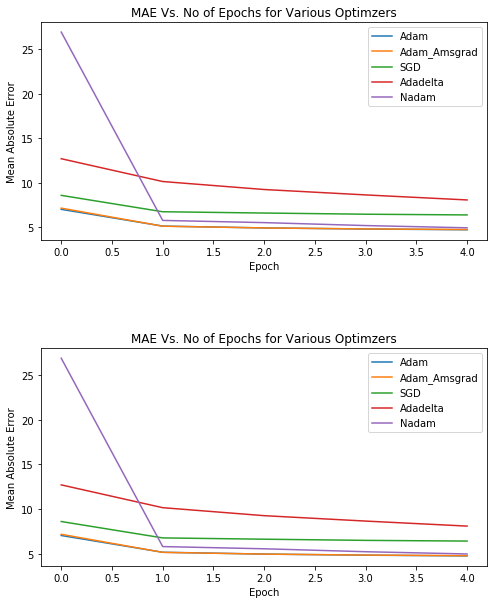

In [19]:
import matplotlib.pyplot as plt
def plot_history(history, history2, history3, history4, history5, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    axes[0].plot(history.history[metric])
    axes[0].plot(history2.history[metric])
    axes[0].plot(history3.history[metric])
    axes[0].plot(history4.history[metric])
    axes[0].plot(history5.history[metric])
    
    try:
      #axes[0].plot(history.history['val_'+metric])
      #axes[0].plot(history2.history['val2_'+metric])
      #axes[0].plot(history3.history['val3_'+metric])
      axes[0].legend(['Adam', 'Adam_Amsgrad', 'SGD', 'Adadelta', 'Nadam' ], loc='best')
    except:
      pass
    axes[0].set_title('MAE Vs. No of Epochs for Various Optimzers')
    axes[0].set_ylabel('Mean Absolute Error')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    axes[1].plot(history2.history['loss'])
    axes[1].plot(history3.history['loss'])
    axes[1].plot(history4.history['loss'])
    axes[1].plot(history5.history['loss'])
    try:
      #axes[1].plot(history.history['val_loss'])
      axes[1].legend(['Adam', 'Adam_Amsgrad', 'SGD', 'Adadelta', 'Nadam' ])
    except:
      pass
    axes[1].set_title('MAE Vs. No of Epochs for Various Optimzers')
    axes[1].set_ylabel('Mean Absolute Error')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_history(denoise_history_adam, denoise_history_adam_amsgrad, denoise_history_sgd, denoise_history_adadelta, denoise_history_nadam, 'mean_absolute_error')

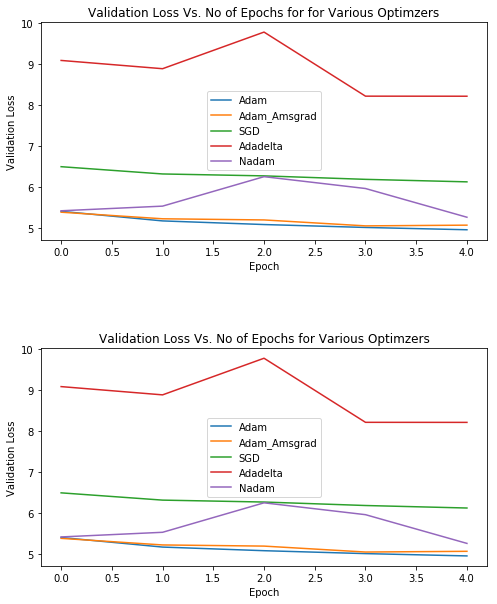

In [20]:
def plot_val_history(history, history2, history3, history4, history5, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    #axes[0].plot(history.history[metric])
    #axes[0].plot(history2.history[metric])
    #axes[0].plot(history3.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].plot(history2.history['val_'+metric])
      axes[0].plot(history3.history['val_'+metric])
      axes[0].plot(history4.history['val_'+metric])
      axes[0].plot(history5.history['val_'+metric])
      axes[0].legend(['Adam', 'Adam_Amsgrad', 'SGD', 'Adadelta', 'Nadam'])
    except:
      pass
    axes[0].set_title('Validation Loss Vs. No of Epochs for for Various Optimzers')
    axes[0].set_ylabel('Validation Loss')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    #axes[1].plot(history.history['loss'])
    #axes[1].plot(history2.history['loss'])
    #axes[1].plot(history3.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].plot(history2.history['val_loss'])
      axes[1].plot(history3.history['val_loss'])
      axes[1].plot(history4.history['val_loss'])
      axes[1].plot(history5.history['val_loss'])
      axes[1].legend(['Adam', 'Adam_Amsgrad', 'SGD', 'Adadelta', 'Nadam'])
    except:
      pass
    axes[1].set_title('Validation Loss Vs. No of Epochs for Various Optimzers')
    axes[1].set_ylabel('Validation Loss')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_val_history(denoise_history_adam, denoise_history_adam_amsgrad, denoise_history_sgd, denoise_history_adadelta, denoise_history_nadam, 'mean_absolute_error')

## Training a Descriptor Network
In the last section we trained a model that given a noisy patch, outputs a denoised version of it. We hoped that by doing so, we will improve the performance of the second part, which is training a network that outputs the descriptor. As we mentioned, a descriptor is a numerical vector that represents the small images we have. The dataset consists of a large number of small images, which are cropped patches from other larger images. Hence, they represent some local part of a scene. That is why there are no objects represented, only corners or textures. Each of these patches is related to a subset of other patches of the dataset by some kind of geometric transformation (e.g. rotation).  For a given patch, we want the network to output a vector that is close to the vectors of the patches that represent the same local part of a scene, while being far from patches do not represent that local part of a scene.

To do so, we will build a convolutional neural network that takes the input of $32\times32$ and outputs a descriptor of size $128$. For the loss, we use the triplet loss, which takes an anchor patch, a negative patch and a positive patch. The idea is to train the network so the descriptors from the anchor and positive patch have a low distance between them, and the negative and anchor patch have a large distance between them. 

In this cell we generate a triplet network, which is a network formed by three copies of the same network. That means that the descriptor model will compute the descriptor for the input `'a'` (anchor), the same descriptor model (with the same weights) will compute the descriptor for the input `'p'` (positive), and again the same model will compute the descriptor for the input `'n'` (negative). 

**Updated explanation**: Due to the way Keras handles the compile method, it needs a loss as an argument in that compile method. However, our loss is computed in the lambda layer, so we want to minimize the output of that layer. As we want to minimize the output of the Lambda function (in this case the triplet loss), we output as the label in the training_generator a vector of zeros and we compute the mean absolute error of the triplet loss and this vector of zeros. To give you an intuition, what we aim to minimize is
$$  |\text{triplet_loss} - 0| =  |\text{triplet_loss}| = \text{triplet_loss} $$



In [32]:
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Here we use the class HPatches, which loads the corresponding files by using the method `read_image_file`. It reads the patches. The output of read_image_file is a tuple of the form (images, labels), which is passed to the class `DataGeneratorDesc`. This class is a generator that creates batches of triplets, and each epoch is defined by the number of triplets in the argument `num_triplets`.

**Updated**: In the previous version of the baseline code, we were training the descriptor model with the noisy patches, not with the denoised ones. By adding the argument `denoise_model=denoise_model` to the class HPatches we can use the denoised images instead to train this descriptor model (if `denoise_model=None`, the noisy patches will be used). However, as it has to compute the denoised patch first, the loading of the data will be slower (6/7 extra min).  If you want to train the model with the clean patches instead, you can set the argument `use_clean=True`. In this last case, even if a denoise model is given, it will not be used. When running this piece of code **the type of patches (denoised, noisy or clean) used is printed**.

In [35]:
### Descriptor loading and training
# Loading images
hPatches_adam = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_adam, use_clean=False)
hPatches_adam_amsgrad = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_adam_amsgrad, use_clean=False)
hPatches_sgd = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_sgd, use_clean=False)
hPatches_adadelta = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_adadelta, use_clean=False)
hPatches_nadam = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_nadam, use_clean=False)

# Creating training generator
training_generator_adam = DataGeneratorDesc(*hPatches_adam.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_adam = DataGeneratorDesc(*hPatches_adam.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_adam_amsgrad = DataGeneratorDesc(*hPatches_adam_amsgrad.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_adam_amsgrad = DataGeneratorDesc(*hPatches_adam_amsgrad.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_sgd = DataGeneratorDesc(*hPatches_sgd.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_sgd = DataGeneratorDesc(*hPatches_sgd.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_adadelta = DataGeneratorDesc(*hPatches_adadelta.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_adadelta = DataGeneratorDesc(*hPatches_adadelta.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_nadam = DataGeneratorDesc(*hPatches_nadam.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_nadam = DataGeneratorDesc(*hPatches_nadam.read_image_file(hpatches_dir, train=0), num_triplets=10000)

Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:45<00:00,  2.55it/s]
Denoising patches...
100%|████████████████████████████████████████████████████████████████████████████| 15589/15589 [07:58<00:00, 32.57it/s]


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 60285.40it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:24<00:00,  5.50it/s]
Denoising patches...
100%|██████████████████████████████████████████████████████████████████████████████| 9525/9525 [04:48<00:00, 33.06it/s]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 31235.97it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:48<00:00,  2.41it/s]
Denoising patches...
100%|████████████████████████████████████████████████████████████████████████████| 15589/15589 [07:51<00:00, 33.04it/s]


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 45994.24it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:18<00:00,  5.57it/s]
Denoising patches...
100%|██████████████████████████████████████████████████████████████████████████████| 9525/9525 [04:48<00:00, 33.07it/s]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 39161.62it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:41<00:00,  2.80it/s]
Denoising patches...
100%|████████████████████████████████████████████████████████████████████████████| 15589/15589 [07:57<00:00, 32.68it/s]


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 48698.55it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:16<00:00,  5.54it/s]
Denoising patches...
100%|██████████████████████████████████████████████████████████████████████████████| 9525/9525 [04:43<00:00, 33.65it/s]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 42841.29it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:36<00:00,  3.20it/s]
Denoising patches...
100%|████████████████████████████████████████████████████████████████████████████| 15589/15589 [07:28<00:00, 34.79it/s]


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 59153.82it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:18<00:00,  2.91it/s]
Denoising patches...
100%|██████████████████████████████████████████████████████████████████████████████| 9525/9525 [04:27<00:00, 35.60it/s]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 50891.43it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:42<00:00,  2.75it/s]
Denoising patches...
100%|████████████████████████████████████████████████████████████████████████████| 15589/15589 [07:23<00:00, 35.19it/s]


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 59717.42it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:23<00:00,  1.99it/s]
Denoising patches...
100%|██████████████████████████████████████████████████████████████████████████████| 9525/9525 [04:25<00:00, 35.84it/s]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 45166.72it/s]


We plot a random triplet in the form of anchor, positive and negative sample. The positive and anchor patches are similar between them (the difference is a geometric transformation, for example rotation), whereas the negative sample should be quite dissimilar to any of the other two.

In [ ]:
plot_triplet(training_generator)

We now train the descriptor model and save the weights afterward.

In [36]:
#epochs = 1
### As with the denoising model, we use a loop to save for each epoch 
## #the weights in an external website in case colab stops. 
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)

### If you have a model saved from a previous training session
### Load it in the next line
# descriptor_model_trip.set_weights(keras.models.load_model('./descriptor.h5').get_weights())
# descriptor_model_trip.optimizer = keras.models.load_model('./descriptor.h5').optimizer

#for e in range(epochs):
  
descriptor_history_adam = descriptor_model_trip.fit_generator(generator=training_generator_adam, epochs=5, verbose=1, validation_data=val_generator_adam)
descriptor_model_trip.save('descriptor_adam.h5') 

descriptor_history_adam_amsgrad = descriptor_model_trip.fit_generator(generator=training_generator_adam_amsgrad, epochs=5, verbose=1, validation_data=val_generator_adam_amsgrad)
descriptor_model_trip.save('descriptor_adam_amsgrad.h5') 

descriptor_history_sgd = descriptor_model_trip.fit_generator(generator=training_generator_sgd, epochs=5, verbose=1, validation_data=val_generator_sgd)
descriptor_model_trip.save('descriptor_sgd.h5') 

descriptor_history_adadelta = descriptor_model_trip.fit_generator(generator=training_generator_adadelta, epochs=5, verbose=1, validation_data=val_generator_adadelta)
descriptor_model_trip.save('descriptor_adadelta.h5') 

descriptor_history_nadam = descriptor_model_trip.fit_generator(generator=training_generator_nadam, epochs=5, verbose=1, validation_data=val_generator_nadam)
descriptor_model_trip.save('descriptor_nadam.h5') 

### Saves optimizer and weights
#descriptor_model_trip.save('descriptor.h5') 
### Uploads files to external hosting
#!curl -F "file=@descriptor.h5" https://file.io


Epoch 1/5


 326/2000 [===>..........................] - ETA: 1:34:37 - loss: 0.85 - ETA: 32:26 - loss: 0.7431 - ETA: 24:46 - loss: 0.63 - ETA: 20:12 - loss: 0.65 - ETA: 17:07 - loss: 0.61 - ETA: 14:56 - loss: 0.62 - ETA: 13:17 - loss: 0.59 - ETA: 12:00 - loss: 0.59 - ETA: 10:59 - loss: 0.57 - ETA: 10:10 - loss: 0.57 - ETA: 9:28 - loss: 0.5507 - ETA: 8:53 - loss: 0.527 - ETA: 8:23 - loss: 0.526 - ETA: 7:56 - loss: 0.510 - ETA: 7:34 - loss: 0.505 - ETA: 7:13 - loss: 0.497 - ETA: 6:55 - loss: 0.482 - ETA: 6:38 - loss: 0.474 - ETA: 6:23 - loss: 0.476 - ETA: 6:10 - loss: 0.465 - ETA: 5:58 - loss: 0.456 - ETA: 5:47 - loss: 0.457 - ETA: 5:37 - loss: 0.455 - ETA: 5:27 - loss: 0.456 - ETA: 5:19 - loss: 0.449 - ETA: 5:11 - loss: 0.441 - ETA: 5:03 - loss: 0.446 - ETA: 4:56 - loss: 0.442 - ETA: 4:50 - loss: 0.441 - ETA: 4:44 - loss: 0.438 - ETA: 4:38 - loss: 0.438 - ETA: 4:33 - loss: 0.433 - ETA: 4:28 - loss: 0.429 - ETA: 4:23 - loss: 0.428 - ETA: 4:19 - loss: 0.426 - ETA: 4:15 - loss: 0.421 - ETA: 4:11 - lo

1491/2000 [=====================>........] - ETA: 50s - loss: 0.23 - ETA: 50s - loss: 0.23 - ETA: 50s - loss: 0.23 - ETA: 50s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.

1902/2000 [===========================>..] - ETA: 27s - loss: 0.22 - ETA: 27s - loss: 0.22 - ETA: 27s - loss: 0.21 - ETA: 27s - loss: 0.22 - ETA: 27s - loss: 0.21 - ETA: 27s - loss: 0.21 - ETA: 27s - loss: 0.21 - ETA: 27s - loss: 0.21 - ETA: 27s - loss: 0.21 - ETA: 27s - loss: 0.21 - ETA: 27s - loss: 0.21 - ETA: 27s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 24s - loss: 0.

1998/2000 [============================>.] - ETA: 5s - loss: 0.209 - ETA: 5s - loss: 0.209 - ETA: 5s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 2s - loss: 0.209 - ETA: 2s - loss: 0.209 - ETA: 2s - loss: 0.209 - ETA: 2s - loss: 0.209 - ETA: 2s - loss: 0.209 - ETA: 2s - loss: 0.2

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 49640.25it/s]


2000/2000 [==============================] - 113s 57ms/step - loss: 0.2080 - val_loss: 0.2323
Epoch 2/5
   3/2000 [..............................] - ETA: 1:29 - loss: 0.111 - ETA: 3:38 - loss: 0.183 - ETA: 5:00 - loss: 0.1737

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167542). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 5:40 - loss: 0.1620

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127646). Check your callbacks.
  % delta_t_median)


   7/2000 [..............................] - ETA: 5:34 - loss: 0.146 - ETA: 6:05 - loss: 0.145 - ETA: 5:34 - loss: 0.1740

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]



 22%|████████████████▎                                                          | 2180/10000 [00:00<00:02, 3736.44it/s]

   8/2000 [..............................] - ETA: 5:10 - loss: 0.1737

 62%|██████████████████████████████████████████████▌                            | 6213/10000 [00:00<00:00, 5133.61it/s]

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 12831.47it/s]

   9/2000 [..............................] - ETA: 7:12 - loss: 0.1678

 414/2000 [=====>........................] - ETA: 7:00 - loss: 0.167 - ETA: 6:06 - loss: 0.152 - ETA: 5:45 - loss: 0.154 - ETA: 5:28 - loss: 0.168 - ETA: 4:58 - loss: 0.159 - ETA: 4:46 - loss: 0.161 - ETA: 4:25 - loss: 0.162 - ETA: 4:17 - loss: 0.165 - ETA: 4:09 - loss: 0.167 - ETA: 3:55 - loss: 0.169 - ETA: 3:43 - loss: 0.162 - ETA: 3:38 - loss: 0.163 - ETA: 3:28 - loss: 0.155 - ETA: 3:25 - loss: 0.153 - ETA: 3:17 - loss: 0.149 - ETA: 3:14 - loss: 0.151 - ETA: 3:08 - loss: 0.150 - ETA: 3:05 - loss: 0.148 - ETA: 3:03 - loss: 0.147 - ETA: 3:01 - loss: 0.146 - ETA: 2:59 - loss: 0.145 - ETA: 2:57 - loss: 0.147 - ETA: 2:55 - loss: 0.146 - ETA: 2:53 - loss: 0.147 - ETA: 2:51 - loss: 0.146 - ETA: 2:49 - loss: 0.147 - ETA: 2:46 - loss: 0.146 - ETA: 2:44 - loss: 0.148 - ETA: 2:43 - loss: 0.146 - ETA: 2:42 - loss: 0.147 - ETA: 2:40 - loss: 0.147 - ETA: 2:37 - loss: 0.145 - ETA: 2:36 - loss: 0.145 - ETA: 2:35 - loss: 0.148 - ETA: 2:33 - loss: 0.147 - ETA: 2:30 - loss: 0.145 - ETA: 2:28 - loss: 0

 816/2000 [===========>..................] - ETA: 1:26 - loss: 0.163 - ETA: 1:26 - loss: 0.164 - ETA: 1:26 - loss: 0.163 - ETA: 1:26 - loss: 0.164 - ETA: 1:26 - loss: 0.164 - ETA: 1:25 - loss: 0.163 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.163 - ETA: 1:24 - loss: 0.163 - ETA: 1:24 - loss: 0.163 - ETA: 1:24 - loss: 0.163 - ETA: 1:24 - loss: 0.163 - ETA: 1:24 - loss: 0.162 - ETA: 1:24 - loss: 0.162 - ETA: 1:24 - loss: 0.162 - ETA: 1:24 - loss: 0.162 - ETA: 1:24 - loss: 0.162 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0.163 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0

1227/2000 [=================>............] - ETA: 1:02 - loss: 0.160 - ETA: 1:02 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 59s - loss: 0.160 - ETA: 59s - loss: 0.16 - ETA: 59s - loss: 0.16 - ETA: 59s - loss: 0.16 - ETA: 59s - loss: 0.16 - ETA: 59s - loss: 0.16 - ETA: 59s - loss: 0.16 - ETA: 59s - loss: 0.16 - ETA: 59s - loss: 0.16 - ETA: 59s -

1680/2000 [========================>.....] - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 37s - loss: 0.15 - ETA: 37s - loss: 0.15 - ETA: 37s - loss: 0.

1998/2000 [============================>.] - ETA: 16s - loss: 0.15 - ETA: 16s - loss: 0.15 - ETA: 16s - loss: 0.15 - ETA: 16s - loss: 0.15 - ETA: 16s - loss: 0.15 - ETA: 16s - loss: 0.15 - ETA: 16s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 46562.19it/s]


2000/2000 [==============================] - 110s 55ms/step - loss: 0.1534 - val_loss: 0.1658
Epoch 3/5
   2/2000 [..............................] - ETA: 6:28 - loss: 0.140 - ETA: 6:10 - loss: 0.1391

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107219). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:23 - loss: 0.1269

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107749). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 6:39 - loss: 0.114 - ETA: 7:36 - loss: 0.119 - ETA: 6:48 - loss: 0.1078

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103210). Check your callbacks.
  % delta_t_median)
  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 40%|█████████████████████████████▍                                            | 3973/10000 [00:00<00:00, 39428.66it/s]

   7/2000 [..............................] - ETA: 6:13 - loss: 0.1043

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106689). Check your callbacks.
  % delta_t_median)
 78%|█████████████████████████████████████████████████████████▋                | 7799/10000 [00:00<00:00, 38983.43it/s]



100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 37136.14it/s]

   8/2000 [..............................] - ETA: 6:20 - loss: 0.1025

 404/2000 [=====>........................] - ETA: 6:04 - loss: 0.097 - ETA: 5:38 - loss: 0.106 - ETA: 5:17 - loss: 0.101 - ETA: 5:00 - loss: 0.094 - ETA: 4:45 - loss: 0.097 - ETA: 4:34 - loss: 0.092 - ETA: 4:22 - loss: 0.092 - ETA: 4:12 - loss: 0.093 - ETA: 4:03 - loss: 0.095 - ETA: 3:56 - loss: 0.096 - ETA: 3:49 - loss: 0.094 - ETA: 3:43 - loss: 0.096 - ETA: 3:37 - loss: 0.094 - ETA: 3:33 - loss: 0.100 - ETA: 3:28 - loss: 0.105 - ETA: 3:24 - loss: 0.106 - ETA: 3:20 - loss: 0.111 - ETA: 3:17 - loss: 0.109 - ETA: 3:13 - loss: 0.109 - ETA: 3:10 - loss: 0.112 - ETA: 3:07 - loss: 0.112 - ETA: 3:05 - loss: 0.113 - ETA: 3:02 - loss: 0.116 - ETA: 3:00 - loss: 0.115 - ETA: 2:58 - loss: 0.119 - ETA: 2:56 - loss: 0.121 - ETA: 2:54 - loss: 0.122 - ETA: 2:52 - loss: 0.120 - ETA: 2:50 - loss: 0.122 - ETA: 2:48 - loss: 0.122 - ETA: 2:44 - loss: 0.123 - ETA: 2:43 - loss: 0.124 - ETA: 2:39 - loss: 0.126 - ETA: 2:38 - loss: 0.127 - ETA: 2:37 - loss: 0.127 - ETA: 2:36 - loss: 0.128 - ETA: 2:34 - loss: 0

 824/2000 [===========>..................] - ETA: 1:26 - loss: 0.134 - ETA: 1:26 - loss: 0.134 - ETA: 1:26 - loss: 0.134 - ETA: 1:26 - loss: 0.134 - ETA: 1:26 - loss: 0.134 - ETA: 1:26 - loss: 0.134 - ETA: 1:25 - loss: 0.134 - ETA: 1:25 - loss: 0.134 - ETA: 1:25 - loss: 0.134 - ETA: 1:25 - loss: 0.134 - ETA: 1:25 - loss: 0.134 - ETA: 1:25 - loss: 0.134 - ETA: 1:25 - loss: 0.134 - ETA: 1:24 - loss: 0.134 - ETA: 1:24 - loss: 0.134 - ETA: 1:24 - loss: 0.134 - ETA: 1:24 - loss: 0.134 - ETA: 1:24 - loss: 0.134 - ETA: 1:24 - loss: 0.133 - ETA: 1:24 - loss: 0.133 - ETA: 1:23 - loss: 0.133 - ETA: 1:23 - loss: 0.133 - ETA: 1:23 - loss: 0.133 - ETA: 1:23 - loss: 0.134 - ETA: 1:23 - loss: 0.134 - ETA: 1:23 - loss: 0.134 - ETA: 1:23 - loss: 0.135 - ETA: 1:23 - loss: 0.135 - ETA: 1:23 - loss: 0.135 - ETA: 1:23 - loss: 0.135 - ETA: 1:22 - loss: 0.135 - ETA: 1:22 - loss: 0.135 - ETA: 1:22 - loss: 0.135 - ETA: 1:22 - loss: 0.135 - ETA: 1:22 - loss: 0.135 - ETA: 1:22 - loss: 0.135 - ETA: 1:22 - loss: 0

1269/2000 [==================>...........] - ETA: 1:01 - loss: 0.138 - ETA: 1:01 - loss: 0.138 - ETA: 1:01 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 59s - loss: 0.138 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 57s - los

1702/2000 [========================>.....] - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 35s - loss: 0.13 - ETA: 35s - loss: 0.13 - ETA: 35s - loss: 0.13 - ETA: 35s - loss: 0.13 - ETA: 35s - loss: 0.13 - ETA: 35s - loss: 0.13 - ETA: 35s - loss: 0.

1998/2000 [============================>.] - ETA: 15s - loss: 0.13 - ETA: 15s - loss: 0.13 - ETA: 15s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 47813.04it/s]


2000/2000 [==============================] - 109s 55ms/step - loss: 0.1342 - val_loss: 0.1869
Epoch 4/5
   6/2000 [..............................] - ETA: 5:28 - loss: 0.066 - ETA: 5:39 - loss: 0.072 - ETA: 5:18 - loss: 0.110 - ETA: 5:29 - loss: 0.089 - ETA: 5:12 - loss: 0.094 - ETA: 5:52 - loss: 0.0850

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 5:25 - loss: 0.0850

 36%|██████████████████████████▌                                               | 3593/10000 [00:00<00:00, 35652.16it/s]



 72%|████████████████████████████████████████████████████▉                     | 7160/10000 [00:00<00:00, 35580.57it/s]

   8/2000 [..............................] - ETA: 5:31 - loss: 0.0905

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 33413.67it/s]



 395/2000 [====>.........................] - ETA: 5:15 - loss: 0.089 - ETA: 5:06 - loss: 0.103 - ETA: 4:48 - loss: 0.105 - ETA: 4:18 - loss: 0.119 - ETA: 4:07 - loss: 0.130 - ETA: 3:58 - loss: 0.132 - ETA: 3:40 - loss: 0.134 - ETA: 3:33 - loss: 0.130 - ETA: 3:27 - loss: 0.126 - ETA: 3:22 - loss: 0.127 - ETA: 3:18 - loss: 0.126 - ETA: 3:14 - loss: 0.125 - ETA: 3:11 - loss: 0.125 - ETA: 3:07 - loss: 0.125 - ETA: 3:05 - loss: 0.129 - ETA: 3:02 - loss: 0.126 - ETA: 2:59 - loss: 0.125 - ETA: 2:56 - loss: 0.125 - ETA: 2:54 - loss: 0.124 - ETA: 2:53 - loss: 0.122 - ETA: 2:51 - loss: 0.121 - ETA: 2:49 - loss: 0.118 - ETA: 2:47 - loss: 0.121 - ETA: 2:45 - loss: 0.121 - ETA: 2:44 - loss: 0.121 - ETA: 2:42 - loss: 0.124 - ETA: 2:41 - loss: 0.124 - ETA: 2:39 - loss: 0.122 - ETA: 2:38 - loss: 0.123 - ETA: 2:36 - loss: 0.123 - ETA: 2:35 - loss: 0.124 - ETA: 2:34 - loss: 0.126 - ETA: 2:33 - loss: 0.128 - ETA: 2:32 - loss: 0.127 - ETA: 2:31 - loss: 0.131 - ETA: 2:30 - loss: 0.129 - ETA: 2:29 - loss: 0

 824/2000 [===========>..................] - ETA: 1:25 - loss: 0.126 - ETA: 1:25 - loss: 0.126 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.127 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.128 - ETA: 1:23 - loss: 0.128 - ETA: 1:23 - loss: 0.128 - ETA: 1:23 - loss: 0.128 - ETA: 1:23 - loss: 0.128 - ETA: 1:23 - loss: 0.128 - ETA: 1:23 - loss: 0.128 - ETA: 1:23 - loss: 0

1285/2000 [==================>...........] - ETA: 1:00 - loss: 0.128 - ETA: 1:00 - loss: 0.128 - ETA: 1:00 - loss: 0.128 - ETA: 1:00 - loss: 0.128 - ETA: 1:00 - loss: 0.128 - ETA: 1:00 - loss: 0.128 - ETA: 1:00 - loss: 0.128 - ETA: 59s - loss: 0.128 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA:

1723/2000 [========================>.....] - ETA: 36s - loss: 0.12 - ETA: 36s - loss: 0.12 - ETA: 36s - loss: 0.12 - ETA: 36s - loss: 0.12 - ETA: 36s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 33s - loss: 0.12 - ETA: 33s - loss: 0.

1999/2000 [============================>.] - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 35150.36it/s]


2000/2000 [==============================] - 108s 54ms/step - loss: 0.1255 - val_loss: 0.1984
Epoch 5/5
   5/2000 [..............................] - ETA: 6:08 - loss: 0.116 - ETA: 5:38 - loss: 0.162 - ETA: 5:12 - loss: 0.145 - ETA: 5:21 - loss: 0.144 - ETA: 5:25 - loss: 0.1459

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102684). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 5:53 - loss: 0.1400

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 5:24 - loss: 0.1550

 70%|███████████████████████████████████████████████████▊                      | 6994/10000 [00:00<00:00, 35069.89it/s]

   8/2000 [..............................] - ETA: 5:25 - loss: 0.1381

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 34574.26it/s]


 427/2000 [=====>........................] - ETA: 5:15 - loss: 0.142 - ETA: 5:02 - loss: 0.154 - ETA: 4:45 - loss: 0.142 - ETA: 4:14 - loss: 0.133 - ETA: 4:04 - loss: 0.144 - ETA: 3:54 - loss: 0.146 - ETA: 3:46 - loss: 0.142 - ETA: 3:39 - loss: 0.139 - ETA: 3:32 - loss: 0.138 - ETA: 3:26 - loss: 0.140 - ETA: 3:14 - loss: 0.129 - ETA: 3:10 - loss: 0.127 - ETA: 3:07 - loss: 0.127 - ETA: 3:03 - loss: 0.141 - ETA: 2:55 - loss: 0.145 - ETA: 2:53 - loss: 0.141 - ETA: 2:50 - loss: 0.142 - ETA: 2:48 - loss: 0.138 - ETA: 2:42 - loss: 0.135 - ETA: 2:38 - loss: 0.133 - ETA: 2:33 - loss: 0.137 - ETA: 2:30 - loss: 0.137 - ETA: 2:28 - loss: 0.138 - ETA: 2:27 - loss: 0.137 - ETA: 2:24 - loss: 0.139 - ETA: 2:21 - loss: 0.141 - ETA: 2:20 - loss: 0.140 - ETA: 2:18 - loss: 0.137 - ETA: 2:17 - loss: 0.137 - ETA: 2:15 - loss: 0.137 - ETA: 2:13 - loss: 0.135 - ETA: 2:11 - loss: 0.132 - ETA: 2:10 - loss: 0.132 - ETA: 2:08 - loss: 0.132 - ETA: 2:08 - loss: 0.130 - ETA: 2:06 - loss: 0.130 - ETA: 2:05 - loss: 0

 831/2000 [===========>..................] - ETA: 1:21 - loss: 0.124 - ETA: 1:21 - loss: 0.124 - ETA: 1:21 - loss: 0.124 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0

1291/2000 [==================>...........] - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 56s - loss: 0.12 - ETA: 56s - loss: 0.12 - ETA: 56s - loss: 0.12 - ETA: 56s - loss: 0.12 - ETA: 56s - loss: 0.12 - ETA: 56s - loss: 0.12 - ETA: 56s - loss: 0.

1756/2000 [=========================>....] - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 32s - loss: 0.11 - ETA: 32s - loss: 0.11 - ETA: 32s - loss: 0.11 - ETA: 32s - loss: 0.11 - ETA: 32s - loss: 0.11 - ETA: 32s - loss: 0.11 - ETA: 32s - loss: 0.11 - ETA: 32s - loss: 0.

1999/2000 [============================>.] - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1179 - ETA: 9s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 40187.37it/s]


2000/2000 [==============================] - 107s 53ms/step - loss: 0.1174 - val_loss: 0.1594
Epoch 1/5


 413/2000 [=====>........................] - ETA: 2:11 - loss: 0.186 - ETA: 2:05 - loss: 0.118 - ETA: 2:06 - loss: 0.110 - ETA: 1:53 - loss: 0.104 - ETA: 1:51 - loss: 0.095 - ETA: 1:50 - loss: 0.097 - ETA: 1:45 - loss: 0.096 - ETA: 1:45 - loss: 0.092 - ETA: 1:45 - loss: 0.104 - ETA: 1:44 - loss: 0.094 - ETA: 1:43 - loss: 0.096 - ETA: 1:43 - loss: 0.094 - ETA: 1:42 - loss: 0.105 - ETA: 1:42 - loss: 0.105 - ETA: 1:42 - loss: 0.104 - ETA: 1:42 - loss: 0.110 - ETA: 1:41 - loss: 0.105 - ETA: 1:41 - loss: 0.104 - ETA: 1:41 - loss: 0.111 - ETA: 1:41 - loss: 0.114 - ETA: 1:40 - loss: 0.113 - ETA: 1:40 - loss: 0.111 - ETA: 1:40 - loss: 0.109 - ETA: 1:40 - loss: 0.108 - ETA: 1:41 - loss: 0.109 - ETA: 1:40 - loss: 0.112 - ETA: 1:39 - loss: 0.116 - ETA: 1:40 - loss: 0.114 - ETA: 1:40 - loss: 0.116 - ETA: 1:40 - loss: 0.117 - ETA: 1:40 - loss: 0.115 - ETA: 1:40 - loss: 0.113 - ETA: 1:41 - loss: 0.112 - ETA: 1:40 - loss: 0.115 - ETA: 1:40 - loss: 0.115 - ETA: 1:39 - loss: 0.118 - ETA: 1:39 - loss: 0

1723/2000 [========================>.....] - ETA: 37s - loss: 0.11 - ETA: 37s - loss: 0.11 - ETA: 37s - loss: 0.11 - ETA: 37s - loss: 0.11 - ETA: 37s - loss: 0.11 - ETA: 37s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.

1999/2000 [============================>.] - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 35337.73it/s]


2000/2000 [==============================] - 108s 54ms/step - loss: 0.1152 - val_loss: 0.1518
Epoch 2/5
   7/2000 [..............................] - ETA: 5:36 - loss: 0.134 - ETA: 6:02 - loss: 0.088 - ETA: 5:28 - loss: 0.085 - ETA: 5:26 - loss: 0.105 - ETA: 5:23 - loss: 0.108 - ETA: 6:11 - loss: 0.124 - ETA: 5:36 - loss: 0.1268

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   8/2000 [..............................] - ETA: 5:15 - loss: 0.1402

 37%|███████████████████████████▎                                              | 3684/10000 [00:00<00:00, 36560.58it/s]

   9/2000 [..............................] - ETA: 5:04 - loss: 0.1350

 70%|███████████████████████████████████████████████████▌                      | 6969/10000 [00:00<00:00, 35277.92it/s]



100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 34811.32it/s]

  10/2000 [..............................]

 415/2000 [=====>........................] - ETA: 4:54 - loss: 0.137 - ETA: 4:39 - loss: 0.134 - ETA: 4:25 - loss: 0.133 - ETA: 4:01 - loss: 0.124 - ETA: 3:44 - loss: 0.123 - ETA: 3:30 - loss: 0.128 - ETA: 3:19 - loss: 0.125 - ETA: 3:09 - loss: 0.122 - ETA: 3:05 - loss: 0.122 - ETA: 3:02 - loss: 0.117 - ETA: 2:59 - loss: 0.118 - ETA: 2:56 - loss: 0.114 - ETA: 2:50 - loss: 0.112 - ETA: 2:44 - loss: 0.114 - ETA: 2:42 - loss: 0.114 - ETA: 2:40 - loss: 0.114 - ETA: 2:39 - loss: 0.113 - ETA: 2:35 - loss: 0.114 - ETA: 2:34 - loss: 0.113 - ETA: 2:32 - loss: 0.113 - ETA: 2:31 - loss: 0.112 - ETA: 2:30 - loss: 0.111 - ETA: 2:27 - loss: 0.110 - ETA: 2:26 - loss: 0.111 - ETA: 2:25 - loss: 0.109 - ETA: 2:24 - loss: 0.108 - ETA: 2:21 - loss: 0.107 - ETA: 2:19 - loss: 0.109 - ETA: 2:18 - loss: 0.108 - ETA: 2:18 - loss: 0.107 - ETA: 2:16 - loss: 0.110 - ETA: 2:14 - loss: 0.113 - ETA: 2:13 - loss: 0.113 - ETA: 2:13 - loss: 0.111 - ETA: 2:12 - loss: 0.112 - ETA: 2:11 - loss: 0.112 - ETA: 2:09 - loss: 0

 837/2000 [===========>..................] - ETA: 1:23 - loss: 0.113 - ETA: 1:23 - loss: 0.113 - ETA: 1:23 - loss: 0.113 - ETA: 1:23 - loss: 0.113 - ETA: 1:23 - loss: 0.113 - ETA: 1:23 - loss: 0.113 - ETA: 1:23 - loss: 0.113 - ETA: 1:23 - loss: 0.114 - ETA: 1:23 - loss: 0.114 - ETA: 1:23 - loss: 0.114 - ETA: 1:23 - loss: 0.114 - ETA: 1:22 - loss: 0.114 - ETA: 1:22 - loss: 0.114 - ETA: 1:22 - loss: 0.114 - ETA: 1:22 - loss: 0.114 - ETA: 1:22 - loss: 0.114 - ETA: 1:22 - loss: 0.114 - ETA: 1:22 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:20 - loss: 0.114 - ETA: 1:20 - loss: 0.114 - ETA: 1:20 - loss: 0.114 - ETA: 1:20 - loss: 0.114 - ETA: 1:20 - loss: 0.114 - ETA: 1:20 - loss: 0

1278/2000 [==================>...........] - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - loss: 0.

1750/2000 [=========================>....] - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.

1998/2000 [============================>.] - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1105 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 45385.43it/s]


2000/2000 [==============================] - 108s 54ms/step - loss: 0.1106 - val_loss: 0.1332
Epoch 3/5
   2/2000 [..............................] - ETA: 5:46 - loss: 0.078 - ETA: 5:45 - loss: 0.0431

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101377). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 11:21 - loss: 0.05 - ETA: 10:02 - loss: 0.0562

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112241). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 10:07 - loss: 0.0669

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102775). Check your callbacks.
  % delta_t_median)
  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 8:49 - loss: 0.0590 

 42%|██████████████████████████████▉                                           | 4177/10000 [00:00<00:00, 41467.61it/s]



 71%|████████████████████████████████████████████████████▊                     | 7138/10000 [00:00<00:00, 36914.11it/s]

   7/2000 [..............................] - ETA: 8:17 - loss: 0.057

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 33311.42it/s]


 401/2000 [=====>........................] - ETA: 7:44 - loss: 0.090 - ETA: 7:18 - loss: 0.096 - ETA: 6:46 - loss: 0.092 - ETA: 6:22 - loss: 0.099 - ETA: 5:59 - loss: 0.103 - ETA: 5:39 - loss: 0.102 - ETA: 5:23 - loss: 0.101 - ETA: 5:10 - loss: 0.100 - ETA: 4:59 - loss: 0.117 - ETA: 4:48 - loss: 0.116 - ETA: 4:37 - loss: 0.114 - ETA: 4:29 - loss: 0.115 - ETA: 4:20 - loss: 0.112 - ETA: 4:13 - loss: 0.108 - ETA: 4:07 - loss: 0.105 - ETA: 4:01 - loss: 0.102 - ETA: 3:56 - loss: 0.099 - ETA: 3:51 - loss: 0.098 - ETA: 3:46 - loss: 0.098 - ETA: 3:42 - loss: 0.102 - ETA: 3:37 - loss: 0.103 - ETA: 3:34 - loss: 0.103 - ETA: 3:30 - loss: 0.100 - ETA: 3:26 - loss: 0.100 - ETA: 3:19 - loss: 0.102 - ETA: 3:16 - loss: 0.102 - ETA: 3:14 - loss: 0.101 - ETA: 3:11 - loss: 0.102 - ETA: 3:08 - loss: 0.101 - ETA: 3:06 - loss: 0.099 - ETA: 3:04 - loss: 0.103 - ETA: 3:02 - loss: 0.102 - ETA: 3:00 - loss: 0.104 - ETA: 2:58 - loss: 0.103 - ETA: 2:57 - loss: 0.103 - ETA: 2:55 - loss: 0.105 - ETA: 2:53 - loss: 0

 818/2000 [===========>..................] - ETA: 1:27 - loss: 0.102 - ETA: 1:27 - loss: 0.102 - ETA: 1:27 - loss: 0.102 - ETA: 1:27 - loss: 0.102 - ETA: 1:27 - loss: 0.102 - ETA: 1:27 - loss: 0.101 - ETA: 1:27 - loss: 0.102 - ETA: 1:26 - loss: 0.101 - ETA: 1:26 - loss: 0.101 - ETA: 1:26 - loss: 0.102 - ETA: 1:26 - loss: 0.102 - ETA: 1:26 - loss: 0.102 - ETA: 1:26 - loss: 0.102 - ETA: 1:26 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.102 - ETA: 1:25 - loss: 0.102 - ETA: 1:25 - loss: 0.102 - ETA: 1:25 - loss: 0.102 - ETA: 1:25 - loss: 0.103 - ETA: 1:25 - loss: 0.102 - ETA: 1:25 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:23 - loss: 0.103 - ETA: 1:23 - loss: 0.104 - ETA: 1:23 - loss: 0

1268/2000 [==================>...........] - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 59s - loss: 0.106 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - 

1706/2000 [========================>.....] - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.

1999/2000 [============================>.] - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 43787.49it/s]


2000/2000 [==============================] - 109s 54ms/step - loss: 0.1063 - val_loss: 0.1513
Epoch 4/5
   2/2000 [..............................] - ETA: 6:00 - loss: 0.113 - ETA: 5:30 - loss: 0.0714

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102995). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:04 - loss: 0.0509

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121674). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:20 - loss: 0.0731

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128942). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 6:53 - loss: 0.0665

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 33%|████████████████████████▊                                                 | 3347/10000 [00:00<00:00, 33229.82it/s]

   6/2000 [..............................] - ETA: 6:15 - loss: 0.0582

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123671). Check your callbacks.
  % delta_t_median)
 71%|████████████████████████████████████████████████████▏                     | 7057/10000 [00:00<00:00, 34229.79it/s]



100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 35177.35it/s]

   7/2000 [..............................] - ETA: 6:25 - loss: 0.0756

 417/2000 [=====>........................] - ETA: 6:04 - loss: 0.088 - ETA: 5:35 - loss: 0.094 - ETA: 4:49 - loss: 0.099 - ETA: 4:34 - loss: 0.098 - ETA: 4:21 - loss: 0.101 - ETA: 3:58 - loss: 0.095 - ETA: 3:49 - loss: 0.095 - ETA: 3:42 - loss: 0.093 - ETA: 3:27 - loss: 0.090 - ETA: 3:22 - loss: 0.090 - ETA: 3:17 - loss: 0.091 - ETA: 3:13 - loss: 0.091 - ETA: 3:08 - loss: 0.090 - ETA: 3:00 - loss: 0.086 - ETA: 2:54 - loss: 0.088 - ETA: 2:51 - loss: 0.088 - ETA: 2:46 - loss: 0.093 - ETA: 2:41 - loss: 0.092 - ETA: 2:36 - loss: 0.097 - ETA: 2:32 - loss: 0.097 - ETA: 2:29 - loss: 0.099 - ETA: 2:25 - loss: 0.096 - ETA: 2:24 - loss: 0.096 - ETA: 2:21 - loss: 0.100 - ETA: 2:19 - loss: 0.098 - ETA: 2:18 - loss: 0.098 - ETA: 2:16 - loss: 0.097 - ETA: 2:14 - loss: 0.098 - ETA: 2:13 - loss: 0.098 - ETA: 2:12 - loss: 0.097 - ETA: 2:12 - loss: 0.096 - ETA: 2:10 - loss: 0.094 - ETA: 2:09 - loss: 0.093 - ETA: 2:07 - loss: 0.093 - ETA: 2:07 - loss: 0.091 - ETA: 2:06 - loss: 0.092 - ETA: 2:04 - loss: 0

 825/2000 [===========>..................] - ETA: 1:23 - loss: 0.103 - ETA: 1:23 - loss: 0.103 - ETA: 1:23 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.103 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0

1289/2000 [==================>...........] - ETA: 1:00 - loss: 0.103 - ETA: 1:00 - loss: 0.103 - ETA: 1:00 - loss: 0.103 - ETA: 59s - loss: 0.103 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - l

1732/2000 [========================>.....] - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.

1999/2000 [============================>.] - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 41314.61it/s]


2000/2000 [==============================] - 108s 54ms/step - loss: 0.1040 - val_loss: 0.1250
Epoch 5/5
   1/2000 [..............................] - ETA: 1:23 - loss: 0.0421

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189926). Check your callbacks.
  % delta_t_median)


   2/2000 [..............................] - ETA: 4:58 - loss: 0.0744

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158916). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:12 - loss: 0.0776

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127905). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 6:13 - loss: 0.078 - ETA: 6:56 - loss: 0.0778

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]



 38%|████████████████████████████▎                                             | 3819/10000 [00:00<00:00, 37900.16it/s]

   6/2000 [..............................] - ETA: 6:09 - loss: 0.0959

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147237). Check your callbacks.
  % delta_t_median)
 79%|██████████████████████████████████████████████████████████▌               | 7914/10000 [00:00<00:00, 38686.36it/s]



100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 37694.26it/s]

   7/2000 [..............................]

   8/2000 [..............................] - ETA: 6:06 - loss: 0.0883

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106340). Check your callbacks.
  % delta_t_median)


 420/2000 [=====>........................] - ETA: 5:38 - loss: 0.081 - ETA: 5:16 - loss: 0.084 - ETA: 4:57 - loss: 0.096 - ETA: 4:41 - loss: 0.096 - ETA: 4:27 - loss: 0.095 - ETA: 4:03 - loss: 0.100 - ETA: 3:54 - loss: 0.096 - ETA: 3:47 - loss: 0.098 - ETA: 3:33 - loss: 0.091 - ETA: 3:21 - loss: 0.088 - ETA: 3:17 - loss: 0.092 - ETA: 3:08 - loss: 0.087 - ETA: 3:04 - loss: 0.088 - ETA: 2:57 - loss: 0.089 - ETA: 2:51 - loss: 0.091 - ETA: 2:48 - loss: 0.090 - ETA: 2:46 - loss: 0.090 - ETA: 2:41 - loss: 0.085 - ETA: 2:39 - loss: 0.086 - ETA: 2:38 - loss: 0.087 - ETA: 2:37 - loss: 0.086 - ETA: 2:33 - loss: 0.094 - ETA: 2:29 - loss: 0.094 - ETA: 2:27 - loss: 0.095 - ETA: 2:24 - loss: 0.099 - ETA: 2:23 - loss: 0.099 - ETA: 2:22 - loss: 0.097 - ETA: 2:21 - loss: 0.099 - ETA: 2:18 - loss: 0.096 - ETA: 2:18 - loss: 0.099 - ETA: 2:17 - loss: 0.099 - ETA: 2:15 - loss: 0.099 - ETA: 2:14 - loss: 0.100 - ETA: 2:14 - loss: 0.100 - ETA: 2:12 - loss: 0.102 - ETA: 2:10 - loss: 0.100 - ETA: 2:09 - loss: 0

 820/2000 [===========>..................] - ETA: 1:23 - loss: 0.104 - ETA: 1:23 - loss: 0.104 - ETA: 1:23 - loss: 0.104 - ETA: 1:23 - loss: 0.104 - ETA: 1:23 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.104 - ETA: 1:20 - loss: 0.103 - ETA: 1:20 - loss: 0.103 - ETA: 1:20 - loss: 0.103 - ETA: 1:20 - loss: 0.104 - ETA: 1:20 - loss: 0.104 - ETA: 1:20 - loss: 0.104 - ETA: 1:20 - loss: 0.104 - ETA: 1:20 - loss: 0.104 - ETA: 1:20 - loss: 0.104 - ETA: 1:20 - loss: 0

1272/2000 [==================>...........] - ETA: 1:01 - loss: 0.102 - ETA: 1:01 - loss: 0.102 - ETA: 1:01 - loss: 0.102 - ETA: 1:01 - loss: 0.102 - ETA: 1:01 - loss: 0.102 - ETA: 1:01 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 59s - loss: 0.102 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - los

1716/2000 [========================>.....] - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.

1999/2000 [============================>.] - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 33977.13it/s]


2000/2000 [==============================] - 109s 54ms/step - loss: 0.1013 - val_loss: 0.1515
Epoch 1/5


 400/2000 [=====>........................] - ETA: 1:51 - loss: 0.203 - ETA: 1:51 - loss: 0.133 - ETA: 1:56 - loss: 0.173 - ETA: 1:52 - loss: 0.161 - ETA: 1:44 - loss: 0.148 - ETA: 1:41 - loss: 0.129 - ETA: 1:43 - loss: 0.137 - ETA: 1:43 - loss: 0.131 - ETA: 1:45 - loss: 0.134 - ETA: 1:45 - loss: 0.129 - ETA: 1:44 - loss: 0.123 - ETA: 1:44 - loss: 0.119 - ETA: 1:43 - loss: 0.123 - ETA: 1:42 - loss: 0.116 - ETA: 1:41 - loss: 0.117 - ETA: 1:41 - loss: 0.114 - ETA: 1:40 - loss: 0.115 - ETA: 1:40 - loss: 0.117 - ETA: 1:41 - loss: 0.119 - ETA: 1:41 - loss: 0.117 - ETA: 1:41 - loss: 0.120 - ETA: 1:40 - loss: 0.118 - ETA: 1:40 - loss: 0.117 - ETA: 1:40 - loss: 0.118 - ETA: 1:40 - loss: 0.116 - ETA: 1:39 - loss: 0.118 - ETA: 1:39 - loss: 0.117 - ETA: 1:39 - loss: 0.118 - ETA: 1:39 - loss: 0.117 - ETA: 1:39 - loss: 0.115 - ETA: 1:39 - loss: 0.114 - ETA: 1:39 - loss: 0.112 - ETA: 1:39 - loss: 0.113 - ETA: 1:39 - loss: 0.114 - ETA: 1:39 - loss: 0.115 - ETA: 1:39 - loss: 0.118 - ETA: 1:39 - loss: 0

1656/2000 [=======================>......] - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.

1998/2000 [============================>.] - ETA: 17s - loss: 0.10 - ETA: 17s - loss: 0.10 - ETA: 17s - loss: 0.10 - ETA: 17s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 54401.27it/s]


2000/2000 [==============================] - 107s 54ms/step - loss: 0.1032 - val_loss: 0.1689
Epoch 2/5
   2/2000 [..............................] - ETA: 5:34 - loss: 0.063 - ETA: 5:11 - loss: 0.1023

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114210). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 5:52 - loss: 0.102 - ETA: 5:28 - loss: 0.105 - ETA: 5:27 - loss: 0.089 - ETA: 5:55 - loss: 0.103

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 5:26 - loss: 0.1104

 36%|██████████████████████████▌                                               | 3589/10000 [00:00<00:00, 35618.88it/s]

 67%|█████████████████████████████████████████████████▉                        | 6743/10000 [00:00<00:00, 34210.59it/s]

   9/2000 [..............................] - ETA: 5:24 - loss: 0.105

 96%|███████████████████████████████████████████████████████████████████████▍  | 9650/10000 [00:00<00:00, 32407.41it/s]

 - ETA: 5:18 - loss: 0.1004

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 31531.19it/s]


 412/2000 [=====>........................] - ETA: 5:07 - loss: 0.098 - ETA: 4:51 - loss: 0.100 - ETA: 4:37 - loss: 0.093 - ETA: 4:25 - loss: 0.094 - ETA: 4:13 - loss: 0.092 - ETA: 4:03 - loss: 0.090 - ETA: 3:55 - loss: 0.096 - ETA: 3:48 - loss: 0.091 - ETA: 3:41 - loss: 0.095 - ETA: 3:35 - loss: 0.096 - ETA: 3:29 - loss: 0.094 - ETA: 3:24 - loss: 0.098 - ETA: 3:20 - loss: 0.096 - ETA: 3:16 - loss: 0.094 - ETA: 3:12 - loss: 0.091 - ETA: 3:09 - loss: 0.092 - ETA: 3:06 - loss: 0.092 - ETA: 3:03 - loss: 0.094 - ETA: 3:00 - loss: 0.095 - ETA: 2:58 - loss: 0.093 - ETA: 2:55 - loss: 0.096 - ETA: 2:53 - loss: 0.099 - ETA: 2:51 - loss: 0.102 - ETA: 2:48 - loss: 0.104 - ETA: 2:47 - loss: 0.106 - ETA: 2:45 - loss: 0.104 - ETA: 2:43 - loss: 0.105 - ETA: 2:42 - loss: 0.105 - ETA: 2:38 - loss: 0.105 - ETA: 2:37 - loss: 0.103 - ETA: 2:36 - loss: 0.102 - ETA: 2:34 - loss: 0.103 - ETA: 2:33 - loss: 0.104 - ETA: 2:33 - loss: 0.103 - ETA: 2:30 - loss: 0.104 - ETA: 2:27 - loss: 0.102 - ETA: 2:27 - loss: 0

 839/2000 [===========>..................] - ETA: 1:24 - loss: 0.098 - ETA: 1:23 - loss: 0.098 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.098 - ETA: 1:23 - loss: 0.098 - ETA: 1:23 - loss: 0.098 - ETA: 1:23 - loss: 0.098 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.098 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.098 - ETA: 1:22 - loss: 0.098 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.096 - ETA: 1:22 - loss: 0.097 - ETA: 1:21 - loss: 0.097 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.097 - ETA: 1:20 - loss: 0.097 - ETA: 1:20 - loss: 0.096 - ETA: 1:20 - loss: 0.096 - ETA: 1:20 - loss: 0.096 - ETA: 1:20 - loss: 0.096 - ETA: 1:20 - loss: 0.096 - ETA: 1:20 - loss: 0.096 - ETA: 1:20 - loss: 0

1293/2000 [==================>...........] - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.09 - ETA: 59s - loss: 0.09 - ETA: 59s - loss: 0.09 - ETA: 59s - loss: 0.09 - ETA: 59s - loss: 0.09 - ETA: 58s - loss: 0.09 - ETA: 58s - loss: 0.09 - ETA: 58s - loss: 0.09 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.09 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.

1745/2000 [=========================>....] - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.

1999/2000 [============================>.] - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1010 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 53143.24it/s]


2000/2000 [==============================] - 107s 54ms/step - loss: 0.1014 - val_loss: 0.1886
Epoch 3/5
   3/2000 [..............................] - ETA: 6:12 - loss: 0.153 - ETA: 5:58 - loss: 0.159 - ETA: 5:29 - loss: 0.1201

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112704). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:19 - loss: 0.1417

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152897). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 6:58 - loss: 0.1304

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 6:18 - loss: 0.1154

 26%|███████████████████▌                                                      | 2643/10000 [00:00<00:00, 26228.29it/s]

 58%|██████████████████████████████████████████▌                               | 5751/10000 [00:00<00:00, 27462.81it/s]

   7/2000 [..............................] - ETA: 5:54 - loss: 0.104

 94%|█████████████████████████████████████████████████████████████████████▎    | 9366/10000 [00:00<00:00, 29539.21it/s]

   8/2000 [..............................] - ETA: 5:46 - loss: 0.0957

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 30842.26it/s]


 412/2000 [=====>........................] - ETA: 5:27 - loss: 0.095 - ETA: 5:07 - loss: 0.099 - ETA: 4:49 - loss: 0.101 - ETA: 4:33 - loss: 0.103 - ETA: 4:20 - loss: 0.096 - ETA: 4:09 - loss: 0.097 - ETA: 3:59 - loss: 0.100 - ETA: 3:41 - loss: 0.096 - ETA: 3:27 - loss: 0.088 - ETA: 3:21 - loss: 0.089 - ETA: 3:17 - loss: 0.088 - ETA: 3:12 - loss: 0.088 - ETA: 3:08 - loss: 0.090 - ETA: 3:05 - loss: 0.088 - ETA: 3:01 - loss: 0.087 - ETA: 2:59 - loss: 0.094 - ETA: 2:56 - loss: 0.096 - ETA: 2:50 - loss: 0.100 - ETA: 2:47 - loss: 0.097 - ETA: 2:42 - loss: 0.098 - ETA: 2:38 - loss: 0.095 - ETA: 2:33 - loss: 0.098 - ETA: 2:30 - loss: 0.097 - ETA: 2:29 - loss: 0.100 - ETA: 2:27 - loss: 0.100 - ETA: 2:26 - loss: 0.099 - ETA: 2:23 - loss: 0.103 - ETA: 2:21 - loss: 0.102 - ETA: 2:20 - loss: 0.105 - ETA: 2:19 - loss: 0.105 - ETA: 2:18 - loss: 0.106 - ETA: 2:16 - loss: 0.105 - ETA: 2:15 - loss: 0.105 - ETA: 2:15 - loss: 0.106 - ETA: 2:14 - loss: 0.104 - ETA: 2:13 - loss: 0.103 - ETA: 2:12 - loss: 0

 803/2000 [===========>..................] - ETA: 1:24 - loss: 0.101 - ETA: 1:24 - loss: 0.102 - ETA: 1:24 - loss: 0.102 - ETA: 1:24 - loss: 0.102 - ETA: 1:24 - loss: 0.102 - ETA: 1:24 - loss: 0.102 - ETA: 1:24 - loss: 0.102 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.102 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.102 - ETA: 1:23 - loss: 0.102 - ETA: 1:23 - loss: 0.102 - ETA: 1:23 - loss: 0.102 - ETA: 1:23 - loss: 0.102 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.102 - ETA: 1:23 - loss: 0.102 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:22 - loss: 0.101 - ETA: 1:22 - loss: 0.101 - ETA: 1:22 - loss: 0.101 - ETA: 1:22 - loss: 0.100 - ETA: 1:22 - loss: 0.100 - ETA: 1:22 - loss: 0

1240/2000 [=================>............] - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.100 - ETA: 1:02 - loss: 0.100 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.100 - ETA: 1:02 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.099 - ETA: 59s - loss: 0.099 - ETA: 59s - loss: 0.09 - ETA: 59s - loss: 0.09 

1685/2000 [========================>.....] - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.

1999/2000 [============================>.] - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 32653.75it/s]


2000/2000 [==============================] - 110s 55ms/step - loss: 0.0989 - val_loss: 0.1460
Epoch 4/5
   1/2000 [..............................] - ETA: 6:20 - loss: 0.0837

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183917). Check your callbacks.
  % delta_t_median)


   2/2000 [..............................] - ETA: 7:15 - loss: 0.1039

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153344). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 7:24 - loss: 0.0979

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122772). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:58 - loss: 0.1290

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141649). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 7:00 - loss: 0.1529

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 6:20 - loss: 0.1298

 37%|███████████████████████████▎                                              | 3685/10000 [00:00<00:00, 36565.57it/s]C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101295). Check your callbacks.
  % delta_t_median)
 70%|███████████████████████████████████████████████████▍                      | 6953/10000 [00:00<00:00, 35222.35it/s]

   7/2000 [..............................] - ETA: 6:13 - loss: 0.1303

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 35676.32it/s]


 411/2000 [=====>........................] - ETA: 6:04 - loss: 0.122 - ETA: 5:37 - loss: 0.115 - ETA: 5:14 - loss: 0.110 - ETA: 4:55 - loss: 0.113 - ETA: 4:39 - loss: 0.107 - ETA: 4:26 - loss: 0.104 - ETA: 4:03 - loss: 0.111 - ETA: 3:54 - loss: 0.109 - ETA: 3:46 - loss: 0.114 - ETA: 3:31 - loss: 0.116 - ETA: 3:27 - loss: 0.112 - ETA: 3:22 - loss: 0.108 - ETA: 3:17 - loss: 0.106 - ETA: 3:13 - loss: 0.105 - ETA: 3:09 - loss: 0.104 - ETA: 3:01 - loss: 0.103 - ETA: 2:54 - loss: 0.112 - ETA: 2:48 - loss: 0.111 - ETA: 2:46 - loss: 0.110 - ETA: 2:41 - loss: 0.109 - ETA: 2:37 - loss: 0.110 - ETA: 2:36 - loss: 0.108 - ETA: 2:34 - loss: 0.108 - ETA: 2:33 - loss: 0.106 - ETA: 2:32 - loss: 0.103 - ETA: 2:30 - loss: 0.101 - ETA: 2:29 - loss: 0.099 - ETA: 2:28 - loss: 0.098 - ETA: 2:26 - loss: 0.100 - ETA: 2:24 - loss: 0.102 - ETA: 2:23 - loss: 0.104 - ETA: 2:22 - loss: 0.106 - ETA: 2:21 - loss: 0.106 - ETA: 2:21 - loss: 0.107 - ETA: 2:20 - loss: 0.106 - ETA: 2:19 - loss: 0.106 - ETA: 2:18 - loss: 0

 800/2000 [===========>..................] - ETA: 1:24 - loss: 0.098 - ETA: 1:24 - loss: 0.098 - ETA: 1:24 - loss: 0.097 - ETA: 1:24 - loss: 0.097 - ETA: 1:24 - loss: 0.097 - ETA: 1:24 - loss: 0.097 - ETA: 1:24 - loss: 0.097 - ETA: 1:24 - loss: 0.097 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.098 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.098 - ETA: 1:22 - loss: 0.098 - ETA: 1:22 - loss: 0.098 - ETA: 1:22 - loss: 0.098 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:21 - loss: 0.097 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.097 - ETA: 1:21 - loss: 0.097 - ETA: 1:21 - loss: 0

1215/2000 [=================>............] - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.098 - ETA: 1:02 - loss: 0.098 - ETA: 1:02 - loss: 0.098 - ETA: 1:02 - loss: 0.098 - ETA: 1:02 - loss: 0.098 - ETA: 1:02 - loss: 0.098 - ETA: 1:01 - loss: 0.098 - ETA: 1:01 - loss: 0.098 - ETA: 1:01 - loss: 0.098 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.098 - ETA: 1:01 - loss: 0.098 - ETA: 1:01 - loss: 0.098 - ETA: 1:01 - loss: 0.099 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0

1684/2000 [========================>.....] - ETA: 40s - loss: 0.09 - ETA: 40s - loss: 0.09 - ETA: 40s - loss: 0.09 - ETA: 40s - loss: 0.09 - ETA: 40s - loss: 0.09 - ETA: 40s - loss: 0.09 - ETA: 40s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.

1999/2000 [============================>.] - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39258.44it/s]


2000/2000 [==============================] - 109s 55ms/step - loss: 0.0981 - val_loss: 0.1500
Epoch 5/5
   2/2000 [..............................] - ETA: 6:14 - loss: 0.105 - ETA: 5:10 - loss: 0.0911

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111873). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:06 - loss: 0.1094

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111701). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:07 - loss: 0.1343

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130327). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 6:49 - loss: 0.1222

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]



 35%|█████████████████████████▊                                                | 3494/10000 [00:00<00:00, 34668.26it/s]

   6/2000 [..............................] - ETA: 6:09 - loss: 0.1159

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111726). Check your callbacks.
  % delta_t_median)
 57%|██████████████████████████████████████████▋                                | 5684/10000 [00:00<00:00, 9948.50it/s]

   7/2000 [..............................]

 91%|███████████████████████████████████████████████████████████████████▍      | 9112/10000 [00:00<00:00, 12629.82it/s]

 - ETA: 8:40 - loss: 0.1205

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 12227.19it/s]


 407/2000 [=====>........................] - ETA: 8:10 - loss: 0.132 - ETA: 7:29 - loss: 0.126 - ETA: 6:55 - loss: 0.116 - ETA: 6:26 - loss: 0.109 - ETA: 6:03 - loss: 0.102 - ETA: 5:43 - loss: 0.097 - ETA: 5:26 - loss: 0.092 - ETA: 5:11 - loss: 0.092 - ETA: 4:45 - loss: 0.088 - ETA: 4:35 - loss: 0.094 - ETA: 4:16 - loss: 0.087 - ETA: 4:00 - loss: 0.086 - ETA: 3:47 - loss: 0.087 - ETA: 3:36 - loss: 0.087 - ETA: 3:27 - loss: 0.088 - ETA: 3:19 - loss: 0.087 - ETA: 3:16 - loss: 0.087 - ETA: 3:13 - loss: 0.087 - ETA: 3:10 - loss: 0.085 - ETA: 3:04 - loss: 0.084 - ETA: 2:59 - loss: 0.081 - ETA: 2:57 - loss: 0.083 - ETA: 2:52 - loss: 0.079 - ETA: 2:48 - loss: 0.080 - ETA: 2:46 - loss: 0.082 - ETA: 2:43 - loss: 0.081 - ETA: 2:39 - loss: 0.079 - ETA: 2:38 - loss: 0.079 - ETA: 2:37 - loss: 0.080 - ETA: 2:36 - loss: 0.078 - ETA: 2:35 - loss: 0.080 - ETA: 2:33 - loss: 0.078 - ETA: 2:31 - loss: 0.080 - ETA: 2:30 - loss: 0.081 - ETA: 2:29 - loss: 0.081 - ETA: 2:28 - loss: 0.080 - ETA: 2:27 - loss: 0

 818/2000 [===========>..................] - ETA: 1:26 - loss: 0.101 - ETA: 1:26 - loss: 0.101 - ETA: 1:26 - loss: 0.101 - ETA: 1:26 - loss: 0.101 - ETA: 1:26 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:24 - loss: 0.101 - ETA: 1:24 - loss: 0.101 - ETA: 1:24 - loss: 0.101 - ETA: 1:24 - loss: 0.101 - ETA: 1:24 - loss: 0.101 - ETA: 1:24 - loss: 0.101 - ETA: 1:24 - loss: 0.102 - ETA: 1:24 - loss: 0.102 - ETA: 1:24 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:22 - loss: 0.101 - ETA: 1:22 - loss: 0.101 - ETA: 1:22 - loss: 0.101 - ETA: 1:22 - loss: 0.101 - ETA: 1:22 - loss: 0.101 - ETA: 1:22 - loss: 0

1238/2000 [=================>............] - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 59s - loss: 0.100 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 

1707/2000 [========================>.....] - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.

1999/2000 [============================>.] - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 43524.32it/s]


2000/2000 [==============================] - 108s 54ms/step - loss: 0.0972 - val_loss: 0.1403
Epoch 1/5


 414/2000 [=====>........................] - ETA: 1:47 - loss: 0.058 - ETA: 1:53 - loss: 0.034 - ETA: 1:52 - loss: 0.046 - ETA: 1:51 - loss: 0.070 - ETA: 1:49 - loss: 0.084 - ETA: 1:49 - loss: 0.086 - ETA: 1:47 - loss: 0.099 - ETA: 1:48 - loss: 0.091 - ETA: 1:49 - loss: 0.089 - ETA: 1:49 - loss: 0.086 - ETA: 1:49 - loss: 0.093 - ETA: 1:49 - loss: 0.090 - ETA: 1:49 - loss: 0.085 - ETA: 1:49 - loss: 0.082 - ETA: 1:50 - loss: 0.080 - ETA: 1:50 - loss: 0.081 - ETA: 1:50 - loss: 0.077 - ETA: 1:50 - loss: 0.077 - ETA: 1:50 - loss: 0.078 - ETA: 1:50 - loss: 0.076 - ETA: 1:50 - loss: 0.072 - ETA: 1:50 - loss: 0.071 - ETA: 1:50 - loss: 0.069 - ETA: 1:49 - loss: 0.078 - ETA: 1:49 - loss: 0.080 - ETA: 1:49 - loss: 0.080 - ETA: 1:49 - loss: 0.085 - ETA: 1:49 - loss: 0.087 - ETA: 1:49 - loss: 0.089 - ETA: 1:49 - loss: 0.088 - ETA: 1:49 - loss: 0.088 - ETA: 1:49 - loss: 0.093 - ETA: 1:50 - loss: 0.091 - ETA: 1:50 - loss: 0.091 - ETA: 1:50 - loss: 0.093 - ETA: 1:49 - loss: 0.091 - ETA: 1:49 - loss: 0

1687/2000 [========================>.....] - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.

1999/2000 [============================>.] - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 38479.39it/s]


2000/2000 [==============================] - 107s 54ms/step - loss: 0.0896 - val_loss: 0.1225
Epoch 2/5
   6/2000 [..............................] - ETA: 5:48 - loss: 0.092 - ETA: 5:41 - loss: 0.066 - ETA: 5:42 - loss: 0.090 - ETA: 5:53 - loss: 0.080 - ETA: 5:33 - loss: 0.089 - ETA: 5:49 - loss: 0.0782

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 5:24 - loss: 0.0904

 35%|██████████████████████████▏                                               | 3532/10000 [00:00<00:00, 35063.97it/s]

   8/2000 [..............................]

 71%|████████████████████████████████████████████████████▉                     | 7149/10000 [00:00<00:00, 35312.51it/s]

 - ETA: 5:12 - loss: 0.0824

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 36197.67it/s]


 415/2000 [=====>........................] - ETA: 5:21 - loss: 0.084 - ETA: 5:00 - loss: 0.082 - ETA: 4:43 - loss: 0.098 - ETA: 4:29 - loss: 0.091 - ETA: 4:03 - loss: 0.084 - ETA: 3:53 - loss: 0.080 - ETA: 3:45 - loss: 0.078 - ETA: 3:38 - loss: 0.081 - ETA: 3:31 - loss: 0.082 - ETA: 3:25 - loss: 0.082 - ETA: 3:14 - loss: 0.086 - ETA: 3:04 - loss: 0.082 - ETA: 2:57 - loss: 0.080 - ETA: 2:50 - loss: 0.088 - ETA: 2:47 - loss: 0.092 - ETA: 2:45 - loss: 0.089 - ETA: 2:43 - loss: 0.091 - ETA: 2:41 - loss: 0.089 - ETA: 2:36 - loss: 0.087 - ETA: 2:35 - loss: 0.087 - ETA: 2:33 - loss: 0.087 - ETA: 2:32 - loss: 0.085 - ETA: 2:28 - loss: 0.085 - ETA: 2:25 - loss: 0.090 - ETA: 2:22 - loss: 0.089 - ETA: 2:21 - loss: 0.088 - ETA: 2:21 - loss: 0.088 - ETA: 2:20 - loss: 0.088 - ETA: 2:20 - loss: 0.087 - ETA: 2:19 - loss: 0.087 - ETA: 2:18 - loss: 0.089 - ETA: 2:18 - loss: 0.088 - ETA: 2:17 - loss: 0.088 - ETA: 2:17 - loss: 0.088 - ETA: 2:16 - loss: 0.090 - ETA: 2:15 - loss: 0.088 - ETA: 2:15 - loss: 0

 828/2000 [===========>..................] - ETA: 1:23 - loss: 0.094 - ETA: 1:23 - loss: 0.094 - ETA: 1:23 - loss: 0.094 - ETA: 1:23 - loss: 0.094 - ETA: 1:23 - loss: 0.094 - ETA: 1:23 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.095 - ETA: 1:22 - loss: 0.095 - ETA: 1:22 - loss: 0.095 - ETA: 1:22 - loss: 0.095 - ETA: 1:21 - loss: 0.095 - ETA: 1:21 - loss: 0.094 - ETA: 1:21 - loss: 0.094 - ETA: 1:21 - loss: 0.094 - ETA: 1:21 - loss: 0.094 - ETA: 1:21 - loss: 0.094 - ETA: 1:21 - loss: 0.094 - ETA: 1:21 - loss: 0.094 - ETA: 1:21 - loss: 0.094 - ETA: 1:20 - loss: 0.093 - ETA: 1:20 - loss: 0.093 - ETA: 1:20 - loss: 0.094 - ETA: 1:20 - loss: 0.093 - ETA: 1:20 - loss: 0.093 - ETA: 1:20 - loss: 0

1302/2000 [==================>...........] - ETA: 59s - loss: 0.087 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0

1739/2000 [=========================>....] - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.

1999/2000 [============================>.] - ETA: 13s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 44206.57it/s]


2000/2000 [==============================] - 107s 53ms/step - loss: 0.0855 - val_loss: 0.3447
Epoch 3/5
   6/2000 [..............................] - ETA: 5:48 - loss: 0.114 - ETA: 5:16 - loss: 0.057 - ETA: 5:21 - loss: 0.057 - ETA: 5:10 - loss: 0.052 - ETA: 5:11 - loss: 0.052 - ETA: 5:53 - loss: 0.0644

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................]

 35%|█████████████████████████▌                                                | 3457/10000 [00:00<00:00, 34317.38it/s]

 - ETA: 5:26 - loss: 0.0782

 71%|████████████████████████████████████████████████████▏                     | 7060/10000 [00:00<00:00, 34740.07it/s]

   8/2000 [..............................] - ETA: 5:26 - loss: 0.0845

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 35539.17it/s]


 398/2000 [====>.........................] - ETA: 5:19 - loss: 0.085 - ETA: 5:00 - loss: 0.092 - ETA: 4:42 - loss: 0.085 - ETA: 4:13 - loss: 0.078 - ETA: 3:51 - loss: 0.079 - ETA: 3:35 - loss: 0.077 - ETA: 3:29 - loss: 0.086 - ETA: 3:23 - loss: 0.085 - ETA: 3:18 - loss: 0.085 - ETA: 3:14 - loss: 0.082 - ETA: 3:10 - loss: 0.079 - ETA: 3:02 - loss: 0.084 - ETA: 2:58 - loss: 0.086 - ETA: 2:55 - loss: 0.088 - ETA: 2:49 - loss: 0.087 - ETA: 2:47 - loss: 0.094 - ETA: 2:45 - loss: 0.092 - ETA: 2:43 - loss: 0.090 - ETA: 2:41 - loss: 0.090 - ETA: 2:39 - loss: 0.090 - ETA: 2:38 - loss: 0.092 - ETA: 2:36 - loss: 0.091 - ETA: 2:34 - loss: 0.093 - ETA: 2:33 - loss: 0.093 - ETA: 2:32 - loss: 0.093 - ETA: 2:30 - loss: 0.092 - ETA: 2:27 - loss: 0.092 - ETA: 2:24 - loss: 0.093 - ETA: 2:21 - loss: 0.090 - ETA: 2:21 - loss: 0.093 - ETA: 2:20 - loss: 0.091 - ETA: 2:17 - loss: 0.089 - ETA: 2:17 - loss: 0.090 - ETA: 2:16 - loss: 0.090 - ETA: 2:15 - loss: 0.090 - ETA: 2:15 - loss: 0.091 - ETA: 2:13 - loss: 0

 799/2000 [==========>...................] - ETA: 1:25 - loss: 0.087 - ETA: 1:25 - loss: 0.087 - ETA: 1:25 - loss: 0.087 - ETA: 1:25 - loss: 0.087 - ETA: 1:25 - loss: 0.086 - ETA: 1:25 - loss: 0.086 - ETA: 1:24 - loss: 0.087 - ETA: 1:24 - loss: 0.087 - ETA: 1:24 - loss: 0.086 - ETA: 1:24 - loss: 0.086 - ETA: 1:24 - loss: 0.086 - ETA: 1:24 - loss: 0.086 - ETA: 1:24 - loss: 0.086 - ETA: 1:24 - loss: 0.086 - ETA: 1:24 - loss: 0.086 - ETA: 1:24 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:21 - loss: 0.086 - ETA: 1:21 - loss: 0.086 - ETA: 1:21 - loss: 0

1232/2000 [=================>............] - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0

1677/2000 [========================>.....] - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.

1998/2000 [============================>.] - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39025.50it/s]


2000/2000 [==============================] - 110s 55ms/step - loss: 0.0861 - val_loss: 0.1212
Epoch 4/5
   2/2000 [..............................] - ETA: 5:56 - loss: 0.089 - ETA: 5:36 - loss: 0.0810

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102219). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 5:59 - loss: 0.0687

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100747). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 6:00 - loss: 0.080 - ETA: 6:43 - loss: 0.076 - ETA: 5:58 - loss: 0.0693

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 5:32 - loss: 0.0634

 38%|███████████████████████████▊                                              | 3751/10000 [00:00<00:00, 37222.15it/s]

   8/2000 [..............................] - ETA: 5:22 - loss: 0.0631

 68%|█████████████████████████████████████████████████▉                        | 6750/10000 [00:00<00:00, 34624.84it/s]

   9/2000 [..............................]

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 33985.28it/s]

 - ETA: 5:06 - loss: 0.0671

 425/2000 [=====>........................] - ETA: 5:04 - loss: 0.066 - ETA: 4:46 - loss: 0.067 - ETA: 4:31 - loss: 0.068 - ETA: 4:05 - loss: 0.063 - ETA: 3:56 - loss: 0.064 - ETA: 3:47 - loss: 0.065 - ETA: 3:31 - loss: 0.075 - ETA: 3:25 - loss: 0.074 - ETA: 3:14 - loss: 0.071 - ETA: 3:10 - loss: 0.076 - ETA: 3:06 - loss: 0.079 - ETA: 2:58 - loss: 0.079 - ETA: 2:55 - loss: 0.076 - ETA: 2:53 - loss: 0.074 - ETA: 2:50 - loss: 0.073 - ETA: 2:45 - loss: 0.076 - ETA: 2:42 - loss: 0.075 - ETA: 2:38 - loss: 0.072 - ETA: 2:36 - loss: 0.071 - ETA: 2:32 - loss: 0.072 - ETA: 2:29 - loss: 0.072 - ETA: 2:26 - loss: 0.079 - ETA: 2:25 - loss: 0.081 - ETA: 2:22 - loss: 0.079 - ETA: 2:19 - loss: 0.081 - ETA: 2:19 - loss: 0.080 - ETA: 2:18 - loss: 0.079 - ETA: 2:16 - loss: 0.079 - ETA: 2:14 - loss: 0.081 - ETA: 2:13 - loss: 0.082 - ETA: 2:12 - loss: 0.081 - ETA: 2:12 - loss: 0.080 - ETA: 2:11 - loss: 0.080 - ETA: 2:09 - loss: 0.080 - ETA: 2:08 - loss: 0.080 - ETA: 2:07 - loss: 0.079 - ETA: 2:06 - loss: 0

 834/2000 [===========>..................] - ETA: 1:22 - loss: 0.085 - ETA: 1:22 - loss: 0.085 - ETA: 1:22 - loss: 0.084 - ETA: 1:22 - loss: 0.084 - ETA: 1:22 - loss: 0.084 - ETA: 1:22 - loss: 0.084 - ETA: 1:22 - loss: 0.085 - ETA: 1:22 - loss: 0.085 - ETA: 1:21 - loss: 0.084 - ETA: 1:21 - loss: 0.084 - ETA: 1:21 - loss: 0.084 - ETA: 1:21 - loss: 0.085 - ETA: 1:21 - loss: 0.085 - ETA: 1:21 - loss: 0.085 - ETA: 1:21 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.086 - ETA: 1:20 - loss: 0.086 - ETA: 1:20 - loss: 0.086 - ETA: 1:20 - loss: 0.086 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0

1261/2000 [=================>............] - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.

1694/2000 [========================>.....] - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.

1999/2000 [============================>.] - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 42137.82it/s]


2000/2000 [==============================] - 108s 54ms/step - loss: 0.0842 - val_loss: 0.1198
Epoch 5/5
   3/2000 [..............................] - ETA: 6:14 - loss: 0.198 - ETA: 5:57 - loss: 0.192 - ETA: 5:19 - loss: 0.1484

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119680). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:49 - loss: 0.1273

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160549). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 7:11 - loss: 0.1118

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 6:25 - loss: 0.0990

 39%|████████████████████████████▌                                             | 3865/10000 [00:00<00:00, 38368.29it/s]C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100754). Check your callbacks.
  % delta_t_median)




 73%|█████████████████████████████████████████████████████▉                    | 7284/10000 [00:00<00:00, 36800.63it/s]

   7/2000 [..............................] - ETA: 6:17 - loss: 0.0962

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 35677.68it/s]


 434/2000 [=====>........................] - ETA: 6:06 - loss: 0.094 - ETA: 5:38 - loss: 0.094 - ETA: 5:16 - loss: 0.089 - ETA: 4:57 - loss: 0.091 - ETA: 4:42 - loss: 0.084 - ETA: 4:14 - loss: 0.096 - ETA: 4:04 - loss: 0.092 - ETA: 3:55 - loss: 0.092 - ETA: 3:47 - loss: 0.088 - ETA: 3:33 - loss: 0.086 - ETA: 3:20 - loss: 0.084 - ETA: 3:16 - loss: 0.084 - ETA: 3:07 - loss: 0.085 - ETA: 2:59 - loss: 0.089 - ETA: 2:56 - loss: 0.087 - ETA: 2:53 - loss: 0.086 - ETA: 2:51 - loss: 0.085 - ETA: 2:48 - loss: 0.083 - ETA: 2:43 - loss: 0.083 - ETA: 2:39 - loss: 0.085 - ETA: 2:34 - loss: 0.086 - ETA: 2:31 - loss: 0.083 - ETA: 2:29 - loss: 0.083 - ETA: 2:28 - loss: 0.081 - ETA: 2:25 - loss: 0.083 - ETA: 2:23 - loss: 0.082 - ETA: 2:20 - loss: 0.084 - ETA: 2:18 - loss: 0.082 - ETA: 2:16 - loss: 0.082 - ETA: 2:14 - loss: 0.082 - ETA: 2:13 - loss: 0.081 - ETA: 2:12 - loss: 0.081 - ETA: 2:12 - loss: 0.082 - ETA: 2:10 - loss: 0.081 - ETA: 2:10 - loss: 0.081 - ETA: 2:09 - loss: 0.085 - ETA: 2:08 - loss: 0

 857/2000 [===========>..................] - ETA: 1:20 - loss: 0.084 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.084 - ETA: 1:20 - loss: 0.084 - ETA: 1:20 - loss: 0.084 - ETA: 1:20 - loss: 0.084 - ETA: 1:20 - loss: 0.084 - ETA: 1:19 - loss: 0.084 - ETA: 1:19 - loss: 0.084 - ETA: 1:19 - loss: 0.084 - ETA: 1:19 - loss: 0.084 - ETA: 1:19 - loss: 0.084 - ETA: 1:19 - loss: 0.084 - ETA: 1:19 - loss: 0.084 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.084 - ETA: 1:19 - loss: 0.085 - ETA: 1:18 - loss: 0.084 - ETA: 1:18 - loss: 0.084 - ETA: 1:18 - loss: 0.085 - ETA: 1:18 - loss: 0.085 - ETA: 1:18 - loss: 0.085 - ETA: 1:18 - loss: 0.085 - ETA: 1:18 - loss: 0.085 - ETA: 1:18 - loss: 0.085 - ETA: 1:18 - loss: 0.085 - ETA: 1:17 - loss: 0.084 - ETA: 1:17 - loss: 0.085 - ETA: 1:17 - loss: 0.085 - ETA: 1:17 - loss: 0.085 - ETA: 1:17 - loss: 0.085 - ETA: 1:17 - loss: 0.085 - ETA: 1:17 - loss: 0.085 - ETA: 1:17 - loss: 0.085 - ETA: 1:17 - loss: 0

1301/2000 [==================>...........] - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 54s - loss: 0.08 - ETA: 54s - loss: 0.08 - ETA: 54s - loss: 0.08 - ETA: 54s - loss: 0.

1770/2000 [=========================>....] - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 31s - loss: 0.08 - ETA: 31s - loss: 0.08 - ETA: 31s - loss: 0.

1999/2000 [============================>.] - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 9s - loss: 0.0819 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 8s - loss: 0.081 - ETA: 8s - loss: 0.081 - ETA: 8s - loss: 0.081 - ETA: 8s - loss: 0.081 - ETA: 8s - loss: 0.081 - ETA: 8s - loss: 0.081 - ETA: 8s - loss: 0.081 - ETA: 8s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 47978.08it/s]


2000/2000 [==============================] - 106s 53ms/step - loss: 0.0814 - val_loss: 0.1454
Epoch 1/5


 407/2000 [=====>........................] - ETA: 1:45 - loss: 0.020 - ETA: 1:36 - loss: 0.082 - ETA: 1:38 - loss: 0.072 - ETA: 1:39 - loss: 0.112 - ETA: 1:39 - loss: 0.103 - ETA: 1:41 - loss: 0.116 - ETA: 1:41 - loss: 0.124 - ETA: 1:41 - loss: 0.111 - ETA: 1:42 - loss: 0.100 - ETA: 1:42 - loss: 0.098 - ETA: 1:42 - loss: 0.099 - ETA: 1:42 - loss: 0.096 - ETA: 1:43 - loss: 0.094 - ETA: 1:43 - loss: 0.091 - ETA: 1:43 - loss: 0.089 - ETA: 1:42 - loss: 0.096 - ETA: 1:43 - loss: 0.093 - ETA: 1:43 - loss: 0.088 - ETA: 1:44 - loss: 0.088 - ETA: 1:43 - loss: 0.089 - ETA: 1:43 - loss: 0.085 - ETA: 1:42 - loss: 0.089 - ETA: 1:42 - loss: 0.087 - ETA: 1:42 - loss: 0.088 - ETA: 1:42 - loss: 0.090 - ETA: 1:43 - loss: 0.091 - ETA: 1:43 - loss: 0.088 - ETA: 1:43 - loss: 0.087 - ETA: 1:42 - loss: 0.087 - ETA: 1:42 - loss: 0.090 - ETA: 1:41 - loss: 0.088 - ETA: 1:41 - loss: 0.092 - ETA: 1:41 - loss: 0.089 - ETA: 1:40 - loss: 0.088 - ETA: 1:40 - loss: 0.089 - ETA: 1:40 - loss: 0.089 - ETA: 1:39 - loss: 0

1724/2000 [========================>.....] - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 32s - loss: 0.

1999/2000 [============================>.] - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 41429.59it/s]


2000/2000 [==============================] - 107s 53ms/step - loss: 0.0781 - val_loss: 0.1147
Epoch 2/5
   6/2000 [..............................] - ETA: 5:36 - loss: 0.090 - ETA: 5:27 - loss: 0.089 - ETA: 5:31 - loss: 0.073 - ETA: 5:29 - loss: 0.080 - ETA: 6:36 - loss: 0.068 - ETA: 5:51 - loss: 0.0570

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................]

 34%|█████████████████████████▌                                                | 3449/10000 [00:00<00:00, 34222.57it/s]

 67%|█████████████████████████████████████████████████▊                        | 6738/10000 [00:00<00:00, 33740.38it/s]

   8/2000 [..............................] - ETA: 5:20 - loss: 0.060

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 33530.32it/s]

 411/2000 [=====>........................] - ETA: 5:08 - loss: 0.060 - ETA: 5:00 - loss: 0.061 - ETA: 4:43 - loss: 0.058 - ETA: 4:28 - loss: 0.058 - ETA: 4:02 - loss: 0.054 - ETA: 3:53 - loss: 0.056 - ETA: 3:45 - loss: 0.055 - ETA: 3:38 - loss: 0.053 - ETA: 3:24 - loss: 0.054 - ETA: 3:13 - loss: 0.056 - ETA: 3:09 - loss: 0.056 - ETA: 3:00 - loss: 0.056 - ETA: 2:57 - loss: 0.056 - ETA: 2:54 - loss: 0.056 - ETA: 2:52 - loss: 0.056 - ETA: 2:50 - loss: 0.056 - ETA: 2:47 - loss: 0.056 - ETA: 2:45 - loss: 0.055 - ETA: 2:44 - loss: 0.055 - ETA: 2:42 - loss: 0.053 - ETA: 2:40 - loss: 0.053 - ETA: 2:38 - loss: 0.059 - ETA: 2:37 - loss: 0.058 - ETA: 2:35 - loss: 0.056 - ETA: 2:34 - loss: 0.058 - ETA: 2:30 - loss: 0.055 - ETA: 2:29 - loss: 0.054 - ETA: 2:26 - loss: 0.058 - ETA: 2:25 - loss: 0.059 - ETA: 2:24 - loss: 0.059 - ETA: 2:23 - loss: 0.059 - ETA: 2:21 - loss: 0.059 - ETA: 2:19 - loss: 0.060 - ETA: 2:18 - loss: 0.062 - ETA: 2:17 - loss: 0.062 - ETA: 2:15 - loss: 0.063 - ETA: 2:13 - loss: 0

 802/2000 [===========>..................] - ETA: 1:24 - loss: 0.082 - ETA: 1:24 - loss: 0.082 - ETA: 1:24 - loss: 0.082 - ETA: 1:24 - loss: 0.082 - ETA: 1:24 - loss: 0.082 - ETA: 1:24 - loss: 0.082 - ETA: 1:24 - loss: 0.081 - ETA: 1:24 - loss: 0.081 - ETA: 1:24 - loss: 0.082 - ETA: 1:24 - loss: 0.081 - ETA: 1:24 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:21 - loss: 0.081 - ETA: 1:21 - loss: 0.081 - ETA: 1:21 - loss: 0.081 - ETA: 1:21 - loss: 0.081 - ETA: 1:21 - loss: 0

1215/2000 [=================>............] - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.081 - ETA: 1:01 - loss: 0.081 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.081 - ETA: 1:01 - loss: 0.081 - ETA: 1:01 - loss: 0.081 - ETA: 1:00 - loss: 0.081 - ETA: 1:00 - loss: 0.081 - ETA: 1:00 - loss: 0.081 - ETA: 1:00 - loss: 0.081 - ETA: 1:00 - loss: 0.081 - ETA: 1:00 - loss: 0.081 - ETA: 1:00 - loss: 0

1661/2000 [=======================>......] - ETA: 40s - loss: 0.08 - ETA: 40s - loss: 0.08 - ETA: 40s - loss: 0.08 - ETA: 40s - loss: 0.08 - ETA: 40s - loss: 0.08 - ETA: 40s - loss: 0.08 - ETA: 40s - loss: 0.08 - ETA: 40s - loss: 0.08 - ETA: 40s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.

1999/2000 [============================>.] - ETA: 17s - loss: 0.08 - ETA: 17s - loss: 0.08 - ETA: 17s - loss: 0.08 - ETA: 17s - loss: 0.08 - ETA: 17s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 40659.96it/s]


2000/2000 [==============================] - 110s 55ms/step - loss: 0.0796 - val_loss: 0.1165
Epoch 3/5
   2/2000 [..............................] - ETA: 5:52 - loss: 0.068 - ETA: 6:34 - loss: 0.0559

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111241). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 6:20 - loss: 0.082 - ETA: 5:53 - loss: 0.074 - ETA: 5:27 - loss: 0.059 - ETA: 5:54 - loss: 0.0559

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 27%|████████████████████                                                      | 2710/10000 [00:00<00:00, 26894.26it/s]

   7/2000 [..............................] - ETA: 5:28 - loss: 0.055

 63%|██████████████████████████████████████████████▊                           | 6330/10000 [00:00<00:00, 29090.42it/s]

   8/2000 [..............................] - ETA: 5:20 - loss: 0.0665

 98%|████████████████████████████████████████████████████████████████████████▎ | 9766/10000 [00:00<00:00, 30436.54it/s]

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 31729.70it/s]

   9/2000 [..............................] - ETA: 5:10 - loss: 0.0622

 419/2000 [=====>........................] - ETA: 5:02 - loss: 0.065 - ETA: 4:44 - loss: 0.063 - ETA: 4:29 - loss: 0.061 - ETA: 4:03 - loss: 0.063 - ETA: 3:44 - loss: 0.059 - ETA: 3:36 - loss: 0.063 - ETA: 3:30 - loss: 0.072 - ETA: 3:24 - loss: 0.079 - ETA: 3:19 - loss: 0.077 - ETA: 3:09 - loss: 0.079 - ETA: 3:00 - loss: 0.080 - ETA: 2:57 - loss: 0.080 - ETA: 2:54 - loss: 0.082 - ETA: 2:52 - loss: 0.085 - ETA: 2:46 - loss: 0.082 - ETA: 2:40 - loss: 0.082 - ETA: 2:39 - loss: 0.080 - ETA: 2:35 - loss: 0.079 - ETA: 2:33 - loss: 0.078 - ETA: 2:29 - loss: 0.081 - ETA: 2:26 - loss: 0.079 - ETA: 2:25 - loss: 0.081 - ETA: 2:24 - loss: 0.084 - ETA: 2:23 - loss: 0.082 - ETA: 2:22 - loss: 0.085 - ETA: 2:19 - loss: 0.083 - ETA: 2:19 - loss: 0.083 - ETA: 2:17 - loss: 0.081 - ETA: 2:16 - loss: 0.080 - ETA: 2:15 - loss: 0.081 - ETA: 2:15 - loss: 0.080 - ETA: 2:14 - loss: 0.079 - ETA: 2:13 - loss: 0.078 - ETA: 2:12 - loss: 0.076 - ETA: 2:12 - loss: 0.077 - ETA: 2:11 - loss: 0.077 - ETA: 2:11 - loss: 0

 830/2000 [===========>..................] - ETA: 1:22 - loss: 0.074 - ETA: 1:22 - loss: 0.074 - ETA: 1:22 - loss: 0.075 - ETA: 1:22 - loss: 0.074 - ETA: 1:22 - loss: 0.074 - ETA: 1:22 - loss: 0.074 - ETA: 1:22 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.076 - ETA: 1:21 - loss: 0.076 - ETA: 1:21 - loss: 0.076 - ETA: 1:20 - loss: 0.076 - ETA: 1:20 - loss: 0.075 - ETA: 1:20 - loss: 0.076 - ETA: 1:20 - loss: 0.076 - ETA: 1:20 - loss: 0.076 - ETA: 1:20 - loss: 0.076 - ETA: 1:20 - loss: 0.076 - ETA: 1:20 - loss: 0.076 - ETA: 1:20 - loss: 0.076 - ETA: 1:20 - loss: 0.076 - ETA: 1:19 - loss: 0.076 - ETA: 1:19 - loss: 0.075 - ETA: 1:19 - loss: 0.075 - ETA: 1:19 - loss: 0.076 - ETA: 1:19 - loss: 0.076 - ETA: 1:19 - loss: 0.076 - ETA: 1:19 - loss: 0.076 - ETA: 1:19 - loss: 0

1250/2000 [=================>............] - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.

1707/2000 [========================>.....] - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.

1999/2000 [============================>.] - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 34682.07it/s]


2000/2000 [==============================] - 109s 54ms/step - loss: 0.0772 - val_loss: 0.1207
Epoch 4/5
   2/2000 [..............................] - ETA: 5:56 - loss: 0.071 - ETA: 7:30 - loss: 0.0869

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123653). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:54 - loss: 0.0826

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113694). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:56 - loss: 0.0686

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137133). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 7:34 - loss: 0.057

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 6:41 - loss: 0.0506

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100214). Check your callbacks.
  % delta_t_median)
 32%|███████████████████████▌                                                  | 3176/10000 [00:00<00:00, 31529.03it/s]

   7/2000 [..............................] - ETA: 6:24 - loss: 0.0505

 63%|██████████████████████████████████████████████▍                           | 6269/10000 [00:00<00:00, 31274.16it/s]

   8/2000 [..............................] - ETA: 6:03 - loss: 0.0658

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 30568.59it/s]


 415/2000 [=====>........................] - ETA: 5:47 - loss: 0.064 - ETA: 5:34 - loss: 0.065 - ETA: 5:14 - loss: 0.064 - ETA: 4:57 - loss: 0.065 - ETA: 4:27 - loss: 0.064 - ETA: 4:16 - loss: 0.064 - ETA: 4:06 - loss: 0.071 - ETA: 3:57 - loss: 0.075 - ETA: 3:42 - loss: 0.071 - ETA: 3:29 - loss: 0.067 - ETA: 3:24 - loss: 0.066 - ETA: 3:14 - loss: 0.064 - ETA: 3:10 - loss: 0.064 - ETA: 3:03 - loss: 0.062 - ETA: 3:01 - loss: 0.059 - ETA: 2:58 - loss: 0.060 - ETA: 2:55 - loss: 0.061 - ETA: 2:53 - loss: 0.061 - ETA: 2:51 - loss: 0.064 - ETA: 2:48 - loss: 0.065 - ETA: 2:44 - loss: 0.065 - ETA: 2:43 - loss: 0.065 - ETA: 2:39 - loss: 0.066 - ETA: 2:35 - loss: 0.063 - ETA: 2:34 - loss: 0.063 - ETA: 2:31 - loss: 0.060 - ETA: 2:29 - loss: 0.061 - ETA: 2:26 - loss: 0.062 - ETA: 2:24 - loss: 0.063 - ETA: 2:22 - loss: 0.065 - ETA: 2:20 - loss: 0.065 - ETA: 2:18 - loss: 0.065 - ETA: 2:17 - loss: 0.064 - ETA: 2:15 - loss: 0.063 - ETA: 2:15 - loss: 0.065 - ETA: 2:14 - loss: 0.065 - ETA: 2:13 - loss: 0

 832/2000 [===========>..................] - ETA: 1:24 - loss: 0.073 - ETA: 1:24 - loss: 0.073 - ETA: 1:23 - loss: 0.073 - ETA: 1:23 - loss: 0.073 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:22 - loss: 0.074 - ETA: 1:22 - loss: 0.074 - ETA: 1:22 - loss: 0.073 - ETA: 1:22 - loss: 0.073 - ETA: 1:22 - loss: 0.073 - ETA: 1:22 - loss: 0.073 - ETA: 1:22 - loss: 0.073 - ETA: 1:22 - loss: 0.073 - ETA: 1:22 - loss: 0.073 - ETA: 1:21 - loss: 0.073 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:20 - loss: 0.074 - ETA: 1:20 - loss: 0.074 - ETA: 1:20 - loss: 0.074 - ETA: 1:20 - loss: 0.074 - ETA: 1:20 - loss: 0

1273/2000 [==================>...........] - ETA: 1:00 - loss: 0.075 - ETA: 1:00 - loss: 0.075 - ETA: 1:00 - loss: 0.075 - ETA: 59s - loss: 0.075 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 56s - loss: 0.07 - ETA: 56s - loss: 0.07 - ETA: 56s - l

1708/2000 [========================>.....] - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.

1999/2000 [============================>.] - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 44232.05it/s]


2000/2000 [==============================] - 109s 54ms/step - loss: 0.0778 - val_loss: 0.1132
Epoch 5/5
   7/2000 [..............................] - ETA: 5:40 - loss: 0.071 - ETA: 5:37 - loss: 0.098 - ETA: 5:29 - loss: 0.087 - ETA: 5:10 - loss: 0.086 - ETA: 5:06 - loss: 0.073 - ETA: 5:34 - loss: 0.082 - ETA: 5:07 - loss: 0.0778

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   8/2000 [..............................] - ETA: 4:44 - loss: 0.0770

 36%|██████████████████████████▌                                               | 3587/10000 [00:00<00:00, 35596.84it/s]

 71%|████████████████████████████████████████████████████▍                     | 7087/10000 [00:00<00:00, 35235.07it/s]

   9/2000 [..............................] - ETA: 4:47 - loss: 0.0684

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 35182.33it/s]


 397/2000 [====>.........................] - ETA: 4:48 - loss: 0.062 - ETA: 4:41 - loss: 0.068 - ETA: 4:28 - loss: 0.074 - ETA: 4:15 - loss: 0.073 - ETA: 4:05 - loss: 0.070 - ETA: 3:56 - loss: 0.066 - ETA: 3:48 - loss: 0.064 - ETA: 3:42 - loss: 0.067 - ETA: 3:35 - loss: 0.066 - ETA: 3:29 - loss: 0.066 - ETA: 3:24 - loss: 0.063 - ETA: 3:19 - loss: 0.061 - ETA: 3:15 - loss: 0.061 - ETA: 3:11 - loss: 0.061 - ETA: 3:08 - loss: 0.062 - ETA: 3:04 - loss: 0.069 - ETA: 3:01 - loss: 0.072 - ETA: 2:58 - loss: 0.072 - ETA: 2:56 - loss: 0.071 - ETA: 2:53 - loss: 0.072 - ETA: 2:51 - loss: 0.073 - ETA: 2:49 - loss: 0.074 - ETA: 2:46 - loss: 0.078 - ETA: 2:45 - loss: 0.076 - ETA: 2:43 - loss: 0.075 - ETA: 2:42 - loss: 0.074 - ETA: 2:40 - loss: 0.075 - ETA: 2:39 - loss: 0.073 - ETA: 2:38 - loss: 0.071 - ETA: 2:37 - loss: 0.071 - ETA: 2:35 - loss: 0.072 - ETA: 2:34 - loss: 0.071 - ETA: 2:33 - loss: 0.070 - ETA: 2:32 - loss: 0.069 - ETA: 2:31 - loss: 0.069 - ETA: 2:30 - loss: 0.069 - ETA: 2:29 - loss: 0

 795/2000 [==========>...................] - ETA: 1:26 - loss: 0.073 - ETA: 1:26 - loss: 0.073 - ETA: 1:26 - loss: 0.073 - ETA: 1:26 - loss: 0.073 - ETA: 1:26 - loss: 0.073 - ETA: 1:26 - loss: 0.073 - ETA: 1:26 - loss: 0.073 - ETA: 1:26 - loss: 0.073 - ETA: 1:26 - loss: 0.073 - ETA: 1:25 - loss: 0.073 - ETA: 1:25 - loss: 0.073 - ETA: 1:25 - loss: 0.073 - ETA: 1:25 - loss: 0.073 - ETA: 1:25 - loss: 0.073 - ETA: 1:25 - loss: 0.073 - ETA: 1:25 - loss: 0.073 - ETA: 1:25 - loss: 0.074 - ETA: 1:25 - loss: 0.074 - ETA: 1:25 - loss: 0.074 - ETA: 1:24 - loss: 0.074 - ETA: 1:24 - loss: 0.074 - ETA: 1:24 - loss: 0.074 - ETA: 1:24 - loss: 0.074 - ETA: 1:24 - loss: 0.073 - ETA: 1:24 - loss: 0.073 - ETA: 1:24 - loss: 0.073 - ETA: 1:24 - loss: 0.073 - ETA: 1:23 - loss: 0.073 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.075 - ETA: 1:23 - loss: 0.075 - ETA: 1:23 - loss: 0.075 - ETA: 1:23 - loss: 0.075 - ETA: 1:23 - loss: 0.075 - ETA: 1:23 - loss: 0

1220/2000 [=================>............] - ETA: 1:03 - loss: 0.076 - ETA: 1:03 - loss: 0.076 - ETA: 1:03 - loss: 0.076 - ETA: 1:03 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:00 - loss: 0.076 - ETA: 1:00 - loss: 0.076 - ETA: 1:00 - loss: 0.076 - ETA: 1:00 - loss: 0.076 - ETA: 1:00 - loss: 0.076 - ETA: 1:00 - loss: 0

1638/2000 [=======================>......] - ETA: 40s - loss: 0.07 - ETA: 40s - loss: 0.07 - ETA: 40s - loss: 0.07 - ETA: 40s - loss: 0.07 - ETA: 40s - loss: 0.07 - ETA: 40s - loss: 0.07 - ETA: 40s - loss: 0.07 - ETA: 40s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.

1999/2000 [============================>.] - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 43675.60it/s]


2000/2000 [==============================] - 110s 55ms/step - loss: 0.0744 - val_loss: 0.1242


## Generating descriptors files for test data 

To evaluate the performance of out model we will use an existing evaluation code, which is called HPatches benchmark. HPatches benchmark takes as input the descriptors for the test data in a CSV form. So the whole pipeline is represented in the following image.

![](https://i.ibb.co/WcDDf3q/Screenshot-from-2019-02-15-11-17-24.png)

This function generates those files by passing it a descriptor model and a denoising model. It performs a first step of denoising the patches, and a second one of computing the descriptor of the denoised patch. If no denoising model is given (variable set to `None`), the descriptor is computed directly in the noisy patch.

Similarly to the loading data part, you have the denoise_model variable and `use_clean` variable. If `use_clean` is set to True, the CSV generated will be those of the clean patches, even if a denoising model is given. If set to False, then depends on the variable `denoise_model`. If there is no denoise model (`denoise_model=None`), then it will use the noisy patches. If you give a denoising model, then it will compute the CSV for the denoised patches. This can be useful to explore different scenarios (for example, the Upper Bound can be training the descriptor network with clean patches, and testing with clean patches), however you should always report the score when using noisy patches (depending on the approach you develop, you may want to denoise them or not). The official baseline uses the denoised patches. 

In [37]:
generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_adam, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_adam_amsgrad, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_sgd, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_adadelta, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_, use_clean=False)


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [11:20<00:00, 15.26s/it]


## Evaluating descriptors in HPatches Benchmark
We use HPatches benchmark code to compute the results for our model. 

**Updated**: The necessary code is included in the repository we cloned at the beginning of the code, so we do not need to download any extra data. Also, we simplified the results, so now they only return one value for each of the three tasks.

Now we will perform the evaluation of three different tasks (Verification, Matching and Evaluation) using the CSV files we generated as input and the `hpatches_eval.py` script. We also print the results using the `hpatches_results.py` script. The scripts will return a score for each of the tasks. The metric used is called mean Average Precision, which it uses the Precision of the model. The Precision is defined, for a given number of retrieved elements, as the ratio of correct retrieved elements / number of retrieved elements. [Link to Wikipedia with Precision explanation](https://en.wikipedia.org/wiki/Precision_and_recall). The definition of the three different tasks is taken from the [HPatches paper](https://arxiv.org/pdf/1704.05939.pdf).

In all of the tasks if you use the optional argument `--more_info` in `hpatches_results.py` you can see extra mAP information. However, the important score is the mAP score reported without this flag.

### Verification

Patch verification measures the ability of a descriptor to classify whether two patches are extracted from the same measurement. Now we compute the score of our architecture in this task.




In [43]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification --more_info


'/keras_triplet_descriptor/out/custom' does not exist.
Verification task results:


Traceback (most recent call last):
  File "./hpatches-benchmark/hpatches_results.py", line 35, in <module>
    results_methods[t](desc,splt,opts['--more_info'])
  File "C:\Users\User\Downloads\keras_triplet_descriptor\hpatches-benchmark\utils\results.py", line 12, in results_verification
    res = dill.load(open(os.path.join("results", desc+"_verification_"+splt['name']+".p"), "rb"))
FileNotFoundError: [Errno 2] No such file or directory: 'results\\custom_verification_a.p'


### Matching
Image matching, tests to what extent a descriptor can correctly identify correspondences in two images.

In [44]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching --more_info


'/keras_triplet_descriptor/out/custom' does not exist.
Matching task results:


Traceback (most recent call last):
  File "./hpatches-benchmark/hpatches_results.py", line 35, in <module>
    results_methods[t](desc,splt,opts['--more_info'])
  File "C:\Users\User\Downloads\keras_triplet_descriptor\hpatches-benchmark\utils\results.py", line 28, in results_matching
    res = dill.load(open(os.path.join("results", desc+"_matching_"+splt['name']+".p"), "rb"))
FileNotFoundError: [Errno 2] No such file or directory: 'results\\custom_matching_a.p'


### Retrieval
Retrieval tests how well a descriptor can match a query patch to a pool of patches extracted from many images.

In [ ]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval --more_info

## Compressing and saving the CSV files 

This is not necessary for the analysis of the baseline code included in the report. However, we will be hosting a competition in an external website to see who can achieve the highest score. In that case, you will need to submit the CSV files, as the scoring script will be performed in an external server. With that aim, we include here a way to save the files either in your local disc or in your google drive account.

We first compress the directory with all the CSV by using the following command. Remove the `q` option if you want it to output the progress.

In [ ]:
!zip -rq descriptors.zip ./out/custom

The generated .zip is quite large, the method we used for the weights does not work. We have two other methods. First, in the file explorer in the left column we can right-click in the file and then click download. Then, we will see a circle next to the file showing the download progress.

The second way does not require for you to download the files, it save the zip file in your Google Drive account, and you can download it later to your machine if you want. To do so, follow this method (found [here](https://stackoverflow.com/questions/49428332/how-to-download-large-files-like-weights-of-a-model-from-colaboratory)). First run the next cell, and the output will be a link for authentication purposes, and just follow the instructions

In [ ]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, 
                          mimetype='application/octet-stream',
                          resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created


Now we can use the following function to save the file to your drive account. The second argument is the name of the file we want to save, and the first argument the name that will have in your Drive.

In [ ]:
save_file_to_drive('descriptors_save.zip', 'descriptors.zip')